In [1]:
import glob

# import seaborn as sns
# import warnings
import itertools
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
# warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.auto import tqdm
from IPython.display import display
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch


In [2]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.transforms as transforms
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from scipy import integrate
from scipy.interpolate import interp1d

In [3]:
import pathlib

In [4]:
colordict = {
    "GasCCS": "#b20101",
    "Gas": "#d35050",
    "HydroRes": "#08ad97",
    "HydroRoR": "#4adbc8",
    "Windonshore": "#235ebc",
    "Solar": "#f9d002",
    "Import": "#8a1caf",
    "Windoffshore": "#6895dd",
    "Lion": "#baf238",
    "PumpedHydro": "#51dbcc",
    "NuclearEPR":"red",
    "Windoffshorefloating":"#74c6f2"
}

In [5]:
compressionfileending = ".zstd"
compressiondict = {"method": "zstd", "level": 19, "threads": -1}

In [6]:
resultspath = pathlib.Path("/cluster/work/projects/ec85/EFF/results")

In [7]:
def modelstatus(modelpath):
    logfile = modelpath / "highres2.log"
    gamsfile = modelpath / "results.gdx"
    database = modelpath / "results.db"

    if logfile.is_file() and gamsfile.is_file() and database.is_file():
        with open(logfile) as logfile:
            if "Optimal solution found" in logfile.read():
                return "optimal"
            else:
                return "exists"
    else:
        return "missing"

# Reading files


In [8]:
Participatory_scenarios = pd.read_csv(resultspath / "scenarios.csv", sep="\t", keep_default_na=False, index_col=0)
Participatory_scenarios

weatheryears  demandyears spatials       trans  import_xxx varnewpcapQ  \
0            2010         2030   region  DefaultYes           0         OPT   
1            2010         2030   region  DefaultYes           0         OPT   
2            2010         2030   region  DefaultYes           0         OPT   
3            2010         2030   region  DefaultYes           0         OPT   
4            2010         2030   region  DefaultYes           0         OPT   
..            ...          ...      ...         ...         ...         ...   
715          2010         2050   region       LOWOH          10         QS1   
716          2010         2050   region       LOWOH          10         QS1   
717          2010         2050   region       LOWOH          10         QS1   
718          2010         2050   region       LOWOH          10         QS1   
719          2010         2050   region       LOWOH          10         QS1   

    corines_solar corines_onshore Nibios_solar Nibios_onwind fylke_techs  \
0             CSD             CWD          NSD           NWD  fylketechD   
1             CSD             CWD          NSD           NWD  fylketechC   
2             CSD            CWDH          NSD           NWD  fylketechD   
3             CSD            CWDH          NSD           NWD  fylketechC   
4             CSD           CWDHA          NSD           NWD  fylketechD   
..            ...             ...          ...           ...         ...   
715           CSD            CWDH          NSD           NWD  fylketechC   
716           CSD           CWDHA          NSD           NWD  fylketechD   
717           CSD           CWDHA          NSD           NWD  fylketechC   
718           CSD          CWDHAF          NSD           NWD  fylketechD   
719           CSD          CWDHAF          NSD           NWD  fylketechC   

     cutoffs_solar  cutoffs_onwind  cutoffs_offwind  
0             0.09            0.15              0.2  
1             0.09            0.15              0.2  
2             0.09            0.15              0.2  
3             0.09            0.15              0.2  
4             0.09            0.15              0.2  
..             ...             ...              ...  
715           0.09            0.15              0.2  
716           0.09            0.15              0.2  
717           0.09            0.15              0.2  
718           0.09            0.15              0.2  
719           0.09            0.15              0.2  

[720 rows x 14 columns]

In [9]:
#Wildcards unique elements
demandyears = list(Participatory_scenarios['demandyears'].unique())
Spatials = list(Participatory_scenarios['spatials'].unique())
trans_expand = list(Participatory_scenarios['trans'].unique())
Imp_export = list(Participatory_scenarios['import_xxx'].unique())
var_new_cap_limit = list(Participatory_scenarios['varnewpcapQ'].unique())
onshorelandscap = list(Participatory_scenarios['corines_onshore'].unique())
fylkesnewcaplimit = list(Participatory_scenarios['fylke_techs'].unique())

In [10]:
data = {
    'demandyears': demandyears,
    'spatials' : Spatials, 
    'trans_expand': trans_expand,
    'Imp_export': Imp_export,
    'newcapacities': var_new_cap_limit,
    'onshorelandscap': onshorelandscap,
    'fylkesnewcaplimit': fylkesnewcaplimit
}
wildcard_elements = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
wildcard_elements['demandyears'] = wildcard_elements['demandyears'].apply(lambda x: '{:.0f}'.format(x))
wildcard_elements

demandyears spatials trans_expand  Imp_export newcapacities onshorelandscap  \
0        2030   region   DefaultYes           0           OPT             CWD   
1        2040      NaN    DefaultNO           1           QS1            CWDH   
2        2050      NaN        LOWOH           2           NaN           CWDHA   
3         nan      NaN          NaN           5           NaN          CWDHAF   
4         nan      NaN          NaN          10           NaN             NaN   

  fylkesnewcaplimit  
0        fylketechD  
1        fylketechC  
2               NaN  
3               NaN  
4               NaN

In [11]:
#DefaultYes = fix transmission netowrks to input values
#DefaultsNO = Donot fix transmission netowrks to input values
#CWD: default; CWDH:+housing; CWDHA: +agriculture; CWDHAF: +forests

In [12]:
requested_scenarios = (
    pd.read_csv(
        resultspath / "scenarios.csv", sep="\t", keep_default_na=False, index_col=0
    )
    # .set_index("index")
    # .rename_axis(index={"index": ""})
    .assign(
        path=lambda df: (
            resultspath
            / "models"
            / df.weatheryears.astype(str)
            / (
                df.weatheryears.astype(str)
                + "_"
                + df.demandyears.astype(str)
                + "_"
                + df.spatials.astype(str)
                + "_"
                + df.trans.astype(str)
                + "_"
                + df.import_xxx.astype(str)
                + "_"
                + df.varnewpcapQ.astype(str)
                + "_"
                + df.corines_solar.astype(str)
                + "_"
                + df.corines_onshore.astype(str)
                + "_"
                + df.Nibios_solar.astype(str)
                + "_"
                + df.Nibios_onwind.astype(str)
                + "_"
                + df.fylke_techs.astype(str)
                + "_"
                + df.cutoffs_solar.astype(str)
                + "_"
                + df.cutoffs_onwind.astype(str)
                + "_"
                + df.cutoffs_offwind.astype(str)
            )
        ),
        status=lambda df: df.path.apply(modelstatus),
    )
)

# Did the scenarios solve optimally?
requested_scenarios.query("status == 'optimal'")

weatheryears  demandyears spatials       trans  import_xxx varnewpcapQ  \
415          2010         2040   region       LOWOH           0         QS1   
471          2010         2040   region       LOWOH          10         OPT   
480          2010         2050   region  DefaultYes           0         OPT   
496          2010         2050   region  DefaultYes           1         OPT   
505          2010         2050   region  DefaultYes           1         QS1   
665          2010         2050   region       LOWOH           1         QS1   

    corines_solar corines_onshore Nibios_solar Nibios_onwind fylke_techs  \
415           CSD          CWDHAF          NSD           NWD  fylketechC   
471           CSD          CWDHAF          NSD           NWD  fylketechC   
480           CSD             CWD          NSD           NWD  fylketechD   
496           CSD             CWD          NSD           NWD  fylketechD   
505           CSD             CWD          NSD           NWD  fylketechC   
665           CSD             CWD          NSD           NWD  fylketechC   

     cutoffs_solar  cutoffs_onwind  cutoffs_offwind  \
415           0.09            0.15              0.2   
471           0.09            0.15              0.2   
480           0.09            0.15              0.2   
496           0.09            0.15              0.2   
505           0.09            0.15              0.2   
665           0.09            0.15              0.2   

                                                  path   status  
415  /cluster/work/projects/ec85/EFF/results/models...  optimal  
471  /cluster/work/projects/ec85/EFF/results/models...  optimal  
480  /cluster/work/projects/ec85/EFF/results/models...  optimal  
496  /cluster/work/projects/ec85/EFF/results/models...  optimal  
505  /cluster/work/projects/ec85/EFF/results/models...  optimal  
665  /cluster/work/projects/ec85/EFF/results/models...  optimal

In [13]:
list(requested_scenarios['status'].unique())

['missing', 'optimal']

In [14]:
found_scenarios = list((resultspath / "models").rglob("results.db"))

In [15]:
len(found_scenarios)

720

In [16]:
Base_scenario30 = Path('/cluster/work/projects/ec85/EFF/results/models/2010/' + 
                '2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db')
Base_scenario40 = Path('/cluster/work/projects/ec85/EFF/results/models/2010/' + 
                '2010_2040_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db')
Base_scenario50 = Path('/cluster/work/projects/ec85/EFF/results/models/2010/' + 
                '2010_2050_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db')

In [17]:
if Base_scenario30 in found_scenarios:
    print(f"{Base_scenario30} found in the list.")
if Base_scenario40 in found_scenarios:
    print(f"{Base_scenario40} found in the list.")
if Base_scenario50 in found_scenarios:
    print(f"{Base_scenario50} found in the list.")

/cluster/work/projects/ec85/EFF/results/models/2010/2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db found in the list.
/cluster/work/projects/ec85/EFF/results/models/2010/2010_2040_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db found in the list.
/cluster/work/projects/ec85/EFF/results/models/2010/2010_2050_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db found in the list.


In [18]:
def makenice(scenariolist, parameter):
    returnlist = []

    basicindexlist = [
        #"weatheryear",
        "demandyear",
        "transmission",
        "ImpExp",
        "varnewpcapQ",
        "corines_solar",
        "corines_onshore",
        "fylke_techs",
    ]
    
    if parameter == "cost":
        table = "scalarvariables"
        index = ["name"]
        newindex = ["variable"]
        extraindex = newindex + ["level_1"]
        value = "costs"
        types = {}
        tabletype = "multiple"

    if parameter == "cap":
        table = "var_tot_pcap"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "gencaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "cap_z":
        table = "var_tot_pcap_z"
        index = ["z","g"]
        newindex = ["zone","technology"]
        extraindex = newindex + ["level_2"]
        value = "gencap"
        types = {}
        tabletype = "multiple"    

    if parameter == "newcap":
        table = "var_new_pcap"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "gencapnew"
        types = {}
        tabletype = "multiple"

    if parameter == "gen":
        table = "var_gen"
        index = ["h", "z", "g"]
        newindex = ["hour", "zone", "technology"]
        extraindex = newindex + ["level_3"]
        value = "genamttot"
        types = {"hour": int}
        tabletype = "multiple"

    if parameter == "gentot":
        table = "o_gen_tot"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "genamttot"
        types = {}
        tabletype = "single"

    if parameter == "gen_z":
        table = "o_vre_gen_sum_r_z"
        index = ["z","vre"]
        newindex = ["zone","technology"]
        extraindex = newindex + ["level_2"]
        value = "genamttotz"
        types = {}
        tabletype = "multiple"

    if parameter == "pgen":
        table = "var_pgen"
        index = ["h", "z"]
        newindex = ["hour", "zone"]
        extraindex = newindex + ["level_2"]
        value = "pgen"
        types = {"hour": int}
        tabletype = "multiple"

    if parameter == "pgenz":
        table = "o_pgen_tot_z"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex
        value = "pgen"
        types = {}
        tabletype = "single"

    if parameter == "demand":
        table = "demand"
        index = ["z", "h"]
        newindex = ["zone", "hour"]
        extraindex = newindex
        value = "demand"
        types = {"hour": int}
        tabletype = "single"

    if parameter == "area":
        table = "area"
        index = ["vre", "z", "r"]
        newindex = ["technology", "zone", "region"]
        extraindex = newindex
        value = "area"
        types = {}
        tabletype = "single"

    if parameter == "storage_pcap":
        table = "var_tot_store_pcap"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "storepcaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "storage_ecap":
        table = "var_tot_store_ecap"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "storeecaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "storage_gen_tot":
        table = "o_store_gen_all"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex
        value = "storegentot"
        types = {}
        tabletype = "single"

    if parameter == "store_totecap_z":
        table = "var_tot_store_ecap_z"
        index = ["z", "s"]
        newindex = ["zone", "technology"]
        extraindex = newindex + ["level_2"]
        value = "storecaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "vre_gen":
        table = "vre_gen"
        index = ["h", "vre", "r"]
        newindex = ["hour", "technology", "region"]
        extraindex = newindex
        value = "capfac"
        types = {}
        tabletype = "single"

    if parameter == "trans_cap":
        table = "var_trans_pcap"
        index = ["z", "z_alias"]
        newindex = ["Zone_1", "Zone_2"]
        extraindex = newindex + ["level_2"]
        value = "transpcap"
        types = {}
        tabletype = "multiple"    

    if parameter == "costsgencapex":
        table = "costs_gen_capex"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgencapex"
        types = {}
        tabletype = "multiple"

    if parameter == "costsgenfom":
        table = "costs_gen_fom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgenfom"
        types = {}
        tabletype = "multiple"

    if parameter == "costsgenvarom":
        table = "costs_gen_varom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgenvarom"
        types = {}
        tabletype = "multiple"

    if parameter == "costsstorecapex":
        table = "costs_store_capex"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsstorecapex"
        types = {}
        tabletype = "multiple"

    if parameter == "costsstorefom":
        table = "costs_store_fom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsstorefom"
        types = {}
        tabletype = "multiple"

    if parameter == "costsstorevarom":
        table = "costs_store_varom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsstorevarom"
        types = {}
        tabletype = "multiple"

    if parameter == "coststranscapex":
        table = "costs_trans_capex"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "coststranscapex"
        types = {}
        tabletype = "multiple"

    if parameter == "coststransfom":
        table = "costs_trans_fom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "coststransfom"
        types = {}
        tabletype = "multiple"

    if parameter == "costspgen":
        table = "costs_pgen"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costspgen"
        types = {}
        tabletype = "multiple"

    if parameter == "limpcapz":
        table = "gen_lim_pcap_z"
        index = ["z", "g", "lt"]
        newindex = ["zone", "technology", "limittype"]
        extraindex = newindex
        value = "limpcapz"
        types = {}
        tabletype = "single"

    if parameter == "pargencapex":
        table = "gen_capex"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "pargencapex"
        types = {}
        tabletype = "single"

    if parameter == "pargenfom":
        table = "gen_fom"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "pargenfom"
        types = {}
        tabletype = "single"

    if parameter == "pargenvarom":
        table = "gen_varom"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex
        value = "pargenvarom"
        types = {}
        tabletype = "single"

    # if parameter == "pcap:
    #    table = "var_
    
    indexlist = basicindexlist + extraindex
    indexdict = dict(zip(index, newindex))
    indexdict.update({0: value})
    for scenario in tqdm(scenariolist):
        scenarioname = str(scenario).split("/")[-2]
        year = str(scenario).split("/")[-3]
        #    scenarioname = str(scenario)[18:-11]
        scenarionamesplit = scenarioname.split("_")

        if parameter != "capacityfactor":
            con = sqlite3.connect(scenario)

        appendme = pd.read_sql_query(f"SELECT * from {table}", con)

        if tabletype == "multiple":
            appendme = appendme.set_index(index).stack().reset_index()

        appendme = (
            appendme.rename(columns=indexdict)
            .assign(
                #weatheryear=year,
                demandyear=scenarionamesplit[1],
                transmission=scenarionamesplit[3],
                ImpExp=scenarionamesplit[4],
                varnewpcapQ=scenarionamesplit[5],
                corines_solar=scenarionamesplit[6],
                corines_onshore=scenarionamesplit[7],
                fylke_techs=scenarionamesplit[10]
            )
            .astype(types)
            .set_index(indexlist)
            .sort_index()
        )
        returnlist.append(appendme)
        con.close()
    return pd.concat(returnlist)

In [19]:
cost = makenice(found_scenarios, "cost")

  0%|          | 0/720 [00:00<?, ?it/s]

In [21]:
cost

costs
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable level_1                
2030       DefaultNO    2      QS1         CSD           CWDH            fylketechC  costs    level      4.758272e+03
                                                                                              lo       -1.000000e+100
                                                                                              marginal   0.000000e+00
                                                                                              up        1.000000e+100
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  costs    level      9.486380e+03
...                                                                                                               ...
2030       LOWOH        5      OPT         CSD           CWD             fylketechC  costs    up        1.000000e+100
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  costs    level      8.448347e+03
                                                                                              lo       -1.000000e+100
                                                                                              marginal   0.000000e+00
                                                                                              up        1.000000e+100

[2880 rows x 1 columns]

In [22]:
level_slice = (slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), 'level')

cost = cost.loc[level_slice]

In [23]:
cost
#cost.sort_values(by=['demandyear', 'transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs'])

costs
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable             
2030       DefaultNO    2      QS1         CSD           CWDH            fylketechC  costs     4758.272308
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  costs     9486.380015
2030       DefaultYes   2      QS1         CSD           CWDH            fylketechD  costs     5312.582144
           DefaultNO    0      OPT         CSD           CWDH            fylketechC  costs     5487.952100
2050       LOWOH        10     QS1         CSD           CWD             fylketechC  costs     7547.043373
...                                                                                                    ...
2040       DefaultNO    5      QS1         CSD           CWDH            fylketechD  costs     6602.658240
2030       LOWOH        0      QS1         CSD           CWD             fylketechC  costs     5659.877242
           DefaultYes   1      OPT         CSD           CWDH            fylketechC  costs     6194.599952
           LOWOH        5      OPT         CSD           CWD             fylketechC  costs     4537.563232
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  costs     8448.346518

[720 rows x 1 columns]

In [24]:
Base_scenario30

PosixPath('/cluster/work/projects/ec85/EFF/results/models/2010/2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db')

In [25]:
Base_scenario30_cost = cost.query(
                " demandyear in ['2030'] and"
                " transmission in ['DefaultYes'] and"
                " ImpExp in ['1'] and"
                " varnewpcapQ in ['OPT'] and "
                " corines_onshore in ['CWD'] and"
                " fylke_techs in ['fylketechD']"
)['costs'].iloc[0]
Base_scenario40_cost = cost.query(
                " demandyear in ['2040'] and"
                " transmission in ['DefaultYes'] and"
                " ImpExp in ['1'] and"
                " varnewpcapQ in ['OPT'] and "
                " corines_onshore in ['CWD'] and"
                " fylke_techs in ['fylketechD']"
)['costs'].iloc[0]
Base_scenario50_cost = cost.query(
                " demandyear in ['2050'] and"
                " transmission in ['DefaultYes'] and"
                " ImpExp in ['1'] and"
                " varnewpcapQ in ['OPT'] and "
                " corines_onshore in ['CWD'] and"
                " fylke_techs in ['fylketechD']"
)['costs'].iloc[0]
Base_scenario50_cost

9837.183121922188

In [26]:
Base_scenario30_cost

5445.4914121885895

In [27]:
cost['percent_change'] = cost.apply(
     lambda x: (x['costs'] - Base_scenario30_cost) / Base_scenario30_cost * 100 if x.name[0] == '2030'
     else (x['costs'] - Base_scenario40_cost) / Base_scenario40_cost * 100 if x.name[0] == '2040'
     else (x['costs'] - Base_scenario50_cost) / Base_scenario50_cost * 100 if x.name[0] == '2050'
     else None,
     axis=1)

In [28]:
#level_slice = (slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), 'level')
#cost = cost.loc[level_slice]
filtered_cost = cost[(cost.index.get_level_values('transmission') != 'DefaultNO')&
                      (cost.index.get_level_values('ImpExp').isin(['1', '2']))                      
]
filtered_cost

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  costs      9486.380015   
2030       DefaultYes   2      QS1         CSD           CWDH            fylketechD  costs      5312.582144   
                        1      OPT         CSD           CWD             fylketechD  costs      5445.491412   
2050       LOWOH        1      OPT         CSD           CWD             fylketechC  costs      9819.392265   
2040       LOWOH        1      OPT         CSD           CWDHA           fylketechC  costs      8448.346615   
...                                                                                                     ...   
                               QS1         CSD           CWD             fylketechC  costs      8448.346666   
2050       DefaultYes   2      QS1         CSD           CWDHAF          fylketechC  costs     11150.443819   
                        1      OPT         CSD           CWD             fylketechD  costs      9837.183122   
2030       DefaultYes   1      OPT         CSD           CWDH            fylketechC  costs      6194.599952   
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  costs      8448.346518   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  costs          11.257338  
2030       DefaultYes   2      QS1         CSD           CWDH            fylketechD  costs          -2.440721  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
2050       LOWOH        1      OPT         CSD           CWD             fylketechC  costs          -0.180853  
2040       LOWOH        1      OPT         CSD           CWDHA           fylketechC  costs          -0.916835  
...                                                                                                       ...  
                               QS1         CSD           CWD             fylketechC  costs          -0.916835  
2050       DefaultYes   2      QS1         CSD           CWDHAF          fylketechC  costs          13.349967  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
2030       DefaultYes   1      OPT         CSD           CWDH            fylketechC  costs          13.756491  
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  costs          -0.916837  

[192 rows x 2 columns]

In [29]:
#query string for sequential scenarios analysis with ImpExp = 2 (incremental changes from base scenario)
#Sequnce: ['Optimal', '+trading', '+transmission', '+landscape', '+technology', '+regional']
seq_query_string_trading = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC')
"""
seq_query_string_trading = seq_query_string_trading.replace('\n', ' ').strip()

In [30]:
#query string for sequential scenarios analysis with ImpExp = 2 (incremental changes from base scenario)
#['Optimal', '+landscape',  '+technology', 'regional', '+transmission', '+trading']
seq_query_string_regional2 = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '2' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechC')
"""
seq_query_string_regional2 = seq_query_string_regional2.replace('\n', ' ').strip()

In [31]:
#query string for independent scenario analysis with ImpExp ==2 (rest-to-Base approach)
Ind_query_string_2 = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '2' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC')
"""
Ind_query_string_2 = Ind_query_string_2.replace('\n', ' ').strip()

In [32]:
#query string for independent scenario analysis with ImpExp ==10 (rest-to-Base approach)
Ind_query_string_10 = """
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '10' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2030' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '10' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2040' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'LOWOH' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '10' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'QS1' and corines_onshore == 'CWD' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and fylke_techs == 'fylketechD') or
    (demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1' and varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and fylke_techs == 'fylketechC')
"""
Ind_query_string_10 = Ind_query_string_10.replace('\n', ' ').strip()

In [33]:
cost_Ind_pref = (filtered_cost.query(Ind_query_string_2)
                  .sort_values(
                      by=['demandyear', 'transmission', 'ImpExp', 'varnewpcapQ','corines_onshore', 'fylke_techs'])) 
def sort_within_group(group_df):
    return group_df.sort_values(by='percent_change', ascending=True)
cost_Ind_pref = cost_Ind_pref.groupby('demandyear', group_keys=False).apply(sort_within_group)

In [34]:
cost_Ind_pref

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
2030       LOWOH        1      OPT         CSD           CWD             fylketechD  costs      4928.013420   
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      5151.408322   
                        1      OPT         CSD           CWD             fylketechD  costs      5445.491412   
                                                         CWDHAF          fylketechD  costs      5750.282058   
                               QS1         CSD           CWD             fylketechD  costs      5754.721012   
                               OPT         CSD           CWD             fylketechC  costs      6194.599952   
2040       LOWOH        1      OPT         CSD           CWD             fylketechD  costs      7921.607430   
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      7965.166941   
                        1      OPT         CSD           CWD             fylketechD  costs      8526.520776   
                               QS1         CSD           CWD             fylketechD  costs      9106.413496   
                               OPT         CSD           CWDHAF          fylketechD  costs      9120.165663   
                                                         CWD             fylketechC  costs     10294.026405   
2050       LOWOH        1      OPT         CSD           CWD             fylketechD  costs      9087.626071   
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      9162.078592   
                        1      OPT         CSD           CWD             fylketechD  costs      9837.183122   
                               QS1         CSD           CWD             fylketechD  costs     10571.218398   
                               OPT         CSD           CWDHAF          fylketechD  costs     10580.619218   
                                                         CWD             fylketechC  costs     12320.770872   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2030       LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -9.502870  
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs          -5.400488  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
                                                         CWDHAF          fylketechD  costs           5.597119  
                               QS1         CSD           CWD             fylketechD  costs           5.678635  
                               OPT         CSD           CWD             fylketechC  costs          13.756491  
2040       LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.094492  
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs          -6.583621  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
                               QS1         CSD           CWD             fylketechD  costs           6.801047  
                               OPT         CSD           CWDHAF          fylketechD  costs           6.962334  
                                                         CWD             fylketechC  costs          20.729506  
2050       LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.619631  
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs          -6.862783  
                        1      OPT         CSD           CWD             fylketechD  cost

In [35]:
#cost_Ind_pref = cost_Ind_pref.reorder_levels(['demandyear', 'corines_onshore', 'fylke_techs', 'varnewpcapQ', 'transmission', 'ImpExp', 'corines_solar', 'variable'])
#cost_Ind_pref.unstack(level=0).sort_values(by=[('percent_change', '2030')], ascending=True)

In [36]:
filtered_cost.query(seq_query_string_trading).sort_values(
                      by=['demandyear', 'ImpExp', 'corines_onshore', 'varnewpcapQ', 'transmission','fylke_techs'])

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     5445.491412   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     4928.013420   
                        2      OPT         CSD           CWD             fylketechD  costs     4686.357305   
                                                         CWDHAF          fylketechD  costs     4695.340048   
                               QS1         CSD           CWDHAF          fylketechC  costs     4877.966110   
                                                                         fylketechD  costs     4746.518179   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     8526.520776   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     7921.607430   
                        2      OPT         CSD           CWD             fylketechD  costs     7339.601876   
                                                         CWDHAF          fylketechD  costs     7333.806496   
                               QS1         CSD           CWDHAF          fylketechC  costs     7888.908591   
                                                                         fylketechD  costs     7463.512543   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     9837.183122   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     9087.626071   
                        2      OPT         CSD           CWD             fylketechD  costs     8444.610128   
                                                         CWDHAF          fylketechD  costs     8434.272589   
                               QS1         CSD           CWDHAF          fylketechC  costs     9079.736307   
                                                                         fylketechD  costs     8604.795325   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000  
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -9.502870  
                        2      OPT         CSD           CWD             fylketechD  costs         -13.940599  
                                                         CWDHAF          fylketechD  costs         -13.775641  
                               QS1         CSD           CWDHAF          fylketechC  costs         -10.421930  
                                                                         fylketechD  costs         -12.835816  
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000  
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.094492  
                        2      OPT         CSD           CWD             fylketechD  costs         -13.920319  
                                                         CWDHAF          fylketechD  costs         -13.988288  
                               QS1         CSD           CWDHAF          fylketechC  costs          -7.477988  
                                                                         fylketechD  costs         -12.467081  
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000  
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.619631  
                        2      OPT         CSD           CWD             fylketechD  costs         -14.15621

In [37]:
(filtered_cost.query(seq_query_string_trading)
                  .sort_values(
                      by=['demandyear', 'ImpExp', 'corines_onshore', 'varnewpcapQ', 'transmission','fylke_techs']))

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     5445.491412   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     4928.013420   
                        2      OPT         CSD           CWD             fylketechD  costs     4686.357305   
                                                         CWDHAF          fylketechD  costs     4695.340048   
                               QS1         CSD           CWDHAF          fylketechC  costs     4877.966110   
                                                                         fylketechD  costs     4746.518179   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     8526.520776   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     7921.607430   
                        2      OPT         CSD           CWD             fylketechD  costs     7339.601876   
                                                         CWDHAF          fylketechD  costs     7333.806496   
                               QS1         CSD           CWDHAF          fylketechC  costs     7888.908591   
                                                                         fylketechD  costs     7463.512543   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     9837.183122   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     9087.626071   
                        2      OPT         CSD           CWD             fylketechD  costs     8444.610128   
                                                         CWDHAF          fylketechD  costs     8434.272589   
                               QS1         CSD           CWDHAF          fylketechC  costs     9079.736307   
                                                                         fylketechD  costs     8604.795325   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000  
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -9.502870  
                        2      OPT         CSD           CWD             fylketechD  costs         -13.940599  
                                                         CWDHAF          fylketechD  costs         -13.775641  
                               QS1         CSD           CWDHAF          fylketechC  costs         -10.421930  
                                                                         fylketechD  costs         -12.835816  
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000  
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.094492  
                        2      OPT         CSD           CWD             fylketechD  costs         -13.920319  
                                                         CWDHAF          fylketechD  costs         -13.988288  
                               QS1         CSD           CWDHAF          fylketechC  costs          -7.477988  
                                                                         fylketechD  costs         -12.467081  
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000  
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.619631  
                        2      OPT         CSD           CWD             fylketechD  costs         -14.15621

In [38]:
#Sequnce: [  'Optimal', '+trading',  '+transmission', '+landscape', '+technology', '+regional']
cost_seq_pref_trading = (filtered_cost.query(seq_query_string_trading)
                  .sort_values(
                      by=['demandyear', 'ImpExp', 'corines_onshore', 'varnewpcapQ', 'transmission','fylke_techs'])) 
def sort_within_group(group_df):
    custom_order = [1,2,3,4,6,5]
    group_df['custom_order'] = custom_order
    scenarios= ['optim', '+trans', '+trade', '+land', '+region', '+tech']
    group_df['scenarios'] = scenarios
    group_df['1st preference'] = ['trading']*6
    return group_df.sort_values(by='custom_order', ascending=True)
cost_seq_pref_trading = cost_seq_pref_trading.groupby('demandyear', group_keys=False).apply(sort_within_group)
cost_seq_pref_trading

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     5445.491412   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     4928.013420   
                        2      OPT         CSD           CWD             fylketechD  costs     4686.357305   
                                                         CWDHAF          fylketechD  costs     4695.340048   
                               QS1         CSD           CWDHAF          fylketechD  costs     4746.518179   
                                                                         fylketechC  costs     4877.966110   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     8526.520776   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     7921.607430   
                        2      OPT         CSD           CWD             fylketechD  costs     7339.601876   
                                                         CWDHAF          fylketechD  costs     7333.806496   
                               QS1         CSD           CWDHAF          fylketechD  costs     7463.512543   
                                                                         fylketechC  costs     7888.908591   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs     9837.183122   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs     9087.626071   
                        2      OPT         CSD           CWD             fylketechD  costs     8444.610128   
                                                         CWDHAF          fylketechD  costs     8434.272589   
                               QS1         CSD           CWDHAF          fylketechD  costs     8604.795325   
                                                                         fylketechC  costs     9079.736307   

                                                                                               percent_change  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                   
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -9.502870   
                        2      OPT         CSD           CWD             fylketechD  costs         -13.940599   
                                                         CWDHAF          fylketechD  costs         -13.775641   
                               QS1         CSD           CWDHAF          fylketechD  costs         -12.835816   
                                                                         fylketechC  costs         -10.421930   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.094492   
                        2      OPT         CSD           CWD             fylketechD  costs         -13.920319   
                                                         CWDHAF          fylketechD  costs         -13.988288   
                               QS1         CSD           CWDHAF          fylketechD  costs         -12.467081   
                                                                         fylketechC  costs          -7.477988   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000   
           LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.619631   
                        2      OPT         CSD           CWD             fylketechD  costs  

In [39]:
#scenarios: [  'Optimal', 'land', '+technology', 'region', +transmission', '+trading']
cost_seq_pref_regional2 = (filtered_cost.query(seq_query_string_regional2)
                  .sort_values(
                      by=['demandyear', 'ImpExp', 'corines_onshore', 'varnewpcapQ', 'transmission','fylke_techs'])) 
def sort_within_group(group_df):
    #scenarios=[ 'optimal', '+landscape','+regional','+technology', '+transmission', '+trading'] # in relation to custom order numbers
    custom_order = [1,2,4,3,5,6]
    #['optim','+land','+tech','+region', '+trans', '+trade'] #original query order
    scenarios= ['optim','+trans', '+land', '+trade', '+tech', '+region'] #order for plotting according to cost_seq_pref_trading
    group_df['custom_order'] = custom_order
    group_df['scenarios'] = scenarios
    group_df['1st preference'] = ['landscape']*6
    return group_df.sort_values(by='custom_order', ascending=True)
cost_seq_pref_regional2 = cost_seq_pref_regional2.groupby('demandyear', group_keys=False).apply(sort_within_group)
cost_seq_pref_regional2


costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs      5445.491412   
                                                         CWDHAF          fylketechD  costs      5750.282058   
                               QS1         CSD           CWDHAF          fylketechD  costs      5880.192827   
                                                                         fylketechC  costs      6202.694906   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  costs      5154.672603   
                        2      QS1         CSD           CWDHAF          fylketechC  costs      4877.966110   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs      8526.520776   
                                                         CWDHAF          fylketechD  costs      9120.165663   
                               QS1         CSD           CWDHAF          fylketechD  costs      9389.239145   
                                                                         fylketechC  costs     10294.026421   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  costs      8448.346597   
                        2      QS1         CSD           CWDHAF          fylketechC  costs      7888.908591   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs      9837.183122   
                                                         CWDHAF          fylketechD  costs     10580.619218   
                               QS1         CSD           CWDHAF          fylketechD  costs     10935.801338   
                                                                         fylketechC  costs     12320.770883   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  costs      9819.392872   
                        2      QS1         CSD           CWDHAF          fylketechC  costs      9079.736307   

                                                                                               percent_change  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                   
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000   
                                                         CWDHAF          fylketechD  costs           5.597119   
                               QS1         CSD           CWDHAF          fylketechD  costs           7.982777   
                                                                         fylketechC  costs          13.905145   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  costs          -5.340543   
                        2      QS1         CSD           CWDHAF          fylketechC  costs         -10.421930   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000   
                                                         CWDHAF          fylketechD  costs           6.962334   
                               QS1         CSD           CWDHAF          fylketechD  costs          10.118059   
                                                                         fylketechC  costs          20.729506   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  costs          -0.916836   
                        2      QS1         CSD           CWDHAF          fylketechC  costs          -7.477988   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  costs           0.000000   
                                                         CWDHAF          fylketechD  costs           7.557408   
                               QS1         CSD           CWDHAF          

In [40]:
#scenarios: ['Optimal', 'regional', '+transmission', '+technology', '+landscape', '+trading']
cost_seq_pref_regional2 = cost_seq_pref_regional2.reset_index()
cost_seq_pref_trading = cost_seq_pref_trading.reset_index()
df = pd.concat([cost_seq_pref_trading, cost_seq_pref_regional2], ignore_index=True)

In [41]:
df

demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore  \
0        2030   DefaultYes      1         OPT           CSD             CWD   
1        2030        LOWOH      1         OPT           CSD             CWD   
2        2030        LOWOH      2         OPT           CSD             CWD   
3        2030        LOWOH      2         OPT           CSD          CWDHAF   
4        2030        LOWOH      2         QS1           CSD          CWDHAF   
5        2030        LOWOH      2         QS1           CSD          CWDHAF   
6        2040   DefaultYes      1         OPT           CSD             CWD   
7        2040        LOWOH      1         OPT           CSD             CWD   
8        2040        LOWOH      2         OPT           CSD             CWD   
9        2040        LOWOH      2         OPT           CSD          CWDHAF   
10       2040        LOWOH      2         QS1           CSD          CWDHAF   
11       2040        LOWOH      2         QS1           CSD          CWDHAF   
12       2050   DefaultYes      1         OPT           CSD             CWD   
13       2050        LOWOH      1         OPT           CSD             CWD   
14       2050        LOWOH      2         OPT           CSD             CWD   
15       2050        LOWOH      2         OPT           CSD          CWDHAF   
16       2050        LOWOH      2         QS1           CSD          CWDHAF   
17       2050        LOWOH      2         QS1           CSD          CWDHAF   
18       2030   DefaultYes      1         OPT           CSD             CWD   
19       2030   DefaultYes      1         OPT           CSD          CWDHAF   
20       2030   DefaultYes      1         QS1           CSD          CWDHAF   
21       2030   DefaultYes      1         QS1           CSD          CWDHAF   
22       2030        LOWOH      1         QS1           CSD          CWDHAF   
23       2030        LOWOH      2         QS1           CSD          CWDHAF   
24       2040   DefaultYes      1         OPT           CSD             CWD   
25       2040   DefaultYes      1         OPT           CSD          CWDHAF   
26       2040   DefaultYes      1         QS1           CSD          CWDHAF   
27       2040   DefaultYes      1         QS1           CSD          CWDHAF   
28       2040        LOWOH      1         QS1           CSD          CWDHAF   
29       2040        LOWOH      2         QS1           CSD          CWDHAF   
30       2050   DefaultYes      1         OPT           CSD             CWD   
31       2050   DefaultYes      1         OPT           CSD          CWDHAF   
32       2050   DefaultYes      1         QS1           CSD          CWDHAF   
33       2050   DefaultYes      1         QS1           CSD          CWDHAF   
34       2050        LOWOH      1         QS1           CSD          CWDHAF   
35       2050        LOWOH      2         QS1           CSD          CWDHAF   

   fylke_techs variable         costs  percent_change  custom_order scenarios  \
0   fylketechD    costs   5445.491412        0.000000             1     optim   
1   fylketechD    costs   4928.013420       -9.502870             2    +trans   
2   fylketechD    costs   4686.357305      -13.940599             3    +trade   
3   fylketechD    costs   4695.340048      -13.775641             4     +land   
4   fylketechD    costs   4746.518179      -12.835816             5     +tech   
5   fylketechC    costs   4877.966110      -10.421930             6   +region   
6   fylketechD    costs   8526.520776        0.000000             1     optim   
7   fylketechD    costs   7921.607430       -7.094492             2    +trans   
8   fylketechD    costs   7339.601876      -13.920319             3    +trade   
9   fylketechD    costs   7333.806496      -13.988288             4     +land   
10  fylketechD    costs   7463.512543      -12.467081             5     +tech   
11  fylketechC    costs   7888.908591       -7.477988             6   +region   
12  fylketechD    costs   

# Cost plots

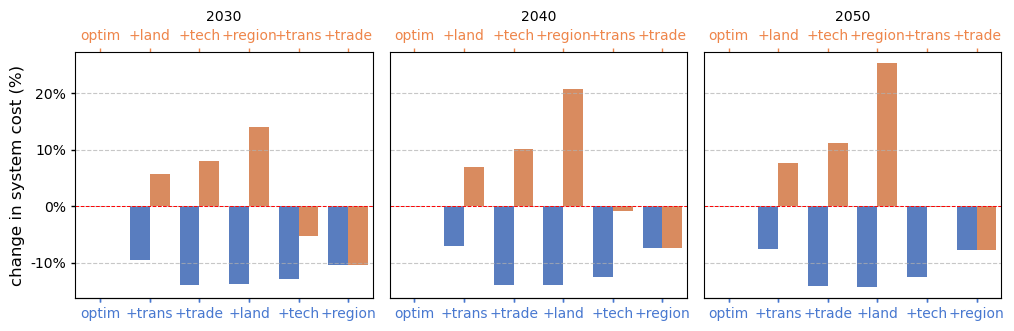

In [42]:
palette = {
    'trading': sns.color_palette('muted')[0],
    'landscape': sns.color_palette('muted')[1]
}

g = sns.catplot(
    data=df, x='scenarios', y='percent_change', hue='1st preference',
    col='demandyear', kind='bar', height=4, aspect=1,
    palette=palette, legend_out=False, errorbar=None
)
g.set_titles("{col_name}", fontsize=12)
g.set_axis_labels("", "change in system cost (%)", fontsize=12)
#g.add_legend(title='1st preference', title_fontsize=12, fontsize=10)


#g.add_legend(title='1st preference', loc='upper left', borderaxespad=0., frameon=False, 
#          fontsize=10, handlelength=1.5, handletextpad=0.5)
g.legend.remove()
g.fig.set_size_inches(10, 3.2)


for ax in g.axes.flat:
    #ax.set_xticks(range(len(scenario_labels)))
    ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    top_ax = ax.secondary_xaxis('top')
    scenario_labels =['optim', '+land', '+tech', '+region', '+trans', '+trade']
    top_ax.set_xticks(range(len(scenario_labels)))
    top_ax.set_xticklabels(scenario_labels)
    top_ax.tick_params(axis='x', colors=palette['landscape'], direction='out', length=3, width=1)
    top_ax.spines['top'].set_color('black')
    ax.spines['right'].set_visible(True)

    b_ax = ax.secondary_xaxis('bottom')
    b_ax.set_xticks(range(len(scenario_labels)))
    b_ax.set_xticklabels(['' for _ in b_ax.get_xticks()])
    b_ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)


for i, ax in enumerate(g.axes.flat):
    if i != 0: 
        ax.set_yticklabels([])
        ax.tick_params(left=False)
        
for ax in g.axes.flatten():
    ax.axhline(0, color='red', linestyle='--', linewidth=0.7)
#axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.tick_params(axis='both', length=3, width=1)

#g.set(yticks = range(-8, 9, 2))  # Adjust yticks as needed
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10, direction='out', length=3, width=1)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_scenarios.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_scenarios.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
data50 = cost_Ind_pref.unstack(level=0).sort_values(by=[('percent_change', '2030')], ascending=True)
costind_pref = data50['percent_change']['2050']
costind_pref = costind_pref.reset_index()
costind_pref['scenarios'] = ['+trans', '+trade', 'optim', '+land', '+tech', '+region']
costind_pref ['order'] = [2, 3, 1, 4, 5, 6]
costind_pref = costind_pref.set_index(['scenarios']).sort_values(by='order')
costind_pref

transmission ImpExp varnewpcapQ corines_solar corines_onshore  \
scenarios                                                                 
optim       DefaultYes      1         OPT           CSD             CWD   
+trans           LOWOH      1         OPT           CSD             CWD   
+trade      DefaultYes      2         OPT           CSD             CWD   
+land       DefaultYes      1         OPT           CSD          CWDHAF   
+tech       DefaultYes      1         QS1           CSD             CWD   
+region     DefaultYes      1         OPT           CSD             CWD   

          fylke_techs variable       2050  order  
scenarios                                         
optim      fylketechD    costs   0.000000      1  
+trans     fylketechD    costs  -7.619631      2  
+trade     fylketechD    costs  -6.862783      3  
+land      fylketechD    costs   7.557408      4  
+tech      fylketechD    costs   7.461844      5  
+region    fylketechC    costs  25.246940      6

In [44]:
data50

costs  \
demandyear                                                                                 2030   
transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                
LOWOH        1      OPT         CSD           CWD             fylketechD  costs     4928.013420   
DefaultYes   2      OPT         CSD           CWD             fylketechD  costs     5151.408322   
             1      OPT         CSD           CWD             fylketechD  costs     5445.491412   
                                              CWDHAF          fylketechD  costs     5750.282058   
                    QS1         CSD           CWD             fylketechD  costs     5754.721012   
                    OPT         CSD           CWD             fylketechC  costs     6194.599952   

                                                                                                  \
demandyear                                                                                  2040   
transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
LOWOH        1      OPT         CSD           CWD             fylketechD  costs      7921.607430   
DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      7965.166941   
             1      OPT         CSD           CWD             fylketechD  costs      8526.520776   
                                              CWDHAF          fylketechD  costs      9120.165663   
                    QS1         CSD           CWD             fylketechD  costs      9106.413496   
                    OPT         CSD           CWD             fylketechC  costs     10294.026405   

                                                                                                  \
demandyear                                                                                  2050   
transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
LOWOH        1      OPT         CSD           CWD             fylketechD  costs      9087.626071   
DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      9162.078592   
             1      OPT         CSD           CWD             fylketechD  costs      9837.183122   
                                              CWDHAF          fylketechD  costs     10580.619218   
                    QS1         CSD           CWD             fylketechD  costs     10571.218398   
                    OPT         CSD           CWD             fylketechC  costs     12320.770872   

                                                                                   percent_change  \
demandyear                                                                                   2030   
transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
LOWOH        1      OPT         CSD           CWD             fylketechD  costs         -9.502870   
DefaultYes   2      OPT         CSD           CWD             fylketechD  costs         -5.400488   
             1      OPT         CSD           CWD             fylketechD  costs          0.000000   
                                              CWDHAF          fylketechD  costs          5.597119   
                    QS1         CSD           CWD             fylketechD  costs          5.678635   
                    OPT         CSD           CWD             fylketechC  costs         13.756491   

                                                                                               \
demandyear                                                                               2040   
transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable              
LOWOH        1      OPT         CSD           CWD             fylketechD  costs     -7.094492   
DefaultYes   2      OPT         CSD           CWD             fylketechD  costs     -6.583621   
 

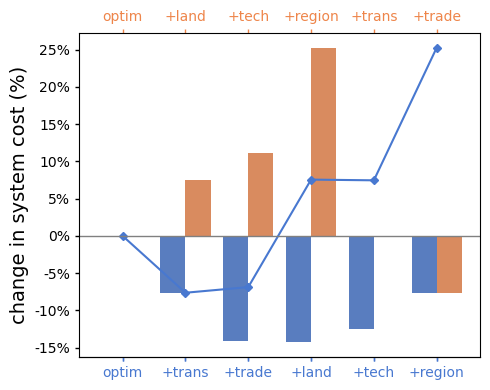

In [45]:
# Plotting for 2050
df_2050 = df[df['demandyear'] == '2050']

palette = {
    'trading': sns.color_palette('muted')[0],
    'landscape': sns.color_palette('muted')[1]
}

g = sns.catplot(
    data=df_2050, x='scenarios', y='percent_change', hue='1st preference',
    col='demandyear', kind='bar', height=4, aspect=1,
    palette=palette, legend_out=False, errorbar=None
)
#g.set_titles("year: {col_name}", fontsize=14)
g.set_axis_labels("", "change in system cost (%)", fontsize=14)


#g.add_legend(title='1st preference', loc='upper left', borderaxespad=0., frameon=False, 
#          fontsize=10, handlelength=1.5, handletextpad=0.5)

g.legend.remove()
g.fig.set_size_inches(5, 4)


for ax in g.axes.flat:
    #ax.set_xticks(range(len(scenario_labels)))
    ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)

    top_ax = ax.secondary_xaxis('top')
    scenario_labels =['optim', '+land', '+tech', '+region', '+trans', '+trade']
    top_ax.set_xticks(range(len(scenario_labels)))
    top_ax.set_xticklabels(scenario_labels)
    top_ax.tick_params(axis='x', colors=palette['landscape'], direction='out', length=3, width=1)
    top_ax.spines['top'].set_color('black')
    ax.spines['right'].set_visible(True)

    b_ax = ax.secondary_xaxis('bottom')
    b_ax.set_xticks(range(len(scenario_labels)))
    b_ax.set_xticklabels(['' for _ in b_ax.get_xticks()])
    b_ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)

    ax.set_title('')
    ax.plot(costind_pref.index, costind_pref['2050'], marker='D', color=palette['trading'], linestyle='-', markersize=4)
    

for i, ax in enumerate(g.axes.flat):
    if i != 0: 
        ax.set_yticklabels([])
        ax.tick_params(left=False)
        
for ax in g.axes.flatten():
    ax.axhline(0, color='grey', lw=1)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.tick_params(axis='both', length=3, width=1)

#g.set(yticks = range(-8, 9, 2))  # Adjust yticks as needed
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10, direction='out', length=3, width=1)
    
plt.tight_layout()
plt.show()

In [46]:
#comments
# The sequence of preferences plays a subtle yet noticeable influence. 
# Substaintial cost variations with the change in sequnce of preference application

In [47]:
df

demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore  \
0        2030   DefaultYes      1         OPT           CSD             CWD   
1        2030        LOWOH      1         OPT           CSD             CWD   
2        2030        LOWOH      2         OPT           CSD             CWD   
3        2030        LOWOH      2         OPT           CSD          CWDHAF   
4        2030        LOWOH      2         QS1           CSD          CWDHAF   
5        2030        LOWOH      2         QS1           CSD          CWDHAF   
6        2040   DefaultYes      1         OPT           CSD             CWD   
7        2040        LOWOH      1         OPT           CSD             CWD   
8        2040        LOWOH      2         OPT           CSD             CWD   
9        2040        LOWOH      2         OPT           CSD          CWDHAF   
10       2040        LOWOH      2         QS1           CSD          CWDHAF   
11       2040        LOWOH      2         QS1           CSD          CWDHAF   
12       2050   DefaultYes      1         OPT           CSD             CWD   
13       2050        LOWOH      1         OPT           CSD             CWD   
14       2050        LOWOH      2         OPT           CSD             CWD   
15       2050        LOWOH      2         OPT           CSD          CWDHAF   
16       2050        LOWOH      2         QS1           CSD          CWDHAF   
17       2050        LOWOH      2         QS1           CSD          CWDHAF   
18       2030   DefaultYes      1         OPT           CSD             CWD   
19       2030   DefaultYes      1         OPT           CSD          CWDHAF   
20       2030   DefaultYes      1         QS1           CSD          CWDHAF   
21       2030   DefaultYes      1         QS1           CSD          CWDHAF   
22       2030        LOWOH      1         QS1           CSD          CWDHAF   
23       2030        LOWOH      2         QS1           CSD          CWDHAF   
24       2040   DefaultYes      1         OPT           CSD             CWD   
25       2040   DefaultYes      1         OPT           CSD          CWDHAF   
26       2040   DefaultYes      1         QS1           CSD          CWDHAF   
27       2040   DefaultYes      1         QS1           CSD          CWDHAF   
28       2040        LOWOH      1         QS1           CSD          CWDHAF   
29       2040        LOWOH      2         QS1           CSD          CWDHAF   
30       2050   DefaultYes      1         OPT           CSD             CWD   
31       2050   DefaultYes      1         OPT           CSD          CWDHAF   
32       2050   DefaultYes      1         QS1           CSD          CWDHAF   
33       2050   DefaultYes      1         QS1           CSD          CWDHAF   
34       2050        LOWOH      1         QS1           CSD          CWDHAF   
35       2050        LOWOH      2         QS1           CSD          CWDHAF   

   fylke_techs variable         costs  percent_change  custom_order scenarios  \
0   fylketechD    costs   5445.491412        0.000000             1     optim   
1   fylketechD    costs   4928.013420       -9.502870             2    +trans   
2   fylketechD    costs   4686.357305      -13.940599             3    +trade   
3   fylketechD    costs   4695.340048      -13.775641             4     +land   
4   fylketechD    costs   4746.518179      -12.835816             5     +tech   
5   fylketechC    costs   4877.966110      -10.421930             6   +region   
6   fylketechD    costs   8526.520776        0.000000             1     optim   
7   fylketechD    costs   7921.607430       -7.094492             2    +trans   
8   fylketechD    costs   7339.601876      -13.920319             3    +trade   
9   fylketechD    costs   7333.806496      -13.988288             4     +land   
10  fylketechD    costs   7463.512543      -12.467081             5     +tech   
11  fylketechC    costs   7888.908591       -7.477988             6   +region   
12  fylketechD    costs   

/tmp/ipykernel_483994/3940870811.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  b = sns.boxplot(x='scenarios', y='percent_change', data=year_data,
/tmp/ipykernel_483994/3940870811.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='scenarios', y='percent_change', data=year_data, order=scenario_order,
/tmp/ipykernel_483994/3940870811.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), ha='center')


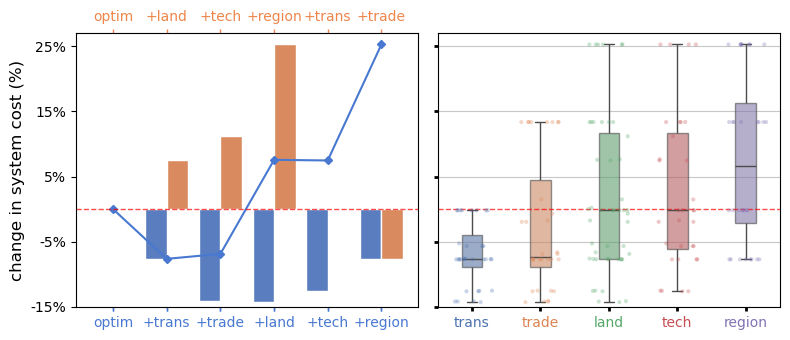

In [48]:
#Final cost plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
#plt.subplots_adjust(wspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.1)
sns.set_style("whitegrid")

# Data and palette setup
df_2050 = df[df['demandyear'] == '2050']

palette = {
    'trading': sns.color_palette('muted')[0],
    'landscape': sns.color_palette('muted')[1]
}


sns.barplot(
     data=df_2050, x='scenarios', y='percent_change', hue='1st preference',
     palette=palette, errorbar=None, ax=ax1
 )

ax1.set_xlabel("")
ax1.set_ylabel("change in system cost (%)", fontsize=12)
ax1.legend_.remove()
ax1.set_ylim(-15, 27)
y_ticks = [-15, -5, 5, 15, 25]
ax1.set_yticks(y_ticks)


# Adjust x-axis ticks and labels
ax1.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)
top_ax = ax1.secondary_xaxis('top')
scenario_labels = ['optim', '+land', '+tech', '+region', '+trans', '+trade']
top_ax.set_xticks(range(len(scenario_labels)))
top_ax.set_xticklabels(scenario_labels)
top_ax.tick_params(axis='x', colors=palette['landscape'], direction='out', labelsize=10, length=3, width=1)
#top_ax.spines['top'].set_color('black')

# Add bottom x-axis
b_ax = ax1.secondary_xaxis('bottom')
b_ax.set_xticks(range(len(scenario_labels)))
b_ax.set_xticklabels(['' for _ in b_ax.get_xticks()])
b_ax.tick_params(axis='x', colors=palette['trading'], direction='out',labelsize=10, length=3, width=1)

# Add line plot
ax1.plot(costind_pref.index, costind_pref['2050'], marker='D', color=palette['trading'], linestyle='-', markersize=4)

# Additional customization
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    

ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
#ax1.tick_params(axis='both', labelsize=10, direction='out', length=3, width=1)

# Boxplot showing the impact of preferring the given preference (ImpExp==2)
colors = sns.color_palette("deep", n_colors=5)

def remove_outliers(data, low, high):
    return data[(data >= low) & (data <= high)]

year = '2050'
data_to_plot = []

cost_trading = filtered_cost[(filtered_cost.index.get_level_values('ImpExp') == '2') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_trading['scenarios'] = 'trade'    
cost_landscapes = filtered_cost[(filtered_cost.index.get_level_values('corines_onshore').isin(['CWDH', 'CWDHA', 'CWDHAF'])) & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_landscapes['scenarios'] = 'land'
cost_technology = filtered_cost[(filtered_cost.index.get_level_values('varnewpcapQ') == 'QS1') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_technology['scenarios'] = 'tech'      
cost_transmission = filtered_cost[(filtered_cost.index.get_level_values('transmission') == 'LOWOH') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_transmission['scenarios'] = 'trans'    
cost_regional = filtered_cost[(filtered_cost.index.get_level_values('fylke_techs') == 'fylketechC') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_regional['scenarios'] = 'region'
costs_combined = pd.concat([cost_trading, cost_transmission, cost_landscapes, cost_technology, cost_regional], axis=0)
costs_combined['Year'] = year
data_to_plot.append(costs_combined)

data_to_plot = pd.concat(data_to_plot, axis=0)
data_to_plot.reset_index(inplace=True)

outlier_ranges = {
    'trade': (-100, 100),
    'trans': (-100, 100),
    'land': (-100, 100),
    'tech': (-100, 100),
    'region': (-100, 100)
}

scenario_order = ['trans', 'trade', 'land', 'tech', 'region']
year_data = data_to_plot[data_to_plot['Year'] == year]

# Remove outliers
for scenario in year_data['scenarios'].unique():
    mask = year_data['scenarios'] == scenario
    year_data.loc[mask, 'percent_change'] = remove_outliers(
        year_data.loc[mask, 'percent_change'],
        outlier_ranges[scenario][0],
        outlier_ranges[scenario][1]
    )

# Create boxplot
b = sns.boxplot(x='scenarios', y='percent_change', data=year_data, 
            width=0.3, boxprops=dict(alpha=0.6), ax=ax2,
            order=scenario_order, palette=colors, showfliers=False)

# Add strip plot
sns.stripplot(x='scenarios', y='percent_change', data=year_data, order=scenario_order, 
             ax=b, alpha=0.3, jitter=0.3, size=3, palette=colors)

# Customize subplot
ax2.set_xlabel('')
ax2.set_xticklabels(ax2.get_xticklabels(), ha='center')
ax2.set_ylim(-15, 27)
y_ticks = [-15, -5, 5, 15, 25]
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([])
#ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}%"))
ax2.grid(True, axis='y', linestyle='-', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)    
ax2.set_ylabel('')
ax2.tick_params(axis='both', direction='out', length=3, width=2, colors='black')

for i, label in enumerate(ax2.get_xticklabels()):
    label.set_color(colors[i])
for spine in ax2.spines.values():
    spine.set_edgecolor('black')

#sns.despine()

plt.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_2050.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_2050.jpg', dpi=300, bbox_inches='tight')
plt.show()


## Cost plots

In [49]:
cost_Ind_pref

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
2030       LOWOH        1      OPT         CSD           CWD             fylketechD  costs      4928.013420   
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      5151.408322   
                        1      OPT         CSD           CWD             fylketechD  costs      5445.491412   
                                                         CWDHAF          fylketechD  costs      5750.282058   
                               QS1         CSD           CWD             fylketechD  costs      5754.721012   
                               OPT         CSD           CWD             fylketechC  costs      6194.599952   
2040       LOWOH        1      OPT         CSD           CWD             fylketechD  costs      7921.607430   
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      7965.166941   
                        1      OPT         CSD           CWD             fylketechD  costs      8526.520776   
                               QS1         CSD           CWD             fylketechD  costs      9106.413496   
                               OPT         CSD           CWDHAF          fylketechD  costs      9120.165663   
                                                         CWD             fylketechC  costs     10294.026405   
2050       LOWOH        1      OPT         CSD           CWD             fylketechD  costs      9087.626071   
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs      9162.078592   
                        1      OPT         CSD           CWD             fylketechD  costs      9837.183122   
                               QS1         CSD           CWD             fylketechD  costs     10571.218398   
                               OPT         CSD           CWDHAF          fylketechD  costs     10580.619218   
                                                         CWD             fylketechC  costs     12320.770872   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2030       LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -9.502870  
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs          -5.400488  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
                                                         CWDHAF          fylketechD  costs           5.597119  
                               QS1         CSD           CWD             fylketechD  costs           5.678635  
                               OPT         CSD           CWD             fylketechC  costs          13.756491  
2040       LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.094492  
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs          -6.583621  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
                               QS1         CSD           CWD             fylketechD  costs           6.801047  
                               OPT         CSD           CWDHAF          fylketechD  costs           6.962334  
                                                         CWD             fylketechC  costs          20.729506  
2050       LOWOH        1      OPT         CSD           CWD             fylketechD  costs          -7.619631  
           DefaultYes   2      OPT         CSD           CWD             fylketechD  costs          -6.862783  
                        1      OPT         CSD           CWD             fylketechD  cost

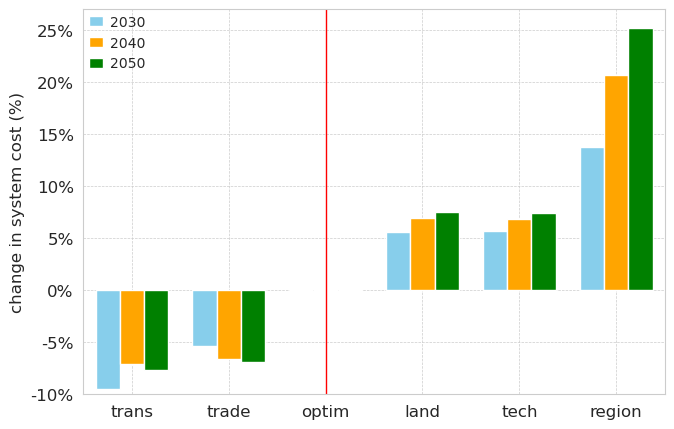

In [50]:
scenarios = ['trans', 'trade', 'optim', 'land', 'tech','region'] # plot sequence wrt data30
#scenarios = ['Optimal', '+landscape', '+regional', '+technology', '+transmission']
#data = cost_seq_pref_5.loc[['2030'],['percent_change']]
data30 = cost_Ind_pref.unstack(level=0).sort_values(by=[('percent_change', '2030')], ascending=True)

years = [2030, 2040, 2050]
fig, ax = plt.subplots(figsize=(7.5, 5))

bar_width = 0.25
r1 = np.arange(len(scenarios))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.bar(r1, data30['percent_change']['2030'], color='skyblue', width=bar_width, label='2030')
plt.bar(r2, data30['percent_change']['2040'], color='orange', width=bar_width, label='2040')
plt.bar(r3, data30['percent_change']['2050'], color='green', width=bar_width, label='2050')

#plt.plot(r1, data30['percent_change']['2030'], color='skyblue', linestyle='--')
#plt.plot(r2, data30['percent_change']['2030'], color='orange', linestyle='--')
#plt.plot(r3, data30['percent_change']['2030'], color='green', linestyle='--')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#custom x-axis
ax.set_xticks([r + bar_width for r in range(len(scenarios))])
ax.set_xticklabels(scenarios, ha='center',fontsize=12)
ax.set_xlim(-0.25, 5.75)

#custom y-axis
ax.set_ylim(-10, 27) 
ax.set_yticks(np.arange(-10, 27, 5))
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_ylabel('change in system cost (%)', fontsize=12)

# Add percent signs to the y-tick labels
def percent_formatter(x, pos):
    return f'{x:.0f}%'
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

#Horizontal line
ax.axvline(x=2.25, color='red', linestyle='-', linewidth=1)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_allyears.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_allyears.jpg', dpi=300, bbox_inches='tight')

# Customize legend
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False, 
#          fontsize=10, handlelength=1.5, handletextpad=0.5)
ax.legend(loc='upper left', borderaxespad=0., frameon=False, 
          fontsize=10, handlelength=1, handletextpad=0.5)


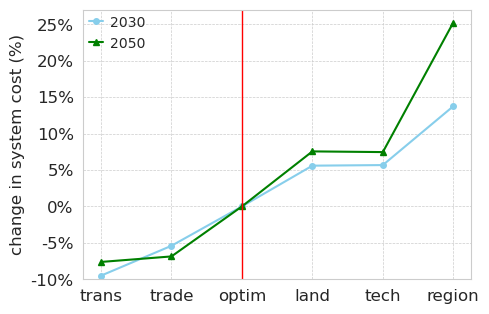

In [65]:
scenarios = ['trans', 'trade', 'optim', 'land', 'tech','region'] # plot sequence wrt data30
#scenarios = ['Optimal', '+landscape', '+regional', '+technology', '+transmission']
#data = cost_seq_pref_5.loc[['2030'],['percent_change']]
data30 = cost_Ind_pref.unstack(level=0).sort_values(by=[('percent_change', '2030')], ascending=True)

years = [2030, 2040, 2050]
fig, ax = plt.subplots(figsize=(5, 3.5))

line_width = 1.5
scatter_size = 50
r1 = np.arange(len(scenarios))  # 2030 slightly to the left
r2 = np.arange(len(scenarios))  # 2040 at the center
r3 = np.arange(len(scenarios))  # 2050 slightly to the right

#change bar_width accordingly
bar_width = 0.48
plt.plot(r1, data30['percent_change']['2030'], color='skyblue', linewidth=line_width, linestyle='-', marker='o', markersize=4, label='2030')
#plt.plot(r2, data30['percent_change']['2040'], color='orange', linewidth=line_width, linestyle='-', marker='s', markersize=4, label='2040')
plt.plot(r3, data30['percent_change']['2050'], color='green', linewidth=line_width, linestyle='-', marker='^', markersize=4, label='2050')

#plt.plot(r1, data30['percent_change']['2030'], color='skyblue', linestyle='--')
#plt.plot(r2, data30['percent_change']['2030'], color='orange', linestyle='--')
#plt.plot(r3, data30['percent_change']['2030'], color='green', linestyle='--')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#custom x-axis
#ax.set_xticks([r + bar_width for r in range(len(scenarios))])
ax.set_xticks(np.arange(len(scenarios)))
ax.set_xticklabels(scenarios, ha='center',fontsize=12)
ax.set_xlim(-0.25, 5.25)

#custom y-axis
ax.set_ylim(-10, 27) 
ax.set_yticks(np.arange(-10, 27, 5))
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_ylabel('change in system cost (%)', fontsize=12)

# Add percent signs to the y-tick labels
def percent_formatter(x, pos):
    return f'{x:.0f}%'
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

#Horizontal line
ax.axvline(x=2, color='red', linestyle='-', linewidth=1)

ax.legend(loc='upper left', borderaxespad=0., frameon=False, 
          fontsize=10, handlelength=1, handletextpad=0.5)


#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChangeline_IB.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_allyears.jpg', dpi=300, bbox_inches='tight')

# Customize legend
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False, 
#          fontsize=10, handlelength=1.5, handletextpad=0.5)


In [ ]:
# Comments
# cost variaitons due to the consideration of each preference individually

In [957]:
filtered_cost

costs  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                 
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  costs      9486.380015   
2030       DefaultYes   2      QS1         CSD           CWDH            fylketechD  costs      5312.582144   
                        1      OPT         CSD           CWD             fylketechD  costs      5445.491412   
2050       LOWOH        1      OPT         CSD           CWD             fylketechC  costs      9819.392265   
2040       LOWOH        1      OPT         CSD           CWDHA           fylketechC  costs      8448.346615   
...                                                                                                     ...   
                               QS1         CSD           CWD             fylketechC  costs      8448.346666   
2050       DefaultYes   2      QS1         CSD           CWDHAF          fylketechC  costs     11150.443819   
                        1      OPT         CSD           CWD             fylketechD  costs      9837.183122   
2030       DefaultYes   1      OPT         CSD           CWDH            fylketechC  costs      6194.599952   
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  costs      8448.346518   

                                                                                               percent_change  
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs variable                  
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  costs          11.257338  
2030       DefaultYes   2      QS1         CSD           CWDH            fylketechD  costs          -2.440721  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
2050       LOWOH        1      OPT         CSD           CWD             fylketechC  costs          -0.180853  
2040       LOWOH        1      OPT         CSD           CWDHA           fylketechC  costs          -0.916835  
...                                                                                                       ...  
                               QS1         CSD           CWD             fylketechC  costs          -0.916835  
2050       DefaultYes   2      QS1         CSD           CWDHAF          fylketechC  costs          13.349967  
                        1      OPT         CSD           CWD             fylketechD  costs           0.000000  
2030       DefaultYes   1      OPT         CSD           CWDH            fylketechC  costs          13.756491  
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  costs          -0.916837  

[192 rows x 2 columns]

/tmp/ipykernel_1600841/3479835319.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='center')


<Figure size 600x400 with 0 Axes>

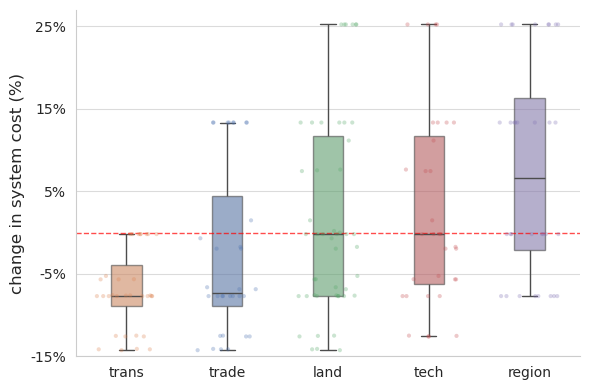

In [122]:
#Boxplot showing the impact of preferring the given preference (ImpExp==2)
# Set up the plot
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")
colors = sns.color_palette("deep", n_colors=5)

def remove_outliers(data, low, high):
    return data[(data >= low) & (data <= high)]

year = '2050'
data_to_plot = []

cost_trading = filtered_cost[(filtered_cost.index.get_level_values('ImpExp') == '2') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_trading['scenarios'] = 'trade'    
cost_landscapes = filtered_cost[(filtered_cost.index.get_level_values('corines_onshore').isin(['CWDH', 'CWDHA', 'CWDHAF']))& #== 'CWDHAF') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_landscapes['scenarios'] = 'land'
cost_technology = filtered_cost[(filtered_cost.index.get_level_values('varnewpcapQ') == 'QS1') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_technology['scenarios'] = 'tech'      
cost_transmission = filtered_cost[(filtered_cost.index.get_level_values('transmission') == 'LOWOH') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_transmission['scenarios'] = 'trans'    
cost_regional = filtered_cost[(filtered_cost.index.get_level_values('fylke_techs') == 'fylketechC') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
cost_regional['scenarios'] = 'region'
costs_combined = pd.concat([cost_trading, cost_transmission, cost_landscapes, cost_technology, cost_regional], axis=0)
costs_combined['Year'] = year
data_to_plot.append(costs_combined)

data_to_plot = pd.concat(data_to_plot, axis=0)
data_to_plot.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(6, 4))

# Outlier ranges for each scenario
outlier_ranges = {
    'trade': (-100, 100),
    'trans': (-100, 100),
    'land': (-100, 100),
    'tech': (-100, 100),
    'region': (-100, 100)
}

scenario_order = ['trans', 'trade', 'land', 'tech', 'region']


year_data = data_to_plot[data_to_plot['Year'] == year]
    
# Remove outliers
for scenario in year_data['scenarios'].unique():
    mask = year_data['scenarios'] == scenario
    year_data.loc[mask, 'percent_change'] = remove_outliers(
        year_data.loc[mask, 'percent_change'],
        outlier_ranges[scenario][0],
        outlier_ranges[scenario][1]
    )
# Create boxplot
b = sns.boxplot(x='scenarios', y='percent_change', data=year_data, 
            width=0.3, boxprops=dict(alpha=0.6), ax=ax,
            order=scenario_order, hue='scenarios', palette=colors, showfliers=False)

# Add strip plot
sns.stripplot(x='scenarios', y='percent_change', data=year_data, order=scenario_order, 
              hue='scenarios', ax=b, alpha=0.3, jitter=0.3, size=3, palette=colors)
    
# Customize subplot

ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), ha='center')
ax.set_ylim(-15, 27)
y_ticks = [-15, -5, 5, 15, 25]
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}%"))
ax.grid(True, axis='y', linestyle='-', alpha=0.7)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)    
ax.set_ylabel('change in system cost (%)', fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()

/tmp/ipykernel_1600841/3189518763.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_1600841/3189518763.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_1600841/3189518763.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')


<Figure size 1100x350 with 0 Axes>

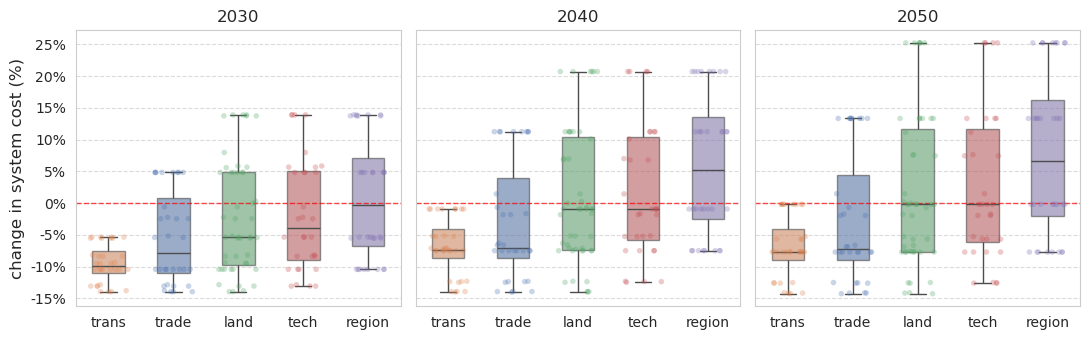

In [887]:
#Boxplot showing the impact of preferring the given preference (ImpExp==2)
# Set up the plot
plt.figure(figsize=(11, 3.5))
sns.set_style("whitegrid")
colors = sns.color_palette("deep", n_colors=5)

def remove_outliers(data, low, high):
    return data[(data >= low) & (data <= high)]

demand_years = ['2030', '2040', '2050']
data_to_plot = []
for year in demand_years:
    cost_trading = filtered_cost[(filtered_cost.index.get_level_values('ImpExp') == '2') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_trading['scenarios'] = 'trade'    
    cost_landscapes = filtered_cost[(filtered_cost.index.get_level_values('corines_onshore').isin(['CWDH', 'CWDHA', 'CWDHAF']))& #== 'CWDHAF') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_landscapes['scenarios'] = 'land'
    cost_technology = filtered_cost[(filtered_cost.index.get_level_values('varnewpcapQ') == 'QS1') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_technology['scenarios'] = 'tech'      
    cost_transmission = filtered_cost[(filtered_cost.index.get_level_values('transmission') == 'LOWOH') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_transmission['scenarios'] = 'trans'    
    cost_regional = filtered_cost[(filtered_cost.index.get_level_values('fylke_techs') == 'fylketechC') & 
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_regional['scenarios'] = 'region'
    costs_combined = pd.concat([cost_trading, cost_transmission, cost_landscapes, cost_technology, cost_regional], axis=0)
    costs_combined['Year'] = year
    data_to_plot.append(costs_combined)

data_to_plot = pd.concat(data_to_plot, axis=0)
data_to_plot.reset_index(inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(11, 3.5), sharey=True)

# Outlier ranges for each scenario
outlier_ranges = {
    'trade': (-100, 100),
    'trans': (-100, 100),
    'land': (-100, 100),
    'tech': (-100, 100),
    'region': (-100, 100)
}

scenario_order = ['trans', 'trade', 'land', 'tech', 'region']

for idx, year in enumerate(demand_years):
    year_data = data_to_plot[data_to_plot['Year'] == year]
    
    # Remove outliers
    for scenario in year_data['scenarios'].unique():
        mask = year_data['scenarios'] == scenario
        year_data.loc[mask, 'percent_change'] = remove_outliers(
            year_data.loc[mask, 'percent_change'],
            outlier_ranges[scenario][0],
            outlier_ranges[scenario][1]
        )
    # Create boxplot
    sns.boxplot(x='scenarios', y='percent_change', data=year_data, 
                width=0.5, boxprops=dict(alpha=0.6), ax=axes[idx],
                order=scenario_order, hue='scenarios', palette=colors, showfliers=False)
    
    # Add strip plot
    sns.stripplot(x='scenarios', y='percent_change', data=year_data, order=scenario_order, 
                  hue='scenarios', ax=axes[idx], alpha=0.3, jitter=0.3, size=4, palette=colors)
    
    # Customize subplot
    axes[idx].set_title(f'{year}', fontsize=12)
    axes[idx].set_xlabel('')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
    axes[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}%"))
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)    

    # Only show y-label for the first subplot
    if idx == 0:
        axes[idx].set_ylabel('change in system cost (%)', fontsize=12)
    else:
        axes[idx].set_ylabel('')


plt.tight_layout()
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/scenarios_impact_allyears.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/scenarios_impact_allyears.jpg', dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_1600841/508853896.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_1600841/508853896.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_1600841/508853896.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')


<Figure size 1100x400 with 0 Axes>

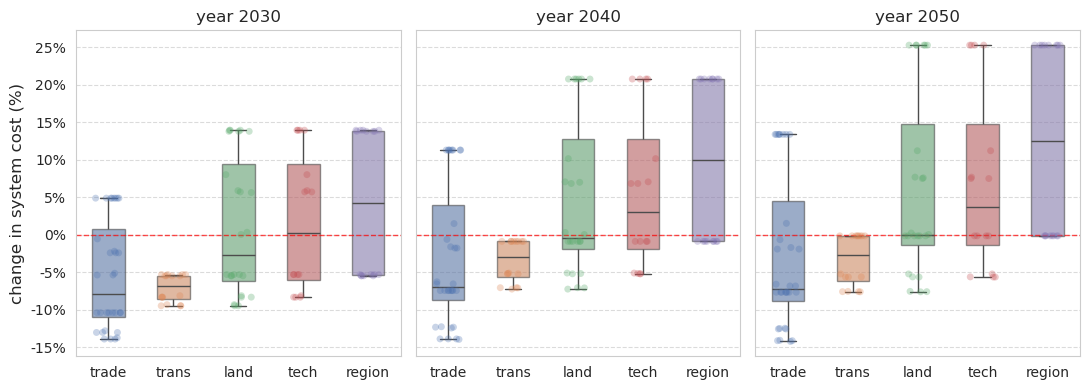

In [94]:
#Boxplot showing the impact of preferring the given preference with ImpExp=1
# Set up the plot
plt.figure(figsize=(11, 4))
sns.set_style("whitegrid")
colors = sns.color_palette("deep", n_colors=5)

def remove_outliers(data, low, high):
    return data[(data >= low) & (data <= high)]
#DefaultNO
demand_years = ['2030', '2040', '2050']
data_to_plot = []
for year in demand_years:
    cost_trading = filtered_cost[(filtered_cost.index.get_level_values('ImpExp') == '2') &  
                (filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_trading['scenarios'] = 'trade'    
    cost_landscapes = filtered_cost[(filtered_cost.index.get_level_values('corines_onshore').isin(['CWDH', 'CWDHA', 'CWDHAF']))& #== 'CWDHAF') & 
                (filtered_cost.index.get_level_values('ImpExp') == '1')&(filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_landscapes['scenarios'] = 'land'
    cost_technology = filtered_cost[(filtered_cost.index.get_level_values('varnewpcapQ') == 'QS1') & 
                (filtered_cost.index.get_level_values('ImpExp') == '1')&(filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_technology['scenarios'] = 'tech'      
    cost_transmission = filtered_cost[(filtered_cost.index.get_level_values('transmission') == 'LOWOH') & 
                (filtered_cost.index.get_level_values('ImpExp') == '1')&(filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_transmission['scenarios'] = 'trans'    
    cost_regional = filtered_cost[(filtered_cost.index.get_level_values('fylke_techs') == 'fylketechC') & 
                (filtered_cost.index.get_level_values('ImpExp') == '1')&(filtered_cost.index.get_level_values('demandyear') == year)].copy()
    cost_regional['scenarios'] = 'region'
    costs_combined = pd.concat([cost_trading, cost_transmission, cost_landscapes, cost_technology, cost_regional], axis=0)
    costs_combined['Year'] = year
    data_to_plot.append(costs_combined)

data_to_plot = pd.concat(data_to_plot, axis=0)
data_to_plot.reset_index(inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(11, 4), sharey=True)

# Outlier ranges for each scenario
outlier_ranges = {
    'trade': (-20, 50),
    'trans': (-20, 50),
    'land': (-20, 40),
    'tech': (-20, 50),
    'region': (-20, 50)
}

scenario_order = ['trade', 'trans', 'land', 'tech', 'region']

for idx, year in enumerate(demand_years):
    year_data = data_to_plot[data_to_plot['Year'] == year]
    
    # Remove outliers
    for scenario in year_data['scenarios'].unique():
        mask = year_data['scenarios'] == scenario
        year_data.loc[mask, 'percent_change'] = remove_outliers(
            year_data.loc[mask, 'percent_change'],
            outlier_ranges[scenario][0],
            outlier_ranges[scenario][1]
        )
    # Create boxplot
    sns.boxplot(x='scenarios', y='percent_change', data=year_data, 
                width=0.5, boxprops=dict(alpha=0.6), ax=axes[idx],
                order=scenario_order, hue='scenarios', palette=colors, showfliers=False)
    
    # Add strip plot
    sns.stripplot(x='scenarios', y='percent_change', data=year_data, order=scenario_order, 
                  hue='scenarios', ax=axes[idx], alpha=0.3, jitter=0.2, size=5, palette=colors)
    
    # Customize subplot
    axes[idx].set_title(f'year {year}', fontsize=12)
    axes[idx].set_xlabel('')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
    axes[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}%"))
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)    

    # Only show y-label for the first subplot
    if idx == 0:
        axes[idx].set_ylabel('change in system cost (%)', fontsize=12)
    else:
        axes[idx].set_ylabel('')


plt.tight_layout()
plt.show()

# Capacities

In [20]:
cap = makenice(found_scenarios, "cap")

  0%|          | 0/720 [00:00<?, ?it/s]

In [ ]:
cap = cap.loc[level_slice]

In [232]:
filtered_cap = cap[(cap.index.get_level_values('transmission') != 'DefaultNO')&
                      (cap.index.get_level_values('ImpExp').isin(['1', '2']))]
filtered_cap

gencaptot
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                              
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  Export                      4.907500e+00
                                                                                     HydroRes                    1.967522e+01
                                                                                     HydroRoR                    1.376862e+01
                                                                                     Import                      4.907350e+00
                                                                                     NaturalgasCCGTwithCCSnewOT  0.000000e+00
...                                                                                                                       ...
           LOWOH        1      OPT         CSD           CWDHAF          fylketechC  NaturalgasOCGTnew           0.000000e+00
                                                                                     Solar                       6.141981e+00
                                                                                     Windoffshore                1.570924e+01
                                                                                     Windoffshorefloating        6.173003e+00
                                                                                     Windonshore                 5.510396e-12

[1920 rows x 1 columns]

In [233]:
tech_query_string = (
    "technology == 'Solar' | "
    "technology == 'Windoffshore' | "
    "technology == 'Windoffshorefloating' | "
    "technology == 'Windonshore' "
)

In [234]:
filtered_cap.query(Ind_query_string_2).query(tech_query_string)

gencaptot
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                     
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                 30.351472
                                                                                     Windoffshore           1.381922
                                                                                     Windoffshorefloating   1.451310
                                                                                     Windonshore           13.832429
                        2      OPT         CSD           CWD             fylketechD  Solar                 31.017025
...                                                                                                              ...
2040       DefaultYes   1      OPT         CSD           CWDHAF          fylketechD  Windonshore           21.232346
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                 41.412428
                                                                                     Windoffshore           3.724381
                                                                                     Windoffshorefloating   4.384912
                                                                                     Windonshore           34.237355

[72 rows x 1 columns]

In [235]:
sort_columns_str = 'demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs'
sort_columns_list = sort_columns_str.split()

In [236]:
#Sequnce: [ 'Optimal', '+transmission','+trading', '+landscape', '+technology', '+regional']
def assign_scenario_id(group):
    group['scenario_id'] = group.groupby(
        ['transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']
    ).ngroup()
    return group

def sort_within_group(group_df):
    id_to_scenario_name = {
        0: 'region',
        1: 'optim',
        2: 'land',
        3: 'tech',
        4: 'trade',
        5: 'trans'
    }    
    scenario_to_custom_order = {
        'optim': 1,
        'trans': 2,
        'trade': 3,
        'land': 4,
        'tech': 5,
        'region': 6
    }    

    group_df['scenarios'] = group_df['scenario_id'].map(id_to_scenario_name)
    group_df['custom_order'] = group_df['scenarios'].map(scenario_to_custom_order)
    return group_df.sort_values(by='custom_order', ascending=True)
    return group_df

cap_Ind_pref = filtered_cap.query(Ind_query_string_2).query(tech_query_string).sort_values(by=sort_columns_list)
cap_Ind_pref = cap_Ind_pref.groupby('demandyear', group_keys=False).apply(assign_scenario_id)
cap_Ind_pref = cap_Ind_pref.groupby('demandyear', group_keys=False).apply(sort_within_group)
cap_Ind_pref

gencaptot  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                           
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                 3.035147e+01   
                                                                                     Windoffshore          1.381922e+00   
                                                                                     Windoffshorefloating  1.451310e+00   
                                                                                     Windonshore           1.383243e+01   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Windonshore           7.456837e+00   
...                                                                                                                 ...   
2050       DefaultYes   1      QS1         CSD           CWD             fylketechD  Solar                 1.398555e+01   
                               OPT         CSD           CWD             fylketechC  Windonshore           1.206287e-11   
                                                                                     Windoffshorefloating  2.302474e+01   
                                                                                     Windoffshore          6.092424e+00   
                                                                                     Solar                 6.142322e+00   

                                                                                                           scenario_id  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                          
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                           1   
                                                                                     Windoffshore                    1   
                                                                                     Windoffshorefloating            1   
                                                                                     Windonshore                     1   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Windonshore                     5   
...                                                                                                                ...   
2050       DefaultYes   1      QS1         CSD           CWD             fylketechD  Solar                           3   
                               OPT         CSD           CWD             fylketechC  Windonshore                     0   
                                                                                     Windoffshorefloating            0   
                                                                                     Windoffshore                    0   
                                                                                     Solar                           0   

                                                                                                          scenarios  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                       
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                    optim   
                                                                                     Windoffshore             optim   
                                                                                     Windoffshorefloating     optim   
                                                                                     Windonshore              optim   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Windonshore              trans   
...                                                                                       

In [237]:
all_cap_plot = pd.DataFrame()
AA=cap_Ind_pref.set_index(['scenarios', 'custom_order'], append=True)
all_cap_plot = AA.pivot_table(
    index = ['demandyear', 'custom_order','scenarios' ],
    columns='technology',
    values='gencaptot',
    aggfunc='first',
)

all_cap_plot


technology                             Solar  Windoffshore  \
demandyear custom_order scenarios                            
2030       1            optim      30.351472      1.381922   
           2            trans      21.063101      5.718304   
           3            trade      31.017025      2.886856   
           4            land       26.876702      1.404454   
           5            tech        7.641741      4.176019   
           6            region      6.142322      4.566469   
2040       1            optim      39.491418      3.500666   
           2            trans      30.191421      9.799949   
           3            trade      42.859530      5.206485   
           4            land       41.085355      3.397536   
           5            tech       12.198290      7.580142   
           6            region      6.142321      5.954425   
2050       1            optim      41.412428      3.724381   
           2            trans      34.166613     10.409043   
           3            trade      42.424914      5.115642   
           4            land       41.431973      3.491078   
           5            tech       13.985555      7.672744   
           6            region      6.142322      6.092424   

technology                         Windoffshorefloating   Windonshore  
demandyear custom_order scenarios                                      
2030       1            optim              1.451310e+00  1.383243e+01  
           2            trans              4.838685e-08  7.456837e+00  
           3            trade              1.185437e+00  8.723460e+00  
           4            land               3.328284e+00  1.244652e+01  
           5            tech               3.860622e+00  1.060471e+01  
           6            region             8.410407e+00  4.205283e-11  
2040       1            optim              3.404976e+00  2.720893e+01  
           2            trans              2.951431e+00  1.175986e+01  
           3            trade              1.451294e+00  2.442574e+01  
           4            land               7.012863e+00  2.123235e+01  
           5            tech               8.175228e+00  1.692909e+01  
           6            region             1.852071e+01  5.660001e-12  
2050       1            optim              4.384912e+00  3.423735e+01  
           2            trans              4.569859e+00  1.402081e+01  
           3            trade              3.082222e+00  3.042347e+01  
           4            land               8.031461e+00  3.130427e+01  
           5            tech               1.110962e+01  1.940859e+01  
           6            region             2.302474e+01  1.206287e-11

In [238]:
all_cap_plot.reset_index().reset_index()


technology  index demandyear  custom_order scenarios      Solar  Windoffshore  \
0               0       2030             1     optim  30.351472      1.381922   
1               1       2030             2     trans  21.063101      5.718304   
2               2       2030             3     trade  31.017025      2.886856   
3               3       2030             4      land  26.876702      1.404454   
4               4       2030             5      tech   7.641741      4.176019   
5               5       2030             6    region   6.142322      4.566469   
6               6       2040             1     optim  39.491418      3.500666   
7               7       2040             2     trans  30.191421      9.799949   
8               8       2040             3     trade  42.859530      5.206485   
9               9       2040             4      land  41.085355      3.397536   
10             10       2040             5      tech  12.198290      7.580142   
11             11       2040             6    region   6.142321      5.954425   
12             12       2050             1     optim  41.412428      3.724381   
13             13       2050             2     trans  34.166613     10.409043   
14             14       2050             3     trade  42.424914      5.115642   
15             15       2050             4      land  41.431973      3.491078   
16             16       2050             5      tech  13.985555      7.672744   
17             17       2050             6    region   6.142322      6.092424   

technology  Windoffshorefloating   Windonshore  
0                   1.451310e+00  1.383243e+01  
1                   4.838685e-08  7.456837e+00  
2                   1.185437e+00  8.723460e+00  
3                   3.328284e+00  1.244652e+01  
4                   3.860622e+00  1.060471e+01  
5                   8.410407e+00  4.205283e-11  
6                   3.404976e+00  2.720893e+01  
7                   2.951431e+00  1.175986e+01  
8                   1.451294e+00  2.442574e+01  
9                   7.012863e+00  2.123235e+01  
10                  8.175228e+00  1.692909e+01  
11                  1.852071e+01  5.660001e-12  
12                  4.384912e+00  3.423735e+01  
13                  4.569859e+00  1.402081e+01  
14                  3.082222e+00  3.042347e+01  
15                  8.031461e+00  3.130427e+01  
16                  1.110962e+01  1.940859e+01  
17                  2.302474e+01  1.206287e-11

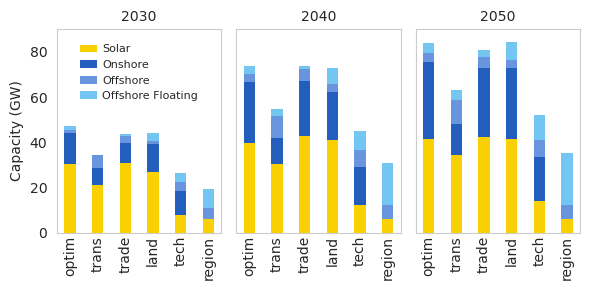

In [239]:
# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3))
axes = [ax1, ax2, ax3]
years = ['2030', '2040', '2050']

for ax, year in zip(axes, years):
    year_data = all_cap_plot[all_cap_plot.index.get_level_values('demandyear') == year]
    bottom = np.zeros(len(year_data))
    
    for technology in ['Solar',  'Windonshore', 'Windoffshore', 'Windoffshorefloating']:
        ax.bar(year_data.index.get_level_values('scenarios'), year_data[technology], width=0.4, 
               bottom=bottom, label=technology, color=colordict[technology], linewidth=0, edgecolor='none')
        bottom += year_data[technology].values
    
    ax.set_title(f'{year}', fontsize=10)
    ax1.set_ylabel('Capacity (GW)', fontsize=10)
    ax.set_ylim(0, 90)
    ax.set_yticks(range(0, 91, 20))
    #ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', labelsize=10, rotation=90, pad=-1)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(False)

    if ax != ax1:  # Remove y-axis tick labels for 2nd and 3rd plots
        ax.set_yticklabels([])

# Customize the plot
custom_labels = ['Solar',  'Onshore', 'Offshore', 'Offshore Floating']
handles, _ = ax1.get_legend_handles_labels()
fig.legend(handles, custom_labels, loc='upper center', bbox_to_anchor=(0.24, 0.85), borderaxespad=0., frameon=False, 
          fontsize=8, handlelength=1.5, handletextpad=0.5)
fig.tight_layout()


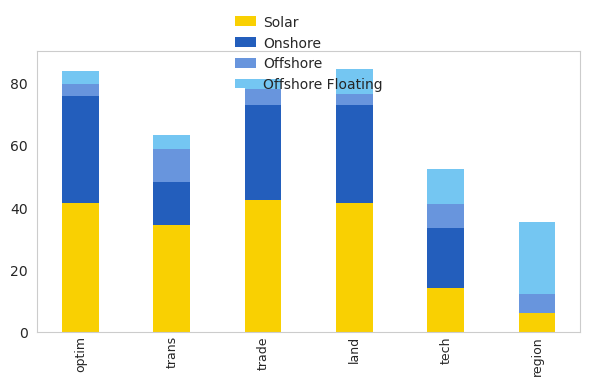

In [240]:
#Plotting with three scenarios

year = '2050'
year_data = all_cap_plot[all_cap_plot.index.get_level_values('demandyear') == year]

fig, ax = plt.subplots(figsize=(6, 4)) 
bottom = np.zeros(len(year_data))

for technology in ['Solar',  'Windonshore', 'Windoffshore', 'Windoffshorefloating']:
    ax.bar(year_data.index.get_level_values('scenarios'), year_data[technology], width=0.4, 
           bottom=bottom, label=technology, color=colordict[technology], linewidth=0, edgecolor='none')
    bottom += year_data[technology].values
    
#ax.set_title(f'year {year}', fontsize=12)
ax1.set_ylabel('GW', fontsize=10)
ax.set_ylim(0, 90)
ax.set_yticks(range(0, 91, 20))
#ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', labelsize=9, rotation=90, pad=-1)
ax.tick_params(axis='y', labelsize=10)
ax.grid(False)

custom_labels = ['Solar', 'Onshore', 'Offshore', 'Offshore Floating']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, custom_labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), borderaxespad=0., 
          frameon=False, fontsize=10, handlelength=1.5, handletextpad=0.5)

fig.tight_layout()

plt.show()

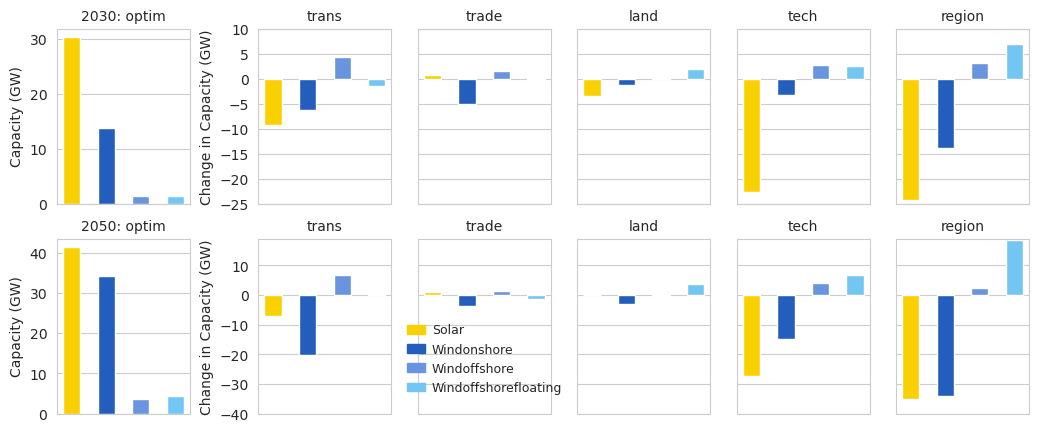

In [241]:
fig, axes = plt.subplots(2, 6, figsize=(12, 5), sharex=True)
years = ['2030', '2050']
scenarios = ['optim', 'trans', 'trade', 'land', 'tech', 'region']
technologies = ['Solar',  'Windonshore', 'Windoffshore', 'Windoffshorefloating']
df_plot = all_cap_plot.reset_index()


for row, year in enumerate(years):
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        df_filtered = df_plot[(df_plot['demandyear'] == year) & (df_plot['scenarios'] == scenario)]
        #data = df_filtered[technologies].squeeze()
        if scenario == 'optim':
            ax.bar(technologies, df_filtered[technologies].values.flatten(), color=[colordict[t] for t in technologies], width=0.5)
            ax.set_ylim(0)
            ax.set_ylabel('Capacity (GW)', fontsize=10)
        else:
            optim_data = df_plot[(df_plot['demandyear'] == year) & (df_plot['scenarios'] == 'optim')][technologies]
            change = df_filtered[technologies].values - optim_data.values            
            ax.bar(technologies, change.flatten(), color=[colordict[t] for t in technologies], width=0.5)
            if row==0:
                ax.set_ylim(-25, 10)
                ax.set_yticks(range(-25, 11, 5))
            if row==1:
                ax.set_ylim(-40, 19)
                ax.set_yticks(range(-40, 20, 10))
                
            if col == 1:
                ax.set_ylabel('Change in Capacity (GW)', fontsize=10)
                
        #ax.grid(False, axis='y', linestyle='--', alpha=0.6)
        ax.grid(False, axis='x')

        if col == 0:
            ax.set_title('{}: {}'.format(year, scenario), fontsize=10)
        else:
            ax.set_title(f'{scenario}', fontsize=10)

        if row == 1:
            ax.set_xticks(range(len(technologies)))
            ax.set_xticklabels([])

        if col > 1:
            ax.set_yticklabels([])


#plt.tight_layout()
for row in range(2):
    # Move all subplots from the second column onwards to the right
    for col in range(1, 6):
        pos = axes[row, col].get_position()
        pos.x0 += 0.035  # Adjust this value to increase/decrease the gap
        pos.x1 += 0.035
        axes[row, col].set_position(pos)


#fig.subplots_adjust(left=0.07, right=0.85, top=0.95, bottom=0.1, hspace=0.15, wspace=0.3)

handles = [plt.Rectangle((0,0),0.10,0.6, color=colordict[t], label=t) for t in technologies]
fig.legend(handles=handles, bbox_to_anchor=(0.55, 0.3), borderaxespad=0., frameon=False, 
          fontsize=9, handlelength=1.5, handletextpad=0.5)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacitychange_203050.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacitychange_203050.jpg', dpi=300, bbox_inches='tight')

plt.show()

      

In [242]:
# sequential preferences plotting for capacities with trading
def assign_scenario_id(group):
    group['scenario_id'] = group.groupby(
        ['transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']
    ).ngroup()
    return group

def sort_within_group(group_df):
    id_to_scenario_name = {
        0: 'optim',
        1: '+trans',
        2: '+trade',
        3: '+land',
        4: '+region',
        5: '+tech'
    }    
    scenario_to_custom_order = {
        'optim': 1,
        '+trans': 2,
        '+trade': 3,
        '+land': 4,
        '+tech': 5,
        '+region': 6
    }    

    group_df['scenarios'] = group_df['scenario_id'].map(id_to_scenario_name)
    group_df['custom_order'] = group_df['scenarios'].map(scenario_to_custom_order)
    return group_df.sort_values(by='custom_order', ascending=True)
    return group_df

cap_seq_pref_trading = filtered_cap.query(seq_query_string_trading).query(tech_query_string).sort_values(by=sort_columns_list)
cap_seq_pref_trading = cap_seq_pref_trading.groupby('demandyear', group_keys=False).apply(assign_scenario_id)
cap_seq_pref_trading = cap_seq_pref_trading.groupby('demandyear', group_keys=False).apply(sort_within_group)
cap_seq_pref_trading

cap_seq_pref_trading[cap_seq_pref_trading.index.get_level_values('demandyear') == '2050']

gencaptot  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                           
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                 4.141243e+01   
                                                                                     Windoffshore          3.724381e+00   
                                                                                     Windoffshorefloating  4.384912e+00   
                                                                                     Windonshore           3.423735e+01   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Solar                 3.416661e+01   
                                                                                     Windoffshore          1.040904e+01   
                                                                                     Windoffshorefloating  4.569859e+00   
                                                                                     Windonshore           1.402081e+01   
                        2      OPT         CSD           CWD             fylketechD  Windoffshorefloating  7.807947e-01   
                                                                                     Windonshore           1.974052e+01   
                                                                                     Solar                 3.974239e+01   
                                                                                     Windoffshore          1.050450e+01   
                                                         CWDHAF          fylketechD  Solar                 3.970519e+01   
                                                                                     Windoffshore          1.191307e+01   
                                                                                     Windoffshorefloating  1.349539e+00   
                                                                                     Windonshore           1.464382e+01   
                               QS1         CSD           CWDHAF          fylketechD  Windoffshorefloating  1.965041e+00   
                                                                                     Solar                 1.451097e+01   
                                                                                     Windoffshore          1.406875e+01   
                                                                                     Windonshore           1.886869e+01   
                                                                         fylketechC  Solar                 6.142486e+00   
                                                                                     Windoffshore          1.889045e+01   
                                                                                     Windoffshorefloating  6.404098e+00   
                                                                                     Windonshore           5.490308e-11   

                                                                                                           scenario_id  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                          
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                           0   
                                                                                     Windoffshore                    0   
                                                                                     Windoffshorefloating            0   
                                                                                     Windonshore                     0   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Solar                           1   
                                                         

In [243]:
# sequential preferences plotting for capacities with regional
def assign_scenario_id(group):
    group['scenario_id'] = group.groupby(
        ['transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']
    ).ngroup()
    return group

def sort_within_group(group_df):
    id_to_scenario_name = {
        0: 'optim',
        1: '+land',
        2: '+region',
        3: '+tech',
        4: '+trans',
        5: '+trade'
    }    
    scenario_to_custom_order = {
        'optim': 1,
        '+land': 2,
        '+tech': 3,
        '+region': 4,
        '+trans': 5,
        '+trade': 6
    }    

    group_df['scenarios'] = group_df['scenario_id'].map(id_to_scenario_name)
    group_df['custom_order'] = group_df['scenarios'].map(scenario_to_custom_order)
    return group_df.sort_values(by='custom_order', ascending=True)
    return group_df

cap_seq_pref_regional2 = filtered_cap.query(seq_query_string_regional2).query(tech_query_string).sort_values(by=sort_columns_list)
cap_seq_pref_regional2 = cap_seq_pref_regional2.groupby('demandyear', group_keys=False).apply(assign_scenario_id)
cap_seq_pref_regional2 = cap_seq_pref_regional2.groupby('demandyear', group_keys=False).apply(sort_within_group)


cap_seq_pref_regional2[cap_seq_pref_regional2.index.get_level_values('demandyear') == '2050']



gencaptot  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                           
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                 4.141243e+01   
                                                                                     Windoffshore          3.724381e+00   
                                                                                     Windoffshorefloating  4.384912e+00   
                                                                                     Windonshore           3.423735e+01   
                                                         CWDHAF          fylketechD  Solar                 4.143197e+01   
                                                                                     Windoffshore          3.491078e+00   
                                                                                     Windoffshorefloating  8.031461e+00   
                                                                                     Windonshore           3.130427e+01   
                               QS1         CSD           CWDHAF          fylketechD  Windonshore           2.001561e+01   
                                                                                     Windoffshorefloating  1.307942e+01   
                                                                                     Windoffshore          6.443970e+00   
                                                                                     Solar                 1.442301e+01   
                                                                         fylketechC  Windonshore           7.119080e-11   
                                                                                     Windoffshorefloating  2.302474e+01   
                                                                                     Windoffshore          6.092424e+00   
                                                                                     Solar                 6.142322e+00   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  Solar                 6.142389e+00   
                                                                                     Windoffshore          1.794885e+01   
                                                                                     Windoffshorefloating  7.935405e+00   
                                                                                     Windonshore           5.213544e-11   
                        2      QS1         CSD           CWDHAF          fylketechC  Solar                 6.142486e+00   
                                                                                     Windoffshore          1.889045e+01   
                                                                                     Windoffshorefloating  6.404098e+00   
                                                                                     Windonshore           5.490308e-11   

                                                                                                           scenario_id  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                          
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Solar                           0   
                                                                                     Windoffshore                    0   
                                                                                     Windoffshorefloating            0   
                                                                                     Windonshore                     0   
                                                         CWDHAF          fylketechD  Solar                           1   
                                                         

In [244]:
all_cap_plot_trade = pd.DataFrame()
all_cap_plot_region = pd.DataFrame()

AA=cap_seq_pref_trading.set_index(['scenarios', 'custom_order'], append=True)
all_cap_plot_trade = AA.pivot_table(
    index = ['demandyear', 'custom_order','scenarios' ],
    columns='technology',
    values='gencaptot',
    aggfunc='first',
)

AA=cap_seq_pref_regional2.set_index(['scenarios', 'custom_order'], append=True)
all_cap_plot_region = AA.pivot_table(
    index = ['demandyear', 'custom_order','scenarios' ],
    columns='technology',
    values='gencaptot',
    aggfunc='first',
)


all_cap_plot_trade

technology                             Solar  Windoffshore  \
demandyear custom_order scenarios                            
2030       1            optim      30.351472      1.381922   
           2            +trans     21.063101      5.718304   
           3            +trade     22.087279      5.524022   
           4            +land      21.454295      6.364814   
           5            +tech       8.029471      7.996759   
           6            +region     6.142305     11.201318   
2040       1            optim      39.491418      3.500666   
           2            +trans     30.191421      9.799949   
           3            +trade     35.640060     11.060057   
           4            +land      35.347655     11.086273   
           5            +tech      13.120219     13.032518   
           6            +region     6.142301     16.925642   
2050       1            optim      41.412428      3.724381   
           2            +trans     34.166613     10.409043   
           3            +trade     39.742393     10.504500   
           4            +land      39.705192     11.913069   
           5            +tech      14.510973     14.068753   
           6            +region     6.142486     18.890449   

technology                         Windoffshorefloating   Windonshore  
demandyear custom_order scenarios                                      
2030       1            optim              1.451310e+00  1.383243e+01  
           2            +trans             4.838685e-08  7.456837e+00  
           3            +trade             2.179771e-08  7.327278e+00  
           4            +land              1.786023e-08  5.675697e+00  
           5            +tech              1.617538e-08  6.932086e+00  
           6            +region            1.938625e-07  6.661523e-13  
2040       1            optim              3.404976e+00  2.720893e+01  
           2            +trans             2.951431e+00  1.175986e+01  
           3            +trade             3.653702e-08  1.280222e+01  
           4            +land              3.583813e-08  1.280602e+01  
           5            +tech              4.301242e-07  1.758420e+01  
           6            +region            4.664926e+00  8.785120e-11  
2050       1            optim              4.384912e+00  3.423735e+01  
           2            +trans             4.569859e+00  1.402081e+01  
           3            +trade             7.807947e-01  1.974052e+01  
           4            +land              1.349539e+00  1.464382e+01  
           5            +tech              1.965041e+00  1.886869e+01  
           6            +region            6.404098e+00  5.490308e-11

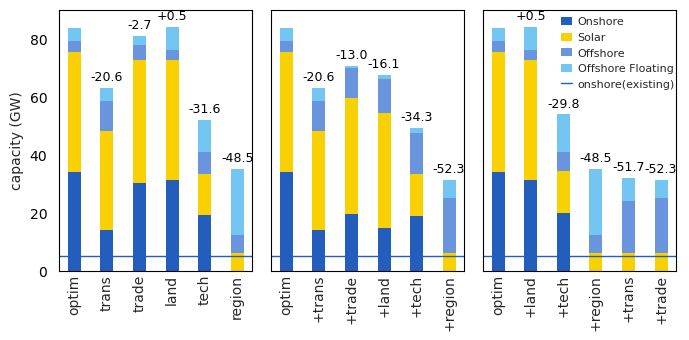

In [245]:
#Plotting the capacities for Ind, trading, regional sceanrios
fig, axes = plt.subplots(1, 3, figsize=(7, 3.5))
#Choose year to plot
years = '2050'
plot_data = [all_cap_plot, all_cap_plot_trade, all_cap_plot_region]

for ax, dataset in zip(axes, plot_data):
    
    year_data = dataset[dataset.index.get_level_values('demandyear') == year]
    bottom = np.zeros(len(year_data))

    scenario_labels = year_data.index.get_level_values('scenarios').unique()
    cumulative_heights = {scenario: np.zeros(len(year_data)) for scenario in scenario_labels}

    #for technology in ['Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore']:
    for technology in ['Windonshore', 'Solar', 'Windoffshore', 'Windoffshorefloating']:
        bars = ax.bar(year_data.index.get_level_values('scenarios'), year_data[technology], width=0.4, 
            bottom=bottom, label=technology, color=colordict[technology], linewidth=0, edgecolor='none')

        for bar, scenario in zip(bars, year_data.index.get_level_values('scenarios')):
            cumulative_heights[scenario] += bar.get_height()
    
        bottom += year_data[technology].values
    
   
    ax.set_ylim(0, 90)
    ax.set_yticks(range(0, 91, 20))
    #ax.set_yticklabels([str(i) for i in range(0, 91, 20)], fontsize=10, color="black")
    ax.grid(False)
    ax.tick_params(axis='x', labelsize=10, rotation=90, pad=-1)
    ax.tick_params(axis='y', labelsize=10, direction='out', length=5, width=2, colors='black')

    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    if ax != axes[0]:  # Remove y-axis tick labels for other plots except the first one
        ax.set_yticklabels([])
    
    optim_total = year_data.loc[year_data.index.get_level_values('scenarios') == 'optim'].sum(axis=1).values[0]
    for scenario in year_data.index.get_level_values('scenarios').unique():
        if scenario != 'optim':
            scenario_total = year_data[year_data.index.get_level_values('scenarios') == scenario].sum(axis=1).values[0]
            difference = scenario_total - optim_total
            bar_index = np.where(year_data.index.get_level_values('scenarios') == scenario)[0][0]
            bar_height = cumulative_heights[scenario][bar_index]
            ax.annotate(f'{difference:+.1f}', xy=(bars[bar_index].get_x() + bars[bar_index].get_width() / 2,
                                                  bar_height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9, color='black')

for ax in axes:
    ax.axhline(y=5, color='#235ebc', linestyle='-', linewidth=1)


axes[0].set_ylabel('capacity (GW)', fontsize=10)
custom_labels = ['Onshore', 'Solar', 'Offshore', 'Offshore Floating', 'onshore(existing)']
handles, _ = axes[0].get_legend_handles_labels()
handles.append(ax.lines[0])
fig.legend(handles, custom_labels, loc='upper center', bbox_to_anchor=(0.89, 0.95), borderaxespad=0., frameon=False, 
           fontsize=8, handlelength=1, handletextpad=0.5)

fig.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_new_2050.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_new_2050.jpg', dpi=300, bbox_inches='tight')

plt.show()
    

    

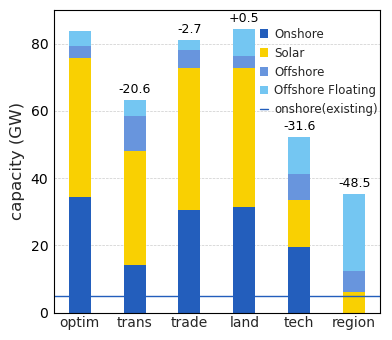

In [266]:
#Plotting the capacities for Ind, trading, regional sceanrios
fig, ax = plt.subplots(figsize=(4, 3.5))
#Choose year to plot
years = '2050'
dataset = all_cap_plot

    
year_data = dataset[dataset.index.get_level_values('demandyear') == year]
bottom = np.zeros(len(year_data))

scenario_labels = year_data.index.get_level_values('scenarios').unique()
cumulative_heights = {scenario: np.zeros(len(year_data)) for scenario in scenario_labels}

    #for technology in ['Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore']:
for technology in ['Windonshore', 'Solar', 'Windoffshore', 'Windoffshorefloating']:
    bars = ax.bar(year_data.index.get_level_values('scenarios'), year_data[technology], width=0.4, 
        bottom=bottom, label=technology, color=colordict[technology], linewidth=0, edgecolor='none')

    for bar, scenario in zip(bars, year_data.index.get_level_values('scenarios')):
            cumulative_heights[scenario] += bar.get_height()
    
    bottom += year_data[technology].values
    
   
ax.set_ylim(0, 90)
ax.set_yticks(range(0, 91, 20))
ax.grid(False)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

ax.tick_params(axis='x', labelsize=10, rotation=0, pad=-1)
ax.tick_params(axis='y', labelsize=10, direction='out', length=5, width=2, colors='black', pad=-1)

for spine in ax.spines.values():
    spine.set_edgecolor('black')

    
optim_total = year_data.loc[year_data.index.get_level_values('scenarios') == 'optim'].sum(axis=1).values[0]
for scenario in year_data.index.get_level_values('scenarios').unique():
    if scenario != 'optim':
        scenario_total = year_data[year_data.index.get_level_values('scenarios') == scenario].sum(axis=1).values[0]
        difference = scenario_total - optim_total
        bar_index = np.where(year_data.index.get_level_values('scenarios') == scenario)[0][0]
        bar_height = cumulative_heights[scenario][bar_index]
        ax.annotate(f'{difference:+.1f}', xy=(bars[bar_index].get_x() + bars[bar_index].get_width() / 2,
                                                  bar_height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9, color='black')

ax.axhline(y=5, color='#235ebc', linestyle='-', linewidth=1)


ax.set_ylabel('capacity (GW)', fontsize=12)
custom_labels = ['Onshore', 'Solar', 'Offshore', 'Offshore Floating', 'onshore(existing)']
handles, _ = ax.get_legend_handles_labels()
handles.append(ax.lines[0])
fig.legend(handles, custom_labels, loc='upper center', bbox_to_anchor=(0.81, 0.92), borderaxespad=0., frameon=False, 
           fontsize=8.5, handlelength=0.7, handletextpad=0.5)

fig.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_2050_posterT.png', dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_new_2050.jpg', dpi=300, bbox_inches='tight')

plt.show()
    

    

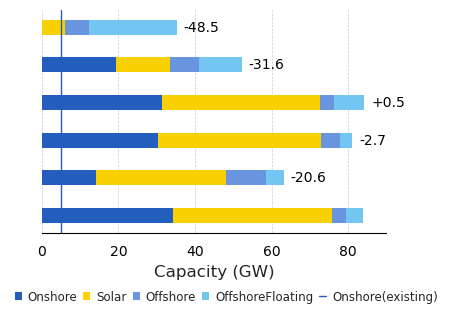

In [396]:
# Plot for poster

#Plotting the capacities for Ind, trading, regional sceanrios
fig, ax = plt.subplots(figsize=(4, 3))
#Choose year to plot
years = '2050'
dataset = all_cap_plot

    
year_data = dataset[dataset.index.get_level_values('demandyear') == year]
left = np.zeros(len(year_data))

scenario_labels = year_data.index.get_level_values('scenarios').unique()
cumulative_widths = {scenario: np.zeros(len(year_data)) for scenario in scenario_labels}

    #for technology in ['Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore']:
for technology in ['Windonshore', 'Solar', 'Windoffshore', 'Windoffshorefloating']:
    bars = ax.barh(year_data.index.get_level_values('scenarios'), year_data[technology], height=0.4, 
        left=left, label=technology, color=colordict[technology], linewidth=0, edgecolor='none')

    for bar, scenario in zip(bars, year_data.index.get_level_values('scenarios')):
            cumulative_widths[scenario] += bar.get_width()
    
    left += year_data[technology].values
    
   
ax.set_xlim(0, 90)
ax.set_xticks(range(0, 91, 20))
ax.grid(False)
ax.grid(True, axis='x', linestyle='--', linewidth=0.5)

#ax.tick_params(axis='y', labelsize=10, rotation=0,)# pad=-1)
ax.tick_params(axis='x', labelsize=10, direction='out', length=5, width=2, colors='black',)# pad=-1)

for spine in ax.spines.values():
    spine.set_edgecolor('Black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

scenario_text = ['Cost optimal', 'Transmission lines', 'Electricity trading', 'Landscape choices', 'Technology preferences', 
                        'Regional preferences']

optim_total = year_data.loc[year_data.index.get_level_values('scenarios') == 'optim'].sum(axis=1).values[0]
for i, scenario in enumerate (year_data.index.get_level_values('scenarios').unique()):
    if scenario != 'optim':
        scenario_total = year_data[year_data.index.get_level_values('scenarios') == scenario].sum(axis=1).values[0]
        difference = scenario_total - optim_total
        #bar_index = np.where(year_data.index.get_level_values('scenarios') == scenario)[0][0]
        bar_width = cumulative_widths[scenario][i]
        ax.annotate(f'{difference:+.1f}', xy=(bar_width, i),
                        xytext=(5, 0), textcoords="offset points", ha='left', va='center', fontsize=10, color='black')

#ax.text(50, 5.45, 'Regional preferences', ha='right', va='center', fontsize=10, fontweight='bold')
#ax.text(55, 4.45, 'Technology preferences', ha='right', va='center', fontsize=10, fontweight='bold')
#ax.text(45, 3.45, 'Landscape choices', ha='right', va='center', fontsize=10, fontweight='bold')
#ax.text(43, 2.45, 'Electricity trading', ha='right', va='center', fontsize=10, fontweight='bold')
#ax.text(43.5, 1.45, 'Transmission lines', ha='right', va='center', fontsize=10, fontweight='bold')
#ax.text(32, 0.45, 'Cost optimal', ha='right', va='center', fontsize=10, fontweight='bold')

ax.axvline(x=5, color='#235ebc', linestyle='-', linewidth=1)

ax.set_yticks([])
ax.set_xlabel('Capacity (GW)', fontsize=12)
custom_labels = ['Onshore', 'Solar', 'Offshore', 'OffshoreFloating', 'Onshore(existing)']
handles, _ = ax.get_legend_handles_labels()
handles.append(ax.lines[0])
fig.legend(handles, custom_labels, loc='upper right', bbox_to_anchor=(1.05, 0.03), ncol=len(custom_labels), borderaxespad=0., frameon=False, 
           fontsize=8.5, handlelength=0.6, handletextpad=0.5, labelspacing=0.1, columnspacing=0.5)

#fig.legend(handles, custom_labels, loc='upper right', bbox_to_anchor=(1.05, 0.95), borderaxespad=0., frameon=False, 
#           fontsize=9.5, handlelength=0.7, handletextpad=0.5)

fig.tight_layout()

plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_2050_posterHTL.png', dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_new_2050.jpg', dpi=300, bbox_inches='tight')

plt.show()



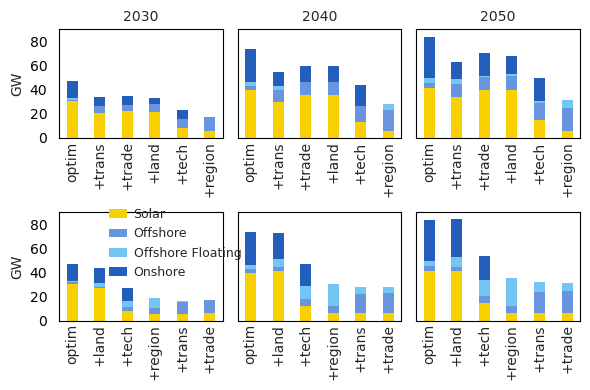

In [852]:
# Create the plot
fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.flatten() 
years = ['2030', '2040', '2050']
plot_data = [all_cap_plot_trade, all_cap_plot_region]

for i, ax in enumerate(axes):
    row_number = i // 3
    col_number = i % 3      
    year = years[col_number]
    dataset = plot_data[row_number]
    
    year_data = dataset[dataset.index.get_level_values('demandyear') == year]
    bottom = np.zeros(len(year_data))
    
    for technology in ['Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore']:
        ax.bar(year_data.index.get_level_values('scenarios'), year_data[technology], width=0.4, 
               bottom=bottom, label=technology, color=colordict[technology], linewidth=0, edgecolor='none')
        bottom += year_data[technology].values
    
    if row_number == 0:
        ax.set_title(f'{year}', fontsize=10)
    
    if col_number == 0:  # Set the y-label only for the first column
        ax.set_ylabel('GW', fontsize=10)    

    
    ax.set_ylim(0, 90)
    ax.set_yticks(range(0, 91, 20))
    ax.grid(False)

    ax.tick_params(axis='x', labelsize=10, rotation=90, pad=-1)
    ax.tick_params(axis='y', labelsize=10, direction='out', length=5, width=2, colors='black')
    if col_number != 0:  # Remove y-axis tick labels for 2nd and 3rd plots
        ax.set_yticklabels([])
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

# Customize the plot
custom_labels = ['Solar', 'Offshore', 'Offshore Floating', 'Onshore']
handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, custom_labels, loc='upper center', bbox_to_anchor=(0.30, 0.48), borderaxespad=0., frameon=False, 
          fontsize=9, handlelength=1.5, handletextpad=0.5)

fig.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_new_allyears.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/capacities_new_allyears.jpg', dpi=300, bbox_inches='tight')



# Demand


In [82]:
# How much demand do we see in each scenario?
dem = makenice(found_scenarios, "demand")

  0%|          | 0/720 [00:00<?, ?it/s]

In [83]:
demandyears = (dem.query("transmission == 'DefaultYes' and fylke_techs == 'fylketechD' and "
              "varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and corines_solar == 'CSD'  and ImpExp == '1'")
               .query("demandyear in ['2030', '2040', '2050']").groupby('demandyear').sum().div(1000))

<AxesSubplot: xlabel='demandyear'>

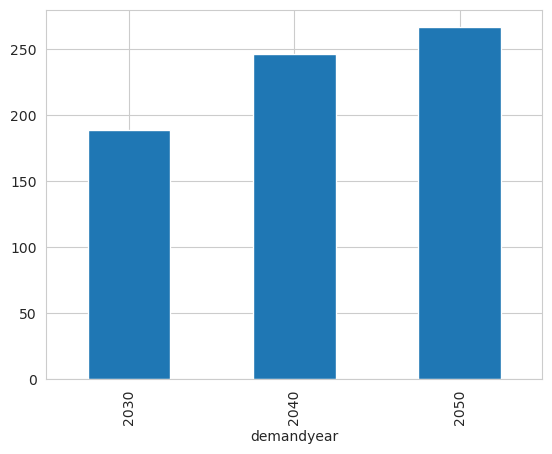

In [270]:
demandyears['value'].plot(kind = 'bar')

In [1406]:
fylke_demand = (dem.query("transmission == 'DefaultYes' and fylke_techs == 'fylketechD' and "
              "varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and corines_solar == 'CSD'  and ImpExp == '1'")
               .query("demandyear in ['2050']").groupby(['demandyear', 'zone']).sum().div(1000))

In [1407]:
fylke_demand

value
demandyear zone           
2050       NO03  16.739944
           NO11  28.438827
           NO15  25.333990
           NO18  23.371044
           NO30  36.418417
           NO34  13.257118
           NO38  24.398412
           NO42  19.922544
           NO46  42.929789
           NO50  20.457088
           NO54  14.960058

In [1409]:
NStatisD = fylke_demand.query("zone== 'NO54' or zone == 'NO18'").sum()
SStatisD = fylke_demand.query("zone== 'NO42'").sum()
EStatisD = fylke_demand.query("zone== 'NO30' or zone == 'NO34' or zone == 'NO03' or zone == 'NO38'").sum()
WStatisD = fylke_demand.query("zone== 'NO46' or zone == 'NO15' or zone == 'NO11'").sum()
CStatisD = fylke_demand.query("zone== 'NO50'").sum()

In [1413]:
(EStatisD+SStatisD)/fylke_demand.sum()

value    0.415947
dtype: float64

In [1415]:
EStatisD

value    90.81389
dtype: float64

# Penalty generation


In [ ]:
# How much penalty generation per scenario?
pgenz = makenice(sqlite_list, "pgenz")

In [ ]:
pgenz  # .plot()
# TODO check if installed capacity is real installed capacity, fix for regional, ignore others
# TODO no offshore

In [ ]:
pgenz  # .plot()
# TODO check if installed capacity is real installed capacity, fix for regional, ignore others
# TODO no offshore

In [ ]:
# TODO check if we have a fixed 30GW scenario as well

In [ ]:
pgenz.groupby(
    ["year","Spatial"]
).sum().sort_values("value")

In [ ]:
barplot(pgenz,logx=True)

In [ ]:
barplot(pgenz)

In [ ]:
barplot(pgenz)
# scale by value of lost load and put on log scale
# integrate pgen with o gen tot
# can offshore be built?

In [ ]:
# Scenariooverview (specify one scenario and get info like):
## Pgen? Imports? Imports max out (when)?

# Generation


In [ ]:
gentot = makenice(sqlite_list, "gentot")
# https://www.duo.uio.no/bitstream/handle/10852/80496/ieee_2020.pdf?sequence=2&isAllowed=y

In [ ]:
gentot

In [ ]:
scale = 1
(
    gentot
    # .query(
    #    "year == '2010'"
    #    #   " & Solar == 'Low'"
    #    "& ((Neigh == 'High' and Solar == 'High') or (Neigh == 'None' and Solar == 'Low'))"
    # )
    .unstack()
    .loc[:, "value"]
    .loc[:, ["Import", "Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    # .sort_values(["Windonshore"])
    .rename(columns={"Windonshore": "OnWind"})
    .plot.barh(
        #stacked=True,
        title="Norwegian electrictiy generation without Hydro 2030",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

# why does it not max out imports is it because the imports only have some access points and pgen can come in all the time and everywher
# change imports to average values of the past
# maybe limit imports to max of historical imports? inspiration from the UK paper. give a paragraph of explanation as to why.
# we can not keep it because there is no realistic scenario for why we would not import at reasonable prices
# TODO add battery in this plot

In [ ]:
scale = 1
(
    gentot
    # .query(
    #    "year == '2010'"
    #    #   " & Solar == 'Low'"
    #    "& ((Neigh == 'High' and Solar == 'High') or (Neigh == 'None' and Solar == 'Low'))"
    # )
    .unstack()
    .loc[:, "value"]
    #.loc[:, ["Import", "Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    # .sort_values(["Windonshore"])
    .rename(columns={"Windonshore": "OnWind"})
    .plot.barh(
        #stacked=True,
        title="Norwegian electrictiy generation without Hydro 2030",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

# why does it not max out imports is it because the imports only have some access points and pgen can come in all the time and everywher
# change imports to average values of the past
# maybe limit imports to max of historical imports? inspiration from the UK paper. give a paragraph of explanation as to why.
# we can not keep it because there is no realistic scenario for why we would not import at reasonable prices
# TODO add battery in this plot

In [ ]:
scale = 1
(
    gentot
    # .query(
    #    "year == '2010'"
    #    #   " & Solar == 'Low'"
    #    "& ((Neigh == 'High' and Solar == 'High') or (Neigh == 'None' and Solar == 'Low'))"
    # )
    .unstack()
    .loc[:, "value"]
    #.loc[:, ["Import", "Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    # .sort_values(["Windonshore"])
    .rename(columns={"Windonshore": "OnWind"})
    .plot.barh(
        #stacked=True,
        title="Norwegian electrictiy generation without Hydro 2030",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

# why does it not max out imports is it because the imports only have some access points and pgen can come in all the time and everywher
# change imports to average values of the past
# maybe limit imports to max of historical imports? inspiration from the UK paper. give a paragraph of explanation as to why.
# we can not keep it because there is no realistic scenario for why we would not import at reasonable prices
# TODO add battery in this plot

In [ ]:
# Is offshore wind forced?
makenice(sqlite_list, "limpcapz").unstack().unstack().unstack().iloc[
    0, :
].to_frame().unstack().query("technology == 'Windoffshore'").T

In [ ]:
# How much import per scenario?
barplot(gentot.query("technology == 'Import'"))

In [ ]:
# how much electricity in the Finse paper is generated from hydro power in the 2010 results
gentot.query("year == '2010' and technology.str.contains('Hydro')").unstack().plot.barh(
    figsize=(10, 10), stacked=True
)

In [ ]:
# How much onshore wind in each regional scenario?
gentot.query("technology == 'Windonshore'").sort_index().plot.barh(
    figsize=(21.533 / scale, 12.582 / scale)
)  # .sort_values("value")

In [ ]:
storage_gen_tot = makenice(sqlite_list, "storage_gen_tot")

## Generation Hourly


In [ ]:
# Hourly generation per zone and technology
gen = makenice(sqlite_list, "gen")

In [ ]:
gen

In [ ]:
gen.to_csv(
    "gen.csv" + compressionfileineding, compression=compressiondict
)  # .to_parquet("costs.parquet")

In [ ]:
# check if variable exists, only if not, run sql

# Storage


In [ ]:
# https://www.elvia.no/drift-og-vedlikehold/utbygginger-og-prosjekter/vi-skal-styrke-stromforsyningen-sor-i-oslo-liasen/
# https://eeg.tuwien.ac.at/conference/iaee2017/files/paper/623_Ovaere_fullpaper_2017-04-01_17-14.pdf table 3

In [166]:
storetot = makenice(found_scenarios, "storage_ecap")

  0%|          | 0/720 [00:00<?, ?it/s]

In [ ]:
storetot = storetot.loc[level_slice]

In [273]:
storetot

storeecaptot
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology               
2030       DefaultNO    2      QS1         CSD           CWDH            fylketechC  Li-ion-8     1.162787e+01
                                                                                     PumpedHydro  3.993910e+02
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  Li-ion-8     5.779117e+01
                                                                                     PumpedHydro  3.993910e+02
2030       DefaultYes   2      QS1         CSD           CWDH            fylketechD  Li-ion-8     3.215699e+01
...                                                                                                        ...
                        1      OPT         CSD           CWDH            fylketechC  PumpedHydro  3.993910e+02
           LOWOH        5      OPT         CSD           CWD             fylketechC  Li-ion-8     3.504635e-07
                                                                                     PumpedHydro  3.993910e+02
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  Li-ion-8     6.514185e+01
                                                                                     PumpedHydro  3.993910e+02

[1440 rows x 1 columns]

In [274]:
store_optim = storetot[(storetot.index.get_level_values('transmission') == 'DefaultYes')&
        (storetot.index.get_level_values('ImpExp') == '1')&
        (storetot.index.get_level_values('varnewpcapQ') == 'OPT')&
        (storetot.index.get_level_values('corines_solar') == 'CSD')&
        (storetot.index.get_level_values('corines_onshore') == 'CWD')&
        (storetot.index.get_level_values('fylke_techs') == 'fylketechD')&
        (storetot.index.get_level_values('technology') == 'Li-ion-8')
]
store_optim=store_optim.reset_index().loc[:,["demandyear", "storeecaptot"]].set_index("demandyear")

In [275]:
store_ImpExp=storetot[(storetot.index.get_level_values('transmission') == 'DefaultYes')&
        (storetot.index.get_level_values('ImpExp').isin(['1', '2', '5']))&
        (storetot.index.get_level_values('varnewpcapQ') == 'OPT')&
        (storetot.index.get_level_values('corines_solar') == 'CSD')&
        (storetot.index.get_level_values('corines_onshore') == 'CWD')&
        (storetot.index.get_level_values('fylke_techs') == 'fylketechD')&
        (storetot.index.get_level_values('demandyear') == '2050')&
        (storetot.index.get_level_values('technology') == 'Li-ion-8')
]
store_ImpExp=store_ImpExp.reset_index().loc[:,["ImpExp", "storeecaptot"]].sort_values(by='ImpExp')

In [276]:
store_trans=storetot[(storetot.index.get_level_values('ImpExp').isin(['1']))&
        (storetot.index.get_level_values('varnewpcapQ') == 'OPT')&
        (storetot.index.get_level_values('corines_solar') == 'CSD')&
        (storetot.index.get_level_values('corines_onshore') == 'CWD')&
        (storetot.index.get_level_values('fylke_techs') == 'fylketechD')&
        (storetot.index.get_level_values('demandyear') == '2050')&
        (storetot.index.get_level_values('technology') == 'Li-ion-8')
]
store_trans=store_trans.reset_index().loc[:,["transmission", "storeecaptot"]].sort_index(ascending=False)
store_trans

transmission  storeecaptot
2   DefaultYes    103.246787
1    DefaultNO     70.449114
0        LOWOH     71.121290

In [277]:
store_tech=storetot[(storetot.index.get_level_values('transmission') == 'DefaultYes')&
        (storetot.index.get_level_values('ImpExp').isin(['1']))&
        (storetot.index.get_level_values('corines_solar') == 'CSD')&
        (storetot.index.get_level_values('corines_onshore') == 'CWD')&
        (storetot.index.get_level_values('fylke_techs') == 'fylketechD')&
        (storetot.index.get_level_values('demandyear') == '2050')&
        (storetot.index.get_level_values('technology') == 'Li-ion-8')
]
store_tech=store_tech.reset_index().loc[:,["varnewpcapQ", "storeecaptot"]].set_index('varnewpcapQ').sort_values(by='varnewpcapQ')
store_tech

storeecaptot
varnewpcapQ              
OPT            103.246787
QS1             97.453446

In [278]:
store_land=storetot[(storetot.index.get_level_values('transmission') == 'DefaultYes')&
        (storetot.index.get_level_values('ImpExp').isin(['1']))&
        (storetot.index.get_level_values('varnewpcapQ') == 'OPT')&
        (storetot.index.get_level_values('corines_solar') == 'CSD')&
        (storetot.index.get_level_values('fylke_techs') == 'fylketechD')&
        (storetot.index.get_level_values('demandyear') == '2050')&
        (storetot.index.get_level_values('technology') == 'Li-ion-8')
]
store_land=store_land.reset_index().loc[:,["corines_onshore", "storeecaptot"]].set_index('corines_onshore').sort_values(by='corines_onshore')

In [279]:
store_region=storetot[(storetot.index.get_level_values('transmission') == 'DefaultYes')&
        (storetot.index.get_level_values('ImpExp').isin(['1']))&
        (storetot.index.get_level_values('varnewpcapQ') == 'OPT')&
        (storetot.index.get_level_values('corines_solar') == 'CSD')&
        (storetot.index.get_level_values('corines_onshore') == 'CWD')&
        (storetot.index.get_level_values('demandyear') == '2050')&
        (storetot.index.get_level_values('technology') == 'Li-ion-8')
]
store_region=store_region.reset_index().loc[:,["fylke_techs", "storeecaptot"]].sort_values(by='fylke_techs', ascending=False)

In [280]:
store_region

fylke_techs  storeecaptot
1  fylketechD    103.246787
0  fylketechC    126.637636

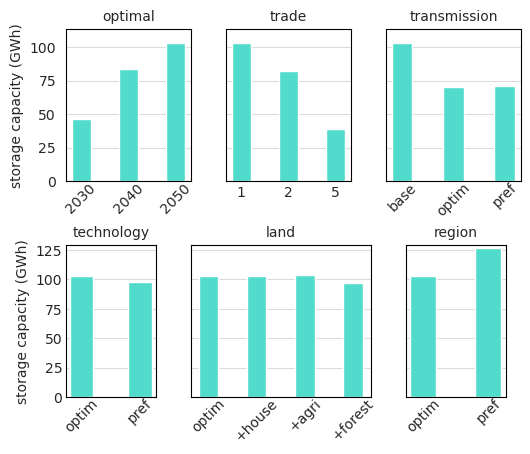

In [856]:
#Storage plot
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8, 4.5))
fig = plt.figure(figsize=(5, 4))

#"Lion": "#baf238",
#"PumpedHydro": "#51dbcc",

# Format: [left, bottom, width, height]
ax1 = fig.add_axes([0.05, 0.57, 0.25, 0.38]) 
ax2 = fig.add_axes([0.37, 0.57, 0.25, 0.38])  
ax3 = fig.add_axes([0.69, 0.57, 0.27, 0.38])  
ax4 = fig.add_axes([0.05, 0.03, 0.18, 0.38]) 
ax5 = fig.add_axes([0.30, 0.03, 0.36, 0.38])  
ax6 = fig.add_axes([0.73, 0.03, 0.20, 0.38])

# Plot 1
categories = store_optim.index
values = store_optim['storeecaptot']
ax1.bar(categories, values, color='#51dbcc', width=0.4)
ax1.set_xticks(categories)
ax1.tick_params(axis='x', labelsize=10, rotation=45, pad=-4)
#ax1.set_xticklabels(categories, ha='center')
ax1.set_ylabel('storage capacity (GWh)', fontsize=10)
ax1.set_ylim(0, max(values) * 1.1)
ax1.set_title('optimal', fontsize=10)
ax1.grid(axis='y', linestyle='-', alpha=0.7)
ax1.grid(axis='x', which='both', linestyle='-', linewidth=0)
for spine in ax1.spines.values():
        spine.set_edgecolor('black')
ax1.grid(False)

# Plot 2
categories = ['1', '2', '5']
values = store_ImpExp['storeecaptot']
ax2.bar(categories, values, color='#51dbcc', width=0.4)
ax2.set_xticks(categories)
ax2.tick_params(axis='x', labelsize=10, rotation=0, pad=0)
ax2.set_xticklabels(categories, ha='center')
ax2.set_yticklabels([])
ax2.set_ylim(0, max(values) * 1.1)
ax2.set_title('trade', fontsize=10)
ax2.grid(axis='y', linestyle='-', alpha=0.7)
ax2.grid(axis='x', which='both', linestyle='-', linewidth=0)
for spine in ax2.spines.values():
        spine.set_edgecolor('black')
ax2.grid(False)

# Plot 3
categories = ['base', 'optim', 'pref']
values = store_trans['storeecaptot']
ax3.bar(categories, values, color='#51dbcc', width=0.4)
ax3.set_xticks(categories)
ax3.tick_params(axis='x', labelsize=10, rotation=45, pad=-4)
ax3.set_yticklabels([])
ax3.set_xticklabels(categories, ha='center')
#ax3.set_ylabel('Storage Capacity')
ax3.set_ylim(0, max(values) * 1.1)
ax3.set_title('transmission', fontsize=10)
ax3.grid(axis='y', linestyle='-', alpha=0.7)
ax3.grid(axis='x', which='both', linestyle='-', linewidth=0)
for spine in ax3.spines.values():
        spine.set_edgecolor('black')
ax3.grid(False)

ylim = int(max(values) * 1.1)
ax1.set_ylim(0, max(values) * 1.1)
ax1.set_yticks(range(0, ylim, 25))
ax2.set_ylim(0, max(values) * 1.1)
ax2.set_yticks(range(0, ylim, 25))
ax3.set_ylim(0, max(values) * 1.1)
ax3.set_yticks(range(0, ylim, 25))
ax1.grid(axis='y', linestyle='-', alpha=0.7)
ax1.grid(axis='x', which='both', linestyle='-', linewidth=0)
ax2.grid(axis='y', linestyle='-', alpha=0.7)
ax2.grid(axis='x', which='both', linestyle='-', linewidth=0)
ax3.grid(axis='y', linestyle='-', alpha=0.7)
ax3.grid(axis='x', which='both', linestyle='-', linewidth=0)


# Plot 4
categories = ['optim', 'pref']
values = store_tech['storeecaptot']
ax4.bar(categories, values, color='#51dbcc', width=0.4)
ax4.set_xticks(categories)
ax4.tick_params(axis='x', labelsize=10, rotation=45, pad=-4)
ax4.tick_params(axis='y', labelsize=10, rotation=0, pad=-1)
#ax4.tick_params(axis='x', which='major')
ax4.set_xticklabels(categories, ha='center')
ax4.set_ylabel('storage capacity (GWh)', fontsize=10)
ax4.set_ylim(0, max(values) * 1.1)
ax4.set_title('technology', fontsize=10)
ax4.grid(axis='y', linestyle='-', alpha=0.7)
ax4.grid(axis='x', which='both', linestyle='-', linewidth=0)
for spine in ax4.spines.values():
        spine.set_edgecolor('black')
ax4.grid(False)

# Plot 5
categories = ['optim', '+house', '+agri', '+forest']
values = store_land['storeecaptot']
ax5.bar(categories, values, color='#51dbcc', width=0.4)
ax5.set_xticks(categories)
#ax5.tick_params(axis='x', which='major')
ax5.set_xticklabels(categories, ha='center')
ax5.tick_params(axis='x', labelsize=10, rotation=45, pad=-4)
ax5.set_yticklabels([])
ylim = int(max(values) * 1.1)
ax5.set_ylim(0, max(values) * 1.1)
ax5.set_yticks(range(0, ylim, 50))
ax5.set_title('land', fontsize=10)
ax5.grid(axis='y', linestyle='-', alpha=0.7)
ax5.grid(axis='x', which='both', linestyle='-', linewidth=0)
for spine in ax5.spines.values():
        spine.set_edgecolor('black')
ax5.grid(False)

# Plot 6
categories = ['optim', 'pref']
values = store_region['storeecaptot']
ax6.bar(categories, values, color='#51dbcc', width=0.4)
ax6.set_xticks(categories)
ax6.tick_params(axis='x', labelsize=10, rotation=45, pad=-4)
#ax6.tick_params(axis='x', which='major')
ax6.set_xticklabels(categories, ha='center')
ax6.set_yticklabels([])
#ax.set_ylim(0, 90)
ylim = int(max(values) * 1.02)
ax6.set_ylim(0, max(values) * 1.02)
ax6.set_yticks(range(0, ylim, 25))
ax6.set_title('region', fontsize=10)
ax6.grid(axis='y', linestyle='-', alpha=0.7)
ax6.grid(axis='x', which='both', linestyle='-', linewidth=0)
for spine in ax6.spines.values():
        spine.set_edgecolor('black')
#ax6.grid(False)

ax4.set_ylim(0, max(values) * 1.02)
ax4.set_yticks(range(0, ylim, 25))
ax5.set_ylim(0, max(values) * 1.02)
ax5.set_yticks(range(0, ylim, 25))
ax5.grid(axis='y', linestyle='-', alpha=0.7)
ax5.grid(axis='x', which='both', linestyle='-', linewidth=0)
ax4.grid(axis='y', linestyle='-', alpha=0.7)
ax4.grid(axis='x', which='both', linestyle='-', linewidth=0)

#fig.tight_layout()  # Adjust the layout so labels don't overlap

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/storageCapNew_scenario.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/storageCapNew_scenario.jpg', dpi=300, bbox_inches='tight')
plt.show()  # Display the plot


In [343]:
filtered_storetot = storetot[(storetot.index.get_level_values('transmission') != 'DefaultNO')&
                      (storetot.index.get_level_values('ImpExp').isin(['1', '2']))&
                      (storetot.index.get_level_values('technology') == 'Li-ion-8')]

filtered_storetot

storeecaptot
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology              
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  Li-ion-8       57.791170
2030       DefaultYes   2      QS1         CSD           CWDH            fylketechD  Li-ion-8       32.156987
                        1      OPT         CSD           CWD             fylketechD  Li-ion-8       46.550819
2050       LOWOH        1      OPT         CSD           CWD             fylketechC  Li-ion-8       89.719108
2040       LOWOH        1      OPT         CSD           CWDHA           fylketechC  Li-ion-8       65.141470
...                                                                                                       ...
                               QS1         CSD           CWD             fylketechC  Li-ion-8       65.140258
2050       DefaultYes   2      QS1         CSD           CWDHAF          fylketechC  Li-ion-8       80.070823
                        1      OPT         CSD           CWD             fylketechD  Li-ion-8      103.246787
2030       DefaultYes   1      OPT         CSD           CWDH            fylketechC  Li-ion-8       33.595926
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  Li-ion-8       65.141854

[192 rows x 1 columns]

In [345]:
storetot_seq_pref_trading = (filtered_storetot.query(seq_query_string_trading)
                  .sort_values(
                      by=['demandyear', 'ImpExp', 'corines_onshore', 'varnewpcapQ', 'transmission','fylke_techs'])) 
def sort_within_group(group_df):
    custom_order = [1,2,3,4,6,5]
    group_df['custom_order'] = custom_order
    scenarios= ['optim', '+trans', '+trade', '+land', '+region', '+tech']
    group_df['scenarios'] = scenarios
    group_df['1st preference'] = ['trading']*6
    return group_df.sort_values(by='custom_order', ascending=True)
storetot_seq_pref_trading = storetot_seq_pref_trading.groupby('demandyear', group_keys=False).apply(sort_within_group)
storetot_seq_pref_trading

storeecaptot  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                 
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8       46.550819   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Li-ion-8       29.925843   
                        2      OPT         CSD           CWD             fylketechD  Li-ion-8       11.700406   
                                                         CWDHAF          fylketechD  Li-ion-8       11.685662   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8        8.547262   
                                                                         fylketechC  Li-ion-8       15.234344   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8       83.912835   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Li-ion-8       63.314980   
                        2      OPT         CSD           CWD             fylketechD  Li-ion-8       48.261802   
                                                         CWDHAF          fylketechD  Li-ion-8       47.771973   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8       39.019076   
                                                                         fylketechC  Li-ion-8       38.973791   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8      103.246787   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Li-ion-8       71.121290   
                        2      OPT         CSD           CWD             fylketechD  Li-ion-8       64.381303   
                                                         CWDHAF          fylketechD  Li-ion-8       65.530611   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8       47.709139   
                                                                         fylketechC  Li-ion-8       51.801944   

                                                                                                 custom_order  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                 
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8               1   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Li-ion-8               2   
                        2      OPT         CSD           CWD             fylketechD  Li-ion-8               3   
                                                         CWDHAF          fylketechD  Li-ion-8               4   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8               5   
                                                                         fylketechC  Li-ion-8               6   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8               1   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Li-ion-8               2   
                        2      OPT         CSD           CWD             fylketechD  Li-ion-8               3   
                                                         CWDHAF          fylketechD  Li-ion-8               4   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8               5   
                                                                         fylketechC  Li-ion-8               6   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8               1   
           LOWOH        1      OPT         CSD           CWD             fylketechD  Li-ion-8               2   
                        2   

In [346]:
storetot_seq_pref_regional2 = (filtered_storetot.query(seq_query_string_regional2)
                  .sort_values(
                      by=['demandyear', 'ImpExp', 'corines_onshore', 'varnewpcapQ', 'transmission','fylke_techs'])) 
def sort_within_group(group_df):
    #scenarios=[ 'optimal', '+landscape','+regional','+technology', '+transmission', '+trading'] # in relation to custom order numbers
    custom_order = [1,2,4,3,5,6]
    #['optim','+land','+tech','+region', '+trans', '+trade'] #original query order
    scenarios= ['optim','+trans', '+land', '+trade', '+tech', '+region'] #order for plotting according to cost_seq_pref_trading
    group_df['custom_order'] = custom_order
    group_df['scenarios'] = scenarios
    group_df['1st preference'] = ['landscape']*6
    return group_df.sort_values(by='custom_order', ascending=True)
storetot_seq_pref_regional2 = storetot_seq_pref_regional2.groupby('demandyear', group_keys=False).apply(sort_within_group)
storetot_seq_pref_regional2

storeecaptot  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                 
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8       46.550819   
                                                         CWDHAF          fylketechD  Li-ion-8       41.492373   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8       35.499152   
                                                                         fylketechC  Li-ion-8       33.494242   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  Li-ion-8       30.417235   
                        2      QS1         CSD           CWDHAF          fylketechC  Li-ion-8       15.234344   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8       83.912835   
                                                         CWDHAF          fylketechD  Li-ion-8       83.163523   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8       60.798594   
                                                                         fylketechC  Li-ion-8       78.837855   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  Li-ion-8       65.141571   
                        2      QS1         CSD           CWDHAF          fylketechC  Li-ion-8       38.973791   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8      103.246787   
                                                         CWDHAF          fylketechD  Li-ion-8       97.204658   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8       92.345664   
                                                                         fylketechC  Li-ion-8      126.637636   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  Li-ion-8       89.721259   
                        2      QS1         CSD           CWDHAF          fylketechC  Li-ion-8       51.801944   

                                                                                                 custom_order  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs technology                 
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8               1   
                                                         CWDHAF          fylketechD  Li-ion-8               2   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8               3   
                                                                         fylketechC  Li-ion-8               4   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  Li-ion-8               5   
                        2      QS1         CSD           CWDHAF          fylketechC  Li-ion-8               6   
2040       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8               1   
                                                         CWDHAF          fylketechD  Li-ion-8               2   
                               QS1         CSD           CWDHAF          fylketechD  Li-ion-8               3   
                                                                         fylketechC  Li-ion-8               4   
           LOWOH        1      QS1         CSD           CWDHAF          fylketechC  Li-ion-8               5   
                        2      QS1         CSD           CWDHAF          fylketechC  Li-ion-8               6   
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  Li-ion-8               1   
                                                         CWDHAF          fylketechD  Li-ion-8               2   
                            

In [347]:
storetot_seq_pref_trading = storetot_seq_pref_trading.reset_index()
storetot_seq_pref_regional2 = storetot_seq_pref_regional2.reset_index()
df_storetot = pd.concat([storetot_seq_pref_trading, storetot_seq_pref_regional2], ignore_index=True)

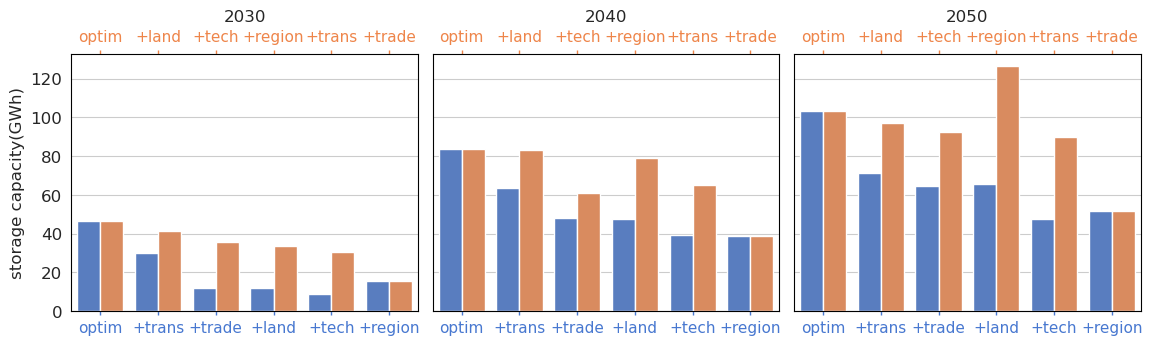

In [1137]:
palette = {
    'trading': sns.color_palette('muted')[0],
    'landscape': sns.color_palette('muted')[1]
}

g = sns.catplot(
    data=df_storetot, x='scenarios', y='storeecaptot', hue='1st preference',
    col='demandyear', kind='bar', height=3.5, aspect=1.1,
    palette=palette, legend_out=False, errorbar=None
)
g.set_titles("{col_name}", fontsize=12)

g.set_axis_labels("", "storage capacity(GWh)", fontsize=12)


#g.add_legend(title='1st preference', loc='upper left', borderaxespad=0., frameon=False, 
#          fontsize=10, handlelength=1.5, handletextpad=0.5)
g.legend.remove()


for ax in g.axes.flat:
    #ax.set_xticks(range(len(scenario_labels)))
    ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)

    top_ax = ax.secondary_xaxis('top')
    scenario_labels =['optim', '+land', '+tech', '+region', '+trans', '+trade']
    top_ax.set_xticks(range(len(scenario_labels)))
    top_ax.set_xticklabels(scenario_labels)
    top_ax.tick_params(axis='x', colors=palette['landscape'], direction='out', length=3, width=1, labelsize=11)
    top_ax.spines['top'].set_color('black')
    ax.spines['right'].set_visible(True)

    b_ax = ax.secondary_xaxis('bottom')
    b_ax.set_xticks(range(len(scenario_labels)))
    b_ax.set_xticklabels(['' for _ in b_ax.get_xticks()])
    b_ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)

    ax.set_title(ax.get_title(), fontsize=12)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=12, direction='out', length=3, width=1)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/storageCapNew_allyears.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/storageCapNew_allyears.jpg', dpi=300, bbox_inches='tight')
plt.show()

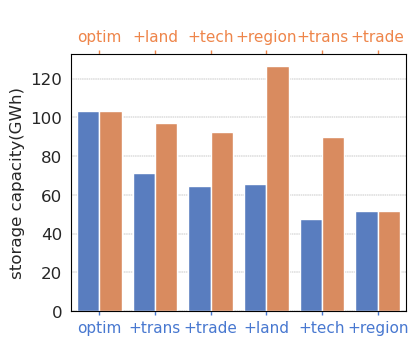

In [1226]:
#only for the given demand year

df_storetot_2050 = df_storetot[df_storetot['demandyear'] == '2050']

palette = {
    'trading': sns.color_palette('muted')[0],
    'landscape': sns.color_palette('muted')[1]
}

g = sns.catplot(
    data=df_storetot_2050, x='scenarios', y='storeecaptot', hue='1st preference',
    col='demandyear', kind='bar', height=3.5, aspect=1.2,
    palette=palette, legend_out=False, errorbar=None
)
g.set_titles(" ", fontsize=12)

g.set_axis_labels("", "storage capacity(GWh)", fontsize=12)


g.legend.remove()


for ax in g.axes.flat:
    #ax.set_xticks(range(len(scenario_labels)))
    ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)

    top_ax = ax.secondary_xaxis('top')
    scenario_labels =['optim', '+land', '+tech', '+region', '+trans', '+trade']
    top_ax.set_xticks(range(len(scenario_labels)))
    top_ax.set_xticklabels(scenario_labels)
    top_ax.tick_params(axis='x', colors=palette['landscape'], direction='out', length=3, width=1, labelsize=11)
    top_ax.spines['top'].set_color('black')
    ax.spines['right'].set_visible(True)

    b_ax = ax.secondary_xaxis('bottom')
    b_ax.set_xticks(range(len(scenario_labels)))
    b_ax.set_xticklabels(['' for _ in b_ax.get_xticks()])
    b_ax.tick_params(axis='x', colors=palette['trading'], direction='out', length=3, width=1)

    ax.set_title(ax.get_title(), fontsize=12)

    ax.grid(which='major', axis='y', linestyle='--', linewidth=0.3, color='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=12, direction='out', length=3, width=1)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/storageCapNew_2050.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/storageCapNew_2050.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#timespan beocmes important to conisder the impact of given preference. For instance, regional preference will be
#challenging for 2050 compared to 2040 where land prefennce is driving the needed storage capacity

In [975]:
storetotZ = makenice(found_scenarios, "store_totecap_z")

  0%|          | 0/720 [00:00<?, ?it/s]

In [976]:
storetotZ

storecaptot
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs zone technology  level_2                
2030       DefaultNO    2      QS1         CSD           CWDH            fylketechC  NO03 Li-ion-8    level      4.599218e+00
                                                                                                      lo         0.000000e+00
                                                                                                      marginal   0.000000e+00
                                                                                                      up        1.000000e+100
                                                                                          PumpedHydro level      0.000000e+00
...                                                                                                                       ...
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  NO54 Li-ion-8    up        1.000000e+100
                                                                                          PumpedHydro level      0.000000e+00
                                                                                                      lo         0.000000e+00
                                                                                                      marginal   0.000000e+00
                                                                                                      up         0.000000e+00

[63360 rows x 1 columns]

In [993]:
storetotZ_Lion = storetotZ.droplevel(["corines_solar"]).loc[(slice(None), slice(None), slice(None), slice(None), slice(None),
                                          slice(None), slice(None),
                                          ['Li-ion-8'], 'level')].droplevel("level_2")

In [994]:
filtered_storetotZ_Lion= storetotZ_Lion[(storetotZ_Lion.index.get_level_values('transmission') != 'DefaultNO')&
                      (storetotZ_Lion.index.get_level_values('ImpExp').isin(['1', '2']))]

In [995]:
storetotZ_Ind_pref=filtered_storetotZ_Lion.query(Ind_query_string_2)

In [996]:
storetotZ_Ind_pref

storecaptot
demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs zone technology              
2030       DefaultYes   1      OPT         CWD             fylketechD  NO03 Li-ion-8    7.426757e+00
                                                                       NO11 Li-ion-8    1.471247e-07
                                                                       NO15 Li-ion-8    1.354046e-05
                                                                       NO18 Li-ion-8    2.222062e-07
                                                                       NO30 Li-ion-8    2.565226e+01
...                                                                                              ...
2050       DefaultYes   1      OPT         CWD             fylketechD  NO38 Li-ion-8    7.773242e+00
                                                                       NO42 Li-ion-8    8.165844e-06
                                                                       NO46 Li-ion-8    5.159523e-05
                                                                       NO50 Li-ion-8    9.631763e+00
                                                                       NO54 Li-ion-8    9.529139e+00

[198 rows x 1 columns]

In [997]:
scenario_dict = { #for independent preferences scenarios
    ('DefaultYes', '1', 'OPT', 'CWD', 'fylketechD'): {'scenario': 'optim', 'order': 1},
    ('LOWOH', '1', 'OPT', 'CWD', 'fylketechD'): {'scenario': 'trans', 'order': 2},
    ('DefaultYes', '2', 'OPT', 'CWD', 'fylketechD'): {'scenario': 'trade', 'order': 3},
    ('DefaultYes', '1', 'OPT', 'CWDHAF', 'fylketechD'): {'scenario': 'land', 'order': 4},
    ('DefaultYes', '1', 'QS1', 'CWD', 'fylketechD'): {'scenario': 'tech', 'order': 5},
    ('DefaultYes', '1', 'OPT', 'CWD', 'fylketechC'): {'scenario': 'region', 'order': 6}    
}
def map_scenario(row):
    scenario_key = tuple(row[['transmission', 'ImpExp', 'varnewpcapQ', 'corines_onshore', 'fylke_techs']])
    scenario_info = scenario_dict.get(scenario_key, {'scenario': 'Unknown Scenario', 'order': -1})
    return pd.Series([scenario_info['scenario'], scenario_info['order']], 
                     index=['Scenario Name', 'Scenario Index'])
AA = storetotZ_Ind_pref.reset_index().apply(map_scenario, axis=1)
storetotZ_Ind_pref = pd.concat([storetotZ_Ind_pref.reset_index(), AA], axis=1)

In [1001]:
storetotZ_Ind_pref = (storetotZ_Ind_pref.drop(columns=["transmission", "ImpExp", "varnewpcapQ",
                    "corines_onshore", "fylke_techs"]))


In [ ]:
storetotZ_Ind_pref['normalize'] = np.sqrt(storetotZ_Ind_pref['storecaptot'] / storetotZ_Ind_pref['storecaptot'].max())

In [1070]:
grouped = storetotZ_Ind_pref.groupby(['demandyear', 'Scenario Name'])
storetotZ_Ind_pref['normalized'] = grouped['storecaptot'].transform(lambda x: np.sqrt(x / x.max()))
storetotZ_Ind_pref                                     

demandyear  zone technology   storecaptot Scenario Name  Scenario Index  \
0         2030  NO03   Li-ion-8  7.426757e+00         optim               1   
1         2030  NO11   Li-ion-8  1.471247e-07         optim               1   
2         2030  NO15   Li-ion-8  1.354046e-05         optim               1   
3         2030  NO18   Li-ion-8  2.222062e-07         optim               1   
4         2030  NO30   Li-ion-8  2.565226e+01         optim               1   
..         ...   ...        ...           ...           ...             ...   
193       2050  NO38   Li-ion-8  7.773242e+00         optim               1   
194       2050  NO42   Li-ion-8  8.165844e-06         optim               1   
195       2050  NO46   Li-ion-8  5.159523e-05         optim               1   
196       2050  NO50   Li-ion-8  9.631763e+00         optim               1   
197       2050  NO54   Li-ion-8  9.529139e+00         optim               1   

     normalized  
0      0.538068  
1      0.000076  
2      0.000727  
3      0.000093  
4      1.000000  
..          ...  
193    0.369916  
194    0.000379  
195    0.000953  
196    0.411770  
197    0.409571  

[198 rows x 7 columns]

In [1074]:
storetotZ_Ind_pref[(storetotZ_Ind_pref['demandyear'] == '2050') & 
                    (storetotZ_Ind_pref['Scenario Name'] == 'optim')]

demandyear  zone technology  storecaptot Scenario Name  Scenario Index  \
187       2050  NO03   Li-ion-8    10.113636         optim               1   
188       2050  NO11   Li-ion-8     0.000008         optim               1   
189       2050  NO15   Li-ion-8     0.083785         optim               1   
190       2050  NO18   Li-ion-8     0.000043         optim               1   
191       2050  NO30   Li-ion-8    56.806208         optim               1   
192       2050  NO34   Li-ion-8     9.308904         optim               1   
193       2050  NO38   Li-ion-8     7.773242         optim               1   
194       2050  NO42   Li-ion-8     0.000008         optim               1   
195       2050  NO46   Li-ion-8     0.000052         optim               1   
196       2050  NO50   Li-ion-8     9.631763         optim               1   
197       2050  NO54   Li-ion-8     9.529139         optim               1   

     normalized  
187    0.421945  
188    0.000370  
189    0.038405  
190    0.000872  
191    1.000000  
192    0.404810  
193    0.369916  
194    0.000379  
195    0.000953  
196    0.411770  
197    0.409571

In [1042]:
optim_2050['piesize'] = np.sqrt(optim_2050['storecaptot'] / optim_2050['storecaptot'].max()) * 1000

/tmp/ipykernel_1600841/4108092195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optim_2050['piesize'] = np.sqrt(optim_2050['storecaptot'] / optim_2050['storecaptot'].max()) * 1000


In [1077]:
Norway

name  \
NO03                  Oslo   
NO11              Rogaland   
NO15       Møre og Romsdal   
NO18              Nordland   
NO30                 Viken   
NO34             Innlandet   
NO38  Vestfold og Telemark   
NO42                 Agder   
NO46              Vestland   
NO50             Trøndelag   
NO54     Troms og Finnmark   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
Norway.plot(ax=ax, column='available_area_proportion', cmap='Greens', legend=False)
cmap = plt.get_cmap('Greens')
    norm = plt.Normalize(vmin=Norway['available_area_proportion'].min(), 
                         vmax=Norway['available_area_proportion'].max())
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale, orientation='vertical')
    cb.set_label('available area proportion', fontsize=10)
    new_ticks = [0.05, 0.15, 0.25]
    cb.set_ticks(new_ticks)
    cb.outline.set_visible(False)
    cb.ax.tick_params(length=2)

In [1174]:
Norway['existing_hydro_ecap']

NO03      0.000
NO11    324.950
NO15      0.000
NO18      0.000
NO30      0.000
NO34      0.000
NO38      0.000
NO42      0.000
NO46     65.452
NO50      8.987
NO54      0.000
Name: existing_hydro_ecap, dtype: float64

/tmp/ipykernel_1600841/1551748612.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = Norway.centroid
/tmp/ipykernel_1600841/1551748612.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


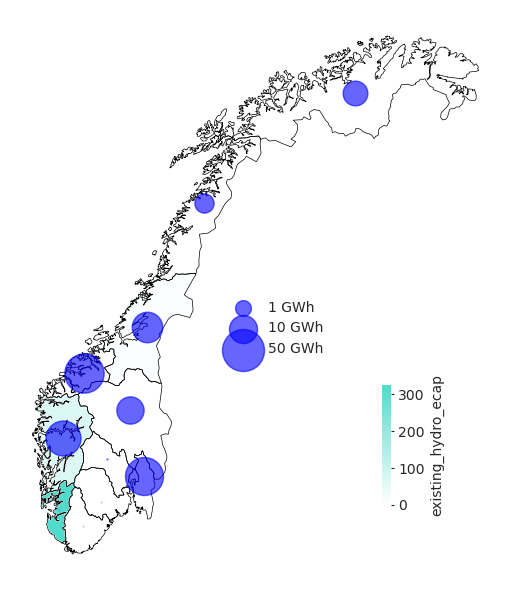

In [1185]:
#plot storage

df = storetotZ_Ind_pref[(storetotZ_Ind_pref['demandyear'] == '2050') & 
                    (storetotZ_Ind_pref['Scenario Name'] == 'region')]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list("custom_cmap", ['white', '#51dbcc'])
Norway.plot(ax=ax, column='existing_hydro_ecap', cmap=cmap)
Norway.boundary.plot(ax=ax, linewidth=0.5, color='black', zorder=1)

#cmap = plt.get_cmap('Greens')
ax_color_scale = fig.add_axes([0.71, 0.15, 0.015, 0.2])
norm = plt.Normalize(vmin=Norway['existing_hydro_ecap'].min(), 
                         vmax=Norway['existing_hydro_ecap'].max())
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale, orientation='vertical')
cb.set_label('existing_hydro_ecap', fontsize=10)
new_ticks = [0, 100, 200, 300]
cb.set_ticks(new_ticks)
cb.outline.set_visible(False)
cb.ax.tick_params(length=2)


max_size = 800

centroids = Norway.centroid

offset_dict = {
    'NO42': [0, 0],
    'NO03': [0.6, 0],
    'NO54': [0, 0],
    'NO15': [0, 0],
    'NO38': [0, -0.2],
    'NO50': [0, 0],
    'NO11': [0, 0],
    'NO34': [0, 0.2],
    'NO30': [-0.8, 0.3],
    'NO18': [0, 0],
    'NO46': [0, 0],
}


# Create circles at each zone's centroid
for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
    #zone = row['zone']
    plotdata = df[df['zone'] == i]
    size = plotdata['normalized'].iloc[0]*max_size
    value = plotdata['storecaptot'].iloc[0]
    offset_x, offset_y = offset_dict[i]
    if size > 0:  # Only plot if there's storage capacity
        ax.scatter(
            centroids.x[i]+offset_x,
            centroids.y[i]+offset_y,
            s=size,
            alpha=0.6,
            color="blue",
            zorder=1
        )
ax.axis('off')

# Add a legend with size reference
legend_elements = [
    plt.scatter([], [], s=np.sqrt(x/df['storecaptot'].max()) * max_size, 
                color='blue', alpha=0.6, label=f'{x:.0f} GWh')
    for x in [1, 10, 50]  # Reference values for legend
]
ax.legend(handles=legend_elements, 
         borderaxespad=0,frameon=False,fontsize=10, 
         bbox_to_anchor=(0.65, 0.5))

plt.tight_layout()
plt.show()


/tmp/ipykernel_1600841/1285939278.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = Norway.centroid
/tmp/ipykernel_1600841/1285939278.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


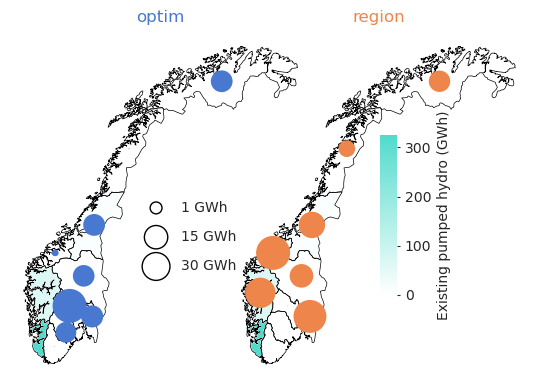

In [1215]:
#plot storage

df = storetotZ_Ind_pref[(storetotZ_Ind_pref['demandyear'] == '2050')]

fig, axes = plt.subplots(1, 2, figsize=(5.5, 4))
fig.subplots_adjust(wspace=-0.5, left=0.15, right=0.75, top=0.5, bottom=0.15)

cmap = LinearSegmentedColormap.from_list("custom_cmap", ['white', '#51dbcc'])

for ax in axes:
    Norway.plot(ax=ax, column='existing_hydro_ecap', cmap=cmap)
    Norway.boundary.plot(ax=ax, linewidth=0.5, color='black', zorder=1)
    ax.axis('off')

centroids = Norway.centroid

offset_dict = {
    'NO42': [0, 0],
    'NO03': [0.6, 0],
    'NO54': [0, 0],
    'NO15': [0, 0],
    'NO38': [0, -0.2],
    'NO50': [0, 0],
    'NO11': [0, 0],
    'NO34': [0, 0.2],
    'NO30': [-0.8, 0.3],
    'NO18': [0, 0],
    'NO46': [0, 0],
}

max_size = 600

palette = {
    'optim': sns.color_palette('muted')[0],
    'region': sns.color_palette('muted')[1]
}


for i, scenario in enumerate(['optim', 'region']):
    ax = axes[i]
    data = df[df['Scenario Name'] == scenario]
    tot_store = [data['storecaptot'].sum()]
    ax.set_title(scenario, color=palette[scenario])
    for z in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
        plotdata = data[data['zone'] == z]
        size = plotdata['normalized'].iloc[0]*max_size
        value = plotdata['storecaptot'].iloc[0]        
        offset_x, offset_y = offset_dict[z]
        if size > 0:  # Only plot if there's storage capacity
            ax.scatter(
                centroids.x[z]+offset_x,
                centroids.y[z]+offset_y,
                s=size,
                alpha=0.6,
                color=palette[scenario],
                edgecolor='none',
                zorder=1
                )


# Add a legend with size reference
legend_elements = [
    plt.scatter([], [], s=np.sqrt(x/df['storecaptot'].max()) * max_size, 
                color='none', edgecolor='black', label=f'{x:.0f} GWh')
    for x in [1, 15, 30]  # Reference values for legend
]
fig.legend(handles=legend_elements, 
         borderaxespad=0,frameon=False,fontsize=10, 
         bbox_to_anchor=(0.45, 0.5), ncol=1, labelspacing=1.1)


ax_color_scale = fig.add_axes([0.7, 0.25, 0.032, 0.4])
norm = plt.Normalize(vmin=Norway['existing_hydro_ecap'].min(), 
                         vmax=Norway['existing_hydro_ecap'].max())
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale, orientation='vertical')
cb.set_label('Existing pumped hydro (GWh)', fontsize=10)
new_ticks = [0, 100, 200, 300]
cb.set_ticks(new_ticks)
cb.outline.set_visible(False)
cb.ax.tick_params(length=2)


plt.tight_layout()
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/store_ecap_zonal1.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/store_ecap_zonal1.jpg', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_1600841/2981025323.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = Norway.centroid
/tmp/ipykernel_1600841/2981025323.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


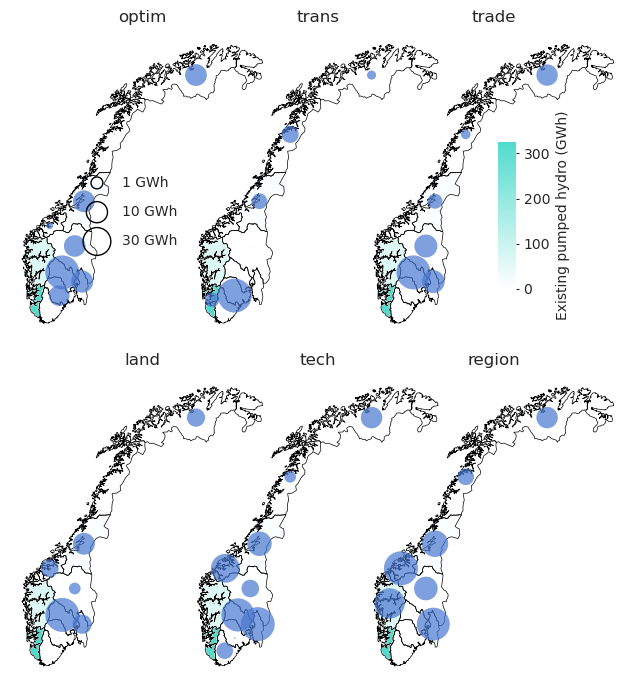

In [1248]:
#plot storage

df = storetotZ_Ind_pref[(storetotZ_Ind_pref['demandyear'] == '2050')]

fig, axes = plt.subplots(2, 3, figsize=(9, 7))
fig.subplots_adjust(wspace=-0.8, left=0.15, right=0.75, top=0.3, bottom=0.2)
axes = axes.flatten()

cmap = LinearSegmentedColormap.from_list("custom_cmap", ['white', '#51dbcc'])

for ax in axes:
    Norway.plot(ax=ax, column='existing_hydro_ecap', cmap=cmap)
    Norway.boundary.plot(ax=ax, linewidth=0.5, color='black', zorder=1)
    ax.axis('off')

centroids = Norway.centroid

offset_dict = {
    'NO42': [0, 0],
    'NO03': [0.6, 0],
    'NO54': [0, 0],
    'NO15': [0, 0],
    'NO38': [0, -0.2],
    'NO50': [0, 0],
    'NO11': [0, 0],
    'NO34': [0, 0.2],
    'NO30': [-0.8, 0.3],
    'NO18': [0, 0],
    'NO46': [0, 0],
}

max_size = 600

palette = {
    'optim': sns.color_palette('muted')[0],
    'region': sns.color_palette('muted')[1]
}
0.7


for i, scenario in enumerate(['optim', 'trans', 'trade', 'land', 'tech', 'region']):
    ax = axes[i]
    data = df[df['Scenario Name'] == scenario]
    tot_store = [data['storecaptot'].sum()]
    ax.set_title(scenario)
    for z in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
        plotdata = data[data['zone'] == z]
        size = plotdata['normalized'].iloc[0]*max_size
        value = plotdata['storecaptot'].iloc[0]        
        offset_x, offset_y = offset_dict[z]
        if size > 0:  # Only plot if there's storage capacity
            ax.scatter(
                centroids.x[z]+offset_x,
                centroids.y[z]+offset_y,
                s=size,
                alpha=0.7,
                color=palette['optim'],
                edgecolor='none',
                zorder=1
                )


# Add a legend with size reference
legend_elements = [
    plt.scatter([], [], s=np.sqrt(x/df['storecaptot'].max()) * max_size, 
                color='none', edgecolor='black', label=f'{x:.0f} GWh')
    for x in [1, 10, 30]  # Reference values for legend
]
fig.legend(handles=legend_elements, 
         borderaxespad=0,frameon=False,fontsize=10, 
         bbox_to_anchor=(0.35, 0.75), ncol=1, labelspacing=1.1)

ax_color_scale = fig.add_axes([0.7, 0.58, 0.02, 0.21])
norm = plt.Normalize(vmin=Norway['existing_hydro_ecap'].min(), 
                         vmax=Norway['existing_hydro_ecap'].max())
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale, orientation='vertical')
cb.set_label('Existing pumped hydro (GWh)', fontsize=10)
new_ticks = [0, 100, 200, 300]
cb.set_ticks(new_ticks)
cb.outline.set_visible(False)
cb.ax.tick_params(length=2)




plt.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/store_ecap_zonal2.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/store_ecap_zonal2.jpg', dpi=300, bbox_inches='tight')

plt.show()

In [1012]:
Norway

# How are the costs composed?


In [ ]:
# Investment vs Operation
costsgencapex = makenice(sqlite_list, "costsgencapex")

In [168]:
costcomponents = [
    "costsgencapex",
    "costsgenfom",
    "costsgenvarom",
    "costsstorecapex",
    "costsstorefom",
    "costsstorevarom",
    "coststranscapex",
    "coststransfom",
]
concatlist = []
for costcomponent in tqdm(costcomponents):
    concatlist.append(makenice(found_scenarios, costcomponent))
costsc = pd.concat(concatlist, axis=1)
#del concatlist

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

In [366]:
costsc.index.names

FrozenList(['demandyear', 'transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs', 'zone', 'level_1'])

In [367]:
costsc = costsc.loc[level_slice]

In [373]:
filtered_costsc = costsc[(costsc.index.get_level_values('transmission') != 'DefaultNO')&
                      (costsc.index.get_level_values('ImpExp').isin(['1', '2']))                      
]
filtered_costsc

costsgencapex  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs zone                  
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  NO03      20.119520   
                                                                                     NO11     383.536698   
                                                                                     NO15     149.581644   
                                                                                     NO18      44.333977   
                                                                                     NO30     112.749789   
...                                                                                                  ...   
           LOWOH        1      OPT         CSD           CWDHAF          fylketechC  NO38      14.180660   
                                                                                     NO42    1324.527222   
                                                                                     NO46      10.443394   
                                                                                     NO50       9.704996   
                                                                                     NO54    1156.768913   

                                                                                           costsgenfom  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs zone                
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  NO03     4.295807   
                                                                                     NO11   421.709172   
                                                                                     NO15   164.012503   
                                                                                     NO18   191.738009   
                                                                                     NO30   203.825023   
...                                                                                                ...   
           LOWOH        1      OPT         CSD           CWDHAF          fylketechC  NO38   114.390025   
                                                                                     NO42  1042.660373   
                                                                                     NO46   384.116141   
                                                                                     NO50    81.648381   
                                                                                     NO54   830.911605   

                                                                                           costsgenvarom  \
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs zone                  
2040       DefaultYes   2      QS1         CSD           CWDHA           fylketechC  NO03       0.833772   
                                                                                     NO11   -5843.774533   
                                                                                     NO15      22.323296   
                                                                                     NO18    7984.944413   
                                                                                     NO30   22854.913755   
...                                                                                                  ...   
           LOWOH        1      OPT         CSD           CWDHAF          fylketechC  NO38      20.648414   
                                                                                     NO42  -15086.117837   
                                                                                     NO46    6611.313203   
                                                                                     NO50    4265.689770   
           

In [374]:
filtered_costsc.groupby(
        ['transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']
    ).ngroup()

demandyear  transmission  ImpExp  varnewpcapQ  corines_solar  corines_onshore  fylke_techs  zone
2040        DefaultYes    2       QS1          CSD            CWDHA            fylketechC   NO03    28
                                                                                            NO11    28
                                                                                            NO15    28
                                                                                            NO18    28
                                                                                            NO30    28
                                                                                                    ..
            LOWOH         1       OPT          CSD            CWDHAF           fylketechC   NO38    38
                                                                                            NO42    38
                                                                               

In [377]:
#Sequnce: [ 'Optimal', '+transmission','+trading', '+landscape', '+technology', '+regional']
def assign_scenario_id(group):
    group['scenario_id'] = group.groupby(
        ['transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']
    ).ngroup()
    return group

def sort_within_group(group_df):
    id_to_scenario_name = {
        0: 'region',
        1: 'optim',
        2: 'land',
        3: 'tech',
        4: 'trade',
        5: 'trans'
    }    
    scenario_to_custom_order = {
        'optim': 1,
        'trans': 2,
        'trade': 3,
        'land': 4,
        'tech': 5,
        'region': 6
    }    

    group_df['scenarios'] = group_df['scenario_id'].map(id_to_scenario_name)
    group_df['custom_order'] = group_df['scenarios'].map(scenario_to_custom_order)
    return group_df.sort_values(by='custom_order', ascending=True)
    return group_df

AA = filtered_costsc.index.names[:-1]
costsc_Ind_pref = (filtered_costsc.query(Ind_query_string_2).groupby(level=AA).sum())

costsc_Ind_pref['costsgenom'] = costsc_Ind_pref['costsgenfom'] + costsc_Ind_pref['costsgenvarom']
costsc_Ind_pref['costsstoreom'] = costsc_Ind_pref['costsstorefom'] + costsc_Ind_pref['costsstorevarom']
costsc_Ind_pref = (costsc_Ind_pref.drop(columns=["costsgenfom", "costsgenvarom", "costsstorefom", "costsstorevarom"])
                   .sort_values(by=sort_columns_list))
costsc_Ind_pref = costsc_Ind_pref.groupby('demandyear', group_keys=False).apply(assign_scenario_id)
costsc_Ind_pref = costsc_Ind_pref.groupby('demandyear', group_keys=False).apply(sort_within_group)
costsc_Ind_pref = (costsc_Ind_pref.droplevel(["transmission", "ImpExp", "varnewpcapQ", "corines_solar", "corines_onshore", "fylke_techs"])
                   .set_index(['scenario_id', 'custom_order', 'scenarios'], append=True))
costsc_Ind_pref = (
    costsc_Ind_pref
    .assign(**{
        col + "_percent": costsc_Ind_pref.apply(lambda row: row[col] / row.sum() * 100, axis=1)
        for col in costsc_Ind_pref.columns
    })
)    
costsc_Ind_pref

costsgencapex  costsstorecapex  \
demandyear scenario_id custom_order scenarios                                   
2030       1           1            optim        2102.818642       486.171467   
           5           2            trans        1719.964628       312.542105   
           4           3            trade        1917.591282       416.758927   
           2           4            land         2277.490267       433.341627   
           3           5            tech         2125.997293       407.415386   
           0           6            region       2280.615798       350.872031   
2040       1           1            optim        3839.713891       876.376110   
           5           2            trans        3283.942484       661.254451   
           4           3            trade        3586.040784       741.769682   
           2           4            land         4140.706678       868.550385   
           3           5            tech         3881.282566       828.581685   
           0           6            region       4332.593500       823.373058   
2050       1           1            optim        4562.704670      1078.297712   
           5           2            trans        3907.793239       742.782673   
           4           3            trade        4264.962831       855.542601   
           2           4            land         5017.874562      1015.194406   
           3           5            tech         4646.605758      1017.792715   
           0           6            region       5187.186076      1322.589080   

                                               coststranscapex  coststransfom  \
demandyear scenario_id custom_order scenarios                                   
2030       1           1            optim           215.108550       4.302171   
           5           2            trans           263.882390       5.277648   
           4           3            trade           215.108550       4.302171   
           2           4            land            215.108550       4.302171   
           3           5            tech            215.108550       4.302171   
           0           6            region          215.108550       4.302171   
2040       1           1            optim           215.108550       4.302171   
           5           2            trans           355.379407       7.107588   
           4           3            trade           215.108550       4.302171   
           2           4            land            215.108550       4.302171   
           3           5            tech            215.108550       4.302171   
           0           6            region          215.108550       4.302171   
2050       1           1            optim           215.108550       4.302171   
           5           2            trans           433.045048       8.660901   
           4           3            trade           215.108550       4.302171   
           2           4            land            215.108550       4.302171   
           3           5            tech            215.108550       4.302171   
           0           6            region          215.108550       4.302171   

                                                costsgenom  costsstoreom  \
demandyear scenario_id custom_order scenarios                              
2030       1           1            optim      2564.329832     72.760747   
           5           2            trans      2533.811484     63.950731   
           4           3            trade      2523.799596     67.628362   
           2           4            land       2750.871273     69.168169   
           3           5            tech       2934.883135     67.014476   
           0           6            region     3271.591805     64.135542   
2040       1           1            optim      3488.844860    102.175190   
           5           2            trans      3520.384721     90.323834   
           4           3            trade    

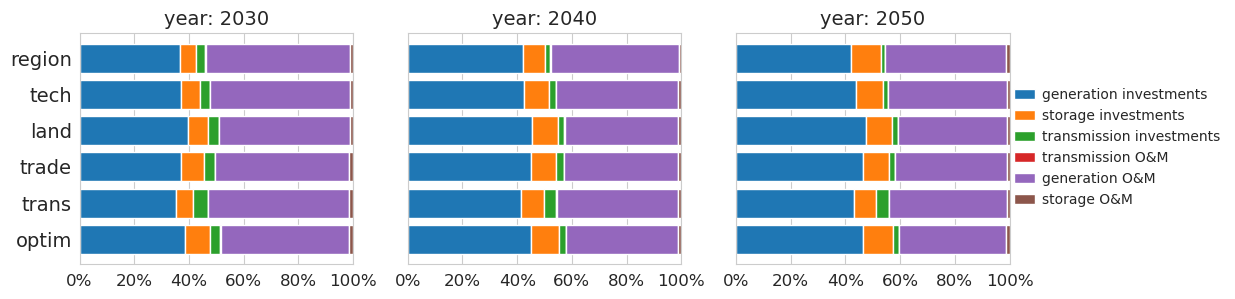

In [407]:
#Plot
percent_columns = ['costsgencapex_percent', 'costsstorecapex_percent', 'coststranscapex_percent',
                   'coststransfom_percent', 'costsgenom_percent', 'costsstoreom_percent']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
#fig.suptitle('Cost Percentages by Scenario for Each Demand Year', fontsize=16)

for idx, year in enumerate(['2030', '2040', '2050']):
    ax = axes[idx]
    data = costsc_Ind_pref.loc[year].sort_values('custom_order')
    
    bottom = np.zeros(len(data))
    
    for i, col in enumerate(percent_columns):
        ax.barh(data.index.get_level_values('scenarios'), data[col], left=bottom, color=colors[i])
        bottom += data[col]

    ax.set_title(f'year: {year}', fontsize=14)
    if idx == 0:
        #ax.set_ylabel('Scenarios', fontsize=14)
        ax.tick_params(axis='y', labelsize=14)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        
    ax.set_xlim(0, 100)
    ax.set_xticks(range(0, 101, 20))
    ax.set_xticklabels([f'{x}%' for x in range(0, 101, 20)], fontsize=12)

custom_labels = ['generation investments', 'storage investments', 'transmission investments',
                 'transmission O&M', 'generation O&M', 'storage O&M']

# Create a list of patch objects with the same colors as the bars
legend_handles = [Patch(facecolor=colors[i], label=label) for i, label in enumerate(custom_labels)]

#handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles = legend_handles, loc='center right', bbox_to_anchor=(1.08, 0.5), borderaxespad=0., frameon=False, 
          fontsize=10, handlelength=1.5, handletextpad=0.5)

plt.show()



In [ ]:
# Despite total costs of region scenario are high, landscape scenarios has the highest generation investments due to landscape
# reduction in the suitbale area available for RE installations.

In [382]:
# sequential preferences plotting for costs composition with trading
def assign_scenario_id(group):
    group['scenario_id'] = group.groupby(
        ['transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']
    ).ngroup()
    return group

def sort_within_group(group_df):
    id_to_scenario_name = {
        0: 'optim',
        1: '+trans',
        2: '+trade',
        3: '+land',
        4: '+region',
        5: '+tech'
    }    
    scenario_to_custom_order = {
        'optim': 1,
        '+trans': 2,
        '+trade': 3,
        '+land': 4,
        '+tech': 5,
        '+region': 6
    }    

    group_df['scenarios'] = group_df['scenario_id'].map(id_to_scenario_name)
    group_df['custom_order'] = group_df['scenarios'].map(scenario_to_custom_order)
    return group_df.sort_values(by='custom_order', ascending=True)
    return group_df

AA = filtered_costsc.index.names[:-1]
costsc_seq_pref_trading = (filtered_costsc.query(seq_query_string_trading).groupby(level=AA).sum())

costsc_seq_pref_trading['costsgenom'] = costsc_seq_pref_trading['costsgenfom'] + costsc_seq_pref_trading['costsgenvarom']
costsc_seq_pref_trading['costsstoreom'] = costsc_seq_pref_trading['costsstorefom'] + costsc_seq_pref_trading['costsstorevarom']
costsc_seq_pref_trading = (costsc_seq_pref_trading.drop(columns=["costsgenfom", "costsgenvarom", "costsstorefom", "costsstorevarom"])
                   .sort_values(by=sort_columns_list))
costsc_seq_pref_trading = costsc_seq_pref_trading.groupby('demandyear', group_keys=False).apply(assign_scenario_id)
costsc_seq_pref_trading = costsc_seq_pref_trading.groupby('demandyear', group_keys=False).apply(sort_within_group)
costsc_seq_pref_trading = (costsc_seq_pref_trading.droplevel(["transmission", "ImpExp", "varnewpcapQ", "corines_solar", "corines_onshore", "fylke_techs"])
                   .set_index(['scenario_id', 'custom_order', 'scenarios'], append=True))
costsc_seq_pref_trading = (
    costsc_seq_pref_trading
    .assign(**{
        col + "_percent": costsc_seq_pref_trading.apply(lambda row: row[col] / row.sum() * 100, axis=1)
        for col in costsc_seq_pref_trading.columns
    })
)    
costsc_seq_pref_trading



costsgencapex  costsstorecapex  \
demandyear scenario_id custom_order scenarios                                   
2030       0           1            optim        2102.818642       486.171467   
           1           2            +trans       1719.964628       312.542105   
           2           3            +trade       1712.422020       122.197711   
           3           4            +land        1691.633222       122.043725   
           5           5            +tech        1647.825260        89.266631   
           4           6            +region      1539.234161       159.105754   
2040       0           1            optim        3839.713891       876.376110   
           1           2            +trans       3283.942484       661.254451   
           2           3            +trade       3094.139249       504.040781   
           3           4            +land        3090.466780       498.925062   
           5           5            +tech        3103.098279       407.510794   
           4           6            +region      3116.230286       407.037843   
2050       0           1            optim        4562.704670      1078.297712   
           1           2            +trans       3907.793239       742.782673   
           2           3            +trade       3731.048597       672.391015   
           3           4            +land        3672.636905       684.394252   
           5           5            +tech        3716.206510       498.268822   
           4           6            +region      3683.178629       541.013615   

                                               coststranscapex  coststransfom  \
demandyear scenario_id custom_order scenarios                                   
2030       0           1            optim           215.108550       4.302171   
           1           2            +trans          263.882390       5.277648   
           2           3            +trade          268.530653       5.370613   
           3           4            +land           267.259577       5.345192   
           5           5            +tech           280.657782       5.613156   
           4           6            +region         297.491999       5.949840   
2040       0           1            optim           215.108550       4.302171   
           1           2            +trans          355.379407       7.107588   
           2           3            +trade          309.678590       6.193572   
           3           4            +land           311.750188       6.235004   
           5           5            +tech           341.991002       6.839820   
           4           6            +region         359.978317       7.199566   
2050       0           1            optim           215.108550       4.302171   
           1           2            +trans          433.045048       8.660901   
           2           3            +trade          340.129700       6.802594   
           3           4            +land           334.324572       6.686491   
           5           5            +tech           378.689573       7.573791   
           4           6            +region         410.404356       8.208087   

                                                costsgenom  costsstoreom  \
demandyear scenario_id custom_order scenarios                              
2030       0           1            optim      2564.329832     72.760747   
           1           2            +trans     2533.811484     63.950731   
           2           3            +trade     2518.047860     46.081673   
           3           4            +land      2538.798699     46.737973   
           5           5            +tech      2655.511157     42.574561   
           4           6            +region    2729.251078     48.132990   
2040       0           1            optim      3488.844860    102.175190   
           1           2            +trans     3520.384721     90.323834   
           2           3            +trade   

In [384]:
# sequential preferences plotting for capacities with regional
def assign_scenario_id(group):
    group['scenario_id'] = group.groupby(
        ['transmission', 'ImpExp', 'varnewpcapQ', 'corines_solar', 'corines_onshore', 'fylke_techs']
    ).ngroup()
    return group

def sort_within_group(group_df):
    id_to_scenario_name = {
        0: 'optim',
        1: '+land',
        2: '+region',
        3: '+tech',
        4: '+trans',
        5: '+trade'
    }    
    scenario_to_custom_order = {
        'optim': 1,
        '+land': 2,
        '+tech': 3,
        '+region': 4,
        '+trans': 5,
        '+trade': 6
    }    

    group_df['scenarios'] = group_df['scenario_id'].map(id_to_scenario_name)
    group_df['custom_order'] = group_df['scenarios'].map(scenario_to_custom_order)
    return group_df.sort_values(by='custom_order', ascending=True)
    return group_df

AA = filtered_costsc.index.names[:-1]
costsc_seq_pref_regional = (filtered_costsc.query(seq_query_string_regional2).groupby(level=AA).sum())

costsc_seq_pref_regional['costsgenom'] = costsc_seq_pref_regional['costsgenfom'] + costsc_seq_pref_regional['costsgenvarom']
costsc_seq_pref_regional['costsstoreom'] = costsc_seq_pref_regional['costsstorefom'] + costsc_seq_pref_regional['costsstorevarom']
costsc_seq_pref_regional = (costsc_seq_pref_regional.drop(columns=["costsgenfom", "costsgenvarom", "costsstorefom", "costsstorevarom"])
                   .sort_values(by=sort_columns_list))
costsc_seq_pref_regional = costsc_seq_pref_regional.groupby('demandyear', group_keys=False).apply(assign_scenario_id)
costsc_seq_pref_regional = costsc_seq_pref_regional.groupby('demandyear', group_keys=False).apply(sort_within_group)
costsc_seq_pref_regional = (costsc_seq_pref_regional.droplevel(["transmission", "ImpExp", "varnewpcapQ", "corines_solar", "corines_onshore", "fylke_techs"])
                   .set_index(['scenario_id', 'custom_order', 'scenarios'], append=True))
costsc_seq_pref_regional = (
    costsc_seq_pref_regional
    .assign(**{
        col + "_percent": costsc_seq_pref_regional.apply(lambda row: row[col] / row.sum() * 100, axis=1)
        for col in costsc_seq_pref_regional.columns
    })
)    
costsc_seq_pref_regional

costsgencapex  costsstorecapex  \
demandyear scenario_id custom_order scenarios                                   
2030       0           1            optim        2102.818642       486.171467   
           1           2            +land        2277.490267       433.341627   
           3           3            +tech        2228.320477       370.749105   
           2           4            +region      2283.615804       349.810054   
           4           5            +trans       1596.728146       317.674147   
           5           6            +trade       1539.234161       159.105754   
2040       0           1            optim        3839.713891       876.376110   
           1           2            +land        4140.706678       868.550385   
           3           3            +tech        4185.212943       634.973607   
           2           4            +region      4332.593150       823.373600   
           4           5            +trans       3245.856672       680.331167   
           5           6            +trade       3116.230286       407.037843   
2050       0           1            optim        4562.704670      1078.297712   
           1           2            +land        5017.874562      1015.194406   
           3           3            +tech        4911.525842       964.447617   
           2           4            +region      5187.186081      1322.589082   
           4           5            +trans       3851.187890       937.038635   
           5           6            +trade       3683.178629       541.013615   

                                               coststranscapex  coststransfom  \
demandyear scenario_id custom_order scenarios                                   
2030       0           1            optim           215.108550       4.302171   
           1           2            +land           215.108550       4.302171   
           3           3            +tech           215.108550       4.302171   
           2           4            +region         215.108550       4.302171   
           4           5            +trans          298.197744       5.963955   
           5           6            +trade          297.491999       5.949840   
2040       0           1            optim           215.108550       4.302171   
           1           2            +land           215.108550       4.302171   
           3           3            +tech           215.108550       4.302171   
           2           4            +region         215.108550       4.302171   
           4           5            +trans          397.816464       7.956329   
           5           6            +trade          359.978317       7.199566   
2050       0           1            optim           215.108550       4.302171   
           1           2            +land           215.108550       4.302171   
           3           3            +tech           215.108550       4.302171   
           2           4            +region         215.108550       4.302171   
           4           5            +trans          431.834456       8.636689   
           5           6            +trade          410.404356       8.208087   

                                                costsgenom  costsstoreom  \
demandyear scenario_id custom_order scenarios                              
2030       0           1            optim      2564.329832     72.760747   
           1           2            +land      2750.871273     69.168169   
           3           3            +tech      2993.083166     65.510330   
           2           4            +region    3277.838277     63.989275   
           4           5            +trans     2783.373886     60.571958   
           5           6            +trade     2729.251078     48.132990   
2040       0           1            optim      3488.844860    102.175190   
           1           2            +land      3788.268757    103.229120   
           3           3            +tech    

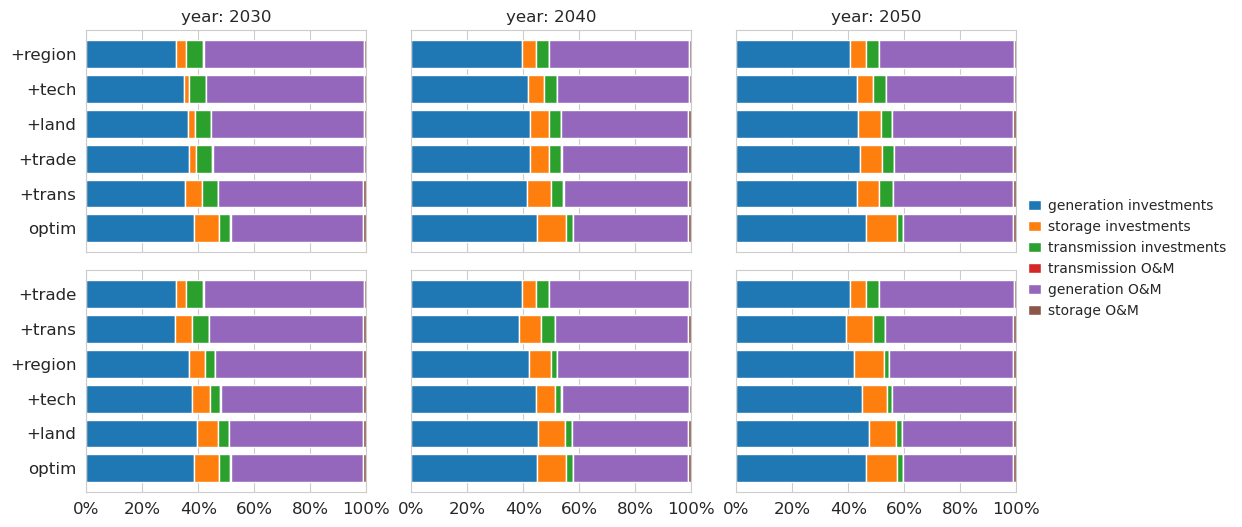

In [823]:
#plot: trading versus regional
percent_columns = ['costsgencapex_percent', 'costsstorecapex_percent', 'coststranscapex_percent',
                   'coststransfom_percent', 'costsgenom_percent', 'costsstoreom_percent']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)  # 2x3 subplots
plt.subplots_adjust(wspace=0.16, hspace=0.08)

years = ['2030', '2040', '2050']
for i in range(2):  # Loop over the rows of subplots
    for j in range(3):  # Loop over the columns/years of subplots
        ax = axes[i, j]
        year = years[j]
        if i == 0:
            data = costsc_seq_pref_trading.loc[year]  # Assuming costsc_Ind_pref is already sorted as required
        else:
            data = costsc_seq_pref_regional.loc[year]

        bottom = np.zeros(len(data))
        for k, col in enumerate(percent_columns):
            ax.barh(data.index.get_level_values('scenarios'), data[col], left=bottom, color=colors[k], height=0.8)
            bottom += data[col]

        # Set labels and formats
        if i == 0:
            ax.set_title(f'year: {year}', fontsize=12)
        if j == 0:  # First column shows the scenario labels
            ax.tick_params(axis='y', labelsize=12)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            
        ax.set_xlim(0, 100)
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticklabels([f'{x}%' for x in range(0, 101, 20)], fontsize=12)

# Custom legend labels
custom_labels = ['generation investments', 'storage investments', 'transmission investments',
                 'transmission O&M', 'generation O&M', 'storage O&M']

legend_handles = [Patch(facecolor=colors[i], label=label) for i, label in enumerate(custom_labels)]
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.08, 0.5), borderaxespad=0., frameon=False,
           fontsize=10, handlelength=1, handletextpad=0.5)

#plt.tight_layout(rect=[0, 0, 0.915, 0.8])  # Adjust if necessary

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/costs_composition_allyears.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/costs_composition_allyears.jpg', dpi=300, bbox_inches='tight')

plt.show()

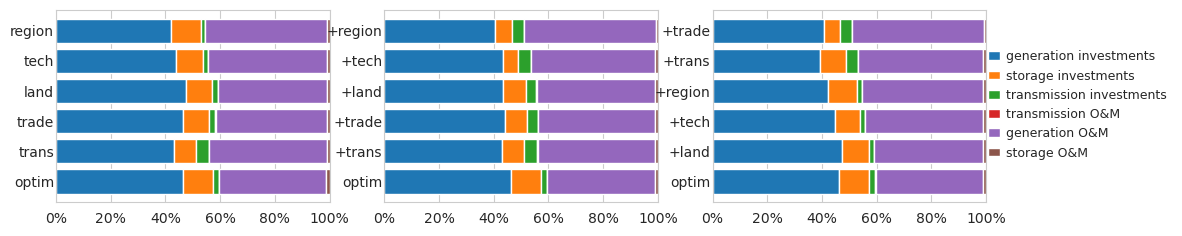

In [776]:
#Plot for cost composition for 2050 for all
percent_columns = ['costsgencapex_percent', 'costsstorecapex_percent', 'coststranscapex_percent',
                   'coststransfom_percent', 'costsgenom_percent', 'costsstoreom_percent']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

dataframes = [costsc_Ind_pref, costsc_seq_pref_trading, costsc_seq_pref_regional]

year = '2050'

fig, axes = plt.subplots(1, 3, figsize=(12, 2.5), sharex=True)
#fig.subplots_adjust(left=0.07, right=0.85, top=0.95, bottom=0.1, hspace=0.15, wspace=0)
#fig.suptitle('Cost Percentages by Scenario for Each Demand Year', fontsize=16)

for ax, dataframe in zip(axes, dataframes):
    #ax = axes[idx]
    data = dataframe.loc[year].sort_values('custom_order')
    
    bottom = np.zeros(len(data))
    
    for i, col in enumerate(percent_columns):
        ax.barh(data.index.get_level_values('scenarios'), data[col], left=bottom, color=colors[i], height=0.8)
        bottom += data[col]

    #ax.set_title(f'year: {year}', fontsize=14)
    #if idx == 0:
        #ax.set_ylabel('Scenarios', fontsize=14)
    ax.tick_params(axis='y', labelsize=10, pad = -2)
    #else:
    ax.set_ylabel('')
    #ax.set_yticklabels([])
        
    ax.set_xlim(0, 100)
    ax.set_xticks(range(0, 101, 20))
    ax.set_xticklabels([f'{x}%' for x in range(0, 101, 20)], fontsize=10)

custom_labels = ['generation investments', 'storage investments', 'transmission investments',
                 'transmission O&M', 'generation O&M', 'storage O&M']

# Create a list of patch objects with the same colors as the bars
legend_handles = [Patch(facecolor=colors[i], label=label) for i, label in enumerate(custom_labels)]

#handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles = legend_handles, loc='center right', bbox_to_anchor=(1.055, 0.5), borderaxespad=0., frameon=False, 
          fontsize=9, handlelength=1, handletextpad=0.5)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/costs_composition.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/costs_composition.jpg', dpi=300, bbox_inches='tight')


plt.show()



In [ ]:
(
    costsc.query(
        "level_1 == 'level'"
        "and Neigh != 'High'"
        " and Spatial == 'grid' and year == '2010' and Solar == 'High'"
    )
    .droplevel("level_1")
    .stack()
    .unstack(-2)
    .sum(axis=1)
    .unstack()
    .T.assign(mean=lambda df: df.mean(axis=1))
    .sort_values(by="mean", ascending=False)
    .drop(columns="mean")
    .T.plot.barh(grid=True, stacked=True, figsize=(19, 10))
)
# Plot only the change between the low restriction case and the other in both relative and absolute terms as well as what I called distribution

In [ ]:
# TODO: why is there 7 pgen in 4none high grid 0?

### Storage Energy Capacity


In [ ]:
# see if this can be done with list comprehension
e_cap_dfs = []
for scenario in tqdm(sqlite_list):
    if pathlib.Path(scenario).is_file():
        con = sqlite3.connect(scenario)
        e_cap_dfs.append(
            pd.read_sql_query("SELECT * from var_tot_store_ecap", con)
            # .set_index("g")
            # .rename(
            #    {
            #        "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            #        "NaturalgasOCGTnew": "Gas",
            #        "Windonshore": "OnWind",
            #    },
            #    axis="index",
            # )
            # .loc[:, ["level"]]
            # .rename_axis(index={"g": "Technology"})
            # .rename(columns={"level": "installed_capacity_GW"})
            # .assign(scenario=scenario[64:-11])
            # .reset_index()
            # .set_index(["scenario", "Technology"])
            # .sort_index()
        )
        con.close()
e_cap2 = pd.concat(e_cap_dfs)
del e_cap_dfs

In [ ]:
e_cap2

### Storage power capacity


In [ ]:
storage_pcap = makenice(sqlite_list, "storage_pcap")

In [ ]:
storage_pcap

In [ ]:
# FX the RoR
# Dispatch (when is the pgen used)
# aggregate to national dispatch, plot demand and pgen and see when pgen happens
# random 500 hours

In [ ]:
scale = 1
(
    p_cap2.reindex(
        p_cap2.groupby(["scenario"]).sum().sort_index()
        # .sort_values("installed_capacity_GW")
        .index.to_list(),
        level=0,
    )
    .unstack()
    .loc[:, "installed_capacity_GW"]
    .plot.barh(
        stacked=True,
        title="Norwegian installed generation capacity 2030 (Weather year/Nature_Fauna_Sami_Neighbours_Solar)",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)
# plt.savefig("output.svg", bbox_inches="tight")
# fig = plot.get_figure()
# fig.savefig("output.svg")

# is there a cutoff now?
# drop the grid.

In [ ]:
(p_cap2.unstack().loc[:, "installed_capacity_GW"])

In [ ]:
# get rid of the left three bars
scale = 1
(
    p_cap2
    # .reindex(
    #    p_cap2.groupby(["scenario"])
    #    .sum()
    #    #.sort_index()
    #    .sort_values("installed_capacity_GW")
    #    .index.to_list(),
    #    level=0,
    # )
    .unstack()
    .loc[:, "installed_capacity_GW"]
    .loc[:, ["Gas", "GasCCS", "OnWind", "Solar", "Windoffshore"]]
    .plot.bar(
        stacked=True,
        title="Norwegian installed generation capacity (without hydro) 2030 (Weather year/Nature_Fauna_Sami_Neighbours_Solar)",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

In [ ]:
# build a small scenario table
# Why no batteries? Costs?

In [ ]:
# Have a (REGIONAL) run with no wind at all for non extreme ones.

In [ ]:
# Existing wind does not produce cause it has no area
# One of them could be the baseline (none scenario/todays system)

In [ ]:
# Why does Hydro RoR change?
# Why is there still wind in the extreme cases?
# What is the storage situation like?

In [ ]:
p_cap2.assign(scen=lambda df: df.index.get_level_values(0).str[64:-11])

In [ ]:
scen

In [ ]:
pd.read_parquet(
    "/cluster/work/projects/ec85/joint-wind/model-aggregated/results/models/1995/corrected_wind_capacity_factors_1995.parquet"
)

## Total generation capacity


In [ ]:
pcaptot = pd.concat(
    [
        storage_pcap.rename(columns={"storepcaptot": "pcaptot"}),
        caps.rename(columns={"gencaptot": "pcaptot"}),
    ],
    axis=0,
).sort_index()

In [ ]:
(
    pcaptot.query(
        "level_1 == 'level' and year == '2010' and Spatial== 'grid' and Solar == 'High'"
    )
    .droplevel(["level_1", "year", "Spatial", "Solar", "Cutoff"])
    .unstack()
    .loc[:, "pcaptot"]
    .rename(
        columns={
            "Li-ion-8": "Lion",
            "Windonshore": "OnWind",
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        }
    )
    .plot.barh(
        stacked=True,
        title="Norwegian installed generation capacity 2030 (Weather year/Nature_Fauna_Sami_Neighbours_Solar)",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
        # subplots=True
    )
)
# Go into the appendix with the "real optimum" show the "realistic optimum" in the main text

# Do delta plots going up and down plot 4 applied energy

In [ ]:
# How much new transmission is there?

In [ ]:
(
    storetot.query("level_1 == 'level'")
    .droplevel("level_1")
    .unstack()
    .loc[:, "storepcaptot"]
    # .loc[:,["Import","Solar","Windoffshore","Windonshore"]]
    # .sort_values(["Windonshore"])
    # .rename(columns={"Windonshore":"OnWind"})
    .plot.barh(
        stacked=True,
        title="Norwegian electrictiy storage power capcacity 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        # color=colordict
    )
)

# scatterplot pv correlation with battery

In [ ]:
storetot

# Map plots


In [84]:
shapefile = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')
world = gpd.read_file(shapefile)
Norway = world[world.iso_a2=="NO"]
Norway = Norway[["iso_3166_2","name","geometry"]]
Norway = Norway.set_index('iso_3166_2').drop(['NO-21', 'NO-X01~'])
#Norway.plot()

/tmp/ipykernel_483994/3163468554.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  Nordland = gpd.GeoDataFrame([{'name':'Nordland', 'geometry':Norway.loc[['NO-18']].explode().drop(('NO-18',25)).unary_union}], index=['NO-18'])


<AxesSubplot: >

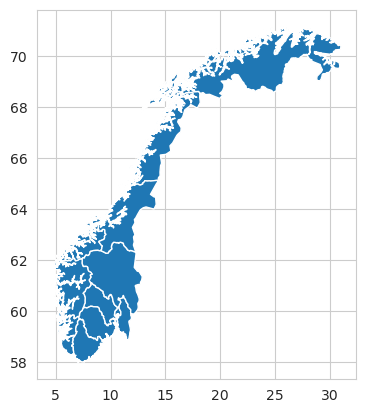

In [85]:
Trøndelag = gpd.GeoDataFrame([{'name':'Trøndelag', 'geometry':Norway.loc[['NO-17', 'NO-16']].unary_union}], index=['NO-50'])
TromsFinnmark = gpd.GeoDataFrame([{'name':'Troms og Finnmark', 'geometry':Norway.loc[['NO-19', 'NO-20']].unary_union}], index=['NO-54'])
Vestland = gpd.GeoDataFrame([{'name':'Vestland', 'geometry':Norway.loc[['NO-12', 'NO-14']].unary_union}], index=['NO-46'])
Viken = gpd.GeoDataFrame([{'name':'Viken', 'geometry':Norway.loc[['NO-02', 'NO-06', 'NO-01']].unary_union}], index=['NO-30'])
Innlandet = gpd.GeoDataFrame([{'name':'Innlandet', 'geometry':Norway.loc[['NO-04', 'NO-05']].unary_union}], index=['NO-34'])
VestfoldTelemark = gpd.GeoDataFrame([{'name':'Vestfold og Telemark', 'geometry':Norway.loc[['NO-07', 'NO-08']].unary_union}], index=['NO-38'])
Agder = gpd.GeoDataFrame([{'name':'Agder', 'geometry':Norway.loc[['NO-09', 'NO-10']].unary_union}], index=['NO-42'])
Nordland = gpd.GeoDataFrame([{'name':'Nordland', 'geometry':Norway.loc[['NO-18']].explode().drop(('NO-18',25)).unary_union}], index=['NO-18'])

Norway = Norway.drop(['NO-17', 'NO-16', 'NO-19', 'NO-20', 'NO-12', 'NO-14', 'NO-02', 'NO-06',
                          'NO-01', 'NO-04', 'NO-05', 'NO-07', 'NO-08', 'NO-09', 'NO-10', 'NO-18'])
Norway = pd.concat([Norway, Trøndelag.set_crs(Norway.crs), TromsFinnmark.set_crs(Norway.crs),
                    Vestland.set_crs(Norway.crs), Viken.set_crs(Norway.crs), Innlandet.set_crs(Norway.crs),
                    VestfoldTelemark.set_crs(Norway.crs), Agder.set_crs(Norway.crs), Nordland.set_crs(Norway.crs)])
Norway = Norway.sort_index()
Norway.plot()

In [86]:
available_areas_propotion = {
    'NO-42': (0.085288, 0.456396), 'NO-11': (0.172801, 0.257466), 'NO-38': (0.088886, 0.575092),
    'NO-30': (0.093058, 0.671340), 'NO-46': (0.288490, 0.228834), 'NO-15': (0.193538, 0.219766),
    'NO-03': (0.028767, 0.622211), 'NO-34': (0.235504, 0.546463), 'NO-50': (0.149781, 0.311010),
    'NO-18': (0.199754, 0.160889), 'NO-54': (0.273903, 0.189083) 
}
Norway['available_area_proportion'] = Norway.index.map(lambda x: available_areas_propotion.get(x, (None, None))[0])
Norway['disagree_area_proportion'] = Norway.index.map(lambda x: available_areas_propotion.get(x, (None, None))[1])

In [87]:
Norway.index = Norway.index.str.replace('-', '')
Norway

name                                           geometry  \
NO03                  Oslo  POLYGON ((10.75660 59.84416, 10.75847 59.85017...   
NO11              Rogaland  MULTIPOLYGON (((6.39763 58.27300, 6.34752 58.2...   
NO15       Møre og Romsdal  MULTIPOLYGON (((5.46168 62.00674, 5.46803 62.0...   
NO18              Nordland  MULTIPOLYGON (((12.06373 65.04560, 12.07594 65...   
NO30                 Viken  MULTIPOLYGON (((11.08302 59.07730, 11.08237 59...   
NO34             Innlandet  POLYGON ((11.16219 60.62149, 11.12638 60.59852...   
NO38  Vestfold og Telemark  POLYGON ((10.28443 59.69571, 10.29721 59.69180...   
NO42                 Agder  POLYGON ((8.22250 58.15168, 8.22242 58.14012, ...   
NO46              Vestland  MULTIPOLYGON (((5.05714 60.19367, 5.05437 60.2...   
NO50             Trøndelag  MULTIPOLYGON (((12.09330 62.90743, 12.09702 62...   
NO54     Troms og Finnmark  MULTIPOLYGON (((15.89796 68.91743, 15.90455 68...   

      available_area_proportion  disagree_area_proportion  
NO03                   0.028767                  0.622211  
NO11                   0.172801                  0.257466  
NO15                   0.193538                  0.219766  
NO18                   0.199754                  0.160889  
NO30                   0.093058                  0.671340  
NO34                   0.235504                  0.546463  
NO38                   0.088886                  0.575092  
NO42                   0.085288                  0.456396  
NO46                   0.288490                  0.228834  
NO50                   0.149781                  0.311010  
NO54                   0.273903                  0.189083

In [88]:
existing_hydro_ecap = {
    'NO42': (0), 'NO11': (324.95), 'NO38': (0),
    'NO30': (0), 'NO46': (65.452), 'NO15': (0),
    'NO03': (0), 'NO34': (0), 'NO50': (8.987),
    'NO18': (0), 'NO54': (0) 
}
Norway['existing_hydro_ecap'] = Norway.index.map(lambda x: existing_hydro_ecap.get(x, None))


In [89]:
captotz = makenice(found_scenarios, "cap_z")

  0%|          | 0/720 [00:00<?, ?it/s]

In [90]:
gentotz = makenice(found_scenarios, "gen_z")

  0%|          | 0/720 [00:00<?, ?it/s]

In [91]:
gentotz = gentotz.droplevel(["corines_solar"]).loc[(slice(None), slice(None), slice(None), slice(None), slice(None),
                                          slice(None), slice(None),
                                          ['Solar','Windonshore','Windoffshore','Windoffshorefloating'])].droplevel("level_2")


In [92]:
gentotz

genamttotz
demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs zone technology                        
2030       DefaultNO    2      QS1         CWDH            fylketechC  NO03 Solar                   794.612799
                                                                       NO11 Solar                   522.631544
                                                                       NO15 Solar                   243.094272
                                                                       NO18 Solar                   253.128199
                                                                       NO30 Solar                   946.497279
...                                                                                                        ...
2040       LOWOH        1      OPT         CWDHAF          fylketechC  NO38 Windoffshorefloating      0.000007
                                                                       NO42 Windoffshorefloating      0.000006
                                                                       NO46 Windoffshorefloating      0.000005
                                                                       NO50 Windoffshorefloating      0.000009
                                                                       NO54 Windoffshorefloating  33300.522606

[25200 rows x 1 columns]

In [93]:
captotz.index.get_level_values('technology').unique()

Index(['Export', 'HydroRes', 'HydroRoR', 'Import',
       'NaturalgasCCGTwithCCSnewOT', 'NaturalgasOCGTnew', 'Solar',
       'Windoffshore', 'Windoffshorefloating', 'Windonshore'],
      dtype='object', name='technology')

In [94]:
captotztech = captotz.droplevel(["corines_solar"]).loc[(slice(None), slice(None), slice(None), slice(None), slice(None),
                                          slice(None), slice(None), ['Solar','Windonshore','Windoffshore','Windoffshorefloating'],
                                          'level')].droplevel(["level_2"])

In [95]:
filtered_gentotz= gentotz[(gentotz.index.get_level_values('transmission') != 'DefaultNO')&
                      (gentotz.index.get_level_values('ImpExp').isin(['1', '2']))]
filtered_captotz= captotztech[(captotztech.index.get_level_values('transmission') != 'DefaultNO')&
                      (captotztech.index.get_level_values('ImpExp').isin(['1', '2']))]
filtered_captotz

gencap
demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs zone technology                        
2040       DefaultYes   2      QS1         CWDHA           fylketechC  NO03 Solar                 8.200000e-01
                                                                       NO11 Solar                 5.171502e-01
                                                                       NO15 Solar                 2.739332e-01
                                                                       NO18 Solar                 3.040338e-01
                                                                       NO30 Solar                 9.122196e-01
...                                                                                                        ...
           LOWOH        1      OPT         CWDHAF          fylketechC  NO38 Windoffshorefloating  1.808291e-09
                                                                       NO42 Windoffshorefloating  1.389517e-09
                                                                       NO46 Windoffshorefloating  1.306677e-09
                                                                       NO50 Windoffshorefloating  2.133484e-09
                                                                       NO54 Windoffshorefloating  6.173003e+00

[8448 rows x 1 columns]

In [96]:
gentotz_Ind_pref=filtered_gentotz.query(Ind_query_string_2)
captotz_Ind_pref=filtered_captotz.query(Ind_query_string_2)
captotz_Ind_pref

gencap
demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs zone technology                        
2030       DefaultYes   1      OPT         CWD             fylketechD  NO03 Solar                 2.391954e-07
                                                                       NO11 Solar                 2.121180e-07
                                                                       NO15 Solar                 3.866422e-07
                                                                       NO18 Solar                 9.836116e-08
                                                                       NO30 Solar                 1.511345e+01
...                                                                                                        ...
2050       DefaultYes   1      OPT         CWD             fylketechD  NO38 Windoffshorefloating  2.872714e-09
                                                                       NO42 Windoffshorefloating  3.685379e-09
                                                                       NO46 Windoffshorefloating  6.560283e-09
                                                                       NO50 Windoffshorefloating  4.923725e-09
                                                                       NO54 Windoffshorefloating  1.521486e+00

[792 rows x 1 columns]

In [97]:
scenario_dict = { #for independent preferences scenarios
    ('DefaultYes', '1', 'OPT', 'CWD', 'fylketechD'): {'scenario': 'optim', 'order': 1},
    ('LOWOH', '1', 'OPT', 'CWD', 'fylketechD'): {'scenario': 'trans', 'order': 2},
    ('DefaultYes', '2', 'OPT', 'CWD', 'fylketechD'): {'scenario': 'trade', 'order': 3},
    ('DefaultYes', '1', 'OPT', 'CWDHAF', 'fylketechD'): {'scenario': 'land', 'order': 4},
    ('DefaultYes', '1', 'QS1', 'CWD', 'fylketechD'): {'scenario': 'tech', 'order': 5},
    ('DefaultYes', '1', 'OPT', 'CWD', 'fylketechC'): {'scenario': 'region', 'order': 6}    
}
def map_scenario(row):
    scenario_key = tuple(row[['transmission', 'ImpExp', 'varnewpcapQ', 'corines_onshore', 'fylke_techs']])
    scenario_info = scenario_dict.get(scenario_key, {'scenario': 'Unknown Scenario', 'order': -1})
    return pd.Series([scenario_info['scenario'], scenario_info['order']], 
                     index=['Scenario Name', 'Scenario Index'])

In [98]:
AA = gentotz_Ind_pref.reset_index().apply(map_scenario, axis=1)
gentotz_Ind_pref = pd.concat([gentotz_Ind_pref.reset_index(), AA], axis=1)
BB = captotz_Ind_pref.reset_index().apply(map_scenario, axis=1)
captotz_Ind_pref = pd.concat([captotz_Ind_pref.reset_index(), BB], axis=1)
captotz_Ind_pref

demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs  \
0         2030   DefaultYes      1         OPT             CWD  fylketechD   
1         2030   DefaultYes      1         OPT             CWD  fylketechD   
2         2030   DefaultYes      1         OPT             CWD  fylketechD   
3         2030   DefaultYes      1         OPT             CWD  fylketechD   
4         2030   DefaultYes      1         OPT             CWD  fylketechD   
..         ...          ...    ...         ...             ...         ...   
787       2050   DefaultYes      1         OPT             CWD  fylketechD   
788       2050   DefaultYes      1         OPT             CWD  fylketechD   
789       2050   DefaultYes      1         OPT             CWD  fylketechD   
790       2050   DefaultYes      1         OPT             CWD  fylketechD   
791       2050   DefaultYes      1         OPT             CWD  fylketechD   

     zone            technology        gencap Scenario Name  Scenario Index  
0    NO03                 Solar  2.391954e-07         optim               1  
1    NO11                 Solar  2.121180e-07         optim               1  
2    NO15                 Solar  3.866422e-07         optim               1  
3    NO18                 Solar  9.836116e-08         optim               1  
4    NO30                 Solar  1.511345e+01         optim               1  
..    ...                   ...           ...           ...             ...  
787  NO38  Windoffshorefloating  2.872714e-09         optim               1  
788  NO42  Windoffshorefloating  3.685379e-09         optim               1  
789  NO46  Windoffshorefloating  6.560283e-09         optim               1  
790  NO50  Windoffshorefloating  4.923725e-09         optim               1  
791  NO54  Windoffshorefloating  1.521486e+00         optim               1  

[792 rows x 11 columns]

In [99]:
captotz_Ind_pref = (captotz_Ind_pref.drop(columns=["transmission", "ImpExp", "varnewpcapQ",
                    "corines_onshore", "fylke_techs"]))#.set_index(["demandyear", "Scenario Index", "Scenario Name"]))
gentotz_Ind_pref = (gentotz_Ind_pref.drop(columns=["transmission", "ImpExp", "varnewpcapQ",
                    "corines_onshore", "fylke_techs"]))#.set_index(["demandyear", "Scenario Index", "Scenario Name"]))
gentotz_Ind_pref

demandyear  zone            technology    genamttotz Scenario Name  \
0         2030  NO03                 Solar      0.000217         optim   
1         2030  NO11                 Solar      0.000205         optim   
2         2030  NO15                 Solar      0.000332         optim   
3         2030  NO18                 Solar      0.000077         optim   
4         2030  NO30                 Solar  15678.130942         optim   
..         ...   ...                   ...           ...           ...   
625       2050  NO38  Windoffshorefloating      0.000010         optim   
626       2050  NO42  Windoffshorefloating      0.000016         optim   
627       2050  NO46  Windoffshorefloating      0.000025         optim   
628       2050  NO50  Windoffshorefloating      0.000017         optim   
629       2050  NO54  Windoffshorefloating   8247.200261         optim   

     Scenario Index  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
625               1  
626               1  
627               1  
628               1  
629               1  

[630 rows x 6 columns]

In [100]:
def zone_tech_change(df_group, value_column, base_scenario='optim', scaling_factor=1):
    if base_scenario in df_group['Scenario Name'].values:
        base_value = df_group.loc[df_group['Scenario Name'] == base_scenario, value_column].values[0]
        df_group['absolute_change'] = df_group[value_column] - base_value
        
        df_group['percent_change'] = np.where(
            base_value != 0,
            (df_group[value_column] - base_value) / base_value,
            np.where(
                df_group[value_column] != 0,
                1,  # Placeholder for large increases when starting from zero
                0  # No change when both are zero
            ))      
        # Calculate the weighted change
        df_group['weighted_change'] = (
            df_group['percent_change'] +
            df_group['absolute_change'] * scaling_factor)
    else:
        # Set changes to NaN when there is no 'optim' scenario to use as a base
        df_group['absolute_change'] = np.nan
        df_group['percent_change'] = np.nan
        df_group['weighted_change'] = np.nan

    return df_group

In [101]:
captotz_Ind_pref_change = (captotz_Ind_pref.groupby(['demandyear', 'zone', 'technology'], group_keys=False).
                     apply(zone_tech_change, value_column='gencap', base_scenario='optim', scaling_factor=1))
gentotz_Ind_pref_change = (gentotz_Ind_pref.groupby(['demandyear', 'zone', 'technology'], group_keys=False).
                     apply(zone_tech_change, value_column='genamttotz', base_scenario='optim', scaling_factor=0.001))

In [102]:
gentotz_Ind_pref_change

demandyear  zone            technology    genamttotz Scenario Name  \
0         2030  NO03                 Solar      0.000217         optim   
1         2030  NO11                 Solar      0.000205         optim   
2         2030  NO15                 Solar      0.000332         optim   
3         2030  NO18                 Solar      0.000077         optim   
4         2030  NO30                 Solar  15678.130942         optim   
..         ...   ...                   ...           ...           ...   
625       2050  NO38  Windoffshorefloating      0.000010         optim   
626       2050  NO42  Windoffshorefloating      0.000016         optim   
627       2050  NO46  Windoffshorefloating      0.000025         optim   
628       2050  NO50  Windoffshorefloating      0.000017         optim   
629       2050  NO54  Windoffshorefloating   8247.200261         optim   

     Scenario Index  absolute_change  percent_change  weighted_change  
0                 1              0.0             0.0              0.0  
1                 1              0.0             0.0              0.0  
2                 1              0.0             0.0              0.0  
3                 1              0.0             0.0              0.0  
4                 1              0.0             0.0              0.0  
..              ...              ...             ...              ...  
625               1              0.0             0.0              0.0  
626               1              0.0             0.0              0.0  
627               1              0.0             0.0              0.0  
628               1              0.0             0.0              0.0  
629               1              0.0             0.0              0.0  

[630 rows x 9 columns]

In [103]:
gentotz_Ind_pref_change[(gentotz_Ind_pref_change['demandyear'] == '2050') & (gentotz_Ind_pref_change['technology'] == 'Windoffshorefloating')]

demandyear  zone            technology    genamttotz Scenario Name  \
522       2050  NO11  Windoffshorefloating      0.000023         trade   
523       2050  NO15  Windoffshorefloating   8007.539711         trade   
524       2050  NO18  Windoffshorefloating      0.000020         trade   
525       2050  NO30  Windoffshorefloating      0.000023         trade   
526       2050  NO38  Windoffshorefloating      0.000017         trade   
527       2050  NO42  Windoffshorefloating      0.000026         trade   
528       2050  NO46  Windoffshorefloating      0.000039         trade   
529       2050  NO50  Windoffshorefloating      0.000034         trade   
530       2050  NO54  Windoffshorefloating   7862.632185         trade   
540       2050  NO11  Windoffshorefloating      0.000076          tech   
541       2050  NO15  Windoffshorefloating  22389.128029          tech   
542       2050  NO18  Windoffshorefloating      0.000149          tech   
543       2050  NO30  Windoffshorefloating   2305.938690          tech   
544       2050  NO38  Windoffshorefloating      0.000063          tech   
545       2050  NO42  Windoffshorefloating      0.000082          tech   
546       2050  NO46  Windoffshorefloating  18359.335358          tech   
547       2050  NO50  Windoffshorefloating    793.578554          tech   
548       2050  NO54  Windoffshorefloating  11823.980678          tech   
549       2050  NO11  Windoffshorefloating      0.000009         trans   
550       2050  NO15  Windoffshorefloating      0.000021         trans   
551       2050  NO18  Windoffshorefloating      0.000006         trans   
552       2050  NO30  Windoffshorefloating      0.000007         trans   
553       2050  NO38  Windoffshorefloating      0.000007         trans   
554       2050  NO42  Windoffshorefloating      0.000013         trans   
555       2050  NO46  Windoffshorefloating      0.000010         trans   
556       2050  NO50  Windoffshorefloating      0.000011         trans   
557       2050  NO54  Windoffshorefloating  24761.205744         trans   
567       2050  NO11  Windoffshorefloating      0.000018          land   
568       2050  NO15  Windoffshorefloating  19228.590412          land   
569       2050  NO18  Windoffshorefloating      0.000333          land   
570       2050  NO30  Windoffshorefloating   2286.383212          land   
571       2050  NO38  Windoffshorefloating      0.000014          land   
572       2050  NO42  Windoffshorefloating      0.000023          land   
573       2050  NO46  Windoffshorefloating   1617.894007          land   
574       2050  NO50  Windoffshorefloating   6004.357251          land   
575       2050  NO54  Windoffshorefloating  11225.616901          land   
585       2050  NO11  Windoffshorefloating      0.000003        region   
586       2050  NO15  Windoffshorefloating  15117.284491        region   
587       2050  NO18  Windoffshorefloating   1796.030442        region   
588       2050  NO30  Windoffshorefloating   2305.938755        region   
589       2050  NO38  Windoffshorefloating      0.000003        region   
590       2050  NO42  Windoffshorefloating      0.000004        region   
591       2050  NO46  Windoffshorefloating  49010.762147        region   
592       2050  NO50  Windoffshorefloating  30392.060672        region   
593       2050  NO54  Windoffshorefloating  12182.295148        region   
621       2050  NO11  Windoffshorefloating      0.000015         optim   
622       2050  NO15  Windoffshorefloating  14046.397487         optim   
623       2050  NO18  Windoffshorefloating      0.000012         optim   
624       2050  NO30  Windoffshorefloating      0.000013         optim   
625       2050  NO38  Windoffshorefloating      0.000010         optim   
626       2050  NO42  Windoffshorefloating      0.000016         optim   
627       2050  NO46  Windoffshorefloating      0.000025         optim   
628       2050  NO50  Windoffshorefloating      0.000017         optim   
629     

In [104]:
Norway = Norway.to_crs("EPSG:4326").assign(
        center = lambda x : x.geometry.centroid,
        x_coord = lambda x : x.centroid.x,
        y_coord = lambda x : x.centroid.y,
)
Norway

/tmp/ipykernel_483994/2873928674.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = lambda x : x.geometry.centroid,
/tmp/ipykernel_483994/2873928674.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_coord = lambda x : x.centroid.x,
/tmp/ipykernel_483994/2873928674.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_coord = lambda x : x.centroid.y,


name                                           geometry  \
NO03                  Oslo  POLYGON ((10.75660 59.84416, 10.75847 59.85017...   
NO11              Rogaland  MULTIPOLYGON (((6.39763 58.27300, 6.34752 58.2...   
NO15       Møre og Romsdal  MULTIPOLYGON (((5.46168 62.00674, 5.46803 62.0...   
NO18              Nordland  MULTIPOLYGON (((12.06373 65.04560, 12.07594 65...   
NO30                 Viken  MULTIPOLYGON (((11.08302 59.07730, 11.08237 59...   
NO34             Innlandet  POLYGON ((11.16219 60.62149, 11.12638 60.59852...   
NO38  Vestfold og Telemark  POLYGON ((10.28443 59.69571, 10.29721 59.69180...   
NO42                 Agder  POLYGON ((8.22250 58.15168, 8.22242 58.14012, ...   
NO46              Vestland  MULTIPOLYGON (((5.05714 60.19367, 5.05437 60.2...   
NO50             Trøndelag  MULTIPOLYGON (((12.09330 62.90743, 12.09702 62...   
NO54     Troms og Finnmark  MULTIPOLYGON (((15.89796 68.91743, 15.90455 68...   

      available_area_proportion  disagree_area_proportion  \
NO03                   0.028767                  0.622211   
NO11                   0.172801                  0.257466   
NO15                   0.193538                  0.219766   
NO18                   0.199754                  0.160889   
NO30                   0.093058                  0.671340   
NO34                   0.235504                  0.546463   
NO38                   0.088886                  0.575092   
NO42                   0.085288                  0.456396   
NO46                   0.288490                  0.228834   
NO50                   0.149781                  0.311010   
NO54                   0.273903                  0.189083   

      existing_hydro_ecap                     center    x_coord    y_coord  
NO03                0.000  POINT (10.65234 59.96925)  10.652344  59.969246  
NO11              324.950   POINT (6.22278 59.11269)   6.222784  59.112690  
NO15                0.000   POINT (7.69552 62.60278)   7.695516  62.602775  
NO18                0.000  POINT (14.81302 66.91939)  14.813023  66.919387  
NO30                0.000   POINT (9.87421 60.10487)   9.874210  60.104874  
NO34                0.000  POINT (10.43534 61.45051)  10.435337  61.450511  
NO38                0.000   POINT (8.72504 59.51194)   8.725044  59.511941  
NO42                0.000   POINT (7.62799 58.71692)   7.627988  58.716915  
NO46               65.452   POINT (6.45740 60.94731)   6.457400  60.947315  
NO50                8.987  POINT (11.44390 63.76109)  11.443896  63.761094  
NO54                0.000  POINT (23.75868 69.71329)  23.758683  69.713286

In [105]:
for idx, row in Norway.iterrows():
        zone = row.values[0]
        print(idx)
        centroid = row['geometry'].centroid
        x, y = centroid.x, centroid.y


NO03
NO11
NO15
NO18
NO30
NO34
NO38
NO42
NO46
NO50
NO54


In [106]:
#To get the index of maximum values
#max_capacities = {scenario: {tech: cap2040[(cap2040['Scenario Name'] == scenario) & (cap2040['technology'] == tech)]['gencap'].idxmax() 
#                             for tech in technologies} 
#                  for scenario in scenarios}
#max_capacities.loc[26]

In [107]:
captotz_Ind_pref_change

demandyear  zone            technology        gencap Scenario Name  \
0         2030  NO03                 Solar  2.391954e-07         optim   
1         2030  NO11                 Solar  2.121180e-07         optim   
2         2030  NO15                 Solar  3.866422e-07         optim   
3         2030  NO18                 Solar  9.836116e-08         optim   
4         2030  NO30                 Solar  1.511345e+01         optim   
..         ...   ...                   ...           ...           ...   
787       2050  NO38  Windoffshorefloating  2.872714e-09         optim   
788       2050  NO42  Windoffshorefloating  3.685379e-09         optim   
789       2050  NO46  Windoffshorefloating  6.560283e-09         optim   
790       2050  NO50  Windoffshorefloating  4.923725e-09         optim   
791       2050  NO54  Windoffshorefloating  1.521486e+00         optim   

     Scenario Index  absolute_change  percent_change  weighted_change  
0                 1              0.0             0.0              0.0  
1                 1              0.0             0.0              0.0  
2                 1              0.0             0.0              0.0  
3                 1              0.0             0.0              0.0  
4                 1              0.0             0.0              0.0  
..              ...              ...             ...              ...  
787               1              0.0             0.0              0.0  
788               1              0.0             0.0              0.0  
789               1              0.0             0.0              0.0  
790               1              0.0             0.0              0.0  
791               1              0.0             0.0              0.0  

[792 rows x 9 columns]

In [108]:
(captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050') & 
                        (captotz_Ind_pref_change['technology'] == 'Windoffshore') &
                        (captotz_Ind_pref_change['Scenario Name'] == 'region')]['gencap'].sum())

6.092424058662698

In [109]:
(captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050') & 
                        (captotz_Ind_pref_change['Scenario Name'] == 'region')]['gencap'].sum())

35.259488275763495

In [110]:
Nonshorecap = (captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050') & 
                        (captotz_Ind_pref_change['technology'] == 'Windonshore') &
                        (captotz_Ind_pref_change['zone'].isin (['NO54', 'NO18'])) & 
                        (captotz_Ind_pref_change['Scenario Name'] == 'region')]['gencap'].sum())
((captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050') & 
                        (captotz_Ind_pref_change['technology'] == 'Windonshore') &
                        (captotz_Ind_pref_change['zone'].isin (['NO42'])) & 
                        (captotz_Ind_pref_change['Scenario Name'] == 'region')]['gencap'].sum())/
                         (captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050') & 
                        (captotz_Ind_pref_change['Scenario Name'] == 'region')]['gencap'].sum()))  

1.8373092377819368e-14

In [111]:
NStatis = df_pop_area.query("zone== 'NO54' or zone == 'NO18'").sum()
SStatis = df_pop_area.query("zone== 'NO42'").sum()
EStatis = df_pop_area.query("zone== 'NO30' or zone == 'NO34' or zone == 'NO03' or zone == 'NO38'").sum()
WStatis = df_pop_area.query("zone== 'NO46' or zone == 'NO15' or zone == 'NO11'").sum()
CStatis = df_pop_area.query("zone== 'NO50'").sum()

NameError: name 'df_pop_area' is not defined

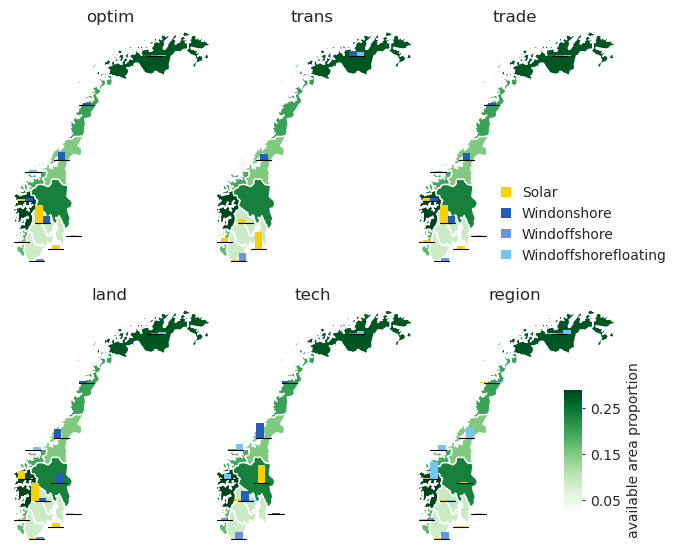

In [112]:
#plot
#year = 2050

cap2040 = captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050')]
scenarios = ['optim', 'trans', 'trade', 'land', 'tech', 'region']
technologies = ['Solar', 'Windonshore', 'Windoffshore', 'Windoffshorefloating']
colors = ['#f9d002', '#235ebc', '#6895dd', '#74c6f2']
max_capacities = {scenario: {tech: cap2040[(cap2040['Scenario Name'] == scenario) & (cap2040['technology'] == tech)]['gencap'].max() 
                             for tech in technologies} 
                  for scenario in scenarios}

offset_dict = {
    'NO42': [0.5, -0.68],
    'NO03': [2.4, -0.5],
    'NO54': [0, 0],
    'NO15': [0, 0.5],
    'NO38': [2, -0.8],
    'NO50': [0., 0],
    'NO11': [0, 0],
    'NO34': [0.7, -0.2],
    'NO30': [-0.9, 0.1],
    'NO18': [0, 0],
    'NO46': [0.2, 0.5],
}

def create_additional_legends(fig, cap2040, technologies, max_capacities):

    legend_elements = [plt.Rectangle((0,0),0.5,0.5, facecolor=color, edgecolor='none') for color in colors]
    tech_legend = fig.legend(legend_elements, technologies,borderaxespad=0,frameon=False,handlelength=0.7,
                             fontsize=10, bbox_to_anchor=(0.8, 0.7))


    ax_color_scale = fig.add_axes([0.71, 0.15, 0.015, 0.2])  # Adjust position as needed
    cmap = plt.get_cmap('Greens')
    norm = plt.Normalize(vmin=Norway['available_area_proportion'].min(), 
                         vmax=Norway['available_area_proportion'].max())
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale, orientation='vertical')
    cb.set_label('available area proportion', fontsize=10)
    new_ticks = [0.05, 0.15, 0.25]
    cb.set_ticks(new_ticks)
    cb.outline.set_visible(False)
    cb.ax.tick_params(length=2)
    
    return tech_legend, ax_color_scale    

indices_in_ranges = []

# Function to create bar plots for each zone
def create_zone_plot(ax, data, scenario, zone, technologies, colors, x_scaled, y_scaled, max_capacities, offset_dict):

    width = 1
    scale_factor = 1
    
    x_offset, y_offset = offset_dict.get(zone, [0, 0])
    trans = (transforms.Affine2D()
             .scale(scale_factor)
             .translate(x_scaled+x_offset, y_scaled+y_offset) + ax.transData)
    non_zero_techs = []
    non_zero_values = []
    non_zero_colors = []

    #calculating the maximum of in given scenario across technologies and zones for normalizing
    scenario_capacities = max_capacities[scenario]
    max_scen_cap = max(scenario_capacities, key=scenario_capacities.get)
    max_scen_value = scenario_capacities[max_scen_cap]
    
    for i, tech in enumerate(technologies):
        values = data[(data['Scenario Name'] == scenario) & 
                      (data['zone'] == zone) & 
                      (data['technology'] == tech)]
        normalized_value = 0
        value = values['gencap'].values[0]
        if value>0.0001:   
            #normalized_value = value / max_capacities[scenario][tech]
            normalized_value = value / max_scen_value
        #else:
        #    normalized_value = value / max_capacities[scenario][tech]

        if normalized_value > 0.0001:
            non_zero_techs.append(tech)
            non_zero_values.append(normalized_value)
            non_zero_colors.append(colors[i])

        # Check if the normalized value falls within the specified ranges for making bar length legends insskap
        #if 1 <= normalized_value <= 0.8 or 0.5 <= normalized_value <= 0.7 or 0.2 <= normalized_value <= 0.4:
        indices_in_ranges.append({
                'row_index': values.index[0],
                'scenario': scenario,
                'zone': zone,
                'technology': tech,
                'normalized_value': normalized_value
            })
    
    if non_zero_techs:
        for i, (value, color) in enumerate(zip(non_zero_values, non_zero_colors)):
            x_pos = (i - len(non_zero_techs)/2 + 0.5) * width
            ax.bar(x_pos, value, width, color=color, transform=trans, edgecolor='none')
        
        ax.plot([-0.5*len(technologies)/2, 0.5*len(technologies)/2], [0, 0], color='black', linewidth=0.8, transform=trans)
    ax.yaxis.set_visible(False)
    ax.set_xticks([])
    

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=-0.7, left=0.05, right=0.95, top=0.95, bottom=0.1)
axs = axs.flatten()

for i, scenario in enumerate(scenarios):
    ax = axs[i]
    Norway.plot(ax=ax, column='available_area_proportion', cmap='Greens', legend=False)

    for idx, row in Norway.iterrows():
        zone = idx
        x_scaled = row['x_coord']
        y_scaled = row['y_coord']

        create_zone_plot(ax, cap2040, scenario, zone, technologies, colors, x_scaled, y_scaled, max_capacities, offset_dict)
    

    ax.set_title(scenario)
    ax.set_xlim(Norway.total_bounds[0], Norway.total_bounds[2])
    ax.set_ylim(Norway.total_bounds[1], Norway.total_bounds[3])
    ax.axis('off')    

tech_legend, ax_color_scale = create_additional_legends(fig, cap2040, technologies, max_capacities)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/tech_cap_zonal.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/tech_cap_zonal.jpg', dpi=300, bbox_inches='tight')

#for idx, row in Norway.iterrows():
#    ax.annotate(row['name'], xy=row['geometry'].centroid.coords[0], ha='center', va='center', fontsize=8)

In [1474]:
indices_in_ranges

[{'row_index': 187,
  'scenario': 'optim',
  'zone': 'NO03',
  'technology': 'Solar',
  'normalized_value': 0.029740782724990308},
 {'row_index': 385,
  'scenario': 'optim',
  'zone': 'NO03',
  'technology': 'Windonshore',
  'normalized_value': 0},
 {'row_index': 583,
  'scenario': 'optim',
  'zone': 'NO03',
  'technology': 'Windoffshore',
  'normalized_value': 0},
 {'row_index': 781,
  'scenario': 'optim',
  'zone': 'NO03',
  'technology': 'Windoffshorefloating',
  'normalized_value': 0},
 {'row_index': 188,
  'scenario': 'optim',
  'zone': 'NO11',
  'technology': 'Solar',
  'normalized_value': 0.08772787531379025},
 {'row_index': 386,
  'scenario': 'optim',
  'zone': 'NO11',
  'technology': 'Windonshore',
  'normalized_value': 0},
 {'row_index': 584,
  'scenario': 'optim',
  'zone': 'NO11',
  'technology': 'Windoffshore',
  'normalized_value': 0},
 {'row_index': 782,
  'scenario': 'optim',
  'zone': 'NO11',
  'technology': 'Windoffshorefloating',
  'normalized_value': 0},
 {'row_inde

In [446]:
merged_df = pd.merge(
    gentotz_Ind_pref_change,
    captotz_Ind_pref_change[['demandyear', 'zone', 'technology', 'Scenario Name', 'gencap']],
    on=['demandyear', 'zone', 'technology', 'Scenario Name'],
    how='left'
)
merged_df['ratio'] = merged_df.apply(
    lambda row: 0 if row['gencap'] < 0.001 else row['genamttotz'] / (row['gencap']*8760), 
    axis=1
)
merged_df

demandyear  zone            technology    genamttotz Scenario Name  \
0         2030  NO03                 Solar      0.000217         optim   
1         2030  NO11                 Solar      0.000205         optim   
2         2030  NO15                 Solar      0.000332         optim   
3         2030  NO18                 Solar      0.000077         optim   
4         2030  NO30                 Solar  15678.130942         optim   
..         ...   ...                   ...           ...           ...   
625       2050  NO38  Windoffshorefloating      0.000010         optim   
626       2050  NO42  Windoffshorefloating      0.000016         optim   
627       2050  NO46  Windoffshorefloating      0.000025         optim   
628       2050  NO50  Windoffshorefloating      0.000017         optim   
629       2050  NO54  Windoffshorefloating   8247.200261         optim   

     Scenario Index  absolute_change  percent_change  weighted_change  \
0                 1              0.0             0.0              0.0   
1                 1              0.0             0.0              0.0   
2                 1              0.0             0.0              0.0   
3                 1              0.0             0.0              0.0   
4                 1              0.0             0.0              0.0   
..              ...              ...             ...              ...   
625               1              0.0             0.0              0.0   
626               1              0.0             0.0              0.0   
627               1              0.0             0.0              0.0   
628               1              0.0             0.0              0.0   
629               1              0.0             0.0              0.0   

           gencap     ratio  
0    2.391954e-07  0.000000  
1    2.121180e-07  0.000000  
2    3.866422e-07  0.000000  
3    9.836116e-08  0.000000  
4    1.511345e+01  0.118420  
..            ...       ...  
625  2.872714e-09  0.000000  
626  3.685379e-09  0.000000  
627  6.560283e-09  0.000000  
628  4.923725e-09  0.000000  
629  1.521486e+00  0.618777  

[630 rows x 11 columns]

In [960]:
merged_df[(merged_df['demandyear'] == '2050') & (merged_df['Scenario Name'] == 'optim')& (merged_df['technology'] == 'Windonshore')]

demandyear  zone   technology    genamttotz Scenario Name  Scenario Index  \
368       2050  NO03  Windonshore      0.000064         optim               1   
369       2050  NO11  Windonshore      0.000055         optim               1   
370       2050  NO18  Windonshore   7004.520164         optim               1   
371       2050  NO30  Windonshore  22780.001262         optim               1   
372       2050  NO34  Windonshore      0.000033         optim               1   
373       2050  NO38  Windonshore      0.000028         optim               1   
374       2050  NO42  Windonshore      0.000154         optim               1   
375       2050  NO46  Windonshore   9573.686810         optim               1   
376       2050  NO50  Windonshore  23111.517761         optim               1   
377       2050  NO54  Windonshore   3166.701099         optim               1   

     absolute_change  percent_change  weighted_change        gencap     ratio  
368              0.0             0.0              0.0  3.622311e-08  0.000000  
369              0.0             0.0              0.0  2.589618e-08  0.000000  
370              0.0             0.0              0.0  3.046540e+00  0.262463  
371              0.0             0.0              0.0  1.115064e+01  0.233212  
372              0.0             0.0              0.0  1.978182e-08  0.000000  
373              0.0             0.0              0.0  1.690872e-08  0.000000  
374              0.0             0.0              0.0  6.198922e-08  0.000000  
375              0.0             0.0              0.0  5.462251e+00  0.200080  
376              0.0             0.0              0.0  1.298499e+01  0.203181  
377              0.0             0.0              0.0  1.592941e+00  0.226936

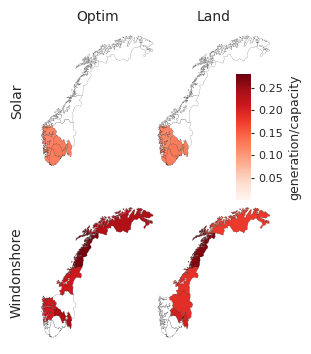

In [722]:
#plot Ratio
year = '2050'

data_plot = merged_df[(merged_df['demandyear'] == year)]
scenarios = ['optim','land']
technologies = ['Solar', 'Windonshore']
#colors = ['#f9d002','#235ebc']

 
fig, axs = plt.subplots(2, 2, figsize=(10, 4.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=-0.8, left=0.15, right=0.85, top=0.9, bottom=0.2)
#axs = axs.flatten()

cmap = plt.cm.Reds
cmap.set_under('white')

for row, technology in enumerate(technologies):
    for col, scenario in enumerate(scenarios):
        scenario_data = data_plot[(data_plot['technology'] == technology) & (data_plot['Scenario Name'] == scenario)]
        zone_scenario_data = Norway.reset_index().merge(scenario_data, left_on='index', right_on='zone')

        ax = axs[row, col]

        zone_scenario_data.plot(ax=ax, column='ratio', cmap=cmap, vmin=0.0001, vmax=0.27, linewidth=0.1, edgecolor='black')
        #ax.set_title(f"{technology} - {scenario.capitalize()}", fontsize=10)
        ax.axis('off')

        # Set scenario names as titles on top
        if row == 0:
            ax.set_title(scenario.capitalize(), fontsize=10)



for row, technology in enumerate(technologies):
    axs[row, 0].text(-0.15, 0.5, technology, 
                      va='center', ha='center', 
                      rotation='vertical', transform=axs[row, 0].transAxes, fontsize=10)


# Create a color bar with customized properties
cax = fig.add_axes([0.58, 0.52, 0.015, 0.28])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.0001, vmax=0.28))
sm.set_array([])  # You can set this to the range of your data
cb = fig.colorbar(sm, cax=cax)
cb.set_label('generation/capacity', fontsize=9)
cb.ax.tick_params(labelsize=8)


cb.outline.set_edgecolor('none') 
cb.set_ticks([0.05, 0.1, 0.15, 0.2, 0.25])
cb.ax.tick_params(length=2)             

#plt.tight_layout()
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/generatio_capacity.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/generatio_capacity.jpg', dpi=300, bbox_inches='tight')


  

# Supply Curve

This is not actually area but maximum installable capacity in GW.


In [450]:
area = makenice(found_scenarios, "area")

  0%|          | 0/720 [00:00<?, ?it/s]

In [451]:
capfacs = makenice(found_scenarios, "vre_gen")

  0%|          | 0/720 [00:00<?, ?it/s]

In [452]:
capfacsSW=capfacs.droplevel(["corines_solar"]).loc[(slice(None), slice(None), slice(None), slice(None), slice(None),
                                          slice(None), slice(None), ['Solar','Windonshore'])]

In [453]:
areaSW = area.droplevel(["corines_solar"]).loc[(slice(None), slice(None), slice(None), slice(None), slice(None),
                                          slice(None), ['Solar','Windonshore'])]

In [454]:
areaSW = areaSW.reset_index()
capfacsSW = capfacsSW.reset_index()

In [455]:
CWDareaSW = areaSW[(areaSW['transmission'] == 'DefaultYes')& 
        (areaSW['ImpExp'] == '1') & (areaSW['varnewpcapQ'] == 'OPT') & (areaSW['corines_onshore'] == 'CWD')&
        (areaSW['fylke_techs'] == 'fylketechD')]
CWDHareaSW = areaSW[(areaSW['transmission'] == 'DefaultYes')& 
        (areaSW['ImpExp'] == '1') & (areaSW['varnewpcapQ'] == 'OPT') & (areaSW['corines_onshore'] == 'CWDH')&
        (areaSW['fylke_techs'] == 'fylketechD')]
CWDHAareaSW = areaSW[(areaSW['transmission'] == 'DefaultYes')& 
        (areaSW['ImpExp'] == '1') & (areaSW['varnewpcapQ'] == 'OPT') & (areaSW['corines_onshore'] == 'CWDHA')&
        (areaSW['fylke_techs'] == 'fylketechD')]
CWDHAFareaSW = areaSW[(areaSW['transmission'] == 'DefaultYes')& 
        (areaSW['ImpExp'] == '1') & (areaSW['varnewpcapQ'] == 'OPT') & (areaSW['corines_onshore'] == 'CWDHAF')&
        (areaSW['fylke_techs'] == 'fylketechD')]

In [456]:
CWDHAFareaSW

demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs  \
2343        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2344        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2345        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2346        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2347        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
...          ...          ...    ...         ...             ...         ...   
14425       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14426       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14427       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14428       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14429       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   

        technology  zone region     value  
2343         Solar  NO03   NO03    0.8200  
2344         Solar  NO11   NO11  106.2720  
2345         Solar  NO15   NO15  134.8480  
2346         Solar  NO18   NO18  381.0920  
2347         Solar  NO30   NO30  114.2680  
...            ...   ...    ...       ...  
14425  Windonshore  NO38   NO38    5.7651  
14426  Windonshore  NO42   NO42    8.3061  
14427  Windonshore  NO46   NO46    3.7566  
14428  Windonshore  NO50   NO50   22.6230  
14429  Windonshore  NO54   NO54   74.7921  

[63 rows x 10 columns]

In [457]:

CWDcapfacsSW = capfacsSW[(capfacsSW['transmission'] == 'DefaultYes')& 
        (capfacsSW['ImpExp'] == '1') & (capfacsSW['varnewpcapQ'] == 'OPT') & (capfacsSW['corines_onshore'] == 'CWD')&
        (capfacsSW['fylke_techs'] == 'fylketechD')].groupby(["demandyear", "technology", "region"])
CWDHcapfacsSW = capfacsSW[(capfacsSW['transmission'] == 'DefaultYes')& 
        (capfacsSW['ImpExp'] == '1') & (capfacsSW['varnewpcapQ'] == 'OPT') & (capfacsSW['corines_onshore'] == 'CWDH')&
        (capfacsSW['fylke_techs'] == 'fylketechD')].groupby(["demandyear", "technology", "region"])
CWDHAcapfacsSW = capfacsSW[(capfacsSW['transmission'] == 'DefaultYes')& 
        (capfacsSW['ImpExp'] == '1') & (capfacsSW['varnewpcapQ'] == 'OPT') & (capfacsSW['corines_onshore'] == 'CWDHA')&
        (capfacsSW['fylke_techs'] == 'fylketechD')].groupby(["demandyear", "technology", "region"])
CWDHAFcapfacsSW = capfacsSW[(capfacsSW['transmission'] == 'DefaultYes')& 
        (capfacsSW['ImpExp'] == '1') & (capfacsSW['varnewpcapQ'] == 'OPT') & (capfacsSW['corines_onshore'] == 'CWDHAF')&
        (capfacsSW['fylke_techs'] == 'fylketechD')].groupby(["demandyear", "technology", "region"])

In [459]:
CWDcapfacsSW = CWDcapfacsSW['value'].mean().reset_index()
CWDHcapfacsSW = CWDHcapfacsSW['value'].mean().reset_index()
CWDHAcapfacsSW = CWDHAcapfacsSW['value'].mean().reset_index()
CWDHAFcapfacsSW = CWDHAFcapfacsSW['value'].mean().reset_index()
CWDHAFcapfacsSW

demandyear   technology region     value
0        2030        Solar   NO03  0.110621
1        2030        Solar   NO11  0.115360
2        2030        Solar   NO15  0.101300
3        2030        Solar   NO18  0.095040
4        2030        Solar   NO30  0.118458
..        ...          ...    ...       ...
61       2050  Windonshore   NO38  0.207997
62       2050  Windonshore   NO42  0.296203
63       2050  Windonshore   NO46  0.243344
64       2050  Windonshore   NO50  0.248692
65       2050  Windonshore   NO54  0.261374

[66 rows x 4 columns]

In [38]:
CWDHAFareaSW

demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs  \
2343        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2344        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2345        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2346        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
2347        2030   DefaultYes      1         OPT          CWDHAF  fylketechD   
...          ...          ...    ...         ...             ...         ...   
14425       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14426       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14427       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14428       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   
14429       2040   DefaultYes      1         OPT          CWDHAF  fylketechD   

        technology  zone region     value  
2343         Solar  NO03   NO03    0.8200  
2344         Solar  NO11   NO11  106.2720  
2345         Solar  NO15   NO15  134.8480  
2346         Solar  NO18   NO18  381.0920  
2347         Solar  NO30   NO30  114.2680  
...            ...   ...    ...       ...  
14425  Windonshore  NO38   NO38    5.7651  
14426  Windonshore  NO42   NO42    8.3061  
14427  Windonshore  NO46   NO46    3.7566  
14428  Windonshore  NO50   NO50   22.6230  
14429  Windonshore  NO54   NO54   74.7921  

[63 rows x 10 columns]

In [41]:
(CWDHAFareaSW[(CWDHAFareaSW['demandyear'] == '2050') & (CWDHAFareaSW['technology'] == 'Windonshore')]
             .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())

demandyear   technology region    value
0       2050  Windonshore   NO03   0.0135
1       2050  Windonshore   NO11   7.6062
2       2050  Windonshore   NO18  32.5143
3       2050  Windonshore   NO30   4.4355
4       2050  Windonshore   NO34  19.9944
5       2050  Windonshore   NO38   5.7651
6       2050  Windonshore   NO42   8.3061
7       2050  Windonshore   NO46   3.7566
8       2050  Windonshore   NO50  22.6230
9       2050  Windonshore   NO54  74.7921

In [1374]:
AS1 = (CWDHAFareaSW[(CWDHAFareaSW['demandyear'] == '2050') & (CWDHAFareaSW['technology'] == 'Windonshore')]
             .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())


In [1380]:
AS2 = (CWDareaSW[(CWDareaSW['demandyear'] == '2050') & (CWDareaSW['technology'] == 'Windonshore')]
             .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())

In [1384]:
#North
NAS1 = AS1[AS1['region'].isin(['NO54', 'NO18'])].sum()
SAS1 = AS1[AS1['region'].isin(['NO42'])].sum()
EAS1 = AS1[AS1['region'].isin(['NO30', 'NO34', 'NO03', 'NO38'])].sum()
WAS1 = AS1[AS1['region'].isin(['NO46', 'NO15', 'NO11'])].sum()
CAS1 = AS1[AS1['region'].isin(['NO50'])].sum()

In [1385]:
NAS2 = AS2[AS2['region'].isin(['NO54', 'NO18'])].sum()
SAS2 = AS2[AS2['region'].isin(['NO42'])].sum()
EAS2 = AS2[AS2['region'].isin(['NO30', 'NO34', 'NO03', 'NO38'])].sum()
WAS2 = AS2[AS2['region'].isin(['NO46', 'NO15', 'NO11'])].sum()
CAS2 = AS2[AS2['region'].isin(['NO50'])].sum()

In [1392]:
print(CAS1, CAS2)

demandyear           2050
technology    Windonshore
region               NO50
value              22.623
dtype: object demandyear           2050
technology    Windonshore
region               NO50
value             46.6551
dtype: object


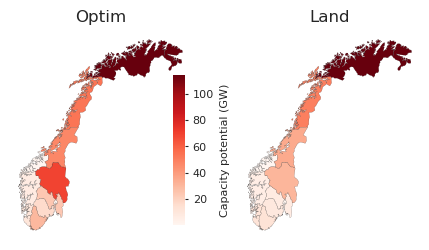

In [460]:
#capacity potential plot
year = '2050'
technology = 'Windonshore'
#change the data for different plots

data_plot = {
    'Optim': CWDareaSW, 'Land': CWDHAFareaSW
}

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.2, left=0.15, right=0.85, top=0.8, bottom=0.1)
cmap = plt.cm.Reds

scale = (CWDareaSW[(CWDareaSW['demandyear'] == year) & (CWDareaSW['technology'] == technology)]
             .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())

global_min = scale['value'].min()
global_max = scale['value'].max()
norm = plt.Normalize(vmin=global_min, vmax=global_max)

for ax, (title, df) in zip(axs, data_plot.items()):
    # Prepare the data for plotting
    data_subplot = (df[(df['demandyear'] == year) & (df['technology'] == technology)]
                 .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())
    merged_plot_df = Norway.reset_index().merge(data_subplot, how='left', left_on='index', right_on='region').fillna({'value': 0})

    # Plot
    merged_plot_df.plot(ax=ax, column='value', cmap=cmap, linewidth=0.1, edgecolor='black')
    ax.axis('off')
    ax.set_title(title)


cax = fig.add_axes([0.43, 0.15, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Capacity potential (GW)', fontsize=8)
cb.ax.tick_params(labelsize=8)
cb.outline.set_edgecolor('none') 
cb.ax.tick_params(length=2)
plt.show()

In [461]:
#Cumulative supply
CWDcapfacsSW = CWDcapfacsSW.merge(CWDareaSW[['demandyear', 'technology', 'region', 'value']], 
                          on=['demandyear', 'technology', 'region'], 
                          how='left').fillna({'value_y': 0})
CWDHcapfacsSW = CWDHcapfacsSW.merge(CWDHareaSW[['demandyear', 'technology', 'region', 'value']], 
                          on=['demandyear', 'technology', 'region'], 
                          how='left').fillna({'value_y': 0})
CWDHAcapfacsSW = CWDHAcapfacsSW.merge(CWDHAareaSW[['demandyear', 'technology', 'region', 'value']], 
                          on=['demandyear', 'technology', 'region'], 
                          how='left').fillna({'value_y': 0})
CWDHAFcapfacsSW = CWDHAFcapfacsSW.merge(CWDHAFareaSW[['demandyear', 'technology', 'region', 'value']], 
                          on=['demandyear', 'technology', 'region'], 
                          how='left').fillna({'value_y': 0})
CWDHAFcapfacsSW

demandyear   technology region   value_x   value_y
0        2030        Solar   NO03  0.110621    0.8200
1        2030        Solar   NO11  0.115360  106.2720
2        2030        Solar   NO15  0.101300  134.8480
3        2030        Solar   NO18  0.095040  381.0920
4        2030        Solar   NO30  0.118458  114.2680
..        ...          ...    ...       ...       ...
61       2050  Windonshore   NO38  0.207997    5.7651
62       2050  Windonshore   NO42  0.296203    8.3061
63       2050  Windonshore   NO46  0.243344    3.7566
64       2050  Windonshore   NO50  0.248692   22.6230
65       2050  Windonshore   NO54  0.261374   74.7921

[66 rows x 5 columns]

In [462]:
CWDcapfacsSW.rename(columns={"value_x": "avgCF", "value_y": "capacityPotential"}, inplace=True)
CWDHcapfacsSW.rename(columns={"value_x": "avgCF", "value_y": "capacityPotential"}, inplace=True)
CWDHAcapfacsSW.rename(columns={"value_x": "avgCF", "value_y": "capacityPotential"}, inplace=True)
CWDHAFcapfacsSW.rename(columns={"value_x": "avgCF", "value_y": "capacityPotential"}, inplace=True)

In [463]:
#zonal supply capacities in TWh
CWDcapfacsSW['supply'] = (CWDcapfacsSW['avgCF']*CWDcapfacsSW['capacityPotential']*8760)/1000
CWDHcapfacsSW['supply'] = (CWDHcapfacsSW['avgCF']*CWDHcapfacsSW['capacityPotential']*8760)/1000
CWDHAcapfacsSW['supply'] = (CWDHAcapfacsSW['avgCF']*CWDHAcapfacsSW['capacityPotential']*8760)/1000
CWDHAFcapfacsSW['supply'] = (CWDHAFcapfacsSW['avgCF']*CWDHAFcapfacsSW['capacityPotential']*8760)/1000

In [464]:
CWDHAFcapfacsSW

demandyear   technology region     avgCF  capacityPotential      supply
0        2030        Solar   NO03  0.110621             0.8200    0.794613
1        2030        Solar   NO11  0.115360           106.2720  107.393170
2        2030        Solar   NO15  0.101300           134.8480  119.662767
3        2030        Solar   NO18  0.095040           381.0920  317.278145
4        2030        Solar   NO30  0.118458           114.2680  118.574761
..        ...          ...    ...       ...                ...         ...
61       2050  Windonshore   NO38  0.207997             5.7651   10.504300
62       2050  Windonshore   NO42  0.296203             8.3061   21.552170
63       2050  Windonshore   NO46  0.243344             3.7566    8.007907
64       2050  Windonshore   NO50  0.248692            22.6230   49.285110
65       2050  Windonshore   NO54  0.261374            74.7921  171.246984

[66 rows x 6 columns]

In [465]:
# costs [capex, fixedOM, varOM] in £k/MW
# multiply capacities with 1000
costs = {
    'Windonshore_2030': [87.382, 20, 0.00502567],
    'Windonshore_2040': [87.382, 20, 0.00502567],
    'Windonshore_2050': [66.29, 20, 0.00502567],
    'Solar_2030': [40.035, 5, 0],
    'Solar_2040': [40.035, 5, 0],
    'Solar_2050': [24.536, 5, 0],
}


In [466]:
# from 2010 GBP to June 2024 GBP https://www.bankofengland.co.uk/monetary-policy/inflation/inflation-calculator
# £1 in 2010 is £1.5 in June 2024

cost_2024GBP = 1.5
cost_2024NOK = cost_2024GBP*14

def calculate_LCOE(row):
    # Create a key from the technology and demand year (e.g., 'Windonshore_2030')
    key = f"{row['technology']}_{row['demandyear']}"
    capex, fixedOM, varOM = costs[key]
    # Calculate LCOE using the formula
    hours_per_year = 8760  # Number of hours in a year
    if row['avgCF']>0:
        LCOE = ((capex + fixedOM + (row['avgCF'] * hours_per_year * varOM)) / (row['avgCF'] * hours_per_year))*1000*cost_2024NOK #NOK/MWh
    else:
        LCOE = 0
    return LCOE

In [467]:
CWDcapfacsSW['LCOE']=CWDcapfacsSW.apply(calculate_LCOE, axis=1)
CWDHcapfacsSW['LCOE']=CWDHcapfacsSW.apply(calculate_LCOE, axis=1)
CWDHAcapfacsSW['LCOE']=CWDHAcapfacsSW.apply(calculate_LCOE, axis=1)
CWDHAFcapfacsSW['LCOE']=CWDHAFcapfacsSW.apply(calculate_LCOE, axis=1)
CWDHAFcapfacsSW

demandyear   technology region     avgCF  capacityPotential      supply  \
0        2030        Solar   NO03  0.110621             0.8200    0.794613   
1        2030        Solar   NO11  0.115360           106.2720  107.393170   
2        2030        Solar   NO15  0.101300           134.8480  119.662767   
3        2030        Solar   NO18  0.095040           381.0920  317.278145   
4        2030        Solar   NO30  0.118458           114.2680  118.574761   
..        ...          ...    ...       ...                ...         ...   
61       2050  Windonshore   NO38  0.207997             5.7651   10.504300   
62       2050  Windonshore   NO42  0.296203             8.3061   21.552170   
63       2050  Windonshore   NO46  0.243344             3.7566    8.007907   
64       2050  Windonshore   NO50  0.248692            22.6230   49.285110   
65       2050  Windonshore   NO54  0.261374            74.7921  171.246984   

           LCOE  
0    975.950425  
1    935.861659  
2   1065.748994  
3   1135.949793  
4    911.384903  
..          ...  
61  1100.072700  
62   803.909620  
63   955.611079  
64   937.330086  
65   896.969164  

[66 rows x 7 columns]

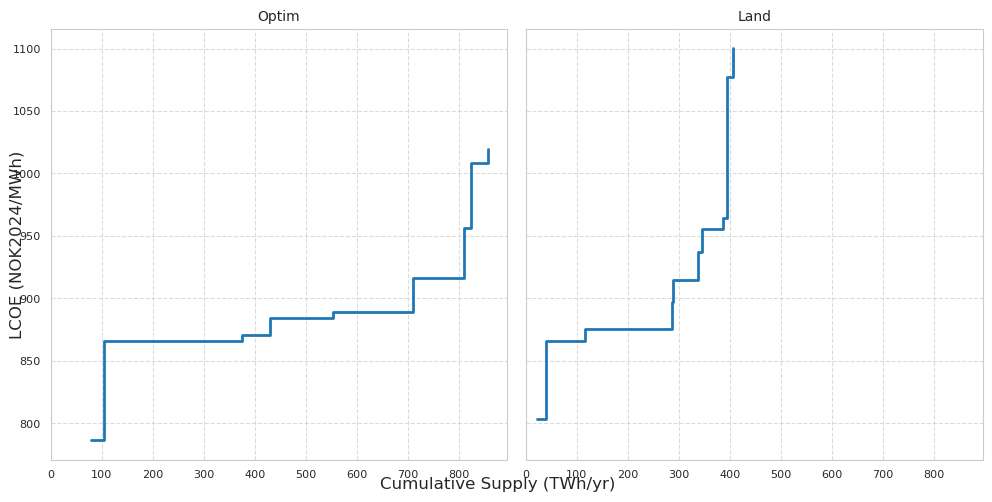

In [468]:
#cumulative supply Plot
year = '2050'
technology = 'Windonshore'

def prepare_data(df, year, technology):
    df_filtered = df[(df['demandyear'] == year) & (df['technology'] == technology)]
    df_sorted = df_filtered.sort_values('LCOE')
    df_sorted['cumulative_supply'] = df_sorted['supply'].cumsum()
    return df_sorted[df_sorted['LCOE'] > 0]


data_plot = {
    'Optim': CWDcapfacsSW,
    'Land': CWDHAFcapfacsSW
}

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=1, left=0.5, right=0.6, top=0.9, bottom=0.15)

for ax, (title, df) in zip(axs, data_plot.items()):
    data_subplot = prepare_data(df, year, technology)
    
    # Create the step plot
    ax.step(data_subplot['cumulative_supply'], data_subplot['LCOE'], where='post', color='#1f77b4', linewidth=2)
    
    # Add markers at each step
    #ax.plot(data_subplot['cumulative_supply'], data_subplot['LCOE'], 'o', color='#1f77b4', markersize=4)
    
    # Customize the subplot
    ax.set_title(f'{title}', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Set x-axis to start from 0
    ax.set_xlim(left=0)

# Set common labels
fig.text(0.5, 0.02, 'Cumulative Supply (TWh/yr)', ha='center', va='center', fontsize=12)
fig.text(0.02, 0.5, 'LCOE (NOK2024/MWh)', ha='center', va='center', rotation='vertical', fontsize=12)

#plt.suptitle(f'LCOE Supply Curve for Windonshore Technology in {year}', fontsize=16)

plt.tight_layout()
plt.show()




In [469]:
(CWDareaSW[(CWDareaSW['demandyear'] == year) & (CWDareaSW['technology'] == technology)]
         .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())

demandyear   technology region     value
0       2050  Windonshore   NO03    0.3759
1       2050  Windonshore   NO11   10.6770
2       2050  Windonshore   NO18   53.1156
3       2050  Windonshore   NO30   24.0507
4       2050  Windonshore   NO34   68.8434
5       2050  Windonshore   NO38   16.1004
6       2050  Windonshore   NO42   29.6979
7       2050  Windonshore   NO46    7.0818
8       2050  Windonshore   NO50   46.6551
9       2050  Windonshore   NO54  114.1839

/tmp/ipykernel_1600841/211167658.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


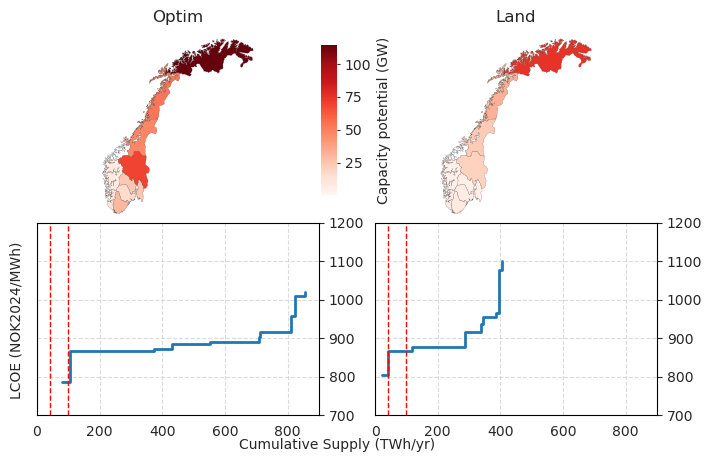

In [698]:
#Map & Capacity plot
def prepare_data(df, year, technology):
    df_filtered = df[(df['demandyear'] == year) & (df['technology'] == technology)]
    df_sorted = df_filtered.sort_values('LCOE')
    df_sorted['cumulative_supply'] = df_sorted['supply'].cumsum()
    return df_sorted[df_sorted['LCOE'] > 0]

year = '2050'
technology = 'Windonshore'

data_plot = {
    'Optim': {'area': CWDareaSW, 'capfacs': CWDcapfacsSW},
    'Land': {'area': CWDHAFareaSW, 'capfacs': CWDHAFcapfacsSW}
}

#fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0, wspace=0.2)

#fig.subplots_adjust(wspace=0.2, hspace=0.1, left=0.12, right=0.9, top=0.9, bottom=0.12)

cmap = plt.cm.Reds
scale = (CWDareaSW[(CWDareaSW['demandyear'] == year) & (CWDareaSW['technology'] == technology)]
         .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())
global_min = scale['value'].min()
global_max = scale['value'].max()
norm = plt.Normalize(vmin=global_min, vmax=global_max)

lcoe_axes = []
for col, (title, data) in enumerate(data_plot.items()):
    # Map plot
    #ax_map = axs[0, col]
    ax_map = fig.add_subplot(gs[0, col])
    df_area = data['area']
    data_subplotarea = (df_area[(df_area['demandyear'] == year) & (df_area['technology'] == technology)]
                    .groupby(["demandyear", "technology", "region"])['value'].sum().reset_index())
    merged_plot_df = Norway.reset_index().merge(data_subplotarea, how='left', left_on='index', right_on='region').fillna({'value': 0})
    merged_plot_df.plot(ax=ax_map, column='value', cmap=cmap, linewidth=0.1, edgecolor='black', norm=norm)
    ax_map.axis('off')
    ax_map.set_title(f'{title}', fontsize=12)

    # LCOE supply curve plot
    #ax_lcoe = axs[1, col]
    ax_lcoe = fig.add_subplot(gs[1, col])
    df_capfacs = data['capfacs']
    data_subplotcap = prepare_data(df_capfacs, year, technology)
    ax_lcoe.step(data_subplotcap['cumulative_supply'], data_subplotcap['LCOE'], where='post', color='#1f77b4', linewidth=2)
    #ax_lcoe.plot(data_subplot['cumulative_supply'], data_subplot['LCOE'], 'o', color='#1f77b4', markersize=4)
    #ax_lcoe.set_title(f'{title} Scenario - LCOE Supply Curve', fontsize=12)
    ax_lcoe.grid(True, linestyle='--', alpha=0.7)
    ax_lcoe.tick_params(axis='both', which='major', labelsize=10)
    ax_lcoe.set_xlim(left=0)
    for spine in ax_lcoe.spines.values():
        spine.set_edgecolor('black')

    ax_lcoe.axvline(x=40, color='red', linestyle='--', linewidth=1)
    ax_lcoe.axvline(x=100, color='red', linestyle='--', linewidth=1)
    ax_lcoe.yaxis.tick_right()
    ax_lcoe.yaxis.set_label_position("right")

    lcoe_axes.append(ax_lcoe)


x_limit = 900  # This value can be adjusted manually
for ax in lcoe_axes:
    ax.set_xlim(0, x_limit)
    ax.set_ylim(700, 1200)


# Set common labels for LCOE plots
fig.text(0.5, 0.05, 'Cumulative Supply (TWh/yr)', ha='center', va='center', fontsize=10)
fig.text(0.1, 0.3, 'LCOE (NOK2024/MWh)', ha='center', va='center', rotation='vertical', fontsize=10)

# Add colorbar for map plots
cax = fig.add_axes([0.48, 0.55, 0.02, 0.3])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Capacity potential (GW)', fontsize=10)
cb.ax.tick_params(labelsize=10)
cb.outline.set_edgecolor('none')
cb.ax.tick_params(length=2)

#plt.suptitle(f'Capacity Potential and LCOE Supply Curve for Windonshore Technology in {year}', fontsize=16)

plt.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Cumulative_supply.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Cumulative_supply.jpg', dpi=300, bbox_inches='tight')
plt.show()

# How to deal with existing wind and the areas that it covers? atlite vs gams...
# How much area is available per scenario for onshore wind?


In [ ]:
# Based on base scenario of Statnett, Electricity consumption may incerase by 80 TWh by 2050

# Transmission plot

In [173]:
trans_cap = makenice(found_scenarios, "trans_cap")

  0%|          | 0/720 [00:00<?, ?it/s]

In [174]:
#Optim versus land preference query
captotztrans = captotz[captotz.gencap > 1e-04]
captotztrans.query("demandyear=='2050' and transmission == 'LOWOH' and fylke_techs == 'fylketechD' and "
              "varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and ImpExp == '1' and "
                  "technology in ('Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore')").reset_index()


demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore  \
0        2050        LOWOH      1         OPT           CSD          CWDHAF   
1        2050        LOWOH      1         OPT           CSD          CWDHAF   
2        2050        LOWOH      1         OPT           CSD          CWDHAF   
3        2050        LOWOH      1         OPT           CSD          CWDHAF   
4        2050        LOWOH      1         OPT           CSD          CWDHAF   
5        2050        LOWOH      1         OPT           CSD          CWDHAF   
6        2050        LOWOH      1         OPT           CSD          CWDHAF   
7        2050        LOWOH      1         OPT           CSD          CWDHAF   
8        2050        LOWOH      1         OPT           CSD          CWDHAF   
9        2050        LOWOH      1         OPT           CSD          CWDHAF   
10       2050        LOWOH      1         OPT           CSD          CWDHAF   
11       2050        LOWOH      1         OPT           CSD          CWDHAF   
12       2050        LOWOH      1         OPT           CSD          CWDHAF   
13       2050        LOWOH      1         OPT           CSD          CWDHAF   
14       2050        LOWOH      1         OPT           CSD          CWDHAF   
15       2050        LOWOH      1         OPT           CSD          CWDHAF   
16       2050        LOWOH      1         OPT           CSD          CWDHAF   
17       2050        LOWOH      1         OPT           CSD          CWDHAF   
18       2050        LOWOH      1         OPT           CSD          CWDHAF   
19       2050        LOWOH      1         OPT           CSD          CWDHAF   
20       2050        LOWOH      1         OPT           CSD          CWDHAF   
21       2050        LOWOH      1         OPT           CSD          CWDHAF   
22       2050        LOWOH      1         OPT           CSD          CWDHAF   
23       2050        LOWOH      1         OPT           CSD          CWDHAF   
24       2050        LOWOH      1         OPT           CSD          CWDHAF   
25       2050        LOWOH      1         OPT           CSD          CWDHAF   
26       2050        LOWOH      1         OPT           CSD          CWDHAF   
27       2050        LOWOH      1         OPT           CSD          CWDHAF   
28       2050        LOWOH      1         OPT           CSD          CWDHAF   
29       2050        LOWOH      1         OPT           CSD          CWDHAF   
30       2050        LOWOH      1         OPT           CSD          CWDHAF   
31       2050        LOWOH      1         OPT           CSD          CWDHAF   
32       2050        LOWOH      1         OPT           CSD          CWDHAF   
33       2050        LOWOH      1         OPT           CSD          CWDHAF   
34       2050        LOWOH      1         OPT           CSD          CWDHAF   
35       2050        LOWOH      1         OPT           CSD          CWDHAF   
36       2050        LOWOH      1         OPT           CSD          CWDHAF   
37       2050        LOWOH      1         OPT           CSD          CWDHAF   
38       2050        LOWOH      1         OPT           CSD          CWDHAF   
39       2050        LOWOH      1         OPT           CSD          CWDHAF   
40       2050        LOWOH      1         OPT           CSD          CWDHAF   
41       2050        LOWOH      1         OPT           CSD          CWDHAF   
42       2050        LOWOH      1         OPT           CSD          CWDHAF   
43       2050        LOWOH      1         OPT           CSD          CWDHAF   
44       2050        LOWOH      1         OPT           CSD          CWDHAF   
45       2050        LOWOH      1         OPT           CSD          CWDHAF   
46       2050        LOWOH      1         OPT           CSD          CWDHAF   
47       2050        LOWOH      1         OPT           CSD          CWDHAF   
48       2050        LOWOH      1         OPT           CSD          CWDHAF   
49       2050        LOWOH      1         OPT        

In [175]:
captotztrans.query("demandyear=='2050' and transmission == 'DefaultYes' and fylke_techs == 'fylketechD' and "
              "varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and ImpExp == '1'").reset_index()

demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore  \
0         2050   DefaultYes      1         OPT           CSD             CWD   
1         2050   DefaultYes      1         OPT           CSD             CWD   
2         2050   DefaultYes      1         OPT           CSD             CWD   
3         2050   DefaultYes      1         OPT           CSD             CWD   
4         2050   DefaultYes      1         OPT           CSD             CWD   
..         ...          ...    ...         ...           ...             ...   
178       2050   DefaultYes      1         OPT           CSD             CWD   
179       2050   DefaultYes      1         OPT           CSD             CWD   
180       2050   DefaultYes      1         OPT           CSD             CWD   
181       2050   DefaultYes      1         OPT           CSD             CWD   
182       2050   DefaultYes      1         OPT           CSD             CWD   

    fylke_techs  zone                  technology   level_2         gencap  
0    fylketechD  NO03                    HydroRoR     level   4.700000e-03  
1    fylketechD  NO03                    HydroRoR        up   4.700000e-03  
2    fylketechD  NO03  NaturalgasCCGTwithCCSnewOT  marginal   1.406530e+02  
3    fylketechD  NO03  NaturalgasCCGTwithCCSnewOT        up  1.000000e+100  
4    fylketechD  NO03           NaturalgasOCGTnew  marginal   4.153700e+01  
..          ...   ...                         ...       ...            ...  
178  fylketechD  NO54                Windoffshore        up  1.000000e+100  
179  fylketechD  NO54        Windoffshorefloating     level   1.521486e+00  
180  fylketechD  NO54        Windoffshorefloating        up  1.000000e+100  
181  fylketechD  NO54                 Windonshore     level   1.592941e+00  
182  fylketechD  NO54                 Windonshore        up  1.000000e+100  

[183 rows x 11 columns]

In [198]:
fix_optim_pies = {}
#lowoh_optim_pies = {}
#fix_land_pies = {}
lowoh_land_pies = {}
cumulative_pies = {}

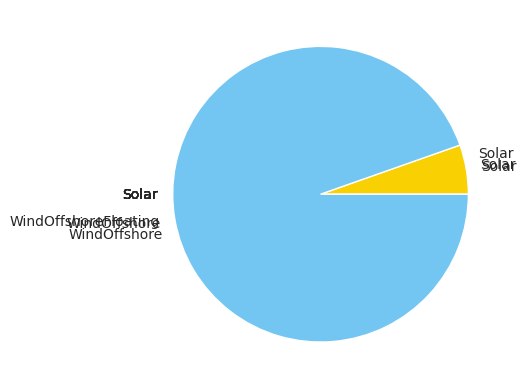

In [202]:
#change the query strings for getting pies

tech_map = {
    'Solar': {'label': 'Solar', 'color': '#f9d002'},
    'Windoffshore': {'label': 'WindOffshore', 'color': '#6895dd'},
    'Windoffshorefloating': {'label': 'WindOffshoreFloating', 'color': '#74c6f2'},
    'Windonshore': {'label': 'WindOnshore', 'color': '#235ebc'}
}

for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
    df = captotztrans.query("demandyear=='2050' and zone ==" + "'" + i +"'"+ "and transmission == 'LOWOH' and fylke_techs == 'fylketechC' and "
              "varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and ImpExp == '2' and "
              "technology in ('Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore') and level_2 == 'level'").reset_index()
    #df = df.set_index('technology').reindex(tech_map.keys(), fill_value=0).reset_index()
    #df['gencap'] = np.where(df['gencap'] == 0, small_value, df['gencap'])  
    active_labels = [tech_map[tech]['label'] for tech in df['technology']]
    active_colors = [tech_map[tech]['color'] for tech in df['technology']]
    cumulative_pies[i] = plt.pie(df['gencap'], labels = active_labels, colors = active_colors)

    

In [200]:
fix_optim_pies

{'NO03': ([<matplotlib.patches.Wedge at 0x14a4ba1325f0>],
  [Text(-1.1, 1.3471114790620887e-16, 'Solar')]),
 'NO11': ([<matplotlib.patches.Wedge at 0x14a4ba25c5e0>],
  [Text(-1.1, 1.3471114790620887e-16, 'Solar')]),
 'NO15': ([<matplotlib.patches.Wedge at 0x14a4b9e73340>],
  [Text(-1.1, 1.3471114790620887e-16, 'WindOffshoreFloating')]),
 'NO18': ([<matplotlib.patches.Wedge at 0x14a4ba131de0>],
  [Text(-1.1, 1.3471114790620887e-16, 'WindOnshore')]),
 'NO30': ([<matplotlib.patches.Wedge at 0x14a4b9cbe200>,
  [Text(-0.6797408357379379, 0.8648424112115974, 'Solar'),
   Text(0.6797407547655442, -0.8648424748535242, 'WindOnshore')]),
 'NO34': ([], []),
 'NO38': ([<matplotlib.patches.Wedge at 0x14a4ba0c4730>],
  [Text(-1.1, 1.3471114790620887e-16, 'Solar')]),
 'NO42': ([<matplotlib.patches.Wedge at 0x14a4ba0c77c0>,
  [Text(0.9155669119387181, 0.6097025748371083, 'Solar'),
   Text(-0.9155669404809548, -0.6097025319763271, 'WindOffshore')]),
 'NO46': ([<matplotlib.patches.Wedge at 0x14a4ba1330a

In [179]:
fix_optim_cap_tot = {}
lowoh_optim_cap_tot = {}
fix_land_cap_tot = {}
lowoh_land_cap_tot = {}
cumulative_cap_tot = {}

In [187]:
cumulative_cap_tot = {}

In [180]:
captotztrans

gencap
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs zone technology                 level_2               
2030       DefaultNO    2      QS1         CSD           CWDH            fylketechC  NO03 HydroRoR                   level     4.700000e-03
                                                                                                                     up        4.700000e-03
                                                                                          NaturalgasCCGTwithCCSnewOT up       1.000000e+100
                                                                                          NaturalgasOCGTnew          up       1.000000e+100
                                                                                          Solar                      level     8.200000e-01
...                                                                                                                                     ...
2040       LOWOH        1      OPT         CSD           CWDHAF          fylketechC  NO54 Solar                      up       1.000000e+100
                                                                                          Windoffshore               up       1.000000e+100
                                                                                          Windoffshorefloating       level     6.173003e+00
                                                                                                                     up       1.000000e+100
                                                                                          Windonshore                up       1.000000e+100

[118665 rows x 1 columns]

In [181]:
captotztrans.query("demandyear=='2050' and zone ==" + "'" + 'NO54' +"'"+ "and transmission == 'LOWOH' and "
                "fylke_techs == 'fylketechD' and varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and ImpExp == '1' and "
                  "technology in ('Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore') "
                   "and level_2 == 'level'").values.T[0].sum()

10.124602495829716

In [188]:
#change the query strings for getting cap_tot
for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
    cumulative_cap_tot[i] = captotztrans.query("demandyear=='2050' and zone ==" + "'" + i +"'"+ "and transmission == 'LOWOH' and "
                "fylke_techs == 'fylketechC' and varnewpcapQ == 'QS1' and corines_onshore == 'CWDHAF' and ImpExp == '2' and "
                "technology in ('Solar', 'Windoffshore', 'Windoffshorefloating', 'Windonshore') "
                "and level_2 == 'level'").values.T[0].sum()


In [189]:
fix_optim_cap_frac = {}
lowoh_optim_cap_frac = {}
fix_land_cap_frac = {}
lowoh_land_cap_frac = {}
cumulative_cap_frac = {}

In [190]:
#change the query strings for getting cap_frac
for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
    fix_optim_cap_frac[i] = fix_optim_cap_tot[i]/sum(fix_optim_cap_tot.values())
    #lowoh_optim_cap_frac[i] = lowoh_optim_cap_tot[i]/sum(lowoh_optim_cap_tot.values())
    #fix_land_cap_frac[i] = fix_land_cap_tot[i]/sum(fix_land_cap_tot.values())
    lowoh_land_cap_frac[i] = lowoh_land_cap_tot[i]/sum(lowoh_land_cap_tot.values())
    cumulative_cap_frac[i] = cumulative_cap_tot[i]/sum(cumulative_cap_tot.values())
#cap_frac WRT total Country capacities    

In [191]:
trans_cap.query("demandyear=='2050' and transmission == 'LOWOH' and ImpExp == '1' "
            "and corines_solar == 'CSD' and fylke_techs == 'fylketechD' and varnewpcapQ == 'OPT' and "
                            "corines_onshore == 'CWDHAF' and ImpExp == '1' and Zone_1 == 'NO46'"
               ).query("level_2 in ['level', 'trans']")

transpcap
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs Zone_1 Zone_2 level_2                
2050       LOWOH        1      OPT         CSD           CWDHAF          fylketechD  NO46   NO11   level          1.793578
                                                                                                   level               0.0
                                                                                                   trans         HVAC400KV
                                                                                                   trans    HVDCSubsurface
                                                                                            NO15   level               3.0
                                                                                                   level               0.0
                                                                                                   trans         HVAC400KV
                                                                                                   trans    HVDCSubsurface
                                                                                            NO30   level               3.9
                                                                                                   level               0.0
                                                                                                   trans         HVAC400KV
                                                                                                   trans    HVDCSubsurface
                                                                                            NO34   level               0.0
                                                                                                   level               0.0
                                                                                                   trans         HVAC400KV
                                                                                                   trans    HVDCSubsurface
                                                                                            NO38   level          0.000003
                                                                                                   level               0.0
                                                                                                   trans         HVAC400KV
                                                                                                   trans    HVDCSubsurface

In [192]:
def simple_rename_levels(df):
    # Get the list of indices in the DataFrame
    indices = df.index.tolist()
    
    # Iterate over indices and rename 'level' entries
    for i, idx in enumerate(indices):
        if idx[-1] == 'level':
            if i % 2 == 0:  # Even index means it's the first 'level'
                indices[i] = idx[:-1] + ('HVAC400KV',)
            else:  # Odd index means it's the second 'level'
                indices[i] = idx[:-1] + ('HVDCSubsurface',)
                
    # Assign the new list of indices to the DataFrame's index
    df.index = pd.MultiIndex.from_tuples(indices, names=df.index.names)
    
    return df

In [193]:
fix_optim_trans = {}
#lowoh_optim_trans = {}
#fix_land_trans = {}
lowoh_land_trans = {}
Cumulative_trans = {}

In [194]:
fix_optim_trans = trans_cap.query("demandyear=='2050' and transmission == 'DefaultYes' and ImpExp == '1' "
            "and corines_solar == 'CSD' and fylke_techs == 'fylketechD' and varnewpcapQ == 'OPT' and "
                            "corines_onshore == 'CWD' and ImpExp == '1' and level_2 == 'level'")
#lowoh_optim_trans = trans_cap.query("demandyear=='2050' and transmission == 'LOWOH' and ImpExp == '1' "
#            "and corines_solar == 'CSD' and fylke_techs == 'fylketechD' and varnewpcapQ == 'OPT' and "
#                            "corines_onshore == 'CWD' and ImpExp == '1' and level_2 == 'level'")
#fix_land_trans = trans_cap.query("demandyear=='2050' and transmission == 'DefaultYes' and ImpExp == '1' "
#            "and corines_solar == 'CSD' and fylke_techs == 'fylketechD' and varnewpcapQ == 'OPT' and "
#                            "corines_onshore == 'CWDHAF' and ImpExp == '1' and level_2 == 'level'")
lowoh_land_trans = trans_cap.query("demandyear=='2050' and transmission == 'LOWOH' and ImpExp == '1' "
            "and corines_solar == 'CSD' and fylke_techs == 'fylketechD' and varnewpcapQ == 'OPT' and "
                            "corines_onshore == 'CWDHAF' and ImpExp == '1' and level_2 == 'level'")
Cumulative_trans = trans_cap.query("demandyear=='2050' and transmission == 'LOWOH' and ImpExp == '2' "
            "and corines_solar == 'CSD' and fylke_techs == 'fylketechC' and varnewpcapQ == 'QS1' and "
                            "corines_onshore == 'CWDHAF' and ImpExp == '2' and level_2 == 'level'")


fix_optim_trans=fix_optim_trans.pipe(simple_rename_levels)
#lowoh_optim_trans=lowoh_optim_trans.pipe(simple_rename_levels)
#fix_land_trans=fix_land_trans.pipe(simple_rename_levels)
lowoh_land_trans=lowoh_land_trans.pipe(simple_rename_levels)
Cumulative_trans=Cumulative_trans.pipe(simple_rename_levels)

trans_tot = fix_optim_trans.values.sum()
trans_tot

55.00000000000001

In [195]:
fix_optim_trans_tot = fix_optim_trans.values.sum()
#lowoh_optim_trans_tot = lowoh_optim_trans.values.sum()
#fix_land_trans_tot = fix_land_trans.values.sum()
lowoh_land_trans_tot = lowoh_land_trans.values.sum()
Cumulative_trans_tot = Cumulative_trans.values.sum()

In [196]:
fix_optim_trans.query("level_2 == 'HVDCSubsurface'")

transpcap
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs Zone_1 Zone_2 level_2                 
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  NO03   NO30   HVDCSubsurface       0.0
                                                                                     NO11   NO38   HVDCSubsurface       0.0
                                                                                            NO42   HVDCSubsurface       0.0
                                                                                            NO46   HVDCSubsurface       0.0
                                                                                     NO15   NO34   HVDCSubsurface       0.0
                                                                                            NO46   HVDCSubsurface       0.0
                                                                                            NO50   HVDCSubsurface       0.0
                                                                                     NO18   NO50   HVDCSubsurface       0.0
                                                                                            NO54   HVDCSubsurface       0.0
                                                                                     NO30   NO03   HVDCSubsurface       0.0
                                                                                            NO34   HVDCSubsurface       0.0
                                                                                            NO38   HVDCSubsurface       0.0
                                                                                            NO46   HVDCSubsurface       0.0
                                                                                     NO34   NO15   HVDCSubsurface       0.0
                                                                                            NO30   HVDCSubsurface       0.0
                                                                                            NO46   HVDCSubsurface       0.0
                                                                                            NO50   HVDCSubsurface       0.0
                                                                                     NO38   NO11   HVDCSubsurface       0.0
                                                                                            NO30   HVDCSubsurface       0.0
                                                                                            NO42   HVDCSubsurface       0.0
                                                                                            NO46   HVDCSubsurface       0.0
                                                                                     NO42   NO11   HVDCSubsurface       0.0
                                                                                            NO38   HVDCSubsurface       0.0
                                                                                     NO46   NO11   HVDCSubsurface       0.0
                                                                                            NO15   HVDCSubsurface       0.0
                                                                                            NO30   HVDCSubsurface       0.0
                                                                                            NO34   HVDCSubsurface       0.0
                                                                                            NO38   HVDCSubsurface       0.0
                                                                                     NO50   NO15   HVDCSubsurface       0.0
                                                                                            NO18   HVDCSubsurface       0.0
                                                                                            NO34   HVDCSubsurface       0.0
                      

In [ ]:
i = ['NO15', 'NO34']
trans_new.query("Zone_1 == " + "'" + i[0] + "'" + " and Zone_2 == " + "'" + i[1] + "'").values[1][0]

In [ ]:
fix_optim_pies
lowoh_optim_pies
fix_land_pies
lowoh_land_pies
cumulative_pies

fix_optim_cap_tot
lowoh_optim_cap_tot
fix_land_cap_tot
lowoh_land_cap_tot
cumulative_cap_tot

fix_optim_cap_frac
lowoh_optim_cap_frac
fix_land_cap_frac
lowoh_land_cap_frac
cumulative_cap_frac

fix_optim_trans
lowoh_optim_trans
fix_land_trans
lowoh_land_trans
Cumulative_trans

fix_optim_trans_tot
lowoh_optim_trans_tot
fix_land_trans_tot
lowoh_land_trans_tot
Cumulative_trans_tot

In [203]:
Cumulative_trans_tot

98.50808592365257

In [204]:
Norway

name                                           geometry  \
NO03                  Oslo  POLYGON ((10.75660 59.84416, 10.75847 59.85017...   
NO11              Rogaland  MULTIPOLYGON (((6.39763 58.27300, 6.34752 58.2...   
NO15       Møre og Romsdal  MULTIPOLYGON (((5.46168 62.00674, 5.46803 62.0...   
NO18              Nordland  MULTIPOLYGON (((12.06373 65.04560, 12.07594 65...   
NO30                 Viken  MULTIPOLYGON (((11.08302 59.07730, 11.08237 59...   
NO34             Innlandet  POLYGON ((11.16219 60.62149, 11.12638 60.59852...   
NO38  Vestfold og Telemark  POLYGON ((10.28443 59.69571, 10.29721 59.69180...   
NO42                 Agder  POLYGON ((8.22250 58.15168, 8.22242 58.14012, ...   
NO46              Vestland  MULTIPOLYGON (((5.05714 60.19367, 5.05437 60.2...   
NO50             Trøndelag  MULTIPOLYGON (((12.09330 62.90743, 12.09702 62...   
NO54     Troms og Finnmark  MULTIPOLYGON (((15.89796 68.91743, 15.90455 68...   

      available_area_proportion  disagree_area_proportion  \
NO03                   0.028767                  0.622211   
NO11                   0.172801                  0.257466   
NO15                   0.193538                  0.219766   
NO18                   0.199754                  0.160889   
NO30                   0.093058                  0.671340   
NO34                   0.235504                  0.546463   
NO38                   0.088886                  0.575092   
NO42                   0.085288                  0.456396   
NO46                   0.288490                  0.228834   
NO50                   0.149781                  0.311010   
NO54                   0.273903                  0.189083   

      existing_hydro_ecap                     center    x_coord    y_coord  
NO03                0.000  POINT (10.65234 59.96925)  10.652344  59.969246  
NO11              324.950   POINT (6.22278 59.11269)   6.222784  59.112690  
NO15                0.000   POINT (7.69552 62.60278)   7.695516  62.602775  
NO18                0.000  POINT (14.81302 66.91939)  14.813023  66.919387  
NO30                0.000   POINT (9.87421 60.10487)   9.874210  60.104874  
NO34                0.000  POINT (10.43534 61.45051)  10.435337  61.450511  
NO38                0.000   POINT (8.72504 59.51194)   8.725044  59.511941  
NO42                0.000   POINT (7.62799 58.71692)   7.627988  58.716915  
NO46               65.452   POINT (6.45740 60.94731)   6.457400  60.947315  
NO50                8.987  POINT (11.44390 63.76109)  11.443896  63.761094  
NO54                0.000  POINT (23.75868 69.71329)  23.758683  69.713286

/tmp/ipykernel_483994/1549554081.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent = Norway.centroid


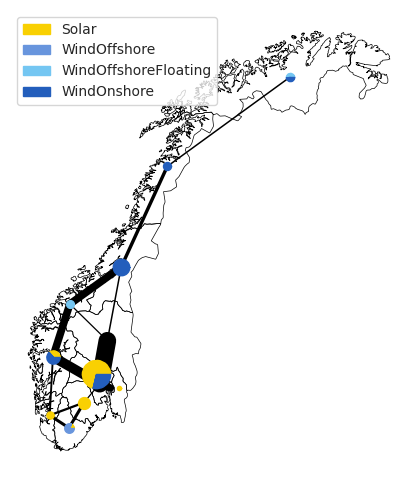

In [205]:
fig, ax = plt.subplots(1,1, figsize=(7,6))

cent = Norway.centroid
Norway.boundary.plot(ax=ax, zorder=1, linewidth=0.5, color='black')

color_mapping = {
    'Solar': '#f9d002',
    'WindOffshore': '#6895dd',
    'WindOffshoreFloating': '#74c6f2',
    'WindOnshore': '#235ebc'
}

offset_dict = {
    'NO42': [0, 0],
    'NO03': [0.6, 0],
    'NO54': [0, 0],
    'NO15': [0, 0],
    'NO38': [0, 0],
    'NO50': [0, 0],
    'NO11': [0, 0],
    'NO34': [0, 0],
    'NO30': [-0.3, 0.3],
    'NO18': [0, 0],
    'NO46': [0, 0],
}


legend_entries = []
for technology, color in color_mapping.items():
    legend_entries.append(mpatches.Patch(color=color, label=technology))

for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
    wedges, labels = fix_optim_pies[i]
    for wedge, label in zip(wedges, labels): 
        color = color_mapping[label.get_text()]
        vertices = wedge.get_path().vertices.tolist()
        size = 900 * fix_optim_cap_frac[i]
        offset_x, offset_y = offset_dict[i]
        ax.scatter(cent.x[i]+offset_x, cent.y[i]+offset_y, marker=(vertices),
                   s=size, zorder=100,
                   facecolor = color)

ax.legend(handles=legend_entries)
ax.axis('off')
linewidth = 100
trans_HVACcolor = 'black'
#trans_HVDCcolor = 'red'

for i in [['NO03', 'NO30'], ['NO11', 'NO38'], ['NO11', 'NO42'], ['NO11', 'NO46'], ['NO15', 'NO34'], ['NO15', 'NO46'], ['NO15', 'NO50'], ['NO18', 'NO50'], ['NO18', 'NO54'], ['NO30', 'NO34'], ['NO30', 'NO38'], ['NO30', 'NO46'],['NO34', 'NO46'], ['NO34', 'NO50'], ['NO38', 'NO42'], ['NO38', 'NO46']]:
    plt.plot([cent[i[0]].x, cent[i[1]].x], [cent[i[0]].y, cent[i[1]].y],
             linewidth=(linewidth*fix_optim_trans.query("Zone_1 == " + "'" + i[0] + "'" + " and Zone_2 == " + "'" + i[1] + "'")
                        .values[0][0]/fix_optim_trans_tot), color=trans_HVACcolor)
    #plt.plot([cent[i[0]].x, cent[i[1]].x], [cent[i[0]].y, cent[i[1]].y], linewidth=(linewidth*trans_new.query("Zone_1 == " + "'" + i[0] + "'" + " and Zone_2 == " + "'" + i[1] + "'").values[1][0]/trans_tot), color=trans_HVDCcolor)
plt.show()


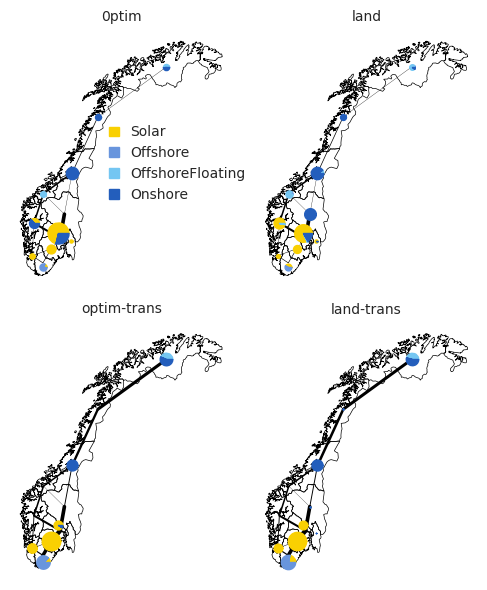

In [1459]:
#Transmission subplot

data_plot = {
    'Optim': {
        'fix': {'pies': fix_optim_pies, 'cap_frac': fix_optim_cap_frac, 'trans': fix_optim_trans, 'trans_tot': fix_optim_trans_tot},
        'lowoh': {'pies': lowoh_optim_pies, 'cap_frac': lowoh_optim_cap_frac, 'trans': lowoh_optim_trans, 'trans_tot': lowoh_optim_trans_tot}
    },
    'Land': {
        'fix': {'pies': fix_land_pies, 'cap_frac': fix_land_cap_frac, 'trans': fix_land_trans, 'trans_tot': fix_land_trans_tot},
        'lowoh': {'pies': lowoh_land_pies, 'cap_frac': lowoh_land_cap_frac, 'trans': lowoh_land_trans, 'trans_tot': lowoh_land_trans_tot}
    }
}
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
#fig.subplots_adjust(wspace=-0.7,  hspace=0, left=0.05, right=0.95, top=0.1, bottom=0)

color_mapping = {
    'Solar': '#f9d002',
    'WindOffshore': '#6895dd',
    'WindOffshoreFloating': '#74c6f2',
    'WindOnshore': '#235ebc'
}

offset_dict1 = {
    'NO42': [0, -0.4], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

offset_dict2 = {
    'NO42': [0, -0.22], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

legend_entries = []
short_labels = {
    'Solar': 'Solar',
    'WindOffshore': 'Offshore',
    'WindOffshoreFloating': 'OffshoreFloating',
    'WindOnshore': 'Onshore'
}
for technology, color in color_mapping.items():
    short_label = short_labels[technology]
    legend_entries.append(mpatches.Patch(color=color, label=short_label))

linewidth = 40
trans_HVACcolor = 'black'

max_trans_tot = lowoh_land_trans_tot #change the maximum value according to scenario plots

def plot_subplot(ax, data, title, ax_row):
    Norway.boundary.plot(ax=ax, zorder=1, linewidth=0.5, color='black')
    
    for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
        wedges, labels = data['pies'][i]
        for wedge, label in zip(wedges, labels): 
            color = color_mapping[label.get_text()]
            vertices = wedge.get_path().vertices.tolist()
            size = 500 * data['cap_frac'][i]
            offset_x, offset_y = offset_dict1[i]
            if ax_row == 0:
                offset_x, offset_y = offset_dict2[i]
            ax.scatter(cent.x[i]+offset_x, cent.y[i]+offset_y, marker=(vertices),
                       s=size, zorder=100, facecolor=color)

    ax.axis('off')
    ax.set_title(title, fontsize=10)
    #trans_HVDCcolor = 'red'

    for i in [['NO03', 'NO30'], ['NO11', 'NO38'], ['NO11', 'NO42'], ['NO11', 'NO46'], 
              ['NO15', 'NO34'], ['NO15', 'NO46'], ['NO15', 'NO50'], ['NO18', 'NO50'], 
              ['NO18', 'NO54'], ['NO30', 'NO34'], ['NO30', 'NO38'], ['NO30', 'NO46'],
              ['NO34', 'NO46'], ['NO34', 'NO50'], ['NO38', 'NO42'], ['NO38', 'NO46']]:
        ax.plot([cent[i[0]].x, cent[i[1]].x], [cent[i[0]].y, cent[i[1]].y],
                 linewidth=(linewidth*data['trans'].query("Zone_1 == " + "'" + i[0] + "'" + " and Zone_2 == " + "'" + i[1] + "'")
                            #.values[0][0]/data['trans_tot']), color=trans_HVACcolor)
                            .values[0][0]/max_trans_tot), color=trans_HVACcolor)
axs[0, 0].legend(handles=legend_entries, borderaxespad=0,frameon=False,handlelength=0.7,
                             fontsize=10, bbox_to_anchor=(0.42, 0.65))


plot_subplot(axs[0, 0], data_plot['Optim']['fix'], '0ptim', 0)
plot_subplot(axs[0, 1], data_plot['Land']['fix'], 'land', 0)
plot_subplot(axs[1, 0], data_plot['Optim']['lowoh'], 'optim-trans', 1)
plot_subplot(axs[1, 1], data_plot['Land']['lowoh'], 'land-trans', 1)

fig.subplots_adjust(wspace=-0.85,  hspace=0, left=0.05, right=0.95, top=0.9, bottom=0)
plt.tight_layout()

plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation2.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation2.jpg', dpi=300, bbox_inches='tight')

plt.show()



In [1455]:
lowoh_optim_trans_tot

104.71968174194971

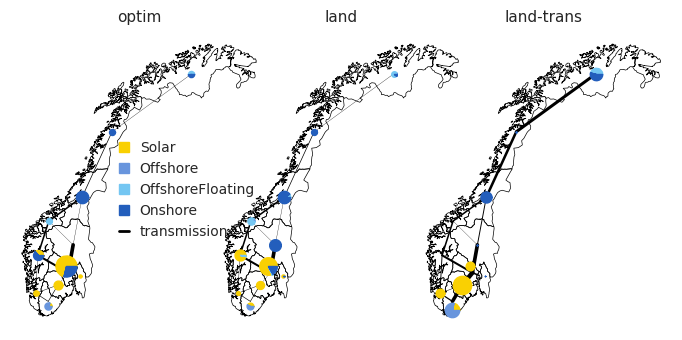

In [1456]:
#Transmission subplot
from matplotlib.lines import Line2D
data_plot = {
    'Optim': {
        'fix': {'pies': fix_optim_pies, 'cap_frac': fix_optim_cap_frac, 'trans': fix_optim_trans, 'trans_tot': fix_optim_trans_tot},
        'lowoh': {'pies': lowoh_optim_pies, 'cap_frac': lowoh_optim_cap_frac, 'trans': lowoh_optim_trans, 'trans_tot': lowoh_optim_trans_tot}
    },
    'Land': {
        'fix': {'pies': fix_land_pies, 'cap_frac': fix_land_cap_frac, 'trans': fix_land_trans, 'trans_tot': fix_land_trans_tot},
        'lowoh': {'pies': lowoh_land_pies, 'cap_frac': lowoh_land_cap_frac, 'trans': lowoh_land_trans, 'trans_tot': lowoh_land_trans_tot}
    }
}
fig, axs = plt.subplots(1, 3, figsize=(14, 3.5))
#fig.subplots_adjust(wspace=-0.7,  hspace=0, left=0.05, right=0.95, top=0.1, bottom=0)

color_mapping = {
    'Solar': '#f9d002',
    'WindOffshore': '#6895dd',
    'WindOffshoreFloating': '#74c6f2',
    'WindOnshore': '#235ebc'
}

offset_dict1 = {
    'NO42': [0, -0.4], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

offset_dict2 = {
    'NO42': [0, -0.22], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

legend_entries = []
short_labels = {
    'Solar': 'Solar',
    'WindOffshore': 'Offshore',
    'WindOffshoreFloating': 'OffshoreFloating',
    'WindOnshore': 'Onshore'
}
for technology, color in color_mapping.items():
    short_label = short_labels[technology]
    legend_entries.append(mpatches.Patch(color=color, label=short_label))

linewidth = 40
trans_HVACcolor = 'black'

# Create a Line2D object for the legend to represent the transmission line
trans_legend = Line2D([0], [0], color=trans_HVACcolor, linewidth=2, label='transmission')

legend_entries.append(trans_legend)

max_trans_tot = lowoh_land_trans_tot #change the maximum value according to scenario plots

def plot_subplot(ax, data, title, ax_row):
    Norway.boundary.plot(ax=ax, zorder=1, linewidth=0.5, color='black')
    
    for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
        wedges, labels = data['pies'][i]
        for wedge, label in zip(wedges, labels): 
            color = color_mapping[label.get_text()]
            vertices = wedge.get_path().vertices.tolist()
            size = 500 * data['cap_frac'][i]
            offset_x, offset_y = offset_dict1[i]
            if ax_row == 0:
                offset_x, offset_y = offset_dict2[i]
            ax.scatter(cent.x[i]+offset_x, cent.y[i]+offset_y, marker=(vertices),
                       s=size, zorder=100, facecolor=color)

    ax.axis('off')
    ax.set_title(title, fontsize=11)
    #trans_HVDCcolor = 'red'

    for i in [['NO03', 'NO30'], ['NO11', 'NO38'], ['NO11', 'NO42'], ['NO11', 'NO46'], 
              ['NO15', 'NO34'], ['NO15', 'NO46'], ['NO15', 'NO50'], ['NO18', 'NO50'], 
              ['NO18', 'NO54'], ['NO30', 'NO34'], ['NO30', 'NO38'], ['NO30', 'NO46'],
              ['NO34', 'NO46'], ['NO34', 'NO50'], ['NO38', 'NO42'], ['NO38', 'NO46']]:
        ax.plot([cent[i[0]].x, cent[i[1]].x], [cent[i[0]].y, cent[i[1]].y],
                 linewidth=(linewidth*data['trans'].query("Zone_1 == " + "'" + i[0] + "'" + " and Zone_2 == " + "'" + i[1] + "'")
                            #.values[0][0]/data['trans_tot']), color=trans_HVACcolor)
                            .values[0][0]/max_trans_tot), color=trans_HVACcolor)
        
axs[0].legend(handles=legend_entries, borderaxespad=0,frameon=False,handlelength=0.7,
                             fontsize=10, bbox_to_anchor=(0.4, 0.65))


plot_subplot(axs[0], data_plot['Optim']['fix'], 'optim', 0)
plot_subplot(axs[1], data_plot['Land']['fix'], 'land', 0)
#plot_subplot(axs[2], data_plot['Optim']['lowoh'], 'Optim-Trans', 1)
plot_subplot(axs[2], data_plot['Land']['lowoh'], 'land-trans', 1)

fig.subplots_adjust(wspace=-0.9,  hspace=-0.9, left=0.05, right=0.95, top=0.9, bottom=0)
plt.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation6.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation2.jpg', dpi=300, bbox_inches='tight')

plt.show()
#Why not having this plot when all preferences are in place ??? Why just for only Land and Trans? Because aiming to show the impact
#on transmission when land+trans take place. trans has similar impact  with optim so not displayed here. Probably one table could be made to 
# in supplemental to show the capacities under all scenarios

In [207]:
lowoh_optim_trans = {}
lowoh_optim_trans_tot={}


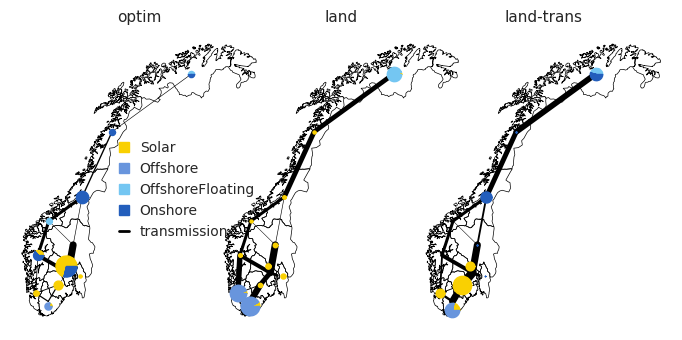

In [212]:
#Transmission subplot for Poster
from matplotlib.lines import Line2D
data_plot = {
    'Optim': {
        'fix': {'pies': fix_optim_pies, 'cap_frac': fix_optim_cap_frac, 'trans': fix_optim_trans, 'trans_tot': fix_optim_trans_tot},
        'lowoh': {'pies': lowoh_optim_pies, 'cap_frac': lowoh_optim_cap_frac, 'trans': lowoh_optim_trans, 'trans_tot': lowoh_optim_trans_tot}
    },
    'Land': {
        'fix': {'pies': cumulative_pies, 'cap_frac': cumulative_cap_frac, 'trans': Cumulative_trans, 'trans_tot': Cumulative_trans_tot},
        'lowoh': {'pies': lowoh_land_pies, 'cap_frac': lowoh_land_cap_frac, 'trans': lowoh_land_trans, 'trans_tot': lowoh_land_trans_tot}
    }
}
fig, axs = plt.subplots(1, 3, figsize=(14, 3.5))
#fig.subplots_adjust(wspace=-0.7,  hspace=0, left=0.05, right=0.95, top=0.1, bottom=0)

color_mapping = {
    'Solar': '#f9d002',
    'WindOffshore': '#6895dd',
    'WindOffshoreFloating': '#74c6f2',
    'WindOnshore': '#235ebc'
}

offset_dict1 = {
    'NO42': [0, -0.4], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

offset_dict2 = {
    'NO42': [0, -0.22], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

legend_entries = []
short_labels = {
    'Solar': 'Solar',
    'WindOffshore': 'Offshore',
    'WindOffshoreFloating': 'OffshoreFloating',
    'WindOnshore': 'Onshore'
}
for technology, color in color_mapping.items():
    short_label = short_labels[technology]
    legend_entries.append(mpatches.Patch(color=color, label=short_label))

linewidth = 40
trans_HVACcolor = 'black'

# Create a Line2D object for the legend to represent the transmission line
trans_legend = Line2D([0], [0], color=trans_HVACcolor, linewidth=2, label='transmission')

legend_entries.append(trans_legend)

max_trans_tot = fix_optim_trans_tot #change the maximum value according to scenario plots

def plot_subplot(ax, data, title, ax_row):
    Norway.boundary.plot(ax=ax, zorder=1, linewidth=0.5, color='black')
    
    for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
        wedges, labels = data['pies'][i]
        for wedge, label in zip(wedges, labels): 
            color = color_mapping[label.get_text()]
            vertices = wedge.get_path().vertices.tolist()
            size = 500 * data['cap_frac'][i]
            offset_x, offset_y = offset_dict1[i]
            if ax_row == 0:
                offset_x, offset_y = offset_dict2[i]
            ax.scatter(cent.x[i]+offset_x, cent.y[i]+offset_y, marker=(vertices),
                       s=size, zorder=100, facecolor=color)

    ax.axis('off')
    ax.set_title(title, fontsize=11)
    #trans_HVDCcolor = 'red'

    for i in [['NO03', 'NO30'], ['NO11', 'NO38'], ['NO11', 'NO42'], ['NO11', 'NO46'], 
              ['NO15', 'NO34'], ['NO15', 'NO46'], ['NO15', 'NO50'], ['NO18', 'NO50'], 
              ['NO18', 'NO54'], ['NO30', 'NO34'], ['NO30', 'NO38'], ['NO30', 'NO46'],
              ['NO34', 'NO46'], ['NO34', 'NO50'], ['NO38', 'NO42'], ['NO38', 'NO46']]:
        ax.plot([cent[i[0]].x, cent[i[1]].x], [cent[i[0]].y, cent[i[1]].y],
                 linewidth=(linewidth*data['trans'].query("Zone_1 == " + "'" + i[0] + "'" + " and Zone_2 == " + "'" + i[1] + "'")
                            #.values[0][0]/data['trans_tot']), color=trans_HVACcolor)
                            .values[0][0]/max_trans_tot), color=trans_HVACcolor)
        
axs[0].legend(handles=legend_entries, borderaxespad=0,frameon=False,handlelength=0.7,
                             fontsize=10, bbox_to_anchor=(0.4, 0.65))


plot_subplot(axs[0], data_plot['Optim']['fix'], 'optim', 0)
plot_subplot(axs[1], data_plot['Land']['fix'], 'land', 0)
#plot_subplot(axs[2], data_plot['Optim']['lowoh'], 'Optim-Trans', 1)
plot_subplot(axs[2], data_plot['Land']['lowoh'], 'land-trans', 1)

fig.subplots_adjust(wspace=-0.9,  hspace=-0.9, left=0.05, right=0.95, top=0.9, bottom=0)
plt.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation6.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation2.jpg', dpi=300, bbox_inches='tight')

plt.show()
#Why not having this plot when all preferences are in place ??? Why just for only Land and Trans? Because aiming to show the impact
#on transmission when land+trans take place. trans has similar impact  with optim so not displayed here. Probably one table could be made to 
# in supplemental to show the capacities under all scenarios

# Equitability

In [590]:
clusterpath = "/cluster/work/projects/ec85/EFF/"

In [591]:
scenarios = glob.glob(clusterpath + "results/**/*.db", recursive=True)

In [592]:
scenarios

['/cluster/work/projects/ec85/EFF/results/models/2010/2010_2030_region_DefaultNO_2_QS1_CSD_CWDH_NSD_NWD_fylketechC_0.09_0.15_0.2/results.db',
 '/cluster/work/projects/ec85/EFF/results/models/2010/2010_2040_region_DefaultYes_2_QS1_CSD_CWDHA_NSD_NWD_fylketechC_0.09_0.15_0.2/results.db',
 '/cluster/work/projects/ec85/EFF/results/models/2010/2010_2030_region_DefaultYes_2_QS1_CSD_CWDH_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db',
 '/cluster/work/projects/ec85/EFF/results/models/2010/2010_2030_region_DefaultNO_0_OPT_CSD_CWDH_NSD_NWD_fylketechC_0.09_0.15_0.2/results.db',
 '/cluster/work/projects/ec85/EFF/results/models/2010/2010_2050_region_LOWOH_10_QS1_CSD_CWD_NSD_NWD_fylketechC_0.09_0.15_0.2/results.db',
 '/cluster/work/projects/ec85/EFF/results/models/2010/2010_2050_region_LOWOH_0_OPT_CSD_CWDHAF_NSD_NWD_fylketechC_0.09_0.15_0.2/results.db',
 '/cluster/work/projects/ec85/EFF/results/models/2010/2010_2030_region_DefaultNO_0_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2/results.db',
 '/cluster

In [593]:
for i in range(len(scenarios)):
    scenarios[i] = scenarios[i].replace('/cluster/work/projects/ec85/EFF/','')
    scenarios[i] = scenarios[i].replace('results/models/2010/','')    
    scenarios[i] = scenarios[i].replace('.db','')
    scenarios[i] = scenarios[i].replace('/results','')

In [594]:
scenarios_short = scenarios

In [595]:
ind_scenario_string = ['2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_LOWOH_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_2_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_1_QS1_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechC_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_LOWOH_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_2_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_1_QS1_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechC_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_LOWOH_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_2_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_QS1_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechC_0.09_0.15_0.2'
]

In [596]:
ind_filtered_strings = [s for s in scenarios_short if s in ind_scenario_string]

In [597]:
ind_filtered_strings

['2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_2_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechC_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechC_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_2_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2030_region_DefaultYes_1_QS1_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_QS1_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_LOWOH_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_DefaultYes_1_QS1_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2040_region_LOWOH_1_OPT_CSD_CWD_NSD_NWD_fylk

In [598]:
gen = []
how = 'quick'

if how == 'quick':
    for scenario in tqdm(ind_filtered_strings):
        con = sqlite3.connect(clusterpath + "results/models/2010/" + str(scenario) + "/results.db")
        gen.append(
            pd
            .read_sql_query("SELECT * from var_gen", con)
            .drop(columns={'lo','up','marginal'})   #It is optional
            .set_index(['z','h','g'])
            .stack()
            .reset_index()
            .rename(columns={
                        "z": "zone",
                        "g": "technology",
                        "h": "hour",
                        "level_3" : "type",
                        0: 'electricity_generatioN_GWh'
                    })
            .assign(scenario=scenario)
            .astype({'hour' : int})
            .set_index(['scenario','zone','technology','hour','type'])
            .sort_index()
            )
        con.close()
    df_gen = pd.concat(gen)
    del(gen)
    df_gen

  0%|          | 0/18 [00:00<?, ?it/s]

In [599]:
df_gen

electricity_generatioN_GWh
scenario                                           zone technology  hour type                             
2010_2030_region_DefaultYes_1_OPT_CSD_CWD_NSD_N... NO03 HydroRoR    0    level                    0.004700
                                                                    1    level                    0.004700
                                                                    2    level                    0.004700
                                                                    3    level                    0.004700
                                                                    4    level                    0.004700
...                                                                                                    ...
2010_2050_region_DefaultYes_1_OPT_CSD_CWD_NSD_N... NO54 Windonshore 8755 level                    0.430094
                                                                    8756 level                    0.398235
                                                                    8757 level                    0.382306
                                                                    8758 level                    0.302659
                                                                    8759 level                    0.270800

[15925680 rows x 1 columns]

In [600]:
gen = (df_gen
       .loc[slice(None),slice(None),slice(None),slice(None),'level']
       .groupby(['scenario','zone'])
       .sum()
       .reset_index()
       .set_index(['scenario','zone'])
           .rename(columns={'electricity_generatioN_GWh' : 'generation_GWh'})

)


In [601]:
gen

generation_GWh
scenario                                           zone                
2010_2030_region_DefaultYes_1_OPT_CSD_CWDHAF_NS... NO03       48.601107
                                                   NO11    14240.801041
                                                   NO15    11100.107137
                                                   NO18    19486.438790
                                                   NO30    41753.079446
...                                                                 ...
2010_2050_region_LOWOH_1_OPT_CSD_CWD_NSD_NWD_fy... NO38    33984.143260
                                                   NO42    84799.377781
                                                   NO46    32372.270896
                                                   NO50    24769.280087
                                                   NO54    41301.546064

[198 rows x 1 columns]

In [602]:
string2050 = ['2010_2050_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_LOWOH_1_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_2_OPT_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_QS1_CSD_CWD_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2',
 '2010_2050_region_DefaultYes_1_OPT_CSD_CWD_NSD_NWD_fylketechC_0.09_0.15_0.2']

In [603]:
pd.set_option('display.max_colwidth', None)

In [604]:
replacement_names = ['optim', 'trans', 'trade', 'tech', 'land', 'region']
gen2050 = gen.loc[string2050].reset_index()
gen2050['scenario_name'] = gen2050['scenario'].apply(
    lambda x: replacement_names[string2050.index(x)] if x in string2050 else x
)

gen2050[gen2050['scenario_name'] == 'land']

scenario  \
44  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
45  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
46  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
47  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
48  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
49  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
50  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
51  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
52  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
53  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   
54  2010_2050_region_DefaultYes_1_OPT_CSD_CWDHAF_NSD_NWD_fylketechD_0.09_0.15_0.2   

    zone  generation_GWh scenario_name  
44  NO03      842.767218          land  
45  NO11    15635.069519          land  
46  NO15    27938.825696          land  
47  NO18    23328.346572          land  
48  NO30    49823.504275          land  
49  NO34    26653.981256          land  
50  NO38    15923.333850          land  
51  NO42    34881.531725          land  
52  NO46    43891.908145          land  
53  NO50    33475.987626          land  
54  NO54    17281.910876          land

In [605]:
gen2050 = gen2050.groupby(['scenario_name', 'zone']).sum()

/tmp/ipykernel_1600841/2990261998.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen2050 = gen2050.groupby(['scenario_name', 'zone']).sum()


In [606]:
gen2050

generation_GWh
scenario_name zone                
land          NO03      842.767218
              NO11    15635.069519
              NO15    27938.825696
              NO18    23328.346572
              NO30    49823.504275
...                            ...
trans         NO38    33984.143260
              NO42    84799.377781
              NO46    32372.270896
              NO50    24769.280087
              NO54    41301.546064

[66 rows x 1 columns]

In [607]:
filtered_demand = dem[(dem.index.get_level_values('transmission') != 'DefaultNO')&
                      (dem.index.get_level_values('ImpExp').isin(['1', '2']))] 

In [608]:
demand_Ind_pref = filtered_demand.query(Ind_query_string_2)

In [638]:
replacement_names = ['optim', 'trans', 'trade', 'tech', 'land', 'region']
scenarios_demand = pd.DataFrame()

In [51]:
demand_Ind_pref

value
demandyear transmission ImpExp varnewpcapQ corines_solar corines_onshore fylke_techs zone hour          
2030       DefaultYes   1      OPT         CSD           CWD             fylketechD  NO03 0     1.578478
                                                                                          1     1.530680
                                                                                          2     1.502299
                                                                                          3     1.489948
                                                                                          4     1.518702
...                                                                                                  ...
2050       DefaultYes   1      OPT         CSD           CWD             fylketechD  NO54 8755  1.858600
                                                                                          8756  1.837100
                                                                                          8757  1.796200
                                                                                          8758  1.758700
                                                                                          8759  1.719000

[1734480 rows x 1 columns]

In [645]:
# Need to manually change the query for getting demand scenarios
result = demand_Ind_pref.query("demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1'and "
                "varnewpcapQ == 'OPT' and corines_onshore == 'CWD' and "
                "corines_solar == 'CSD' and fylke_techs == 'fylketechC'").groupby('zone').sum()
result['scenario'] = 'region'
scenarios_demand = scenarios_demand.append(result)

/tmp/ipykernel_1600841/1283805740.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_demand = scenarios_demand.append(result)


In [646]:
scenarios_demand

value scenario
zone                     
NO03  16739.9436     land
NO11  28438.8274     land
NO15  25333.9905     land
NO18  23371.0442     land
NO30  36418.4166     land
...          ...      ...
NO38  24398.4115   region
NO42  19922.5443   region
NO46  42929.7889   region
NO50  20457.0884   region
NO54  14960.0577   region

[66 rows x 2 columns]

In [647]:
scenarios_demand = scenarios_demand.groupby(['scenario', 'zone']).sum()

In [1229]:
scenarios_demand

value
scenario zone            
land     NO03  16739.9436
         NO11  28438.8274
         NO15  25333.9905
         NO18  23371.0442
         NO30  36418.4166
...                   ...
trans    NO38  24398.4115
         NO42  19922.5443
         NO46  42929.7889
         NO50  20457.0884
         NO54  14960.0577

[66 rows x 1 columns]

In [617]:
df_pop_area = pd.read_csv("/fp/homes01/u01/ec-javedm/ec85/models/shahzad/df_pop_area.csv").set_index('zone')

In [1228]:
df_pop_area

name  Population      Area
zone                                            
NO03                  Oslo      717710    426.40
NO11              Rogaland      499417   8575.73
NO15       Møre og Romsdal      270624  13839.56
NO18              Nordland      243081  35759.14
NO30                 Viken     1310774  22768.30
NO34             Innlandet      376304  49390.84
NO38  Vestfold og Telemark      433525  15924.74
NO42                 Agder      319850  14981.02
NO46              Vestland      651299  31968.72
NO50             Trøndelag      482956  39493.47
NO54     Troms og Finnmark      244663  70920.72

In [619]:
captotzF = captotz.droplevel(["corines_solar"]).loc[(slice(None), slice(None), slice(None), slice(None), slice(None),
                    slice(None), slice(None), ['Solar','Windonshore','Windoffshore','Windoffshorefloating', 'HydroRes', 'HydroRoR'],
                                          'level')].droplevel(["level_2"])

In [620]:
filtered_captotzF= captotzF[(captotzF.index.get_level_values('transmission') != 'DefaultNO')&
                      (captotzF.index.get_level_values('ImpExp').isin(['1', '2']))]

In [621]:
df_captotzF = filtered_captotzF.query(Ind_query_string_2)
df_captotzF = df_captotzF.groupby([
    "demandyear", "transmission", "ImpExp", "varnewpcapQ", "corines_onshore", "fylke_techs", "zone"]).sum()

In [622]:
df_captotzF.reset_index()

demandyear transmission ImpExp varnewpcapQ corines_onshore fylke_techs  \
0         2030   DefaultYes      1         OPT             CWD  fylketechC   
1         2030   DefaultYes      1         OPT             CWD  fylketechC   
2         2030   DefaultYes      1         OPT             CWD  fylketechC   
3         2030   DefaultYes      1         OPT             CWD  fylketechC   
4         2030   DefaultYes      1         OPT             CWD  fylketechC   
..         ...          ...    ...         ...             ...         ...   
193       2050        LOWOH      1         OPT             CWD  fylketechD   
194       2050        LOWOH      1         OPT             CWD  fylketechD   
195       2050        LOWOH      1         OPT             CWD  fylketechD   
196       2050        LOWOH      1         OPT             CWD  fylketechD   
197       2050        LOWOH      1         OPT             CWD  fylketechD   

     zone     gencap  
0    NO03   0.824700  
1    NO11   4.473718  
2    NO15   3.257574  
3    NO18   4.474481  
4    NO30   4.693757  
..    ...        ...  
193  NO38  24.907913  
194  NO42  15.326017  
195  NO46   9.168959  
196  NO50   9.600263  
197  NO54  11.464788  

[198 rows x 8 columns]

In [623]:
replacement_names = ['optim', 'trans', 'trade', 'tech', 'land', 'region']
scenarios_gencap = pd.DataFrame()

In [629]:
# Need to manually change the query for getting demand scenarios
result = df_captotzF.query("demandyear == '2050' and transmission == 'DefaultYes' and ImpExp == '1'and "
                "varnewpcapQ == 'OPT' and corines_onshore == 'CWDHAF' and "
                "fylke_techs == 'fylketechD'").groupby('zone').sum()
result['scenario'] = 'land'
scenarios_gencap = scenarios_gencap.append(result)

/tmp/ipykernel_1600841/2727295944.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_gencap = scenarios_gencap.append(result)


In [630]:
scenarios_gencap = scenarios_gencap.groupby(["scenario", "zone"]).sum()

In [634]:
scenarios_demand

value
scenario zone            
optim    NO03  16739.9436
         NO11  28438.8274
         NO15  25333.9905
         NO18  23371.0442
         NO30  36418.4166
         NO34  13257.1181
         NO38  24398.4115
         NO42  19922.5443
         NO46  42929.7889
         NO50  20457.0884
         NO54  14960.0577
region   NO03  16739.9436
         NO11  28438.8274
         NO15  25333.9905
         NO18  23371.0442
         NO30  36418.4166
         NO34  13257.1181
         NO38  24398.4115
         NO42  19922.5443
         NO46  42929.7889
         NO50  20457.0884
         NO54  14960.0577
tech     NO03  16739.9436
         NO11  28438.8274
         NO15  25333.9905
         NO18  23371.0442
         NO30  36418.4166
         NO34  13257.1181
         NO38  24398.4115
         NO42  19922.5443
         NO46  42929.7889
         NO50  20457.0884
         NO54  14960.0577
trade    NO03  16739.9436
         NO11  28438.8274
         NO15  25333.9905
         NO18  23371.0442
         NO30  36418.4166
         NO34  13257.1181
         NO38  24398.4115
         NO42  19922.5443
         NO46  42929.7889
         NO50  20457.0884
         NO54  14960.0577
trans    NO03  16739.9436
         NO11  28438.8274
         NO15  25333.9905
         NO18  23371.0442
         NO30  36418.4166
         NO34  13257.1181
         NO38  24398.4115
         NO42  19922.5443
         NO46  42929.7889
         NO50  20457.0884
         NO54  14960.0577

In [635]:
gen2050

generation_GWh
scenario_name zone                
land          NO03      842.767218
              NO11    15635.069519
              NO15    27938.825696
              NO18    23328.346572
              NO30    49823.504275
...                            ...
trans         NO38    33984.143260
              NO42    84799.377781
              NO46    32372.270896
              NO50    24769.280087
              NO54    41301.546064

[66 rows x 1 columns]

In [649]:
dem_gen_self = gen2050.assign(
    demand = scenarios_demand.value,
    self_suf = lambda x: x.generation_GWh/x.demand,
)

In [650]:
dem_gen_self.head(22)

generation_GWh      demand  self_suf
scenario_name zone                                      
land          NO03      842.767218  16739.9436  0.050345
              NO11    15635.069519  28438.8274  0.549779
              NO15    27938.825696  25333.9905  1.102820
              NO18    23328.346572  23371.0442  0.998173
              NO30    49823.504275  36418.4166  1.368085
              NO34    26653.981256  13257.1181  2.010541
              NO38    15923.333850  24398.4115  0.652638
              NO42    34881.531725  19922.5443  1.750857
              NO46    43891.908145  42929.7889  1.022411
              NO50    33475.987626  20457.0884  1.636400
              NO54    17281.910876  14960.0577  1.155203
optim         NO03      814.073817  16739.9436  0.048631
              NO11    16780.293861  28438.8274  0.590049
              NO15    20331.094955  25333.9905  0.802522
              NO18    22835.305849  23371.0442  0.977077
              NO30    68219.456051  36418.4166  1.873213
              NO34     8140.188010  13257.1181  0.614024
              NO38    17203.582523  24398.4115  0.705111
              NO42    38600.954417  19922.5443  1.937551
              NO46    44979.215320  42929.7889  1.047739
              NO50    31611.226150  20457.0884  1.545246
              NO54    16368.238930  14960.0577  1.094129

In [651]:
#Gini coefficients
#Self_sufficiency: zones generation based on what they consume (Gen per dem)
df_score = pd.DataFrame(columns=['scenario','principle','zone','score'])
df_score

Empty DataFrame
Columns: [scenario, principle, zone, score]
Index: []

In [652]:
df_gini = pd.DataFrame(columns=['scenario','gini_c','principle' ])
temp_gen_dem = pd.DataFrame(columns=['scenario_name','zone', 'cumulative_gen', 'cumulative_dem', 'principle'])

for scenario in tqdm(dem_gen_self.reset_index().scenario_name.unique()):
    temp = dem_gen_self.loc[scenario, slice(None)].assign(
        share_gen = lambda x : x.generation_GWh/x.generation_GWh.sum(),
        share_dem = lambda x : x.demand/x.demand.sum()
    ).sort_values(
        'self_suf',
        ascending = True
    ).assign(
        cumulative_gen = lambda x: x.share_gen.cumsum(),
        cumulative_dem = lambda x: x.share_dem.cumsum(),
        score = lambda x: x.share_gen * (x.share_dem + 2*(1-x.cumulative_dem))        
    )
    gini = 1-temp.score.sum()
    df_gini = pd.concat([df_gini, pd.DataFrame({'scenario': scenario, 'gini_c': gini, 'principle': 'genperdem'}, index=[0])])

    temp_temp = temp.reset_index().sort_values('self_suf', ascending = True).assign(scenario_name=scenario,
                    principle='genperdem').loc[:, ['zone', 'cumulative_gen', 'cumulative_dem', 'scenario_name', 'principle']] 
    temp_temp_frame = [temp_gen_dem, temp_temp]
    temp_gen_dem = pd.concat(temp_temp_frame)
    
    new_score = temp.reset_index().loc[
        :, ["zone", "self_suf"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.self_suf/x.self_suf.sum(),
        principle = 'genperdem'        
    ).drop(
        columns={'self_suf'}
    )
    frames = [df_score, new_score]
    df_score = pd.concat(frames)            #Each time run, repeatedly add the same rows, be careful

    
df_score


  0%|          | 0/6 [00:00<?, ?it/s]

scenario  principle  zone     score
0      land  genperdem  NO03  0.004094
1      land  genperdem  NO11  0.044707
2      land  genperdem  NO38  0.053072
3      land  genperdem  NO18  0.081170
4      land  genperdem  NO46  0.083141
..      ...        ...   ...       ...
6     trans  genperdem  NO46  0.056833
7     trans  genperdem  NO50  0.091255
8     trans  genperdem  NO38  0.104979
9     trans  genperdem  NO54  0.208076
10    trans  genperdem  NO42  0.320802

[66 rows x 4 columns]

In [653]:
#Equality: Zones equity based on population
temp_cap_pop = pd.DataFrame(columns=['scenario_name','zone', 'cumulative_cap', 'cumulative_pop', 'cap_per_pop', 'principle'])

for scenario in tqdm(scenarios_gencap.reset_index().scenario.unique()):
    temp = scenarios_gencap.loc[scenario].assign(
        share_cap = lambda x : x.gencap/x.gencap.sum(),
        population = df_pop_area.Population,
        cap_per_pop = lambda x : x.gencap/x.population,
        share_pop = lambda x : x.population/x.population.sum()
    ).sort_values(
            'cap_per_pop',
            ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_pop = lambda x: x.share_pop.cumsum(),
        score = lambda x: x.share_cap * (x.share_pop + 2*(1-x.cumulative_pop))
    )

    gini = 1-temp.score.sum()

    # Check if the combination of scenario and principle already exists in the DataFrame
    if ((df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperpop')).any():
    # Update the gini_c value for the existing row
        df_gini.loc[(df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperpop'), 'gini_c'] = gini
    else:
    # Add a new row to the DataFrame
        new_row = pd.DataFrame({'scenario': [scenario], 'gini_c': [gini], 'principle': ['capperpop']})
        df_gini = pd.concat([df_gini, new_row], ignore_index=True)

    temp_temp = temp.reset_index().sort_values('cap_per_pop', ascending = True).assign(scenario_name=scenario,
                    principle='capperpop').loc[:, ['zone', 'cumulative_cap', 'cumulative_pop',
                                                   'cap_per_pop', 'scenario_name', 'principle']] 
    temp_temp_frame = [temp_cap_pop, temp_temp]
    temp_cap_pop = pd.concat(temp_temp_frame)

    new_score = temp.reset_index().loc[
        :,["zone","cap_per_pop"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.cap_per_pop/x.cap_per_pop.sum(),
        principle = 'capperpop'
    ).drop(
        columns={'cap_per_pop'}
    )

    frames = [df_score, new_score]
    df_score = pd.concat(frames)            #be careful, it duplicates the values with each rerun    
    
    


df_score

  0%|          | 0/6 [00:00<?, ?it/s]

scenario  principle  zone     score
0      land  genperdem  NO03  0.004094
1      land  genperdem  NO11  0.044707
2      land  genperdem  NO38  0.053072
3      land  genperdem  NO18  0.081170
4      land  genperdem  NO46  0.083141
..      ...        ...   ...       ...
6     trans  capperpop  NO11  0.081153
7     trans  capperpop  NO50  0.082608
8     trans  capperpop  NO54  0.194736
9     trans  capperpop  NO42  0.199128
10    trans  capperpop  NO38  0.238766

[132 rows x 4 columns]

In [654]:
#Equality: Zones equity based on areas
temp_cap_area = pd.DataFrame(columns=['scenario_name','zone', 'cumulative_cap', 'cumulative_area', 'cap_per_area', 'principle'])

for scenario in tqdm(scenarios_gencap.reset_index().scenario.unique()):
    temp = scenarios_gencap.loc[scenario].assign(
        share_cap = lambda x : x.gencap/x.gencap.sum(),
        land_area = df_pop_area.Area,
        cap_per_area = lambda x : x.gencap/x.land_area,
        share_area = lambda x : x.land_area/x.land_area.sum()
    ).sort_values(
            'cap_per_area',
            ascending=True
    ).assign(
        cumulative_cap = lambda x: x.share_cap.cumsum(),
        cumulative_area = lambda x: x.share_area.cumsum(),
        score = lambda x: x.share_cap * (x.share_area + 2*(1-x.cumulative_area))
    )

    gini = 1-temp.score.sum()

    # Check if the combination of scenario and principle already exists in the DataFrame
    if ((df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperarea')).any():
    # Update the gini_c value for the existing row
        df_gini.loc[(df_gini['scenario'] == scenario) & (df_gini['principle'] == 'capperarea'), 'gini_c'] = gini
    else:
    # Add a new row to the DataFrame
        new_row = pd.DataFrame({'scenario': [scenario], 'gini_c': [gini], 'principle': ['capperarea']})
        df_gini = pd.concat([df_gini, new_row], ignore_index=True)

    temp_temp = temp.reset_index().sort_values('cap_per_area', ascending = True).assign(scenario_name=scenario,
                    principle='capperarea').loc[:, ['zone', 'cumulative_cap', 'cumulative_area',
                                                    'cap_per_area', 'scenario_name', 'principle']] 
    temp_temp_frame = [temp_cap_area, temp_temp]
    temp_cap_area = pd.concat(temp_temp_frame)

    new_score = temp.reset_index().loc[
        :,["zone","cap_per_area"]
    ].assign(
        scenario = scenario,
        score = lambda x : x.cap_per_area/x.cap_per_area.sum(),
        principle = 'capperarea'
    ).drop(
        columns={'cap_per_area'}
    )

    frames = [df_score, new_score]
    df_score = pd.concat(frames)            #be careful, it duplicates the values with each rerun    
    
    


df_score

  0%|          | 0/6 [00:00<?, ?it/s]

scenario   principle  zone     score
0      land   genperdem  NO03  0.004094
1      land   genperdem  NO11  0.044707
2      land   genperdem  NO38  0.053072
3      land   genperdem  NO18  0.081170
4      land   genperdem  NO46  0.083141
..      ...         ...   ...       ...
6     trans  capperarea  NO46  0.056570
7     trans  capperarea  NO30  0.073202
8     trans  capperarea  NO42  0.201779
9     trans  capperarea  NO11  0.224304
10    trans  capperarea  NO38  0.308498

[198 rows x 4 columns]

In [90]:
temp_cap_area

scenario_name  zone  cumulative_cap  cumulative_area  cap_per_area  \
0           land  NO54        0.031590         0.233255      0.000052   
1           land  NO18        0.090845         0.350864      0.000195   
2           land  NO34        0.210442         0.513308      0.000285   
3           land  NO50        0.339732         0.643200      0.000385   
4           land  NO15        0.391574         0.688718      0.000441   
..           ...   ...             ...              ...           ...   
6          trans  NO46        0.395129         0.795264      0.000287   
7          trans  NO30        0.482595         0.870147      0.000371   
8          trans  NO42        0.641233         0.919419      0.001023   
9          trans  NO11        0.742181         0.947624      0.001137   
10         trans  NO38        1.000000         1.000000      0.001564   

     principle  
0   capperarea  
1   capperarea  
2   capperarea  
3   capperarea  
4   capperarea  
..         ...  
6   capperarea  
7   capperarea  
8   capperarea  
9   capperarea  
10  capperarea  

[66 rows x 6 columns]

In [214]:
#ploting dataframes for equity/gini
temp_gen_dem
temp_cap_pop
temp_cap_area
df_score
df_gini

scenario    gini_c   principle
0      land  0.242934   genperdem
1     optim  0.273579   genperdem
2    region  0.338811   genperdem
3      tech  0.252588   genperdem
4     trade  0.316908   genperdem
5     trans  0.440928   genperdem
6      land  0.263217   capperpop
7     optim  0.283462   capperpop
8    region  0.441436   capperpop
9      tech  0.376488   capperpop
10    trade  0.284401   capperpop
11    trans  0.504842   capperpop
12     land  0.431099  capperarea
13    optim  0.552977  capperarea
14   region  0.464286  capperarea
15     tech  0.357768  capperarea
16    trade  0.566837  capperarea
17    trans  0.522846  capperarea

<Figure size 800x800 with 0 Axes>

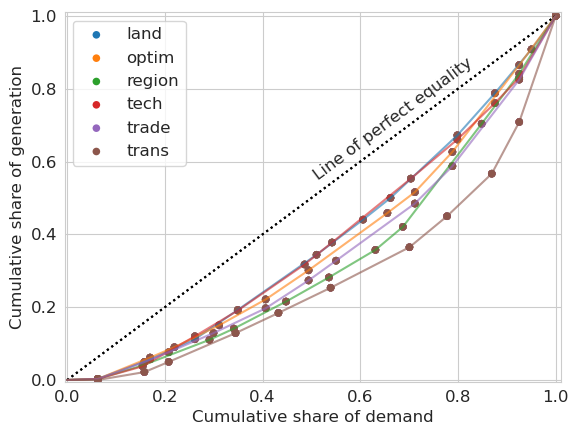

In [655]:
# zone score plot

# create the df for the linear plot
df1 = pd.DataFrame({
   'x': [0,1],
   'y': [0,1]
   }
)

plt.figure(figsize=(8,8))
ax = df1.plot(
    legend = False,
    linestyle = ':',
    color = 'k',
    #ax=plt.gca()
)

colors = sns.color_palette('tab10', n_colors=temp_gen_dem['scenario_name'].nunique())

for idx, scenario in enumerate(temp_gen_dem['scenario_name'].unique()):
    scenario_data = temp_gen_dem[temp_gen_dem['scenario_name'] == scenario]
    
    ax.scatter(
    x = temp_gen_dem['cumulative_dem'],
    y = temp_gen_dem['cumulative_gen'],
    label=scenario,
    color=colors[idx],
    s = 30,
    edgecolor='none'
    #xlim = [0,1],
    #ylim = [0,1],
    )

    # Prepare data for interpolation
    x = scenario_data['cumulative_dem'].to_numpy(copy=True)
    x = np.insert(x, 0, 0)
    y = scenario_data['cumulative_gen'].to_numpy(copy=True)
    y = np.insert(y, 0, 0)

    # Interpolate and the line
    f = interp1d(x, y)
    B = integrate.quad(f,0,1, epsabs = 1e-4)            #Integarting the piecewise funtion from 0 to 1
    G = 1-2*B[0]
    #x_interp = np.linspace(0, 1, num=500)
    #y_interp = f(x_interp)
    ax.plot(x, y, color=colors[idx], linestyle='-', alpha=0.6)

plt.text(
    df1.x.mean(),
    df1.y.mean()+0.05, 
    'Line of perfect equality',
    rotation = 45,
    #rotation=math.degrees(math.atan(a/b)), 
    #ha = 'center',
    transform_rotates_text=True,
    size = 12
)

ax.set_xlabel('Cumulative share of demand', fontsize=12)
ax.set_ylabel('Cumulative share of generation', fontsize=12)
ax.set_xlim(-0.005, 1.01)
ax.set_ylim(-0.005, 1.01)

handles, labels = ax.get_legend_handles_labels()
unique_labels = {label: handle for handle, label in zip(handles[2:], labels[2:])}
ax.tick_params(axis='both', which='both', direction='out', length=2, labelsize=12)
ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12, title_fontsize=14)    


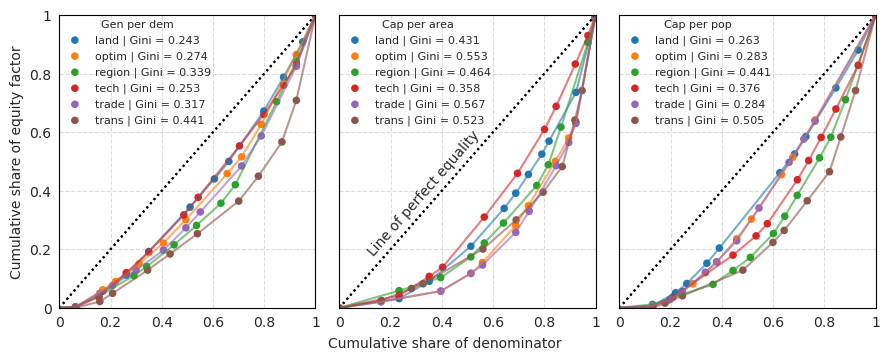

In [680]:
plt.figure(figsize=(9, 3.5))


dataframes = [temp_gen_dem, temp_cap_area, temp_cap_pop]
x_columns = ['cumulative_dem', 'cumulative_area', 'cumulative_pop']
y_columns = ['cumulative_gen', 'cumulative_cap', 'cumulative_cap']
subplot_texts = ['Gen per dem', 'Cap per area', 'Cap per pop']

for i, (df, x_col, y_col) in enumerate(zip(dataframes, x_columns, y_columns), 1):
    ax = plt.subplot(1, 3, i)

    df1 = pd.DataFrame({'x': [0,1], 'y': [0,1]})
    df1.plot(legend=None, linestyle=':', color='k', ax=ax)

    colors = sns.color_palette('tab10', n_colors=df['scenario_name'].nunique())

    scatter_handles = []
    scatter_labels = []    

    for idx, scenario in enumerate(df['scenario_name'].unique()):
        scenario_data = df[df['scenario_name'] == scenario]
        principle = scenario_data['principle'].unique()[0]

        gini_value = round(df_gini.set_index(['scenario', 'principle']).loc[(str(scenario), str(principle))].gini_c, 3)
        label = f"{scenario} | Gini = {gini_value}"
        scatter = ax.scatter(
            x=scenario_data[x_col],
            y=scenario_data[y_col],
            label= label,
            color=colors[idx],
            s=30,
            edgecolor='none'
        )

        scatter_handles.append(scatter)
        scatter_labels.append(label)
        
        x = scenario_data[x_col].to_numpy(copy=True)
        x = np.insert(x, 0, 0)
        y = scenario_data[y_col].to_numpy(copy=True)
        y = np.insert(y, 0, 0)
        
        f = interp1d(x, y)
        B = integrate.quad(f, 0, 1, epsabs=1e-4)
        G = 1 - 2 * B[0]
        
        ax.plot(x, y, color=colors[idx], linestyle='-', alpha=0.6)
        ax.grid(True, linestyle='--', alpha=0.7)
    #ax.tick_params(axis='both', which='major', labelsize=8)

    if i == 2:
        plt.text(
            df1.x.mean()-0.4,
            df1.y.mean()-0.32,
            'Line of perfect equality',
            rotation=45,
            transform_rotates_text=True,
            size=10
        )

    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
    #ax.set_xlabel(f'Cumulative share of {x_col.split("_")[1]}', fontsize=12)
    #ax.set_ylabel(f'Cumulative share of {y_col.split("_")[1]}', fontsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', which='both', direction='out', length=2, labelsize=10)

    if i != 1:
        ax.tick_params(axis='y', which='both', length=0, labelleft=False)
    else:
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
        ax.set_ylabel('Cumulative share of equity factor', fontsize=10)


    #ax.text(0.5, 0.96, subplot_texts[i-1], transform=ax.transAxes, ha='center', va='top')
    ax.legend(handles=scatter_handles, labels=scatter_labels, title=f"{subplot_texts[i-1]}",borderaxespad=0,frameon=False,
              fontsize=8, title_fontsize=8)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')


fig = plt.gcf()
fig.text(0.5, -0.01, 'Cumulative share of denominator', ha='center', fontsize=10)


plt.tight_layout()

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Equity_analysis.png', dpi=300, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Equity_analysis.jpg', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
#Outreach: People preferences not necessarily increase the equity but it could go both ways, i.e., making equality worst or
# good. Regradless of prefence scenario, the gini vaues remain higher for trading and transmission scenarios illustrating 
# model installed the new capacities in the zones that are linked to neighbouring countries, exporting the electricity while importing
# to meet the demand of zones that donot have interconnections. For example: 
# Land and regional preferences making the system more equatible then optimal case for all of the equality definations. 

In [262]:

df_gini

scenario    gini_c   principle
0      land  0.242934   genperdem
1     optim  0.273579   genperdem
2    region  0.338811   genperdem
3      tech  0.252588   genperdem
4     trade  0.316908   genperdem
5     trans  0.440928   genperdem
6      land  0.263217   capperpop
7     optim  0.283462   capperpop
8    region  0.441436   capperpop
9      tech  0.376488   capperpop
10    trade  0.284401   capperpop
11    trans  0.504842   capperpop
12     land  0.431099  capperarea
13    optim  0.552977  capperarea
14   region  0.464286  capperarea
15     tech  0.357768  capperarea
16    trade  0.566837  capperarea
17    trans  0.522846  capperarea

In [110]:
dem_gen_self = dem_gen_self.assign(principle = 'selfsufficiency').reset_index()
temp_cap_pop
temp_cap_area

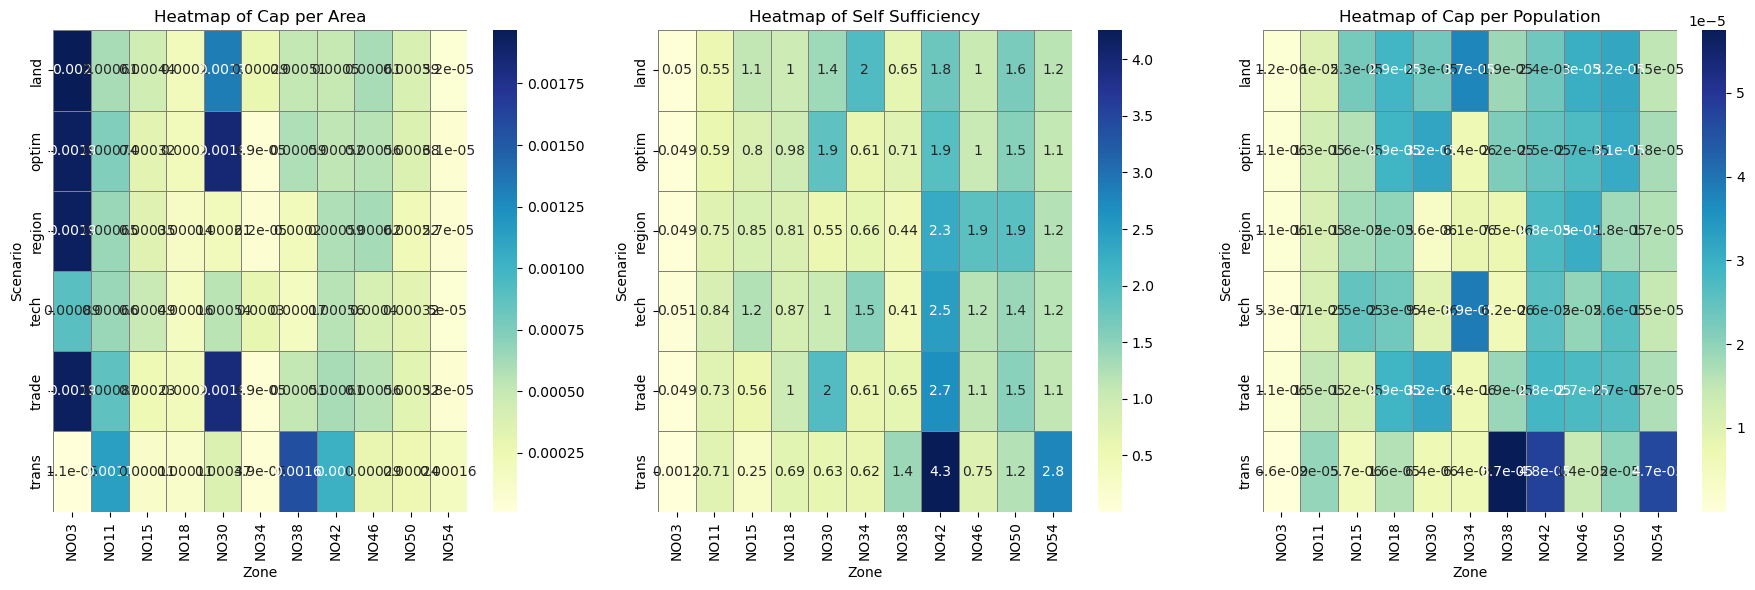

In [112]:
scenarios = ['optim', 'trans', 'trade', 'tech', 'land', 'region']


# Pivot the DataFrame to get the desired format
pivot_data1 = temp_cap_area.pivot_table(index='scenario_name', columns='zone', values='cap_per_area')

# Plot the heatmap
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(pivot_data1, ax=ax1, cmap='YlGnBu', cbar=True, annot=True, linewidths=.5, linecolor='gray')

ax1.set_title('Heatmap of Cap per Area')
ax1.set_xlabel('Zone')
ax1.set_ylabel('Scenario')

pivot_data2 = dem_gen_self.pivot_table(index='scenario_name', columns='zone', values='self_suf')
sns.heatmap(pivot_data2, ax=ax2, cmap='YlGnBu', cbar=True, annot=True, linewidths=.5, linecolor='gray')
ax2.set_title('Heatmap of Self Sufficiency')
ax2.set_xlabel('Zone')
ax2.set_ylabel('Scenario')

pivot_data3 = temp_cap_pop.pivot_table(index='scenario_name', columns='zone', values='cap_per_pop')
sns.heatmap(pivot_data3, ax=ax3, cmap='YlGnBu', cbar=True, annot=True, linewidths=.5, linecolor='gray')
ax3.set_title('Heatmap of Cap per Population')
ax3.set_xlabel('Zone')
ax3.set_ylabel('Scenario')

plt.tight_layout()
plt.show()

In [1227]:
Norway

name  \
NO03                  Oslo   
NO11              Rogaland   
NO15       Møre og Romsdal   
NO18              Nordland   
NO30                 Viken   
NO34             Innlandet   
NO38  Vestfold og Telemark   
NO42                 Agder   
NO46              Vestland   
NO50             Trøndelag   
NO54     Troms og Finnmark   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [1254]:
df_pop_area

name  Population      Area
zone                                            
NO03                  Oslo      717710    426.40
NO11              Rogaland      499417   8575.73
NO15       Møre og Romsdal      270624  13839.56
NO18              Nordland      243081  35759.14
NO30                 Viken     1310774  22768.30
NO34             Innlandet      376304  49390.84
NO38  Vestfold og Telemark      433525  15924.74
NO42                 Agder      319850  14981.02
NO46              Vestland      651299  31968.72
NO50             Trøndelag      482956  39493.47
NO54     Troms og Finnmark      244663  70920.72

In [1268]:
df_pop_area

name  Population      Area
zone                                            
NO03                  Oslo      717710    426.40
NO11              Rogaland      499417   8575.73
NO15       Møre og Romsdal      270624  13839.56
NO18              Nordland      243081  35759.14
NO30                 Viken     1310774  22768.30
NO34             Innlandet      376304  49390.84
NO38  Vestfold og Telemark      433525  15924.74
NO42                 Agder      319850  14981.02
NO46              Vestland      651299  31968.72
NO50             Trøndelag      482956  39493.47
NO54     Troms og Finnmark      244663  70920.72

In [1402]:
df_pop_area.Population.sum()

5550203

In [1396]:
NStatis = df_pop_area.query("zone== 'NO54' or zone == 'NO18'").sum()
SStatis = df_pop_area.query("zone== 'NO42'").sum()
EStatis = df_pop_area.query("zone== 'NO30' or zone == 'NO34' or zone == 'NO03' or zone == 'NO38'").sum()
WStatis = df_pop_area.query("zone== 'NO46' or zone == 'NO15' or zone == 'NO11'").sum()
CStatis = df_pop_area.query("zone== 'NO50'").sum()

In [1397]:
NStatis

name          NordlandTroms og Finnmark
Population                       487744
Area                          106679.86
dtype: object

In [1398]:
WStatis

name          RogalandMøre og RomsdalVestland
Population                            1421340
Area                                 54384.01
dtype: object

In [1403]:
(SStatis.Population + EStatis.Population)/df_pop_area.Population.sum()

0.5690175656638145

In [1284]:
scenarios_demand

value
scenario zone            
land     NO03  16739.9436
         NO11  28438.8274
         NO15  25333.9905
         NO18  23371.0442
         NO30  36418.4166
...                   ...
trans    NO38  24398.4115
         NO42  19922.5443
         NO46  42929.7889
         NO50  20457.0884
         NO54  14960.0577

[66 rows x 1 columns]

In [1267]:
Norway['demand_GW'] = scenarios_demand.query("scenario=='optim'").droplevel('scenario').div(1000)
Norway['population'] = df_pop_area['Population'].div(1000000)
Norway['Area'] = df_pop_area['Area']

In [1345]:
Norway

name  \
NO03                  Oslo   
NO11              Rogaland   
NO15       Møre og Romsdal   
NO18              Nordland   
NO30                 Viken   
NO34             Innlandet   
NO38  Vestfold og Telemark   
NO42                 Agder   
NO46              Vestland   
NO50             Trøndelag   
NO54     Troms og Finnmark   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [1290]:
Norway = Norway.drop(columns=['demand_GW'])

/tmp/ipykernel_1600841/3379782456.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


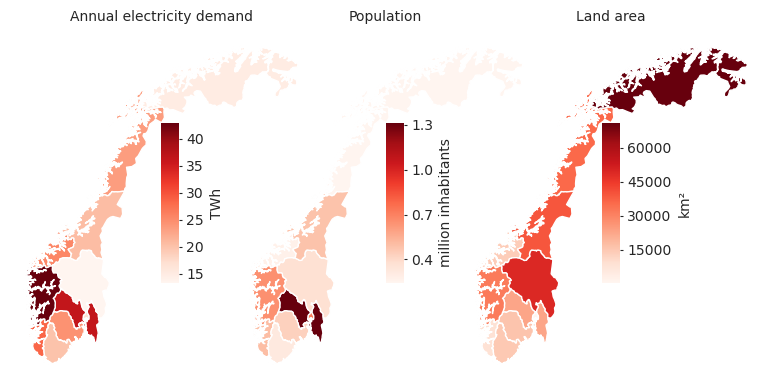

In [1373]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))
fig.subplots_adjust(wspace=-0.4, left=0.15, right=0.75, top=0.3, bottom=0.2)

# plot demand
ax1 = axes[0]

Norway.plot(ax=ax1, column='demand_TWh', cmap='Reds', legend=False)

ax_color_scale1 = fig.add_axes([0.25, 0.28, 0.02, 0.4])  # Adjust position as needed
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(vmin=Norway['demand_TWh'].min(), 
                         vmax=Norway['demand_TWh'].max())
cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale1, orientation='vertical')
cb1.set_label('TWh', fontsize=10)
new_ticks = [15, 20, 25, 30, 35, 40]
cb1.set_ticks(new_ticks)
cb1.outline.set_visible(False)
cb1.ax.tick_params(length=2)

ax1.axis('off')

ax1.set_title('Annual electricity demand', fontsize=10)


# plot population
ax2 = axes[1]

Norway.plot(ax=ax2, column='population', cmap='Reds', legend=False)

ax_color_scale2 = fig.add_axes([0.5, 0.28, 0.02, 0.4])  # Adjust position as needed
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(vmin=Norway['population'].min(), 
                         vmax=Norway['population'].max())
cb2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale2, orientation='vertical')
cb2.set_label('million inhabitants', fontsize=10)
new_ticks = [0.4, 0.7, 1, 1.3]
cb2.set_ticks(new_ticks)
cb2.outline.set_visible(False)
cb2.ax.tick_params(length=2)

ax2.axis('off')

ax2.set_title('Population', fontsize=10)

# plot area
ax3 = axes[2]

Norway.plot(ax=ax3, column='Area', cmap='Reds', legend=False)

ax_color_scale3 = fig.add_axes([0.74, 0.28, 0.02, 0.4])  # Adjust position as needed
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(vmin=Norway['Area'].min(), 
                         vmax=Norway['Area'].max())
cb3 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale3, orientation='vertical')
cb3.set_label('km²', fontsize=10)
new_ticks = [15000, 30000, 45000, 60000]
cb3.set_ticks(new_ticks)
cb3.outline.set_visible(False)
cb3.ax.tick_params(length=2)

ax3.axis('off')

ax3.set_title('Land area', fontsize=10)

plt.tight_layout()

plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Equitydenominators.png', dpi=300, bbox_inches='tight')
plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Equitydenominators.jpg', dpi=300, bbox_inches='tight')

plt.show()






# Electricity generation per zone under preference scenarios

In [ ]:
(
    pd.concat([gentot, storage_gen_tot.rename(columns={"storecaptot": "value"})])
    .query("year == '2010' and Spatial == 'grid'")
    .unstack()
    .loc[:, "value"]
    .rename(columns={"Li-ion-8": "Lion", "Windonshore": "OnWind"})
    .drop(columns=["HydroRes", "HydroRoR"])
    .plot.barh(
        stacked=True,
        title="Electricity generation in 2030 in Norway without hydropower because that is almost constant",
        # ylabel="Scenario",
        xlabel="GWh",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)  #
# Include penalty generation

In [ ]:
gentot.concat(storetot)

# Costs


In [ ]:
# How expensive is each scenario?
costs = makenice(sqlite_list, "cost")

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False)

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False)

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs.query("variable == 'costs' & level_1 == 'level'").sort_values(by="costs",ascending=False).plot.barh()

In [ ]:
costs

In [ ]:
barplot(costs.query('level_1 == "level"').rename(columns={"costs": "value"}))

In [ ]:
costs.query(
    "level_1 == 'level' and year == '2010'"
    "and Spatial == 'grid'"
    "and Neigh != 'High'"
).unstack(["Solar"]).plot.barh(subplots=True, figsize=(15, 15))

In [ ]:
# 4.1 General cost overview
barplot(
    costs.query(
        "level_1 == 'level' and Spatial == 'grid' and Solar != 'High' and Neigh != 'High'"
    ),
    True,
)

In [ ]:
#

barplot(
    costs.query(
        #    'level_1 == "level" and year == "2010" and Cutoff == "0.15" and Neigh != "High"'
        'level_1 == "level"'
        #' and Neigh != "High"'
        'and Spatial == "grid" and year == "2010" and Solar == "High"'
    )
    .assign(relcost=lambda df: (df.costs / df.costs.min()).mul(100) - 100)
    .loc[:, ["relcost"]]
    .rename(
        columns={"relcost": "Relative cost increase compared to cheapest scenario [%]"}
    ),
    True,
)
# plt.xlim(1,1.2)
# stacked bars for load shedding

# Maybe reduce the number of bars and take Figure 4 from the low carbon paper as in inspiration?
# Create this with more info from the distribution of costs from the bottom
# Two panels on costs

In [ ]:
(
    costs.sort_index()
    .reset_index()
    .assign(
        name=lambda df: df.year.astype(str)
        + "_"
        + df.Nature
        + "_"
        + df.Fauna
        + "_"
        + df.Sami
        + "_"
        + df.Neigh
        + "_"
        + df.Solar
        + "_"
        + df.Spatial
    )
    .query('level_1 == "level"')
    .drop(columns=["variable", "level_1"])
    .set_index("name")
    # .sort_values(by="costs")
    .loc[:, "costs"]
    .plot.barh(figsize=(10, 15))
)

In [ ]:
df_costs.loc[(slice(None), "var_system_costs", slice(None))]

# Capacity


## Generator power capacity


### Total


In [ ]:
caps.index.levels

In [ ]:
level_to_change = 2
caps.index.set_levels(caps.index.levels[level_to_change].astype(int), level=level_to_change)

In [ ]:
# How much capacity per scenario?
caps = makenice(sqlite_list, "cap")
caps.index = caps.index.set_levels(caps.index.levels[level_to_change].astype(int), level=level_to_change)

In [ ]:
caps.query("level_1=='level'")

In [ ]:
caps.query("level_1=='level'&technology=='Windoffshore'")

In [ ]:
caps.query("level_1=='level'&technology=='NuclearEPR'")

In [ ]:
scale = 1
(
    caps.query(
        "level_1 == 'level'"
        ## "& year == '2010'"
        ## "& ((Neigh == 'High' and Solar == 'Low') or (Neigh == 'None' and Solar == 'Low'))"
        ## " & Solar == 'Low'"
    )
    .droplevel("level_1")
    .unstack()
    .loc[:, "gencaptot"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore", "Windoffshorefloating"]]
    .sort_index()
    ###.sort_values(["Windonshore"])
    .rename(
        columns={
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        },
    )
    # .query("year == '2010'")  # and ( Neigh == 'High' or Neigh == 'None') ")
    # .drop(columns=[
    #    "HydroRes",
    #    "HydroRoR",
    #    "Import"
    # ])
    # .loc[:,[
    #     #"OnWind",
    #     #"Solar"]
    # ]]
    .plot.barh(
        #stacked=True,
        title="Norwegian optimal installed electrictiy generation capacity without hydro and imports because they are fixed 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

In [ ]:
scale = 1
(
    caps.query(
        "level_1 == 'level'"
        ## "& year == '2010'"
        ## "& ((Neigh == 'High' and Solar == 'Low') or (Neigh == 'None' and Solar == 'Low'))"
        ## " & Solar == 'Low'"
    )
    .droplevel("level_1")
    .unstack()
    .loc[:, "gencaptot"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    ###.sort_values(["Windonshore"])
    .rename(
        columns={
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        },
    )
    # .query("year == '2010'")  # and ( Neigh == 'High' or Neigh == 'None') ")
    # .drop(columns=[
    #    "HydroRes",
    #    "HydroRoR",
    #    "Import"
    # ])
    # .loc[:,[
    #     #"OnWind",
    #     #"Solar"]
    # ]]
    .plot.barh(
        #stacked=True,
        title="Norwegian optimal installed electrictiy generation capacity without hydro and imports because they are fixed 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

In [ ]:
scale = 1
(
    caps.query(
        "level_1 == 'level'"
        ## "& year == '2010'"
        ## "& ((Neigh == 'High' and Solar == 'Low') or (Neigh == 'None' and Solar == 'Low'))"
        ## " & Solar == 'Low'"
    )
    .droplevel("level_1")
    .unstack()
    .loc[:, "gencaptot"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    ###.sort_values(["Windonshore"])
    .rename(
        columns={
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        },
    )
    # .query("year == '2010'")  # and ( Neigh == 'High' or Neigh == 'None') ")
    # .drop(columns=[
    #    "HydroRes",
    #    "HydroRoR",
    #    "Import"
    # ])
    # .loc[:,[
    #     #"OnWind",
    #     #"Solar"]
    # ]]
    .plot.barh(
        #stacked=True,
        title="Norwegian optimal installed electrictiy generation capacity without hydro and imports because they are fixed 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(21.533 / scale, 12.582 / scale),
        color=colordict,
    )
)

### New


In [ ]:
# TODO: What percentage of total land area are we using?
caps

In [ ]:
# How much new capacity per scenario?
newcaps = makenice(sqlite_list, "newcap")

In [ ]:
newcaps

In [ ]:
(
    newcaps.reset_index()
    #.assign(
    #    name=lambda df: df.year.astype(str)
    #    + "_"
    #    + df.Nature
    #    + "_"
    #    + df.Fauna
    #    + "_"
    #    + df.Sami
    #    + "_"
    #    + df.Neigh
    #    + "_"
    #    + df.Solar
    #    + "_"
    #    + df.Spatial
    #)
    #.query('level_1 == "level"')
    # .drop(columns=["level_1"])
    # .set_index("name")
    # .sort_values(by="gencapnew")
    # .loc[:, "gencapnew"]
    # .plot.barh(figsize=(10, 15))
)

## Storage capacity


# Capacity Factors


In [ ]:
import connectorx as cx

db_path = str(sqlite_list[0])  # path to your SQLite database
conn = "sqlite://" + db_path  # connection token
# query = 'SELECT h,vre,r,AVG(value) FROM vre_gen GROUP BY h'            # query string
query = "SELECT vre,r,AVG(value) FROM vre_gen WHERE vre='Windoffshore' GROUP BY vre,r;"
cx.read_sql(conn, query)  # read data from SQLite

In [ ]:
sql_conn = sqlite3.connect(sqlite_list[0], timeout=60)
connectorx.read_sql(sql_conn, "SELECT * FROM vre_gen")

In [ ]:
capfacs = makenice(sqlite_list, "vre_gen")

In [ ]:
for scenario in tqdm(scenariolist):
        scenarioname = str(scenario).split("/")[-2]
        year = str(scenario).split("/")[-3]
        #    scenarioname = str(scenario)[18:-11]
        scenarionamesplit = scenarioname.split("_")

        if parameter != "capacityfactor":
            con = sqlite3.connect(scenario)

        appendme = pd.read_sql_query(f"SELECT * from {table}", con)

        if tabletype == "multiple":
            appendme = appendme.set_index(index).stack().reset_index()

        appendme = (
            appendme.rename(columns=indexdict)
            .assign(
                year=year,
                Nature=scenarionamesplit[0],
                Fauna=scenarionamesplit[1],
                Sami=scenarionamesplit[2],
                Neigh=scenarionamesplit[3],
                Solar=scenarionamesplit[4],
                Spatial=scenarionamesplit[5],
                Cutoff=scenarionamesplit[6]
            )
            .astype(types)
            .set_index(indexlist)
            .sort_index()
        )
        returnlist.append(appendme)
        con.close()
    return pd.concat(returnlist)

In [ ]:
str(scenario).split("/")[-2]

In [ ]:
pd.read_parquet(scenario / "vre_1995_.parquet", engine="pyarrow")

In [ ]:
collectionlist = []

for scenario in tqdm(
    requested_scenarios.query("status == 'optimal' & spatials == 'grid'")
    .groupby("years")
    .first()
    .path
):
    scenarioname = str(scenario).split("/")[-1]
    year = str(scenario).split("/")[-2]
    scenarionamesplit = scenarioname.split("_")
    (
        collectionlist.append(
            pd.read_parquet(scenario / ("vre_" + year + "_.parquet"))
            # .query("technology == 'Windonshore'")
            # .groupby("spatial")
            # .mean()
            .assign(
                year=year,
                Nature=scenarionamesplit[0],
                Fauna=scenarionamesplit[1],
                Sami=scenarionamesplit[2],
                Neigh=scenarionamesplit[3],
                Solar=scenarionamesplit[4],
                Spatial=scenarionamesplit[5],
                Cutoff=scenarionamesplit[6],
            )
            .set_index()
            .sort_index()
        )
    )

gridcapfacs = pd.concat(collectionlist)

In [ ]:
collectionlist = []
for scenario in tqdm(sqlite_list):
    scenarioname = str(scenario).split("/")[-2]
    year = str(scenario).split("/")[-3]
    scenarionamesplit = scenarioname.split("_")
    (
        collectionlist.append(
            pd.read_parquet(sqlite_list[0].parent / ("vre_" + year + "_.parquet"))
            .query("technology == 'Windonshore'")
            .groupby("spatial")
            .mean()
            .assign(
                year=year,
                Nature=scenarionamesplit[0],
                Fauna=scenarionamesplit[1],
                Sami=scenarionamesplit[2],
                Neigh=scenarionamesplit[3],
                Solar=scenarionamesplit[4],
                Spatial=scenarionamesplit[5],
                Cutoff=scenarionamesplit[6],
            )
            .set_index()
            .sort_index()
        )
    )
gridcapfacs = pd.concat(collectionlist)

In [ ]:
pd.read_csv(
    sqlite_list[0].parent / "vre_1995_.csv", index_col=["time", "technology", "spatial"]
).to_parquet(sqlite_list[0].parent / "vre_1995_.parquet", compression="zstd")

In [ ]:
sql_conn = sqlite3.connect(sqlite_list[0], timeout=60)
pd.read_sql_query("SELECT vre,r,AVG(value) FROM vre_gen WHERE vre='Windoffshore' GROUP BY vre,r;", sql_conn) ^

In [ ]:
sql_conn = sqlite3.connect(sqlite_list[0], timeout=60)
data = []
for chunk in pd.read_sql_query("""SELECT * from people""", sql_conn, chunksize=10000):
    data.append(chunk)
df = pd.concat(data)

In [ ]:
meancapfacs = capfacs.groupby(
    [
        "year",
        "Nature",
        "Fauna",
        "Sami",
        "Neigh",
        "Solar",
        "Spatial",
        "technology",
        "region",
        "Cutoff",
    ]
).mean()

In [ ]:
meancapfacs

In [ ]:
meancapfacs.unstack().query("technology == 'Windonshore'")

In [ ]:
meancapfacs.query("technology == 'Windonshore'").unstack(-2)

In [ ]:
(
    meancapfacs.query(
        'technology == ["Windonshore"] and Cutoff == "0.15" and Solar =="Low"'
    )
    .unstack(-2)
    .sort_index(ascending=False)
)

In [ ]:
# Both scenarios with the same capfacs but different areas
# plot capacity factor increase from 0.0 to 0.15, make sure it always increases (xy scatterplot)

# Supply Curve


In [ ]:
area.reset_index().loc[:, ["year"]]

In [ ]:
# We need the Cumulative Supply [TWh/yr]
# We have the areas. If we multiply those with the capacity / area. This is capacity.
# TODO calculate LCOE based on formula in sheet generator cost
# TODO check what andy did in the offshore wind paper (supply curves)
# TODO james ieee paper supply curves in plots
capacity = area * (capacity / area)
yearly energy generated = capacity * yearlycapfac * 8760

lcoe = (annualized capex + fom)  * capacity + varom * yearly energy generated / yearly energy generated

In [ ]:
pargencapex = makenice(sqlite_list, "pargencapex")

In [ ]:
pargenfom = makenice(sqlite_list, "pargenfom")

In [ ]:
pargenvarom = makenice(sqlite_list, "pargenvarom")

In [ ]:
capacity = (
    area.query("technology == ['Windonshore','Solar'] and ")
    # .droplevel(["region"])
    # .unstack([-1, -2])
    # .loc[:, "value"]  # .T
)
capacity

In [ ]:
capexfom = (
    (
        pargencapex.query("technology == ['Windonshore','Solar']")
        .unstack()
        .add(pargenfom.query("technology == ['Windonshore','Solar']").unstack())
    ).loc[
        :, "value"
    ]  # .T
    # .mul(
    #        (area.query("technology == ['Windonshore','Solar']")
    #        .droplevel(["region"])
    #        .unstack([-1, -2])
    #    ))
)
capexfom

In [ ]:
component1 = capexfom.reindex(capacity.columns, level=1, axis=1).mul(capacity)

In [ ]:
yearly_energy_gen.droplevel(0, axis=1)

In [ ]:
varom = (
    pargenvarom.query("technology == ['Windonshore','Solar']")
    .unstack()
    .droplevel(0, axis=1)
)
varom

In [ ]:
component2 = varom.reindex(
    yearly_energy_gen.droplevel(0, axis=1).columns, axis=1, level=1
).mul(yearly_energy_gen.droplevel(0, axis=1))

In [ ]:
costcomponent = component1.add(component2)
costcomponent

In [ ]:
lcoe = costcomponent.div(yearly_energy_gen.droplevel(0, axis=1))
lcoe

In [ ]:
yearly_energy_gen.loc[scenario, :]

In [ ]:
fix, ax = plt.subplots(figsize=(16, 8))
for scenario in lcoe.query(
    "year=='2010' and Cutoff != '0.0' and Solar != 'High'"
).index:
    # x axis = gen sorted ascending by value
    xaxis = (
        yearly_energy_gen.loc[scenario, :]
        .droplevel(0)
        .loc[(slice(None), "Windonshore")]
        .fillna(0)
        .sort_values()
    )
    # y axis = gen sorted ascending by value
    yaxis = (
        lcoe.loc[scenario, :].loc[(slice(None), "Windonshore")].fillna(0).sort_values()
    )
    pd.DataFrame(
        index=xaxis.reindex(yaxis.index).cumsum().values,
        data=yaxis.values,
        columns=[yaxis.name],
    ).plot(drawstyle="steps", ax=ax)
xaxis = (
    yearly_energy_gen.loc[scenario, :]
    .droplevel(0)
    .loc[(slice(None), "Solar")]
    .fillna(0)
    .sort_values()
)
yaxis = lcoe.loc[scenario, :].loc[(slice(None), "Solar")].fillna(0).sort_values()
pd.DataFrame(
    index=xaxis.reindex(yaxis.index).cumsum().values,
    data=yaxis.values,
    columns=[yaxis.name],
).plot(drawstyle="steps", ax=ax)

# Oskar


In [ ]:
gen = []
# Options are 'quick', 'full' or 'super-quick'
how = "full"

if how == "quick":
    for scenario in scenarios_short:
        print(scenario + ".db")
        con = sqlite3.connect("data/" + str(scenario) + ".db")
        gen.append(
            pd.read_sql_query("SELECT * from var_gen", con)
            .drop(columns={"lo", "up", "marginal"})
            .set_index(["z", "h", "g"])
            .stack()
            .reset_index()
            .rename(
                columns={
                    "z": "zone",
                    "g": "technology",
                    "h": "hour",
                    "level_3": "type",
                    0: "electricity_generatioN_GWh",
                }
            )
            .assign(scenario=scenario)
            .astype({"hour": int})
            .set_index(["scenario", "zone", "technology", "hour", "type"])
            .sort_index()
        )
        con.close()
    df_gen = pd.concat(gen)
    del gen

if how == "full":
    for scenario in scenarios_short:
        print(scenario + ".db")
        con = sqlite3.connect("data/" + str(scenario) + ".db")
        gen.append(
            pd.read_sql_query("SELECT * from var_gen", con)
            .set_index(["z", "h", "g"])
            .stack()
            .reset_index()
            .rename(
                columns={
                    "z": "zone",
                    "g": "technology",
                    "h": "hour",
                    "level_3": "type",
                    0: "electricity_generatioN_GWh",
                }
            )
            .assign(scenario=scenario)
            .astype({"hour": int})
            .set_index(["scenario", "zone", "technology", "hour", "type"])
            .sort_index()
        )
    con.close()
    df_gen = pd.concat(gen)
    del gen

In [ ]:
gen = (
    df_gen.loc[slice(None), slice(None), slice(None), slice(None), "level"]
    .groupby(["scenario", "zone"])
    .sum()
    .reset_index()
    .set_index(["scenario", "zone"])
    .rename(columns={"electricity_generatioN_GWh": "generation_GWh"})
    .assign(
        demand=dem.demand_GWh,
        self_suf=lambda x: x.generation_GWh / x.demand,
    )
)

In [ ]:
gen

In [ ]:
temp = (
    gen.loc["HR_Solar_maximizing", slice(None)]
    .assign(
        share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
        share_dem=lambda x: x.demand / x.demand.sum(),
    )
    .sort_values("self_suf", ascending=True)
    .assign(
        cumulative_gen=lambda x: x.share_gen.cumsum(),
        cumulative_dem=lambda x: x.share_dem.cumsum(),
        score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_dem)),
    )
)

gini = 1 - temp.score.sum()
gini

## Country score


In [ ]:
df_score = pd.DataFrame(columns=["scenario", "principle", "zone", "score"])

In [ ]:
df_score

## Countries should generate what they consume (Gen per dem)


In [ ]:
df_gini = pd.DataFrame(columns=["scenario", "gini_c", "principle"])

for scenario in gen.reset_index().scenario.unique():
    print(scenario)
    temp = (
        gen.loc[scenario, slice(None)]
        .assign(
            share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
            share_dem=lambda x: x.demand / x.demand.sum(),
        )
        .sort_values("self_suf", ascending=True)
        .assign(
            cumulative_gen=lambda x: x.share_gen.cumsum(),
            cumulative_dem=lambda x: x.share_dem.cumsum(),
            score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_dem)),
        )
    )
    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "genperdem"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "self_suf"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.self_suf / x.self_suf.sum(),
            principle="genperdem",
        )
        .drop(columns={"self_suf"})
    )
    df_score = df_score.append(new_score)

## Test


In [ ]:
temp_gen_dem = temp.copy().sort_values("self_suf", ascending=True)
temp_gen_dem

In [ ]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

# create the df for the linear plot
df1 = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

plt.figure(figsize=(8, 8))
ax = df1.plot(legend=None, linestyle=":", color="k")

temp_gen_dem.plot.scatter(
    x="cumulative_dem", y="cumulative_gen", xlim=[0, 1], ylim=[0, 1], ax=ax
)

x = temp_gen_dem.cumulative_dem.to_numpy(copy=True)
x = np.insert(x, 0, 0)
y = temp_gen_dem.cumulative_gen.to_numpy(copy=True)
y = np.insert(y, 0, 0)
f = interp1d(x, y)

B = integrate.quad(f, 0, 1, epsabs=1e-4)
G = 1 - 2 * B[0]

plt.plot(x, y)

plt.xlabel("Cumulative share of population from lowest to highest capacity per capita")
plt.ylabel("Cumulative share of installed capacity")
# plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.title(label="Gini-Coefficient = " + str(G), fontsize=12)

plt.text(
    df1.x.mean(),
    df1.y.mean() + 0.05,
    "Line of perfect equality",
    rotation=45,
    # rotation=math.degrees(math.atan(a/b)),
    # ha = 'center',
    transform_rotates_text=True,
    size=12,
)

## Countries should generate based on their capability (Gen per nom GDP)


In [ ]:
df_econ = (
    pd.read_csv("economic_indic.tsv", sep="\t")
    .set_index("country")
    .rename({"GB": "UK"})
    .sort_index()
)

In [ ]:
for scenario in gen.reset_index().scenario.unique():
    print(scenario)
    temp = (
        gen.loc[scenario, slice(None)]
        .assign(
            share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
            share_dem=lambda x: x.demand / x.demand.sum(),
            gdp_nom=df_econ.gdp_nom,
            gen_per_gdp=lambda x: x.generation_GWh / x.gdp_nom,
            share_gdp=lambda x: x.gdp_nom / x.gdp_nom.sum(),
        )
        .sort_values("gen_per_gdp", ascending=True)
        .assign(
            cumulative_gen=lambda x: x.share_gen.cumsum(),
            cumulative_gdp=lambda x: x.share_gdp.cumsum(),
            score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_gdp)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "genpernomgdp"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "gen_per_gdp"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.gen_per_gdp / x.gen_per_gdp.sum(),
            principle="genpernomgdp",
        )
        .drop(columns={"gen_per_gdp"})
    )
    df_score = df_score.append(new_score)

## Countries should generate based on their capability (Gen per cap GDP)


In [ ]:
df_econ = (
    pd.read_csv("economic_indic.tsv", sep="\t")
    .set_index("country")
    .rename({"GB": "UK"})
    .sort_index()
)

In [ ]:
for scenario in gen.reset_index().scenario.unique():
    print(scenario)
    temp = (
        gen.loc[scenario, slice(None)]
        .assign(
            share_gen=lambda x: x.generation_GWh / x.generation_GWh.sum(),
            share_dem=lambda x: x.demand / x.demand.sum(),
            gdp_nom_cap=df_econ.gdp_nom_cap_USD,
            gen_per_gdp=lambda x: x.generation_GWh / x.gdp_nom_cap,
            share_gdp=lambda x: x.gdp_nom_cap / x.gdp_nom_cap.sum(),
        )
        .sort_values("gen_per_gdp", ascending=True)
        .assign(
            cumulative_gen=lambda x: x.share_gen.cumsum(),
            cumulative_gdp=lambda x: x.share_gdp.cumsum(),
            score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_gdp)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "genpercapgdp"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "gen_per_gdp"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.gen_per_gdp / x.gen_per_gdp.sum(),
            principle="genpercapgdp",
        )
        .drop(columns={"gen_per_gdp"})
    )
    df_score = df_score.append(new_score)

## Countries should install based on population (Cap per pop)


In [ ]:
df_pop = (
    pd.read_csv("population_2021.tsv", sep="\t")
    .set_index("country")
    .rename({"GB": "UK"})
    .sort_index()
)

In [ ]:
for scenario in p_cap2.reset_index().scenario.unique():
    print(scenario)
    temp = (
        p_cap2.loc[scenario, slice(None), slice(None), "level"]
        .groupby("zone")
        .sum()
        .reset_index()
        .set_index("zone")
        .assign(
            population=df_pop.population,
            cap_per_pop=lambda x: x.installed_capacity_GW / x.population,
            share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
            share_pop=lambda x: x.population / x.population.sum(),
        )
        .sort_values("cap_per_pop", ascending=True)
        .assign(
            cumulative_cap=lambda x: x.share_cap.cumsum(),
            cumulative_pop=lambda x: x.share_pop.cumsum(),
            score=lambda x: x.share_cap * (x.share_pop + 2 * (1 - x.cumulative_pop)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "capperpop"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "cap_per_pop"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.cap_per_pop / x.cap_per_pop.sum(),
            principle="capperpop",
        )
        .drop(columns={"cap_per_pop"})
    )
    df_score = df_score.append(new_score)

## Countries should install based on land-area (Cap per area)


In [ ]:
df_land = pd.read_csv("land_area_wb.tsv", sep="\t").set_index("country")

In [ ]:
df_land

In [ ]:
for scenario in p_cap2.reset_index().scenario.unique():
    print(scenario)
    temp = (
        p_cap2.loc[scenario, slice(None), slice(None), "level"]
        .groupby("zone")
        .sum()
        .reset_index()
        .set_index("zone")
        .assign(
            land_area=df_land.land_area_2021,
            cap_per_area=lambda x: x.installed_capacity_GW / x.land_area,
            share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
            share_land=lambda x: x.land_area / x.land_area.sum(),
        )
        .sort_values("cap_per_area", ascending=True)
        .assign(
            cumulative_cap=lambda x: x.share_cap.cumsum(),
            cumulative_area=lambda x: x.share_land.cumsum(),
            score=lambda x: x.share_cap * (x.share_land + 2 * (1 - x.cumulative_area)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "capperland"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "cap_per_area"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.cap_per_area / x.cap_per_area.sum(),
            principle="capperland",
        )
        .drop(columns={"cap_per_area"})
    )
    df_score = df_score.append(new_score)

## Countries should install based on inverse-emissions (Cap per CO2)


In [ ]:
df_emissions = (
    pd.read_csv("emissions_1970_2021.tsv", sep="\t")
    .drop(columns={"Unnamed: 0"})
    .set_index("zone")
)

In [ ]:
df_emissions.emissions_1970_2021

In [ ]:
for scenario in p_cap2.reset_index().scenario.unique():
    print(scenario)
    temp = (
        p_cap2.loc[scenario, slice(None), slice(None), "level"]
        .groupby("zone")
        .sum()
        .reset_index()
        .set_index("zone")
        .assign(
            emitted=df_emissions.emissions_1970_2021,
            cap_per_emit=lambda x: x.installed_capacity_GW / x.emitted,
            share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
            share_emit=lambda x: x.emitted / x.emitted.sum(),
        )
        .sort_values("cap_per_emit", ascending=True)
        .assign(
            cumulative_cap=lambda x: x.share_cap.cumsum(),
            cumulative_emit=lambda x: x.share_emit.cumsum(),
            score=lambda x: x.share_cap * (x.share_emit + 2 * (1 - x.cumulative_emit)),
        )
    )

    gini = 1 - temp.score.sum()
    df_gini = df_gini.append(
        {"scenario": scenario, "gini_c": gini, "principle": "capperco2"},
        ignore_index=True,
    )

    new_score = (
        temp.reset_index()
        .loc[:, ["zone", "cap_per_emit"]]
        .assign(
            scenario=scenario,
            score=lambda x: x.cap_per_emit / x.cap_per_emit.sum(),
            principle="capperco2",
        )
        .drop(columns={"cap_per_emit"})
    )
    df_score = df_score.append(new_score)

## Current system


In [ ]:
df_current = (
    pd.read_csv("country_capacities_entsoe.tsv", sep="\t")
    .groupby("country_code")
    .sum()
    .assign(
        demand=dem.loc["HR_Solar_maximizing"].demand_GWh,
        land=df_land.rename({"GB": "UK"}).land_area_2021,
        emissions_1970_2021=df_emissions.emissions_1970_2021,
        gdp_nom_cap=df_econ.gdp_nom_cap_USD,
        gdp_nom=df_econ.gdp_nom,
    )
)
df_current

In [ ]:
current_ginis = pd.DataFrame(columns=["scenario", "principle", "gini_c"])

## Gini plotting


In [ ]:
df_score.set_index(["scenario", "zone", "principle"]).loc[
    (slice(None), "NO", slice(None))
]

In [ ]:
colordict = {
    "genperdem": "#b20101",
    "genpernomgdp": "#08ad97",
    "capperpop": "#6895dd",
    "capperland": "#f9d002",
    "capperco2": "#4adbc8",
    "genpercapgdp": "#ff9000",
}

In [ ]:
principle_list = [
    "genperdem",
    "genpernomgdp",
    "genpercapgdp",
    "capperpop",
    "capperland",
    "capperco2",
]

In [ ]:
df_gini  # .set_index('principle')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
for principle in principle_list:
    temp = df_gini.loc[df_gini["principle"] == principle]
    x = temp.scenario
    y = temp.gini_c
    ax.scatter(
        x, y, c=colordict[principle], label=principle, alpha=1, edgecolors="none"
    )

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=[0.5, 1.12])
ax.grid(True)

plt.xticks(rotation=90, ha="right")
# plt.xticks([])
# plt.savefig('figures/gini_scatter_nl.pdf',bbox_inches='tight')
plt.show()

In [ ]:
df_gini.loc[df_gini["principle"] == principle].sort_values(by="gini_c").iloc[0].scenario

In [ ]:
for principle in principle_list:
    temp = df_gini.loc[df_gini["principle"] == principle]
    print(
        principle
        + ":"
        + df_gini.loc[df_gini["principle"] == principle]
        .sort_values(by="gini_c")
        .iloc[0]
        .scenario
    )

In [ ]:
# df_gini.set_index(['scenario','principle']).sort_index().loc[(slice(None),'capperco2')]

In [ ]:
df_score.set_index(["scenario", "zone", "principle"])

In [ ]:
df_score_wide = (
    df_score.set_index(["scenario", "zone", "principle"])
    .reset_index()
    .sort_values(by="zone")
)
df_score_wide

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

sns.boxplot(
    ax=ax,
    x="zone",
    y="score",
    data=df_score_wide,
    showfliers=False,
    color="tomato",
    # hue='scenario',
    labels=None,
)

plt.savefig("boxplot_score.pdf", bbox_inches="tight")

In [ ]:
df_wide = (
    p_cap2.loc[slice(None), slice(None), slice(None), "level"]
    .reset_index()
    .groupby(["scenario", "zone"])
    .sum()
    .reset_index()
)
df_wide

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

sns.boxplot(
    ax=ax,
    x="zone",
    y="installed_capacity_GW",
    data=df_wide,
    showfliers=False,
    color="tomato",
    # hue='scenario',
    labels=None,
)

In [ ]:
df_wide2 = (
    p_cap2.loc[slice(None), slice(None), slice(None), "level"]
    .reset_index()
    .groupby(["scenario", "technology"])
    .sum()
    .reset_index()
)
df_wide2

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

sns.boxplot(
    ax=ax,
    x="technology",
    y="installed_capacity_GW",
    data=df_wide2,
    showfliers=False,
    color="tomato",
    # hue='scenario',
    labels=None,
)

## Lorenz Curve


In [ ]:
# df_gini.set_index(['scenario','principle']).loc[('baseline',str(principle))].reset_index()#.gini_c[0]#.loc[:,'gini_c']

In [ ]:
principle = "genperdem"
df_gini.set_index(["scenario", "principle"]).loc[("baseline", str(principle))].gini_c

print(
    "Gini = "
    + str(
        df_gini.set_index(["scenario", "principle"])
        .loc[("baseline", str(principle))]
        .gini_c
    )
)

In [ ]:
df_lorenz = (
    df_gen.loc[("baseline", slice(None), slice(None), slice(None), "level")]
    .groupby("zone")
    .sum()
    .join(dem.loc[(("baseline"), slice(None))])
    .join(df_pop.drop(columns={"source"}))
    .join(df_econ.drop(columns={"gdp_ppp", "gdp_nom_cap_USD"}))
    .join(df_land.drop(columns={"source"}).rename({"GB": "UK"}))
    .join(
        p_cap2.loc[("baseline", slice(None), slice(None), "level")]
        .groupby("zone")
        .sum()
    )
)

In [ ]:
df_lorenz

In [ ]:
df_lorenz = df_lorenz.assign(
    share_gen=lambda x: x.electricity_generatioN_GWh
    / x.electricity_generatioN_GWh.sum(),
    share_dem=lambda x: x.demand_GWh / x.demand_GWh.sum(),
    self_suf=lambda x: x.electricity_generatioN_GWh / x.demand_GWh,
    gen_per_nom_gdp=lambda x: x.electricity_generatioN_GWh / x.gdp_nom,
    gen_per_cap_gdp=lambda x: x.electricity_generatioN_GWh / x.gdp_ppp_capita,
    share_nom_gdp=lambda x: x.gdp_nom / x.gdp_nom.sum(),
    share_cap_gdp=lambda x: x.gdp_ppp_capita / x.gdp_ppp_capita.sum(),
    cap_per_pop=lambda x: x.installed_capacity_GW / x.population,
    share_cap=lambda x: x.installed_capacity_GW / x.installed_capacity_GW.sum(),
    share_pop=lambda x: x.population / x.population.sum(),
    cap_per_area=lambda x: x.installed_capacity_GW / x.land_area_2021,
    share_land=lambda x: x.land_area_2021 / x.land_area_2021.sum(),
)
df_lorenz.sort_values(by="self_suf")

In [ ]:
df_gini.principle.unique()  # .set_index(['scenario','principle']).loc[('baseline',str(principle))][0]

In [ ]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

# create the df for the linear plot
df1 = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

plt.figure(figsize=(19.2, 12))
ax = df1.plot(legend=None, linestyle=":", color="k")

# Gen per demand
principle = "genperdem"
df_lorenz.sort_values("self_suf", ascending=True).assign(
    cumulative_gen=lambda x: x.share_gen.cumsum(),
    cumulative_dem=lambda x: x.share_dem.cumsum(),
    score=lambda x: x.share_gen * (x.share_dem + 2 * (1 - x.cumulative_dem)),
).plot.line(
    x="cumulative_dem",
    y="cumulative_gen",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Gen per dem |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Gen per nominal GDP
principle = "genpernomgdp"
df_lorenz.sort_values("gen_per_nom_gdp", ascending=True).assign(
    cumulative_gen=lambda x: x.share_gen.cumsum(),
    cumulative_gdp=lambda x: x.share_nom_gdp.cumsum(),
).plot.line(
    x="cumulative_gdp",
    y="cumulative_gen",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Gen per nominal GDP |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Gen per capita GDP
principle = "genpercapgdp"
df_lorenz.sort_values("gen_per_cap_gdp", ascending=True).assign(
    cumulative_gen=lambda x: x.share_gen.cumsum(),
    cumulative_gdp=lambda x: x.share_cap_gdp.cumsum(),
).plot.line(
    x="cumulative_gdp",
    y="cumulative_gen",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Gen per capita GDP |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Cap per population
principle = "capperpop"
df_lorenz.sort_values("cap_per_pop", ascending=True).assign(
    cumulative_cap=lambda x: x.share_cap.cumsum(),
    cumulative_pop=lambda x: x.share_pop.cumsum(),
).plot.line(
    x="cumulative_pop",
    y="cumulative_cap",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Cap per population |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

# Cap per land area
principle = "capperland"
df_lorenz.sort_values("cap_per_area", ascending=True).assign(
    cumulative_cap=lambda x: x.share_cap.cumsum(),
    cumulative_area=lambda x: x.share_land.cumsum(),
    score=lambda x: x.share_cap * (x.share_land + 2 * (1 - x.cumulative_area)),
).plot.line(
    x="cumulative_area",
    y="cumulative_cap",
    xlim=[0, 1],
    ylim=[0, 1],
    ax=ax,
    label="Cap per land area |"
    + " Gini = "
    + str(
        round(
            df_gini.set_index(["scenario", "principle"]).loc[
                ("baseline", str(principle))
            ][0],
            3,
        )
    ),
)

plt.xlabel("Cumulative share of denominator")
plt.ylabel("Cumulative share of numerator")
# plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')

plt.text(
    df1.x.mean(),
    df1.y.mean() + 0.05,
    "Line of perfect equality",
    rotation=45,
    # rotation=math.degrees(math.atan(a/b)),
    # ha = 'center',
    transform_rotates_text=True,
    size=12,
)

# plt.savefig('figures/lorenz_baseline.png', bbox_inches = 'tight')

# Poster plots

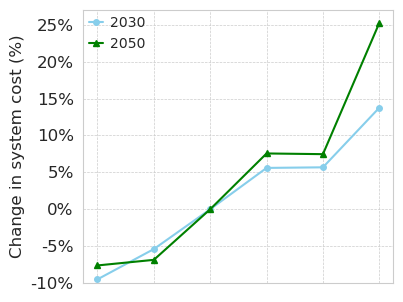

In [394]:
scenarios = ['trans', 'trade', 'optim', 'land', 'tech','region'] # plot sequence wrt data30
#scenarios = ['Optimal', '+landscape', '+regional', '+technology', '+transmission']
#data = cost_seq_pref_5.loc[['2030'],['percent_change']]
data30 = cost_Ind_pref.unstack(level=0).sort_values(by=[('percent_change', '2030')], ascending=True)

years = [2030, 2040, 2050]
fig, ax = plt.subplots(figsize=(4, 3.5))
plt.subplots_adjust(bottom=0.1)


line_width = 1.5
scatter_size = 50
r1 = np.arange(len(scenarios))  # 2030 slightly to the left
r2 = np.arange(len(scenarios))  # 2040 at the center
r3 = np.arange(len(scenarios))  # 2050 slightly to the right

#change bar_width accordingly
bar_width = 0.48
plt.plot(r1, data30['percent_change']['2030'], color='skyblue', linewidth=line_width, linestyle='-', marker='o', markersize=4, label='2030')
#plt.plot(r2, data30['percent_change']['2040'], color='orange', linewidth=line_width, linestyle='-', marker='s', markersize=4, label='2040')
plt.plot(r3, data30['percent_change']['2050'], color='green', linewidth=line_width, linestyle='-', marker='^', markersize=4, label='2050')

#plt.plot(r1, data30['percent_change']['2030'], color='skyblue', linestyle='--')
#plt.plot(r2, data30['percent_change']['2030'], color='orange', linestyle='--')
#plt.plot(r3, data30['percent_change']['2030'], color='green', linestyle='--')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#custom x-axis
#ax.set_xticks([r + bar_width for r in range(len(scenarios))])
ax.set_xticks(np.arange(len(scenarios)))
ax.set_xticklabels('', ha='center',fontsize=12)
ax.set_xlim(-0.25, 5.25)

#custom y-axis
ax.set_ylim(-10, 27) 
ax.set_yticks(np.arange(-10, 27, 5))
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_ylabel('Change in system cost (%)', fontsize=12)

# Add percent signs to the y-tick labels
def percent_formatter(x, pos):
    return f'{x:.0f}%'
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

#Horizontal line
#ax.axvline(x=2, color='red', linestyle='-', linewidth=1)

ax.legend(loc='upper left', borderaxespad=0., frameon=False, 
          fontsize=10, handlelength=1, handletextpad=0.5)

#plt.tight_layout(rect=[0, 0.3, 1, 1]) 
plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChangeline_posterT.png', dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/systemcostChange_allyears.jpg', dpi=300, bbox_inches='tight')

# Customize legend
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False, 
#          fontsize=10, handlelength=1.5, handletextpad=0.5)


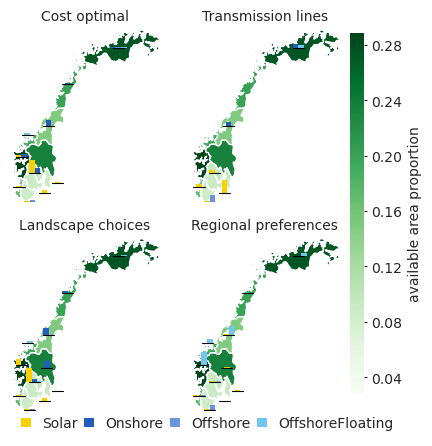

In [373]:
#plot
#year = 2050

cap2040 = captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050')]
#scenarios = ['optim', 'trans', 'trade', 'land', 'tech', 'region']
scenarios = ['optim', 'trans', 'land', 'region']
technologies = ['Solar', 'Windonshore', 'Windoffshore', 'Windoffshorefloating']
legend_names = ['Solar', 'Onshore', 'Offshore', 'OffshoreFloating']
colors = ['#f9d002', '#235ebc', '#6895dd', '#74c6f2']
max_capacities = {scenario: {tech: cap2040[(cap2040['Scenario Name'] == scenario) & (cap2040['technology'] == tech)]['gencap'].max() 
                             for tech in technologies} 
                  for scenario in scenarios}

offset_dict = {
    'NO42': [0.5, -0.68],
    'NO03': [2.4, -0.5],
    'NO54': [0, 0],
    'NO15': [0, 0.5],
    'NO38': [2, -0.8],
    'NO50': [0., 0],
    'NO11': [0, 0],
    'NO34': [0.7, -0.2],
    'NO30': [-0.9, 0.1],
    'NO18': [0, 0],
    'NO46': [0.2, 0.5],
}



def create_additional_legends(fig, cap2040, technologies, max_capacities):

    legend_elements = [plt.Rectangle((0,0),0.5,0.5, facecolor=color, edgecolor='none') for color in colors]
    tech_legend = fig.legend(legend_elements, legend_names,borderaxespad=0,frameon=False,handlelength=0.7,
                             fontsize=10, bbox_to_anchor=(0.82, 0.1), ncol=4, labelspacing=0.1, columnspacing=0.5)


    ax_color_scale = fig.add_axes([0.75, 0.14, 0.02, 0.8])  # Adjust position as needed
    cmap = plt.get_cmap('Greens')
    norm = plt.Normalize(vmin=Norway['available_area_proportion'].min(), 
                         vmax=Norway['available_area_proportion'].max())
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale, orientation='vertical')
    cb.set_label('available area proportion', fontsize=10)
    new_ticks = [0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28]
    cb.set_ticks(new_ticks)
    cb.outline.set_visible(False)
    cb.ax.tick_params(length=2)

    #cb.ax.yaxis.set_label_position('left')
    cb.ax.tick_params(right=True, left=False, labelright=True, labelleft=False, labelsize=10)
    
    return tech_legend, ax_color_scale    

indices_in_ranges = []

# Function to create bar plots for each zone
def create_zone_plot(ax, data, scenario, zone, technologies, colors, x_scaled, y_scaled, max_capacities, offset_dict):

    width = 1
    scale_factor = 1
    
    x_offset, y_offset = offset_dict.get(zone, [0, 0])
    trans = (transforms.Affine2D()
             .scale(scale_factor)
             .translate(x_scaled+x_offset, y_scaled+y_offset) + ax.transData)
    non_zero_techs = []
    non_zero_values = []
    non_zero_colors = []

    #calculating the maximum of in given scenario across technologies and zones for normalizing
    scenario_capacities = max_capacities[scenario]
    max_scen_cap = max(scenario_capacities, key=scenario_capacities.get)
    max_scen_value = scenario_capacities[max_scen_cap]
    
    for i, tech in enumerate(technologies):
        values = data[(data['Scenario Name'] == scenario) & 
                      (data['zone'] == zone) & 
                      (data['technology'] == tech)]
        normalized_value = 0
        value = values['gencap'].values[0]
        if value>0.0001:   
            #normalized_value = value / max_capacities[scenario][tech]
            normalized_value = value / max_scen_value
        #else:
        #    normalized_value = value / max_capacities[scenario][tech]

        if normalized_value > 0.0001:
            non_zero_techs.append(tech)
            non_zero_values.append(normalized_value)
            non_zero_colors.append(colors[i])

        # Check if the normalized value falls within the specified ranges for making bar length legends insskap
        #if 1 <= normalized_value <= 0.8 or 0.5 <= normalized_value <= 0.7 or 0.2 <= normalized_value <= 0.4:
        indices_in_ranges.append({
                'row_index': values.index[0],
                'scenario': scenario,
                'zone': zone,
                'technology': tech,
                'normalized_value': normalized_value
            })
    
    if non_zero_techs:
        for i, (value, color) in enumerate(zip(non_zero_values, non_zero_colors)):
            x_pos = (i - len(non_zero_techs)/2 + 0.5) * width
            ax.bar(x_pos, value, width, color=color, transform=trans, edgecolor='none')
        
        ax.plot([-0.5*len(technologies)/2, 0.5*len(technologies)/2], [0, 0], color='black', linewidth=0.8, transform=trans)
    ax.yaxis.set_visible(False)
    ax.set_xticks([])
    

fig, axs = plt.subplots(2, 2, figsize=(7, 4.5))
fig.subplots_adjust(wspace=-0.6, left=0.05, right=0.95, top=0.95, bottom=0.1)
axs = axs.flatten()
Title_names = ['Cost optimal', 'Transmission lines', 'Landscape choices', 'Regional preferences']
for i, scenario in enumerate(scenarios):
    ax = axs[i]
    Norway.plot(ax=ax, column='available_area_proportion', cmap='Greens', legend=False)

    for idx, row in Norway.iterrows():
        zone = idx
        x_scaled = row['x_coord']
        y_scaled = row['y_coord']

        create_zone_plot(ax, cap2040, scenario, zone, technologies, colors, x_scaled, y_scaled, max_capacities, offset_dict)
    

    ax.set_title(Title_names[i], fontsize=10)
    ax.set_xlim(Norway.total_bounds[0], Norway.total_bounds[2])
    ax.set_ylim(Norway.total_bounds[1], Norway.total_bounds[3])
    ax.axis('off')    

tech_legend, ax_color_scale = create_additional_legends(fig, cap2040, technologies, max_capacities)

#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/tech_cap_zonal_posterTT2.png', dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/tech_cap_zonal.jpg', dpi=300, bbox_inches='tight')



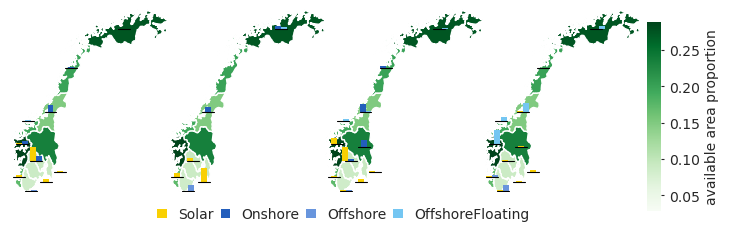

In [390]:
#plot
#year = 2050

cap2040 = captotz_Ind_pref_change[(captotz_Ind_pref_change['demandyear'] == '2050')]
#scenarios = ['optim', 'trans', 'trade', 'land', 'tech', 'region']
scenarios = ['optim', 'trans', 'land', 'region']
technologies = ['Solar', 'Windonshore', 'Windoffshore', 'Windoffshorefloating']
legend_names = ['Solar', 'Onshore', 'Offshore', 'OffshoreFloating']
colors = ['#f9d002', '#235ebc', '#6895dd', '#74c6f2']
max_capacities = {scenario: {tech: cap2040[(cap2040['Scenario Name'] == scenario) & (cap2040['technology'] == tech)]['gencap'].max() 
                             for tech in technologies} 
                  for scenario in scenarios}

offset_dict = {
    'NO42': [0.5, -0.68],
    'NO03': [2.4, -0.5],
    'NO54': [0, 0],
    'NO15': [0, 0.5],
    'NO38': [2, -0.8],
    'NO50': [0., 0],
    'NO11': [0, 0],
    'NO34': [0.7, -0.2],
    'NO30': [-0.9, 0.1],
    'NO18': [0, 0],
    'NO46': [0.2, 0.5],
}



def create_additional_legends(fig, cap2040, technologies, max_capacities):

    legend_elements = [plt.Rectangle((0,0),0.5,0.5, facecolor=color, edgecolor='none') for color in colors]
    tech_legend = fig.legend(legend_elements, legend_names,borderaxespad=0,frameon=False,handlelength=0.7,
                             fontsize=10, bbox_to_anchor=(0.8, 0.3), ncol=4, labelspacing=0.1, columnspacing=0.5)


    ax_color_scale = fig.add_axes([0.96, 0.28, 0.02, 0.42])  # Adjust position as needed
    cmap = plt.get_cmap('Greens')
    norm = plt.Normalize(vmin=Norway['available_area_proportion'].min(), 
                         vmax=Norway['available_area_proportion'].max())
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax_color_scale, orientation='vertical')
    cb.set_label('available area proportion', fontsize=10)
    new_ticks = [0.05, 0.10, 0.15, 0.20, 0.25]
    cb.set_ticks(new_ticks)
    cb.outline.set_visible(False)
    cb.ax.tick_params(length=2)

    #cb.ax.yaxis.set_label_position('left')
    cb.ax.tick_params(right=True, left=False, labelright=True, labelleft=False, labelsize=10)
    
    return tech_legend, ax_color_scale    

indices_in_ranges = []

# Function to create bar plots for each zone
def create_zone_plot(ax, data, scenario, zone, technologies, colors, x_scaled, y_scaled, max_capacities, offset_dict):

    width = 1
    scale_factor = 1
    
    x_offset, y_offset = offset_dict.get(zone, [0, 0])
    trans = (transforms.Affine2D()
             .scale(scale_factor)
             .translate(x_scaled+x_offset, y_scaled+y_offset) + ax.transData)
    non_zero_techs = []
    non_zero_values = []
    non_zero_colors = []

    #calculating the maximum of in given scenario across technologies and zones for normalizing
    scenario_capacities = max_capacities[scenario]
    max_scen_cap = max(scenario_capacities, key=scenario_capacities.get)
    max_scen_value = scenario_capacities[max_scen_cap]
    
    for i, tech in enumerate(technologies):
        values = data[(data['Scenario Name'] == scenario) & 
                      (data['zone'] == zone) & 
                      (data['technology'] == tech)]
        normalized_value = 0
        value = values['gencap'].values[0]
        if value>0.0001:   
            #normalized_value = value / max_capacities[scenario][tech]
            normalized_value = value / max_scen_value
        #else:
        #    normalized_value = value / max_capacities[scenario][tech]

        if normalized_value > 0.0001:
            non_zero_techs.append(tech)
            non_zero_values.append(normalized_value)
            non_zero_colors.append(colors[i])

        # Check if the normalized value falls within the specified ranges for making bar length legends insskap
        #if 1 <= normalized_value <= 0.8 or 0.5 <= normalized_value <= 0.7 or 0.2 <= normalized_value <= 0.4:
        indices_in_ranges.append({
                'row_index': values.index[0],
                'scenario': scenario,
                'zone': zone,
                'technology': tech,
                'normalized_value': normalized_value
            })
    
    if non_zero_techs:
        for i, (value, color) in enumerate(zip(non_zero_values, non_zero_colors)):
            x_pos = (i - len(non_zero_techs)/2 + 0.5) * width
            ax.bar(x_pos, value, width, color=color, transform=trans, edgecolor='none')
        
        ax.plot([-0.5*len(technologies)/2, 0.5*len(technologies)/2], [0, 0], color='black', linewidth=0.8, transform=trans)
    ax.yaxis.set_visible(False)
    ax.set_xticks([])
    

fig, axs = plt.subplots(1, 4, figsize=(7, 4.5))
fig.subplots_adjust(wspace=0, left=0.05, right=0.95, top=0.95, bottom=0.1)
axs = axs.flatten()
Title_names = ['Cost optimal', 'Transmission lines', 'Landscape choices', 'Regional preferences']
for i, scenario in enumerate(scenarios):
    ax = axs[i]
    Norway.plot(ax=ax, column='available_area_proportion', cmap='Greens', legend=False)

    for idx, row in Norway.iterrows():
        zone = idx
        x_scaled = row['x_coord']
        y_scaled = row['y_coord']

        create_zone_plot(ax, cap2040, scenario, zone, technologies, colors, x_scaled, y_scaled, max_capacities, offset_dict)
    

    #ax.set_title(Title_names[i], fontsize=10)
    ax.set_xlim(Norway.total_bounds[0], Norway.total_bounds[2])
    ax.set_ylim(Norway.total_bounds[1], Norway.total_bounds[3])
    ax.axis('off')    

tech_legend, ax_color_scale = create_additional_legends(fig, cap2040, technologies, max_capacities)

plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/tech_cap_zonal_posterTT11.png', dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/tech_cap_zonal.jpg', dpi=300, bbox_inches='tight')



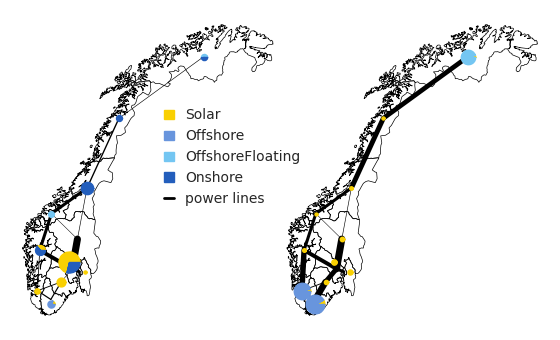

In [398]:
#Transmission subplot for Poster
from matplotlib.lines import Line2D
data_plot = {
    'Optim': {
        'fix': {'pies': fix_optim_pies, 'cap_frac': fix_optim_cap_frac, 'trans': fix_optim_trans, 'trans_tot': fix_optim_trans_tot},
        'lowoh': {'pies': lowoh_optim_pies, 'cap_frac': lowoh_optim_cap_frac, 'trans': lowoh_optim_trans, 'trans_tot': lowoh_optim_trans_tot}
    },
    'Land': {
        'fix': {'pies': cumulative_pies, 'cap_frac': cumulative_cap_frac, 'trans': Cumulative_trans, 'trans_tot': Cumulative_trans_tot},
        'lowoh': {'pies': lowoh_land_pies, 'cap_frac': lowoh_land_cap_frac, 'trans': lowoh_land_trans, 'trans_tot': lowoh_land_trans_tot}
    }
}
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
#fig.subplots_adjust(wspace=-0.7,  hspace=0, left=0.05, right=0.95, top=0.1, bottom=0)

color_mapping = {
    'Solar': '#f9d002',
    'WindOffshore': '#6895dd',
    'WindOffshoreFloating': '#74c6f2',
    'WindOnshore': '#235ebc'
}

offset_dict1 = {
    'NO42': [0, -0.4], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

offset_dict2 = {
    'NO42': [0, -0.22], 'NO03': [0.6, 0], 'NO54': [0, 0], 'NO15': [0, 0],
    'NO38': [0, 0], 'NO50': [0, 0], 'NO11': [0, 0], 'NO34': [0, 0],
    'NO30': [-0.3, 0.3], 'NO18': [0, 0], 'NO46': [0, 0],
}

legend_entries = []
short_labels = {
    'Solar': 'Solar',
    'WindOffshore': 'Offshore',
    'WindOffshoreFloating': 'OffshoreFloating',
    'WindOnshore': 'Onshore'
}
for technology, color in color_mapping.items():
    short_label = short_labels[technology]
    legend_entries.append(mpatches.Patch(color=color, label=short_label))

linewidth = 40
trans_HVACcolor = 'black'

# Create a Line2D object for the legend to represent the transmission line
trans_legend = Line2D([0], [0], color=trans_HVACcolor, linewidth=2, label='power lines')

legend_entries.append(trans_legend)

max_trans_tot = fix_optim_trans_tot #change the maximum value according to scenario plots

def plot_subplot(ax, data, title, ax_row):
    Norway.boundary.plot(ax=ax, zorder=1, linewidth=0.5, color='black')
    
    for i in ['NO03','NO11','NO15','NO18','NO30','NO34','NO38','NO42','NO46','NO50','NO54']:
        wedges, labels = data['pies'][i]
        for wedge, label in zip(wedges, labels): 
            color = color_mapping[label.get_text()]
            vertices = wedge.get_path().vertices.tolist()
            size = 500 * data['cap_frac'][i]
            offset_x, offset_y = offset_dict1[i]
            if ax_row == 0:
                offset_x, offset_y = offset_dict2[i]
            ax.scatter(cent.x[i]+offset_x, cent.y[i]+offset_y, marker=(vertices),
                       s=size, zorder=100, facecolor=color)

    ax.axis('off')
    ax.set_title(title, fontsize=11)
    #trans_HVDCcolor = 'red'

    for i in [['NO03', 'NO30'], ['NO11', 'NO38'], ['NO11', 'NO42'], ['NO11', 'NO46'], 
              ['NO15', 'NO34'], ['NO15', 'NO46'], ['NO15', 'NO50'], ['NO18', 'NO50'], 
              ['NO18', 'NO54'], ['NO30', 'NO34'], ['NO30', 'NO38'], ['NO30', 'NO46'],
              ['NO34', 'NO46'], ['NO34', 'NO50'], ['NO38', 'NO42'], ['NO38', 'NO46']]:
        ax.plot([cent[i[0]].x, cent[i[1]].x], [cent[i[0]].y, cent[i[1]].y],
                 linewidth=(linewidth*data['trans'].query("Zone_1 == " + "'" + i[0] + "'" + " and Zone_2 == " + "'" + i[1] + "'")
                            #.values[0][0]/data['trans_tot']), color=trans_HVACcolor)
                            .values[0][0]/max_trans_tot), color=trans_HVACcolor)
        
axs[0].legend(handles=legend_entries, borderaxespad=0,frameon=False,handlelength=0.7,
                             fontsize=10, bbox_to_anchor=(0.54, 0.71))


plot_subplot(axs[0], data_plot['Optim']['fix'], '', 0)
plot_subplot(axs[1], data_plot['Land']['fix'], '', 0)
#plot_subplot(axs[2], data_plot['Optim']['lowoh'], 'Optim-Trans', 1)
#plot_subplot(axs[2], data_plot['Land']['lowoh'], 'land-trans', 1)

fig.subplots_adjust(wspace=-0.8,  hspace=-0.9, left=0.05, right=0.95, top=0.9, bottom=0)
plt.tight_layout()

plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation_posterT.png', dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig('/fp/homes01/u01/ec-javedm/ec85/models/shahzad/Plots/Electricity_allocation2.jpg', dpi=300, bbox_inches='tight')

plt.show()
#Why not having this plot when all preferences are in place ??? Why just for only Land and Trans? Because aiming to show the impact
#on transmission when land+trans take place. trans has similar impact  with optim so not displayed here. Probably one table could be made to 
# in supplemental to show the capacities under all scenarios